## 필요한 모듈 설치 확인

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from replay_memory import ReplayBuffer, PrioritizedReplayBuffer

import random
import os
import pickle
import time
from collections import deque
from copy import deepcopy
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from wrappers import wrap, wrap_cover, SubprocVecEnv

## 하이퍼 파라미터 정의하기

In [2]:
'''DQN settings'''
# sequential images to define state
STATE_LEN = 4
# target policy sync interval
TARGET_REPLACE_ITER = 1
# simulator steps for start learning
LEARN_START = int(1e+3)
# (prioritized) experience replay memory size
MEMORY_CAPACITY = int(1e+5)
# simulator steps for learning interval
LEARN_FREQ = 1
# atom number. default is C51 algorithm
N_ATOM = 51


'''Environment Settings'''
# number of environments for C51
N_ENVS = 4
# openai gym env name
ENV_NAME = 'BreakoutNoFrameskip-v4'
env = SubprocVecEnv([wrap_cover(ENV_NAME) for i in range(N_ENVS)])
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape
# prior knowledge of return distribution, 
V_MIN = -5.
V_MAX = 10.
V_RANGE = np.linspace(V_MIN, V_MAX, N_ATOM)
V_STEP = ((V_MAX-V_MIN)/(N_ATOM-1))
# Total simulation step
STEP_NUM = int(1e+7)
# gamma for MDP
GAMMA = 0.99
# visualize for agent playing
RENDERING = False

'''Training settings'''
# check GPU usage
USE_GPU = torch.cuda.is_available()
print('USE GPU: '+str(USE_GPU))
# mini-batch size
BATCH_SIZE = 32
# learning rage
LR = 1e-4
# epsilon-greedy
EPSILON = 1.0

'''Save&Load Settings'''
# check save/load
SAVE = True
LOAD = False
# save frequency
SAVE_FREQ = int(1e+3)
# paths for predction net, target net, result log
PRED_PATH = './data/model/pred_net.pkl'
TARGET_PATH = './data/model/target_net.pkl'
RESULT_PATH = './data/plots/result.pkl'

/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow')

USE GPU: True


/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow')

## 네트워크 구조 정의하기

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # nn.Sequential을 사용하면 다음과 같입 코드를 간결하게 바꿀 수 있습니다.
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 512)
        
        # action value distribution
        self.fc_q = nn.Linear(512, N_ACTIONS * N_ATOM) 
            
        # 파라미터 값 초기화 코드는 다음과 같이 간결하게 바꿀 수 있습니다.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x.size(0) : minibatch size
        mb_size = x.size(0)
        # x는 (m, 84, 84, 4)의 tensor
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        
        # note that output of C-51 is prob mass of value distribution
        action_value = F.softmax(self.fc_q(x).view(mb_size, N_ACTIONS, N_ATOM), dim=2)

        return action_value

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))

## C51 정의하기

In [4]:
class DQN(object):
    def __init__(self):
        self.pred_net, self.target_net = ConvNet(), ConvNet()
        # sync eval target
        self.update_target(self.target_net, self.pred_net, 1.0)
        # use gpu
        if USE_GPU:
            self.pred_net.cuda()
            self.target_net.cuda()
            
        # simulator step conter
        self.memory_counter = 0
        # target network step counter
        self.learn_step_counter = 0
        
        # ceate the replay buffer
        self.replay_buffer = ReplayBuffer(MEMORY_CAPACITY)
        
        # define optimizer
        self.optimizer = torch.optim.Adam(self.pred_net.parameters(), lr=LR)
        
        # discrete values
        self.value_range = torch.FloatTensor(V_RANGE) # (N_ATOM)
        if USE_GPU:
            self.value_range = self.value_range.cuda()
        
    def update_target(self, target, pred, update_rate):
        # update target network parameters using predcition network
        for target_param, pred_param in zip(target.parameters(), pred.parameters()):
            target_param.data.copy_((1.0 - update_rate) \
                                    * target_param.data + update_rate*pred_param.data)
            
    def save_model(self):
        # save prediction network and target network
        self.pred_net.save(PRED_PATH)
        self.target_net.save(TARGET_PATH)

    def load_model(self):
        # load prediction network and target network
        self.pred_net.load(PRED_PATH)
        self.target_net.load(TARGET_PATH)

    def choose_action(self, x, EPSILON):
        x = torch.FloatTensor(x)
        if USE_GPU:
            x = x.cuda()

        if np.random.uniform() >= EPSILON:
            # greedy case
            action_value_dist = self.pred_net(x) # (N_ENVS, N_ACTIONS, N_ATOM)
            action_value = torch.sum(action_value_dist * self.value_range.view(1, 1, -1), dim=2) # (N_ENVS, N_ACTIONS)
            action = torch.argmax(action_value, dim=1).data.cpu().numpy()
        else:
            # random exploration case
            action = np.random.randint(0, N_ACTIONS, (x.size(0)))
        return action

    def store_transition(self, s, a, r, s_, done):
        self.memory_counter += 1
        self.replay_buffer.add(s, a, r, s_, float(done))

    def learn(self):
        self.learn_step_counter += 1
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.update_target(self.target_net, self.pred_net, 1e-2)
    
        b_s, b_a, b_r,b_s_, b_d = self.replay_buffer.sample(BATCH_SIZE)
        b_w, b_idxes = np.ones_like(b_r), None
            
        b_s = torch.FloatTensor(b_s)
        b_a = torch.LongTensor(b_a)
        b_s_ = torch.FloatTensor(b_s_)

        if USE_GPU:
            b_s, b_a, b_s_ = b_s.cuda(), b_a.cuda(), b_s_.cuda()

        # action value distribution prediction
        q_eval = self.pred_net(b_s) # (m, N_ACTIONS, N_ATOM)
        mb_size = q_eval.size(0)
        q_eval = torch.stack([q_eval[i].index_select(0, b_a[i]) for i in range(mb_size)]).squeeze(1) 
        # (m, N_ATOM)
        
        # target distribution
        q_target = np.zeros((mb_size, N_ATOM)) # (m, N_ATOM)
        
        # get next state value
        q_next = self.target_net(b_s_).detach() # (m, N_ACTIONS, N_ATOM)
        # next value mean
        q_next_mean = torch.sum(q_next * self.value_range.view(1, 1, -1), dim=2) # (m, N_ACTIONS)
        best_actions = q_next_mean.argmax(dim=1) # (m)
        q_next = torch.stack([q_next[i].index_select(0, best_actions[i]) for i in range(mb_size)]).squeeze(1) 
        q_next = q_next.data.cpu().numpy() # (m, N_ATOM)

        # categorical projection
        '''
        next_v_range : (z_j) i.e. values of possible return, shape : (m, N_ATOM)
        next_v_pos : relative position when offset of value is V_MIN, shape : (m, N_ATOM)
        '''
        # we vectorized the computation of support and position
        next_v_range = np.expand_dims(b_r, 1) + GAMMA * np.expand_dims((1. - b_d),1) \
        * np.expand_dims(self.value_range.data.cpu().numpy(),0)
        next_v_pos = np.zeros_like(next_v_range)
            # clip for categorical distribution
        next_v_range = np.clip(next_v_range, V_MIN, V_MAX)
        # calc relative position of possible value
        next_v_pos = (next_v_range - V_MIN)/ V_STEP
        # get lower/upper bound of relative position
        lb = np.floor(next_v_pos).astype(int)
        ub = np.ceil(next_v_pos).astype(int)
        # we didn't vectorize the computation of target assignment.
        for i in range(mb_size):
            for j in range(N_ATOM):
                # calc prob mass of relative position weighted with distance
                q_target[i, lb[i,j]] += (q_next * (ub - next_v_pos))[i,j]
                q_target[i, ub[i,j]] += (q_next * (next_v_pos - lb))[i,j]
                
        q_target = torch.FloatTensor(q_target)
        if USE_GPU:
            q_target = q_target.cuda()
        
        # calc huber loss, dont reduce for importance weight
        loss = q_target * ( - torch.log(q_eval + 1e-8)) # (m , N_ATOM)
        loss = torch.mean(loss)
        
        # calc importance weighted loss
        b_w = torch.Tensor(b_w)
        if USE_GPU:
            b_w = b_w.cuda()
        loss = torch.mean(b_w*loss)
        
        # backprop loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

## 학습

In [5]:
dqn = DQN()

# model load with check
if LOAD and os.path.isfile(PRED_PATH) and os.path.isfile(TARGET_PATH):
    dqn.load_model()
    pkl_file = open(RESULT_PATH,'rb')
    result = pickle.load(pkl_file)
    pkl_file.close()
    print('Load complete!')
else:
    result = []
    print('Initialize results!')

print('Collecting experience...')

# episode step for accumulate reward 
epinfobuf = deque(maxlen=100)
# check learning time
start_time = time.time()

# env reset
s = np.array(env.reset())

for step in tqdm(range(1, STEP_NUM//N_ENVS+1)):
    a = dqn.choose_action(s, EPSILON)

    # take action and get next state
    s_, r, done, infos = env.step(a)
    # log arrange
    for info in infos:
        maybeepinfo = info.get('episode')
        if maybeepinfo: epinfobuf.append(maybeepinfo)
    s_ = np.array(s_)

    # clip rewards for numerical stability
    clip_r = np.sign(r)

    # store the transition
    for i in range(N_ENVS):
        dqn.store_transition(s[i], a[i], clip_r[i], s_[i], done[i])

    # annealing the epsilon(exploration strategy)
    if step <= int(1e+3):
        # linear annealing to 0.9 until million step
        EPSILON -= 0.9/1e+3
    elif step <= int(1e+4):
        # linear annealing to 0.99 until the end
        EPSILON -= 0.09/(1e+4 - 1e+3)

    # if memory fill 50K and mod 4 = 0(for speed issue), learn pred net
    if (LEARN_START <= dqn.memory_counter) and (dqn.memory_counter % LEARN_FREQ == 0):
        dqn.learn()

    # print log and save
    if step % SAVE_FREQ == 0:
        # check time interval
        time_interval = round(time.time() - start_time, 2)
        # calc mean return
        mean_100_ep_return = round(np.mean([epinfo['r'] for epinfo in epinfobuf]),2)
        result.append(mean_100_ep_return)
        # print log
        print('Used Step:',dqn.memory_counter,
              'EPS: ', round(EPSILON, 3),
              '| Mean ep 100 return: ', mean_100_ep_return,
              '| Used Time:',time_interval)
        # save model
        dqn.save_model()
        pkl_file = open(RESULT_PATH, 'wb')
        pickle.dump(np.array(result), pkl_file)
        pkl_file.close()

    s = s_

    if RENDERING:
        env.render()

  0%|          | 32/2500000 [00:00<3:32:59, 195.62it/s]

Initialize results!


  0%|          | 1003/2500000 [00:23<20:51:35, 33.28it/s]

Used Step: 4000 EPS:  0.1 | Mean ep 100 return:  0.92 | Used Time: 23.51


  0%|          | 2004/2500000 [00:54<21:08:44, 32.81it/s]

Used Step: 8000 EPS:  0.09 | Mean ep 100 return:  1.12 | Used Time: 54.3


  0%|          | 3003/2500000 [01:24<20:48:40, 33.33it/s]

Used Step: 12000 EPS:  0.08 | Mean ep 100 return:  1.54 | Used Time: 84.88


  0%|          | 4006/2500000 [01:56<22:11:57, 31.23it/s]

Used Step: 16000 EPS:  0.07 | Mean ep 100 return:  1.65 | Used Time: 116.3


  0%|          | 5003/2500000 [02:27<21:09:10, 32.76it/s]

Used Step: 20000 EPS:  0.06 | Mean ep 100 return:  1.78 | Used Time: 147.69


  0%|          | 6003/2500000 [02:58<21:19:04, 32.50it/s]

Used Step: 24000 EPS:  0.05 | Mean ep 100 return:  1.91 | Used Time: 178.38


  0%|          | 7004/2500000 [03:29<21:32:58, 32.14it/s]

Used Step: 28000 EPS:  0.04 | Mean ep 100 return:  2.48 | Used Time: 209.34


  0%|          | 8003/2500000 [04:00<23:48:16, 29.08it/s]

Used Step: 32000 EPS:  0.03 | Mean ep 100 return:  2.83 | Used Time: 240.1


  0%|          | 9004/2500000 [04:30<22:06:30, 31.30it/s]

Used Step: 36000 EPS:  0.02 | Mean ep 100 return:  3.05 | Used Time: 270.54


  0%|          | 10004/2500000 [05:01<22:01:36, 31.40it/s]

Used Step: 40000 EPS:  0.01 | Mean ep 100 return:  3.69 | Used Time: 301.56


  0%|          | 11004/2500000 [05:32<23:22:10, 29.59it/s]

Used Step: 44000 EPS:  0.01 | Mean ep 100 return:  4.33 | Used Time: 332.52


  0%|          | 12005/2500000 [06:03<20:30:44, 33.69it/s]

Used Step: 48000 EPS:  0.01 | Mean ep 100 return:  4.98 | Used Time: 363.22


  1%|          | 13005/2500000 [06:34<21:12:46, 32.57it/s]

Used Step: 52000 EPS:  0.01 | Mean ep 100 return:  5.62 | Used Time: 393.85


  1%|          | 14006/2500000 [07:04<22:37:02, 30.53it/s]

Used Step: 56000 EPS:  0.01 | Mean ep 100 return:  6.28 | Used Time: 424.62


  1%|          | 15006/2500000 [07:35<20:37:35, 33.47it/s]

Used Step: 60000 EPS:  0.01 | Mean ep 100 return:  7.0 | Used Time: 455.34


  1%|          | 16004/2500000 [08:06<24:56:09, 27.67it/s]

Used Step: 64000 EPS:  0.01 | Mean ep 100 return:  7.68 | Used Time: 486.49


  1%|          | 17004/2500000 [08:37<21:53:05, 31.52it/s]

Used Step: 68000 EPS:  0.01 | Mean ep 100 return:  8.25 | Used Time: 517.29


  1%|          | 18002/2500000 [09:07<22:42:57, 30.35it/s]

Used Step: 72000 EPS:  0.01 | Mean ep 100 return:  8.71 | Used Time: 547.79


  1%|          | 19004/2500000 [09:38<20:59:45, 32.82it/s]

Used Step: 76000 EPS:  0.01 | Mean ep 100 return:  9.35 | Used Time: 578.5


  1%|          | 20002/2500000 [10:09<22:02:47, 31.25it/s]

Used Step: 80000 EPS:  0.01 | Mean ep 100 return:  9.8 | Used Time: 609.23


  1%|          | 21002/2500000 [10:40<22:42:48, 30.32it/s]

Used Step: 84000 EPS:  0.01 | Mean ep 100 return:  10.26 | Used Time: 640.07


  1%|          | 22002/2500000 [11:10<22:01:33, 31.25it/s]

Used Step: 88000 EPS:  0.01 | Mean ep 100 return:  10.65 | Used Time: 670.81


  1%|          | 23006/2500000 [11:41<20:46:55, 33.11it/s]

Used Step: 92000 EPS:  0.01 | Mean ep 100 return:  10.95 | Used Time: 701.58


  1%|          | 24002/2500000 [12:12<22:51:32, 30.09it/s]

Used Step: 96000 EPS:  0.01 | Mean ep 100 return:  11.12 | Used Time: 732.67


  1%|          | 25003/2500000 [12:43<20:27:53, 33.59it/s]

Used Step: 100000 EPS:  0.01 | Mean ep 100 return:  11.16 | Used Time: 763.28


  1%|          | 26003/2500000 [13:12<20:24:33, 33.67it/s]

Used Step: 104000 EPS:  0.01 | Mean ep 100 return:  11.55 | Used Time: 792.26


  1%|          | 27003/2500000 [13:41<20:36:01, 33.35it/s]

Used Step: 108000 EPS:  0.01 | Mean ep 100 return:  11.62 | Used Time: 821.14


  1%|          | 28003/2500000 [14:10<20:37:35, 33.29it/s]

Used Step: 112000 EPS:  0.01 | Mean ep 100 return:  11.88 | Used Time: 850.38


  1%|          | 29003/2500000 [14:39<20:21:23, 33.72it/s]

Used Step: 116000 EPS:  0.01 | Mean ep 100 return:  11.96 | Used Time: 879.31


  1%|          | 30003/2500000 [15:08<20:26:18, 33.57it/s]

Used Step: 120000 EPS:  0.01 | Mean ep 100 return:  12.06 | Used Time: 908.37


  1%|          | 31003/2500000 [15:37<20:16:39, 33.82it/s]

Used Step: 124000 EPS:  0.01 | Mean ep 100 return:  12.47 | Used Time: 937.3


  1%|▏         | 32003/2500000 [16:06<20:28:53, 33.47it/s]

Used Step: 128000 EPS:  0.01 | Mean ep 100 return:  12.6 | Used Time: 966.28


  1%|▏         | 33003/2500000 [16:35<20:27:50, 33.49it/s]

Used Step: 132000 EPS:  0.01 | Mean ep 100 return:  12.66 | Used Time: 995.23


  1%|▏         | 34003/2500000 [17:04<20:26:34, 33.51it/s]

Used Step: 136000 EPS:  0.01 | Mean ep 100 return:  12.62 | Used Time: 1024.32


  1%|▏         | 35003/2500000 [17:33<20:23:54, 33.57it/s]

Used Step: 140000 EPS:  0.01 | Mean ep 100 return:  13.0 | Used Time: 1053.41


  1%|▏         | 36003/2500000 [18:02<20:30:30, 33.37it/s]

Used Step: 144000 EPS:  0.01 | Mean ep 100 return:  13.21 | Used Time: 1082.44


  1%|▏         | 37003/2500000 [18:31<20:22:06, 33.59it/s]

Used Step: 148000 EPS:  0.01 | Mean ep 100 return:  12.96 | Used Time: 1111.81


  2%|▏         | 38003/2500000 [19:01<21:19:18, 32.07it/s]

Used Step: 152000 EPS:  0.01 | Mean ep 100 return:  13.2 | Used Time: 1141.44


  2%|▏         | 39003/2500000 [19:31<20:49:29, 32.83it/s]

Used Step: 156000 EPS:  0.01 | Mean ep 100 return:  13.72 | Used Time: 1171.03


  2%|▏         | 40003/2500000 [20:00<20:09:06, 33.91it/s]

Used Step: 160000 EPS:  0.01 | Mean ep 100 return:  13.91 | Used Time: 1200.22


  2%|▏         | 41003/2500000 [20:29<20:18:52, 33.62it/s]

Used Step: 164000 EPS:  0.01 | Mean ep 100 return:  14.03 | Used Time: 1229.25


  2%|▏         | 42003/2500000 [20:58<20:22:39, 33.51it/s]

Used Step: 168000 EPS:  0.01 | Mean ep 100 return:  14.25 | Used Time: 1258.36


  2%|▏         | 43003/2500000 [21:27<20:18:49, 33.60it/s]

Used Step: 172000 EPS:  0.01 | Mean ep 100 return:  14.16 | Used Time: 1287.27


  2%|▏         | 44003/2500000 [21:56<21:33:35, 31.64it/s]

Used Step: 176000 EPS:  0.01 | Mean ep 100 return:  14.32 | Used Time: 1316.3


  2%|▏         | 45003/2500000 [22:25<21:18:30, 32.00it/s]

Used Step: 180000 EPS:  0.01 | Mean ep 100 return:  14.4 | Used Time: 1345.76


  2%|▏         | 46003/2500000 [22:55<20:29:43, 33.26it/s]

Used Step: 184000 EPS:  0.01 | Mean ep 100 return:  14.52 | Used Time: 1375.01


  2%|▏         | 47003/2500000 [23:24<20:27:22, 33.31it/s]

Used Step: 188000 EPS:  0.01 | Mean ep 100 return:  14.58 | Used Time: 1404.32


  2%|▏         | 48003/2500000 [23:53<24:15:09, 28.08it/s]

Used Step: 192000 EPS:  0.01 | Mean ep 100 return:  14.76 | Used Time: 1433.6


  2%|▏         | 49006/2500000 [24:23<20:26:06, 33.32it/s]

Used Step: 196000 EPS:  0.01 | Mean ep 100 return:  15.09 | Used Time: 1462.97


  2%|▏         | 50006/2500000 [24:52<20:30:15, 33.19it/s]

Used Step: 200000 EPS:  0.01 | Mean ep 100 return:  15.08 | Used Time: 1492.15


  2%|▏         | 51006/2500000 [25:21<20:37:16, 32.99it/s]

Used Step: 204000 EPS:  0.01 | Mean ep 100 return:  15.36 | Used Time: 1521.54


  2%|▏         | 52006/2500000 [25:51<20:46:47, 32.72it/s]

Used Step: 208000 EPS:  0.01 | Mean ep 100 return:  15.58 | Used Time: 1551.12


  2%|▏         | 53006/2500000 [26:20<20:39:47, 32.90it/s]

Used Step: 212000 EPS:  0.01 | Mean ep 100 return:  16.53 | Used Time: 1580.57


  2%|▏         | 54002/2500000 [26:50<21:25:05, 31.72it/s]

Used Step: 216000 EPS:  0.01 | Mean ep 100 return:  16.42 | Used Time: 1610.09


  2%|▏         | 55006/2500000 [27:19<20:33:58, 33.02it/s]

Used Step: 220000 EPS:  0.01 | Mean ep 100 return:  16.39 | Used Time: 1639.51


  2%|▏         | 56006/2500000 [27:49<20:24:10, 33.27it/s]

Used Step: 224000 EPS:  0.01 | Mean ep 100 return:  16.44 | Used Time: 1668.84


  2%|▏         | 57006/2500000 [28:18<20:42:52, 32.76it/s]

Used Step: 228000 EPS:  0.01 | Mean ep 100 return:  16.6 | Used Time: 1697.89


  2%|▏         | 58006/2500000 [28:47<20:23:05, 33.28it/s]

Used Step: 232000 EPS:  0.01 | Mean ep 100 return:  16.87 | Used Time: 1726.91


  2%|▏         | 59006/2500000 [29:15<20:17:33, 33.41it/s]

Used Step: 236000 EPS:  0.01 | Mean ep 100 return:  17.44 | Used Time: 1755.8


  2%|▏         | 60006/2500000 [29:44<20:08:16, 33.66it/s]

Used Step: 240000 EPS:  0.01 | Mean ep 100 return:  17.62 | Used Time: 1784.8


  2%|▏         | 61006/2500000 [30:13<20:22:02, 33.26it/s]

Used Step: 244000 EPS:  0.01 | Mean ep 100 return:  17.96 | Used Time: 1813.65


  2%|▏         | 62006/2500000 [30:42<19:53:49, 34.04it/s]

Used Step: 248000 EPS:  0.01 | Mean ep 100 return:  18.52 | Used Time: 1842.47


  3%|▎         | 63006/2500000 [31:11<20:10:41, 33.55it/s]

Used Step: 252000 EPS:  0.01 | Mean ep 100 return:  18.73 | Used Time: 1871.78


  3%|▎         | 64006/2500000 [31:41<19:55:13, 33.97it/s]

Used Step: 256000 EPS:  0.01 | Mean ep 100 return:  18.95 | Used Time: 1900.84


  3%|▎         | 65006/2500000 [32:10<19:47:37, 34.17it/s]

Used Step: 260000 EPS:  0.01 | Mean ep 100 return:  19.24 | Used Time: 1930.14


  3%|▎         | 66006/2500000 [32:39<20:24:52, 33.12it/s]

Used Step: 264000 EPS:  0.01 | Mean ep 100 return:  19.1 | Used Time: 1959.18


  3%|▎         | 67006/2500000 [33:08<19:55:47, 33.91it/s]

Used Step: 268000 EPS:  0.01 | Mean ep 100 return:  19.46 | Used Time: 1987.9


  3%|▎         | 68006/2500000 [33:36<19:50:49, 34.04it/s]

Used Step: 272000 EPS:  0.01 | Mean ep 100 return:  19.58 | Used Time: 2016.65


  3%|▎         | 69006/2500000 [34:05<20:10:30, 33.47it/s]

Used Step: 276000 EPS:  0.01 | Mean ep 100 return:  19.67 | Used Time: 2045.78


  3%|▎         | 70006/2500000 [34:35<20:10:43, 33.45it/s]

Used Step: 280000 EPS:  0.01 | Mean ep 100 return:  20.32 | Used Time: 2075.05


  3%|▎         | 71002/2500000 [35:04<20:54:21, 32.27it/s]

Used Step: 284000 EPS:  0.01 | Mean ep 100 return:  20.72 | Used Time: 2103.96


  3%|▎         | 72006/2500000 [35:32<19:53:34, 33.90it/s]

Used Step: 288000 EPS:  0.01 | Mean ep 100 return:  21.09 | Used Time: 2132.73


  3%|▎         | 73006/2500000 [36:01<20:06:50, 33.52it/s]

Used Step: 292000 EPS:  0.01 | Mean ep 100 return:  21.45 | Used Time: 2161.39


  3%|▎         | 74006/2500000 [36:30<19:44:16, 34.14it/s]

Used Step: 296000 EPS:  0.01 | Mean ep 100 return:  21.49 | Used Time: 2190.08


  3%|▎         | 75006/2500000 [36:59<19:44:57, 34.11it/s]

Used Step: 300000 EPS:  0.01 | Mean ep 100 return:  22.08 | Used Time: 2219.0


  3%|▎         | 76002/2500000 [37:28<20:52:22, 32.26it/s]

Used Step: 304000 EPS:  0.01 | Mean ep 100 return:  22.61 | Used Time: 2247.94


  3%|▎         | 77002/2500000 [37:57<20:59:16, 32.07it/s]

Used Step: 308000 EPS:  0.01 | Mean ep 100 return:  22.58 | Used Time: 2277.0


  3%|▎         | 78006/2500000 [38:26<20:09:40, 33.37it/s]

Used Step: 312000 EPS:  0.01 | Mean ep 100 return:  22.66 | Used Time: 2305.92


  3%|▎         | 79006/2500000 [38:55<19:50:25, 33.90it/s]

Used Step: 316000 EPS:  0.01 | Mean ep 100 return:  22.64 | Used Time: 2334.88


  3%|▎         | 80006/2500000 [39:24<20:07:40, 33.40it/s]

Used Step: 320000 EPS:  0.01 | Mean ep 100 return:  22.94 | Used Time: 2363.99


  3%|▎         | 81006/2500000 [39:53<20:06:11, 33.42it/s]

Used Step: 324000 EPS:  0.01 | Mean ep 100 return:  22.87 | Used Time: 2392.98


  3%|▎         | 82006/2500000 [40:22<20:50:50, 32.22it/s]

Used Step: 328000 EPS:  0.01 | Mean ep 100 return:  23.29 | Used Time: 2422.05


  3%|▎         | 83006/2500000 [40:51<19:46:26, 33.95it/s]

Used Step: 332000 EPS:  0.01 | Mean ep 100 return:  23.8 | Used Time: 2451.4


  3%|▎         | 84006/2500000 [41:20<19:51:24, 33.80it/s]

Used Step: 336000 EPS:  0.01 | Mean ep 100 return:  24.04 | Used Time: 2480.37


  3%|▎         | 85006/2500000 [41:49<20:04:32, 33.41it/s]

Used Step: 340000 EPS:  0.01 | Mean ep 100 return:  24.37 | Used Time: 2509.32


  3%|▎         | 86006/2500000 [42:18<20:13:59, 33.14it/s]

Used Step: 344000 EPS:  0.01 | Mean ep 100 return:  24.68 | Used Time: 2538.39


  3%|▎         | 87006/2500000 [42:47<20:05:16, 33.37it/s]

Used Step: 348000 EPS:  0.01 | Mean ep 100 return:  24.82 | Used Time: 2567.25


  4%|▎         | 88006/2500000 [43:16<19:34:08, 34.24it/s]

Used Step: 352000 EPS:  0.01 | Mean ep 100 return:  25.35 | Used Time: 2596.21


  4%|▎         | 89006/2500000 [43:45<19:39:06, 34.08it/s]

Used Step: 356000 EPS:  0.01 | Mean ep 100 return:  25.8 | Used Time: 2625.27


  4%|▎         | 90006/2500000 [44:14<19:36:24, 34.14it/s]

Used Step: 360000 EPS:  0.01 | Mean ep 100 return:  25.85 | Used Time: 2654.67


  4%|▎         | 91006/2500000 [44:43<19:50:41, 33.72it/s]

Used Step: 364000 EPS:  0.01 | Mean ep 100 return:  25.95 | Used Time: 2683.63


  4%|▎         | 92006/2500000 [45:12<19:46:54, 33.81it/s]

Used Step: 368000 EPS:  0.01 | Mean ep 100 return:  26.29 | Used Time: 2712.49


  4%|▎         | 93006/2500000 [45:41<19:39:21, 34.02it/s]

Used Step: 372000 EPS:  0.01 | Mean ep 100 return:  26.29 | Used Time: 2741.55


  4%|▍         | 94006/2500000 [46:10<19:57:54, 33.47it/s]

Used Step: 376000 EPS:  0.01 | Mean ep 100 return:  26.61 | Used Time: 2770.55


  4%|▍         | 95006/2500000 [46:39<20:03:11, 33.31it/s]

Used Step: 380000 EPS:  0.01 | Mean ep 100 return:  27.09 | Used Time: 2799.63


  4%|▍         | 96002/2500000 [47:08<20:45:33, 32.17it/s]

Used Step: 384000 EPS:  0.01 | Mean ep 100 return:  27.19 | Used Time: 2828.55


  4%|▍         | 97002/2500000 [47:37<20:58:21, 31.83it/s]

Used Step: 388000 EPS:  0.01 | Mean ep 100 return:  27.51 | Used Time: 2857.4


  4%|▍         | 98006/2500000 [48:06<20:38:11, 32.33it/s]

Used Step: 392000 EPS:  0.01 | Mean ep 100 return:  28.11 | Used Time: 2886.59


  4%|▍         | 99006/2500000 [48:35<19:45:32, 33.75it/s]

Used Step: 396000 EPS:  0.01 | Mean ep 100 return:  28.08 | Used Time: 2915.61


  4%|▍         | 100002/2500000 [49:04<21:09:48, 31.50it/s]

Used Step: 400000 EPS:  0.01 | Mean ep 100 return:  28.47 | Used Time: 2944.79


  4%|▍         | 101006/2500000 [49:34<19:51:00, 33.57it/s]

Used Step: 404000 EPS:  0.01 | Mean ep 100 return:  29.14 | Used Time: 2973.95


  4%|▍         | 102006/2500000 [50:03<19:48:23, 33.63it/s]

Used Step: 408000 EPS:  0.01 | Mean ep 100 return:  29.59 | Used Time: 3003.44


  4%|▍         | 103006/2500000 [50:32<19:40:21, 33.85it/s]

Used Step: 412000 EPS:  0.01 | Mean ep 100 return:  30.31 | Used Time: 3032.54


  4%|▍         | 104006/2500000 [51:01<19:53:38, 33.46it/s]

Used Step: 416000 EPS:  0.01 | Mean ep 100 return:  30.41 | Used Time: 3061.57


  4%|▍         | 105006/2500000 [51:30<19:40:53, 33.80it/s]

Used Step: 420000 EPS:  0.01 | Mean ep 100 return:  30.42 | Used Time: 3090.48


  4%|▍         | 106006/2500000 [51:59<19:52:45, 33.45it/s]

Used Step: 424000 EPS:  0.01 | Mean ep 100 return:  30.7 | Used Time: 3119.66


  4%|▍         | 107006/2500000 [52:28<19:49:11, 33.54it/s]

Used Step: 428000 EPS:  0.01 | Mean ep 100 return:  31.2 | Used Time: 3148.71


  4%|▍         | 108006/2500000 [52:57<19:58:44, 33.26it/s]

Used Step: 432000 EPS:  0.01 | Mean ep 100 return:  31.37 | Used Time: 3177.59


  4%|▍         | 109006/2500000 [53:27<19:53:32, 33.39it/s]

Used Step: 436000 EPS:  0.01 | Mean ep 100 return:  31.23 | Used Time: 3206.96


  4%|▍         | 110006/2500000 [53:55<19:35:39, 33.88it/s]

Used Step: 440000 EPS:  0.01 | Mean ep 100 return:  31.41 | Used Time: 3235.81


  4%|▍         | 111006/2500000 [54:24<19:45:28, 33.59it/s]

Used Step: 444000 EPS:  0.01 | Mean ep 100 return:  31.52 | Used Time: 3264.73


  4%|▍         | 112002/2500000 [54:53<20:36:50, 32.18it/s]

Used Step: 448000 EPS:  0.01 | Mean ep 100 return:  31.84 | Used Time: 3293.73


  5%|▍         | 113002/2500000 [55:22<19:51:51, 33.38it/s]

Used Step: 452000 EPS:  0.01 | Mean ep 100 return:  31.96 | Used Time: 3322.61


  5%|▍         | 114002/2500000 [55:51<20:40:06, 32.07it/s]

Used Step: 456000 EPS:  0.01 | Mean ep 100 return:  32.58 | Used Time: 3351.65


  5%|▍         | 115006/2500000 [56:20<19:45:51, 33.52it/s]

Used Step: 460000 EPS:  0.01 | Mean ep 100 return:  33.15 | Used Time: 3380.63


  5%|▍         | 116002/2500000 [56:49<20:20:33, 32.55it/s]

Used Step: 464000 EPS:  0.01 | Mean ep 100 return:  33.04 | Used Time: 3409.5


  5%|▍         | 117006/2500000 [57:18<19:51:38, 33.33it/s]

Used Step: 468000 EPS:  0.01 | Mean ep 100 return:  34.02 | Used Time: 3438.56


  5%|▍         | 118006/2500000 [57:47<19:46:18, 33.46it/s]

Used Step: 472000 EPS:  0.01 | Mean ep 100 return:  33.83 | Used Time: 3467.77


  5%|▍         | 119006/2500000 [58:17<20:12:55, 32.72it/s]

Used Step: 476000 EPS:  0.01 | Mean ep 100 return:  33.79 | Used Time: 3497.08


  5%|▍         | 120006/2500000 [58:46<19:34:18, 33.78it/s]

Used Step: 480000 EPS:  0.01 | Mean ep 100 return:  33.76 | Used Time: 3525.94


  5%|▍         | 121002/2500000 [59:14<20:33:14, 32.15it/s]

Used Step: 484000 EPS:  0.01 | Mean ep 100 return:  33.37 | Used Time: 3554.84


  5%|▍         | 122006/2500000 [59:43<20:07:09, 32.83it/s]

Used Step: 488000 EPS:  0.01 | Mean ep 100 return:  33.86 | Used Time: 3583.83


  5%|▍         | 123006/2500000 [1:00:12<19:28:38, 33.90it/s]

Used Step: 492000 EPS:  0.01 | Mean ep 100 return:  33.59 | Used Time: 3612.78


  5%|▍         | 124006/2500000 [1:00:41<19:32:41, 33.77it/s]

Used Step: 496000 EPS:  0.01 | Mean ep 100 return:  33.91 | Used Time: 3641.67


  5%|▌         | 125006/2500000 [1:01:10<19:23:52, 34.01it/s]

Used Step: 500000 EPS:  0.01 | Mean ep 100 return:  33.97 | Used Time: 3670.6


  5%|▌         | 126006/2500000 [1:01:40<19:36:24, 33.63it/s]

Used Step: 504000 EPS:  0.01 | Mean ep 100 return:  33.95 | Used Time: 3699.93


  5%|▌         | 127002/2500000 [1:02:09<21:10:53, 31.12it/s]

Used Step: 508000 EPS:  0.01 | Mean ep 100 return:  33.53 | Used Time: 3729.06


  5%|▌         | 128006/2500000 [1:02:38<19:51:45, 33.17it/s]

Used Step: 512000 EPS:  0.01 | Mean ep 100 return:  33.8 | Used Time: 3758.13


  5%|▌         | 129006/2500000 [1:03:07<19:34:19, 33.65it/s]

Used Step: 516000 EPS:  0.01 | Mean ep 100 return:  33.5 | Used Time: 3787.25


  5%|▌         | 130006/2500000 [1:03:36<20:11:34, 32.60it/s]

Used Step: 520000 EPS:  0.01 | Mean ep 100 return:  33.66 | Used Time: 3816.31


  5%|▌         | 131006/2500000 [1:04:05<19:30:08, 33.74it/s]

Used Step: 524000 EPS:  0.01 | Mean ep 100 return:  33.7 | Used Time: 3845.51


  5%|▌         | 132006/2500000 [1:04:34<20:02:09, 32.83it/s]

Used Step: 528000 EPS:  0.01 | Mean ep 100 return:  33.8 | Used Time: 3874.48


  5%|▌         | 133006/2500000 [1:05:03<19:49:32, 33.16it/s]

Used Step: 532000 EPS:  0.01 | Mean ep 100 return:  34.77 | Used Time: 3903.82


  5%|▌         | 134006/2500000 [1:05:33<20:02:10, 32.80it/s]

Used Step: 536000 EPS:  0.01 | Mean ep 100 return:  35.25 | Used Time: 3933.06


  5%|▌         | 135002/2500000 [1:06:02<21:26:39, 30.63it/s]

Used Step: 540000 EPS:  0.01 | Mean ep 100 return:  35.3 | Used Time: 3962.16


  5%|▌         | 136002/2500000 [1:06:31<20:18:07, 32.34it/s]

Used Step: 544000 EPS:  0.01 | Mean ep 100 return:  35.65 | Used Time: 3991.2


  5%|▌         | 137002/2500000 [1:07:00<20:08:28, 32.59it/s]

Used Step: 548000 EPS:  0.01 | Mean ep 100 return:  35.63 | Used Time: 4020.23


  6%|▌         | 138006/2500000 [1:07:29<19:20:19, 33.93it/s]

Used Step: 552000 EPS:  0.01 | Mean ep 100 return:  35.33 | Used Time: 4049.71


  6%|▌         | 139006/2500000 [1:07:59<20:11:27, 32.48it/s]

Used Step: 556000 EPS:  0.01 | Mean ep 100 return:  35.47 | Used Time: 4078.88


  6%|▌         | 140006/2500000 [1:08:28<19:46:47, 33.14it/s]

Used Step: 560000 EPS:  0.01 | Mean ep 100 return:  35.03 | Used Time: 4107.91


  6%|▌         | 141006/2500000 [1:08:57<19:27:36, 33.67it/s]

Used Step: 564000 EPS:  0.01 | Mean ep 100 return:  35.35 | Used Time: 4137.09


  6%|▌         | 142006/2500000 [1:09:26<19:29:45, 33.60it/s]

Used Step: 568000 EPS:  0.01 | Mean ep 100 return:  35.8 | Used Time: 4166.09


  6%|▌         | 143006/2500000 [1:09:55<19:40:01, 33.29it/s]

Used Step: 572000 EPS:  0.01 | Mean ep 100 return:  36.27 | Used Time: 4195.2


  6%|▌         | 144006/2500000 [1:10:24<19:30:55, 33.53it/s]

Used Step: 576000 EPS:  0.01 | Mean ep 100 return:  36.52 | Used Time: 4224.24


  6%|▌         | 145006/2500000 [1:10:53<19:44:03, 33.15it/s]

Used Step: 580000 EPS:  0.01 | Mean ep 100 return:  36.73 | Used Time: 4253.28


  6%|▌         | 146006/2500000 [1:11:22<19:19:04, 33.85it/s]

Used Step: 584000 EPS:  0.01 | Mean ep 100 return:  37.13 | Used Time: 4282.26


  6%|▌         | 147006/2500000 [1:11:51<19:33:23, 33.42it/s]

Used Step: 588000 EPS:  0.01 | Mean ep 100 return:  36.6 | Used Time: 4311.38


  6%|▌         | 148002/2500000 [1:12:20<19:54:00, 32.83it/s]

Used Step: 592000 EPS:  0.01 | Mean ep 100 return:  36.51 | Used Time: 4340.25


  6%|▌         | 149006/2500000 [1:12:49<19:26:11, 33.60it/s]

Used Step: 596000 EPS:  0.01 | Mean ep 100 return:  38.33 | Used Time: 4369.3


  6%|▌         | 150006/2500000 [1:13:18<19:26:25, 33.58it/s]

Used Step: 600000 EPS:  0.01 | Mean ep 100 return:  37.88 | Used Time: 4398.49


  6%|▌         | 151006/2500000 [1:13:47<20:05:58, 32.46it/s]

Used Step: 604000 EPS:  0.01 | Mean ep 100 return:  38.08 | Used Time: 4427.54


  6%|▌         | 152006/2500000 [1:14:17<19:48:03, 32.94it/s]

Used Step: 608000 EPS:  0.01 | Mean ep 100 return:  38.79 | Used Time: 4456.93


  6%|▌         | 153006/2500000 [1:14:46<20:04:25, 32.48it/s]

Used Step: 612000 EPS:  0.01 | Mean ep 100 return:  39.22 | Used Time: 4486.06


  6%|▌         | 154006/2500000 [1:15:15<19:21:04, 33.68it/s]

Used Step: 616000 EPS:  0.01 | Mean ep 100 return:  39.23 | Used Time: 4515.48


  6%|▌         | 155006/2500000 [1:15:44<19:17:06, 33.78it/s]

Used Step: 620000 EPS:  0.01 | Mean ep 100 return:  39.1 | Used Time: 4544.55


  6%|▌         | 156006/2500000 [1:16:13<19:34:28, 33.26it/s]

Used Step: 624000 EPS:  0.01 | Mean ep 100 return:  39.67 | Used Time: 4573.49


  6%|▋         | 157006/2500000 [1:16:42<19:42:32, 33.02it/s]

Used Step: 628000 EPS:  0.01 | Mean ep 100 return:  40.32 | Used Time: 4602.53


  6%|▋         | 158006/2500000 [1:17:12<20:04:01, 32.42it/s]

Used Step: 632000 EPS:  0.01 | Mean ep 100 return:  40.97 | Used Time: 4631.82


  6%|▋         | 159006/2500000 [1:17:41<19:54:15, 32.67it/s]

Used Step: 636000 EPS:  0.01 | Mean ep 100 return:  40.94 | Used Time: 4661.21


  6%|▋         | 160006/2500000 [1:18:10<19:22:49, 33.54it/s]

Used Step: 640000 EPS:  0.01 | Mean ep 100 return:  41.26 | Used Time: 4690.57


  6%|▋         | 161006/2500000 [1:18:40<19:30:20, 33.31it/s]

Used Step: 644000 EPS:  0.01 | Mean ep 100 return:  41.49 | Used Time: 4719.92


  6%|▋         | 162006/2500000 [1:19:09<20:38:02, 31.47it/s]

Used Step: 648000 EPS:  0.01 | Mean ep 100 return:  42.14 | Used Time: 4749.48


  7%|▋         | 163006/2500000 [1:19:39<20:00:52, 32.43it/s]

Used Step: 652000 EPS:  0.01 | Mean ep 100 return:  42.32 | Used Time: 4778.83


  7%|▋         | 164006/2500000 [1:20:08<19:14:37, 33.72it/s]

Used Step: 656000 EPS:  0.01 | Mean ep 100 return:  42.57 | Used Time: 4807.91


  7%|▋         | 165006/2500000 [1:20:37<19:15:51, 33.67it/s]

Used Step: 660000 EPS:  0.01 | Mean ep 100 return:  42.45 | Used Time: 4837.12


  7%|▋         | 166006/2500000 [1:21:06<19:26:36, 33.34it/s]

Used Step: 664000 EPS:  0.01 | Mean ep 100 return:  42.4 | Used Time: 4866.68


  7%|▋         | 167006/2500000 [1:21:35<20:00:06, 32.40it/s]

Used Step: 668000 EPS:  0.01 | Mean ep 100 return:  42.57 | Used Time: 4895.81


  7%|▋         | 168006/2500000 [1:22:05<18:54:00, 34.27it/s]

Used Step: 672000 EPS:  0.01 | Mean ep 100 return:  43.22 | Used Time: 4924.95


  7%|▋         | 169006/2500000 [1:22:33<19:23:02, 33.40it/s]

Used Step: 676000 EPS:  0.01 | Mean ep 100 return:  42.4 | Used Time: 4953.73


  7%|▋         | 170006/2500000 [1:23:03<19:45:34, 32.75it/s]

Used Step: 680000 EPS:  0.01 | Mean ep 100 return:  42.48 | Used Time: 4983.09


  7%|▋         | 171006/2500000 [1:23:32<19:49:26, 32.63it/s]

Used Step: 684000 EPS:  0.01 | Mean ep 100 return:  42.16 | Used Time: 5012.29


  7%|▋         | 172006/2500000 [1:24:01<19:48:59, 32.63it/s]

Used Step: 688000 EPS:  0.01 | Mean ep 100 return:  42.4 | Used Time: 5041.68


  7%|▋         | 173006/2500000 [1:24:30<19:04:07, 33.90it/s]

Used Step: 692000 EPS:  0.01 | Mean ep 100 return:  42.46 | Used Time: 5070.73


  7%|▋         | 174006/2500000 [1:24:59<19:19:04, 33.45it/s]

Used Step: 696000 EPS:  0.01 | Mean ep 100 return:  42.67 | Used Time: 5099.49


  7%|▋         | 175006/2500000 [1:25:28<18:57:09, 34.08it/s]

Used Step: 700000 EPS:  0.01 | Mean ep 100 return:  43.82 | Used Time: 5128.28


  7%|▋         | 176006/2500000 [1:25:57<19:41:03, 32.80it/s]

Used Step: 704000 EPS:  0.01 | Mean ep 100 return:  43.4 | Used Time: 5156.98


  7%|▋         | 177006/2500000 [1:26:26<19:10:54, 33.64it/s]

Used Step: 708000 EPS:  0.01 | Mean ep 100 return:  43.73 | Used Time: 5185.93


  7%|▋         | 178006/2500000 [1:26:54<19:06:09, 33.76it/s]

Used Step: 712000 EPS:  0.01 | Mean ep 100 return:  43.72 | Used Time: 5214.55


  7%|▋         | 179006/2500000 [1:27:23<19:07:27, 33.71it/s]

Used Step: 716000 EPS:  0.01 | Mean ep 100 return:  43.98 | Used Time: 5243.34


  7%|▋         | 180006/2500000 [1:27:52<18:52:15, 34.15it/s]

Used Step: 720000 EPS:  0.01 | Mean ep 100 return:  44.32 | Used Time: 5272.16


  7%|▋         | 181006/2500000 [1:28:21<19:03:30, 33.80it/s]

Used Step: 724000 EPS:  0.01 | Mean ep 100 return:  44.58 | Used Time: 5301.26


  7%|▋         | 182002/2500000 [1:28:50<20:16:54, 31.75it/s]

Used Step: 728000 EPS:  0.01 | Mean ep 100 return:  44.61 | Used Time: 5330.45


  7%|▋         | 183006/2500000 [1:29:19<19:35:00, 32.86it/s]

Used Step: 732000 EPS:  0.01 | Mean ep 100 return:  44.84 | Used Time: 5359.49


  7%|▋         | 184006/2500000 [1:29:48<19:02:32, 33.78it/s]

Used Step: 736000 EPS:  0.01 | Mean ep 100 return:  45.7 | Used Time: 5388.43


  7%|▋         | 185006/2500000 [1:30:17<19:03:21, 33.75it/s]

Used Step: 740000 EPS:  0.01 | Mean ep 100 return:  45.52 | Used Time: 5417.36


  7%|▋         | 186006/2500000 [1:30:46<19:39:11, 32.71it/s]

Used Step: 744000 EPS:  0.01 | Mean ep 100 return:  45.45 | Used Time: 5446.38


  7%|▋         | 187006/2500000 [1:31:15<19:04:45, 33.68it/s]

Used Step: 748000 EPS:  0.01 | Mean ep 100 return:  45.09 | Used Time: 5475.45


  8%|▊         | 188006/2500000 [1:31:44<18:53:49, 33.99it/s]

Used Step: 752000 EPS:  0.01 | Mean ep 100 return:  45.54 | Used Time: 5504.33


  8%|▊         | 189006/2500000 [1:32:13<18:53:50, 33.97it/s]

Used Step: 756000 EPS:  0.01 | Mean ep 100 return:  46.18 | Used Time: 5533.36


  8%|▊         | 190006/2500000 [1:32:42<19:19:48, 33.20it/s]

Used Step: 760000 EPS:  0.01 | Mean ep 100 return:  45.37 | Used Time: 5562.27


  8%|▊         | 191006/2500000 [1:33:11<19:02:52, 33.67it/s]

Used Step: 764000 EPS:  0.01 | Mean ep 100 return:  44.82 | Used Time: 5591.61


  8%|▊         | 192006/2500000 [1:33:40<18:58:26, 33.79it/s]

Used Step: 768000 EPS:  0.01 | Mean ep 100 return:  45.58 | Used Time: 5620.79


  8%|▊         | 193006/2500000 [1:34:10<19:00:02, 33.73it/s]

Used Step: 772000 EPS:  0.01 | Mean ep 100 return:  45.88 | Used Time: 5649.98


  8%|▊         | 194006/2500000 [1:34:38<19:13:32, 33.32it/s]

Used Step: 776000 EPS:  0.01 | Mean ep 100 return:  46.38 | Used Time: 5678.76


  8%|▊         | 195002/2500000 [1:35:07<20:01:23, 31.98it/s]

Used Step: 780000 EPS:  0.01 | Mean ep 100 return:  46.44 | Used Time: 5707.88


  8%|▊         | 196006/2500000 [1:35:37<19:31:03, 32.79it/s]

Used Step: 784000 EPS:  0.01 | Mean ep 100 return:  46.5 | Used Time: 5736.98


  8%|▊         | 197006/2500000 [1:36:06<19:04:46, 33.53it/s]

Used Step: 788000 EPS:  0.01 | Mean ep 100 return:  47.17 | Used Time: 5766.06


  8%|▊         | 198006/2500000 [1:36:35<18:55:10, 33.80it/s]

Used Step: 792000 EPS:  0.01 | Mean ep 100 return:  47.75 | Used Time: 5795.14


  8%|▊         | 199006/2500000 [1:37:04<19:10:26, 33.34it/s]

Used Step: 796000 EPS:  0.01 | Mean ep 100 return:  47.28 | Used Time: 5824.12


  8%|▊         | 200002/2500000 [1:37:33<19:25:31, 32.89it/s]

Used Step: 800000 EPS:  0.01 | Mean ep 100 return:  47.89 | Used Time: 5853.0


  8%|▊         | 201006/2500000 [1:38:02<19:38:10, 32.52it/s]

Used Step: 804000 EPS:  0.01 | Mean ep 100 return:  48.82 | Used Time: 5882.05


  8%|▊         | 202006/2500000 [1:38:31<19:17:26, 33.09it/s]

Used Step: 808000 EPS:  0.01 | Mean ep 100 return:  50.94 | Used Time: 5911.41


  8%|▊         | 203006/2500000 [1:39:01<19:02:44, 33.50it/s]

Used Step: 812000 EPS:  0.01 | Mean ep 100 return:  50.24 | Used Time: 5940.91


  8%|▊         | 204006/2500000 [1:39:30<19:04:48, 33.43it/s]

Used Step: 816000 EPS:  0.01 | Mean ep 100 return:  50.64 | Used Time: 5969.96


  8%|▊         | 205006/2500000 [1:39:59<19:06:03, 33.38it/s]

Used Step: 820000 EPS:  0.01 | Mean ep 100 return:  50.35 | Used Time: 5999.16


  8%|▊         | 206006/2500000 [1:40:28<19:01:51, 33.48it/s]

Used Step: 824000 EPS:  0.01 | Mean ep 100 return:  50.75 | Used Time: 6028.27


  8%|▊         | 207006/2500000 [1:40:57<19:11:33, 33.19it/s]

Used Step: 828000 EPS:  0.01 | Mean ep 100 return:  50.99 | Used Time: 6057.18


  8%|▊         | 208006/2500000 [1:41:26<19:00:51, 33.48it/s]

Used Step: 832000 EPS:  0.01 | Mean ep 100 return:  50.09 | Used Time: 6086.08


  8%|▊         | 209006/2500000 [1:41:55<18:53:31, 33.69it/s]

Used Step: 836000 EPS:  0.01 | Mean ep 100 return:  49.69 | Used Time: 6115.16


  8%|▊         | 210006/2500000 [1:42:24<19:22:07, 32.84it/s]

Used Step: 840000 EPS:  0.01 | Mean ep 100 return:  50.19 | Used Time: 6144.21


  8%|▊         | 211006/2500000 [1:42:53<19:05:22, 33.31it/s]

Used Step: 844000 EPS:  0.01 | Mean ep 100 return:  51.33 | Used Time: 6173.18


  8%|▊         | 212006/2500000 [1:43:22<18:46:02, 33.86it/s]

Used Step: 848000 EPS:  0.01 | Mean ep 100 return:  50.59 | Used Time: 6202.35


  9%|▊         | 213006/2500000 [1:43:51<18:53:54, 33.62it/s]

Used Step: 852000 EPS:  0.01 | Mean ep 100 return:  50.71 | Used Time: 6231.25


  9%|▊         | 214006/2500000 [1:44:20<18:54:54, 33.57it/s]

Used Step: 856000 EPS:  0.01 | Mean ep 100 return:  50.6 | Used Time: 6260.31


  9%|▊         | 215006/2500000 [1:44:49<18:48:57, 33.73it/s]

Used Step: 860000 EPS:  0.01 | Mean ep 100 return:  50.86 | Used Time: 6289.34


  9%|▊         | 216006/2500000 [1:45:18<18:51:20, 33.65it/s]

Used Step: 864000 EPS:  0.01 | Mean ep 100 return:  50.78 | Used Time: 6318.31


  9%|▊         | 217006/2500000 [1:45:47<19:01:18, 33.34it/s]

Used Step: 868000 EPS:  0.01 | Mean ep 100 return:  51.15 | Used Time: 6347.21


  9%|▊         | 218006/2500000 [1:46:16<18:59:58, 33.36it/s]

Used Step: 872000 EPS:  0.01 | Mean ep 100 return:  51.34 | Used Time: 6376.3


  9%|▉         | 219006/2500000 [1:46:45<18:55:31, 33.48it/s]

Used Step: 876000 EPS:  0.01 | Mean ep 100 return:  52.15 | Used Time: 6405.26


  9%|▉         | 220006/2500000 [1:47:14<18:55:34, 33.46it/s]

Used Step: 880000 EPS:  0.01 | Mean ep 100 return:  52.61 | Used Time: 6434.18


  9%|▉         | 221006/2500000 [1:47:43<19:22:16, 32.68it/s]

Used Step: 884000 EPS:  0.01 | Mean ep 100 return:  53.01 | Used Time: 6463.21


  9%|▉         | 222006/2500000 [1:48:12<19:25:47, 32.57it/s]

Used Step: 888000 EPS:  0.01 | Mean ep 100 return:  53.06 | Used Time: 6492.44


  9%|▉         | 223002/2500000 [1:48:41<20:06:21, 31.46it/s]

Used Step: 892000 EPS:  0.01 | Mean ep 100 return:  54.0 | Used Time: 6521.47


  9%|▉         | 224002/2500000 [1:49:10<19:16:19, 32.81it/s]

Used Step: 896000 EPS:  0.01 | Mean ep 100 return:  54.99 | Used Time: 6550.86


  9%|▉         | 225006/2500000 [1:49:40<18:48:39, 33.59it/s]

Used Step: 900000 EPS:  0.01 | Mean ep 100 return:  55.5 | Used Time: 6579.89


  9%|▉         | 226006/2500000 [1:50:09<18:48:57, 33.57it/s]

Used Step: 904000 EPS:  0.01 | Mean ep 100 return:  55.09 | Used Time: 6608.98


  9%|▉         | 227006/2500000 [1:50:38<18:46:02, 33.64it/s]

Used Step: 908000 EPS:  0.01 | Mean ep 100 return:  55.11 | Used Time: 6638.01


  9%|▉         | 228006/2500000 [1:51:07<18:51:09, 33.48it/s]

Used Step: 912000 EPS:  0.01 | Mean ep 100 return:  55.77 | Used Time: 6666.85


  9%|▉         | 229006/2500000 [1:51:36<19:16:28, 32.73it/s]

Used Step: 916000 EPS:  0.01 | Mean ep 100 return:  56.97 | Used Time: 6695.84


  9%|▉         | 230006/2500000 [1:52:05<18:43:07, 33.69it/s]

Used Step: 920000 EPS:  0.01 | Mean ep 100 return:  57.33 | Used Time: 6724.97


  9%|▉         | 231006/2500000 [1:52:34<19:10:12, 32.88it/s]

Used Step: 924000 EPS:  0.01 | Mean ep 100 return:  57.65 | Used Time: 6753.92


  9%|▉         | 232002/2500000 [1:53:03<19:38:00, 32.09it/s]

Used Step: 928000 EPS:  0.01 | Mean ep 100 return:  56.21 | Used Time: 6783.06


  9%|▉         | 233006/2500000 [1:53:32<19:05:33, 32.98it/s]

Used Step: 932000 EPS:  0.01 | Mean ep 100 return:  57.57 | Used Time: 6812.26


  9%|▉         | 234006/2500000 [1:54:01<18:42:54, 33.63it/s]

Used Step: 936000 EPS:  0.01 | Mean ep 100 return:  58.24 | Used Time: 6841.21


  9%|▉         | 235006/2500000 [1:54:30<18:51:09, 33.37it/s]

Used Step: 940000 EPS:  0.01 | Mean ep 100 return:  58.78 | Used Time: 6870.29


  9%|▉         | 236006/2500000 [1:54:59<18:35:19, 33.83it/s]

Used Step: 944000 EPS:  0.01 | Mean ep 100 return:  58.61 | Used Time: 6899.36


  9%|▉         | 237006/2500000 [1:55:28<18:46:20, 33.49it/s]

Used Step: 948000 EPS:  0.01 | Mean ep 100 return:  60.16 | Used Time: 6928.44


 10%|▉         | 238002/2500000 [1:55:57<19:43:59, 31.84it/s]

Used Step: 952000 EPS:  0.01 | Mean ep 100 return:  60.18 | Used Time: 6957.6


 10%|▉         | 239006/2500000 [1:56:26<19:07:23, 32.84it/s]

Used Step: 956000 EPS:  0.01 | Mean ep 100 return:  60.95 | Used Time: 6986.52


 10%|▉         | 240006/2500000 [1:56:55<18:00:19, 34.87it/s]

Used Step: 960000 EPS:  0.01 | Mean ep 100 return:  61.09 | Used Time: 7015.38


 10%|▉         | 241002/2500000 [1:57:24<19:58:19, 31.42it/s]

Used Step: 964000 EPS:  0.01 | Mean ep 100 return:  61.06 | Used Time: 7044.53


 10%|▉         | 242006/2500000 [1:57:53<18:53:53, 33.19it/s]

Used Step: 968000 EPS:  0.01 | Mean ep 100 return:  62.39 | Used Time: 7073.75


 10%|▉         | 243006/2500000 [1:58:22<18:48:40, 33.33it/s]

Used Step: 972000 EPS:  0.01 | Mean ep 100 return:  61.92 | Used Time: 7102.65


 10%|▉         | 244006/2500000 [1:58:52<18:45:15, 33.41it/s]

Used Step: 976000 EPS:  0.01 | Mean ep 100 return:  62.49 | Used Time: 7131.85


 10%|▉         | 245006/2500000 [1:59:20<18:47:32, 33.33it/s]

Used Step: 980000 EPS:  0.01 | Mean ep 100 return:  62.27 | Used Time: 7160.8


 10%|▉         | 246006/2500000 [1:59:49<18:29:05, 33.87it/s]

Used Step: 984000 EPS:  0.01 | Mean ep 100 return:  62.41 | Used Time: 7189.66


 10%|▉         | 247006/2500000 [2:00:18<18:39:59, 33.53it/s]

Used Step: 988000 EPS:  0.01 | Mean ep 100 return:  64.66 | Used Time: 7218.64


 10%|▉         | 248006/2500000 [2:00:47<18:46:50, 33.31it/s]

Used Step: 992000 EPS:  0.01 | Mean ep 100 return:  63.85 | Used Time: 7247.49


 10%|▉         | 249006/2500000 [2:01:16<18:30:51, 33.77it/s]

Used Step: 996000 EPS:  0.01 | Mean ep 100 return:  63.17 | Used Time: 7276.46


 10%|█         | 250006/2500000 [2:01:45<18:21:10, 34.05it/s]

Used Step: 1000000 EPS:  0.01 | Mean ep 100 return:  63.08 | Used Time: 7305.21


 10%|█         | 251006/2500000 [2:02:14<18:36:59, 33.56it/s]

Used Step: 1004000 EPS:  0.01 | Mean ep 100 return:  64.86 | Used Time: 7334.33


 10%|█         | 252006/2500000 [2:02:43<18:23:50, 33.94it/s]

Used Step: 1008000 EPS:  0.01 | Mean ep 100 return:  64.8 | Used Time: 7363.31


 10%|█         | 253006/2500000 [2:03:12<18:47:43, 33.21it/s]

Used Step: 1012000 EPS:  0.01 | Mean ep 100 return:  64.91 | Used Time: 7392.26


 10%|█         | 254006/2500000 [2:03:41<18:53:17, 33.03it/s]

Used Step: 1016000 EPS:  0.01 | Mean ep 100 return:  65.23 | Used Time: 7421.4


 10%|█         | 255002/2500000 [2:04:10<19:58:22, 31.22it/s]

Used Step: 1020000 EPS:  0.01 | Mean ep 100 return:  63.7 | Used Time: 7450.16


 10%|█         | 256002/2500000 [2:04:39<20:05:35, 31.02it/s]

Used Step: 1024000 EPS:  0.01 | Mean ep 100 return:  64.33 | Used Time: 7479.3


 10%|█         | 257006/2500000 [2:05:08<18:30:01, 33.68it/s]

Used Step: 1028000 EPS:  0.01 | Mean ep 100 return:  65.49 | Used Time: 7508.26


 10%|█         | 258006/2500000 [2:05:37<18:30:33, 33.65it/s]

Used Step: 1032000 EPS:  0.01 | Mean ep 100 return:  64.99 | Used Time: 7537.12


 10%|█         | 259006/2500000 [2:06:06<18:35:39, 33.48it/s]

Used Step: 1036000 EPS:  0.01 | Mean ep 100 return:  65.89 | Used Time: 7566.08


 10%|█         | 260006/2500000 [2:06:35<18:14:36, 34.11it/s]

Used Step: 1040000 EPS:  0.01 | Mean ep 100 return:  65.67 | Used Time: 7595.04


 10%|█         | 261006/2500000 [2:07:04<18:18:32, 33.97it/s]

Used Step: 1044000 EPS:  0.01 | Mean ep 100 return:  65.1 | Used Time: 7623.95


 10%|█         | 262006/2500000 [2:07:33<18:41:58, 33.24it/s]

Used Step: 1048000 EPS:  0.01 | Mean ep 100 return:  66.24 | Used Time: 7652.91


 11%|█         | 263006/2500000 [2:08:02<18:20:50, 33.87it/s]

Used Step: 1052000 EPS:  0.01 | Mean ep 100 return:  65.79 | Used Time: 7681.95


 11%|█         | 264002/2500000 [2:08:30<19:12:51, 32.33it/s]

Used Step: 1056000 EPS:  0.01 | Mean ep 100 return:  65.72 | Used Time: 7710.87


 11%|█         | 265006/2500000 [2:09:00<18:13:47, 34.06it/s]

Used Step: 1060000 EPS:  0.01 | Mean ep 100 return:  65.86 | Used Time: 7739.85


 11%|█         | 266006/2500000 [2:09:28<18:30:49, 33.52it/s]

Used Step: 1064000 EPS:  0.01 | Mean ep 100 return:  65.93 | Used Time: 7768.45


 11%|█         | 267006/2500000 [2:09:57<18:07:15, 34.23it/s]

Used Step: 1068000 EPS:  0.01 | Mean ep 100 return:  66.45 | Used Time: 7797.19


 11%|█         | 268006/2500000 [2:10:26<18:18:23, 33.87it/s]

Used Step: 1072000 EPS:  0.01 | Mean ep 100 return:  65.18 | Used Time: 7826.19


 11%|█         | 269006/2500000 [2:10:55<18:26:59, 33.59it/s]

Used Step: 1076000 EPS:  0.01 | Mean ep 100 return:  65.74 | Used Time: 7855.09


 11%|█         | 270006/2500000 [2:11:24<18:29:01, 33.51it/s]

Used Step: 1080000 EPS:  0.01 | Mean ep 100 return:  67.53 | Used Time: 7884.15


 11%|█         | 271006/2500000 [2:11:53<18:20:30, 33.76it/s]

Used Step: 1084000 EPS:  0.01 | Mean ep 100 return:  68.37 | Used Time: 7913.31


 11%|█         | 272006/2500000 [2:12:22<18:38:28, 33.20it/s]

Used Step: 1088000 EPS:  0.01 | Mean ep 100 return:  67.91 | Used Time: 7942.2


 11%|█         | 273006/2500000 [2:12:51<18:41:19, 33.10it/s]

Used Step: 1092000 EPS:  0.01 | Mean ep 100 return:  67.39 | Used Time: 7971.25


 11%|█         | 274006/2500000 [2:13:20<18:09:32, 34.05it/s]

Used Step: 1096000 EPS:  0.01 | Mean ep 100 return:  68.02 | Used Time: 8000.21


 11%|█         | 275006/2500000 [2:13:49<18:46:38, 32.92it/s]

Used Step: 1100000 EPS:  0.01 | Mean ep 100 return:  68.15 | Used Time: 8029.19


 11%|█         | 276006/2500000 [2:14:18<19:03:01, 32.43it/s]

Used Step: 1104000 EPS:  0.01 | Mean ep 100 return:  68.55 | Used Time: 8058.11


 11%|█         | 277006/2500000 [2:14:47<18:15:49, 33.81it/s]

Used Step: 1108000 EPS:  0.01 | Mean ep 100 return:  68.14 | Used Time: 8087.1


 11%|█         | 278006/2500000 [2:15:16<18:23:57, 33.55it/s]

Used Step: 1112000 EPS:  0.01 | Mean ep 100 return:  67.17 | Used Time: 8116.06


 11%|█         | 279006/2500000 [2:15:45<18:24:42, 33.51it/s]

Used Step: 1116000 EPS:  0.01 | Mean ep 100 return:  67.87 | Used Time: 8144.99


 11%|█         | 280006/2500000 [2:16:14<18:08:13, 34.00it/s]

Used Step: 1120000 EPS:  0.01 | Mean ep 100 return:  71.25 | Used Time: 8173.98


 11%|█         | 281006/2500000 [2:16:42<17:58:23, 34.29it/s]

Used Step: 1124000 EPS:  0.01 | Mean ep 100 return:  72.23 | Used Time: 8202.83


 11%|█▏        | 282006/2500000 [2:17:11<18:22:45, 33.52it/s]

Used Step: 1128000 EPS:  0.01 | Mean ep 100 return:  71.47 | Used Time: 8231.8


 11%|█▏        | 283006/2500000 [2:17:40<18:27:44, 33.36it/s]

Used Step: 1132000 EPS:  0.01 | Mean ep 100 return:  71.14 | Used Time: 8260.67


 11%|█▏        | 284006/2500000 [2:18:09<18:06:29, 33.99it/s]

Used Step: 1136000 EPS:  0.01 | Mean ep 100 return:  70.46 | Used Time: 8289.58


 11%|█▏        | 285006/2500000 [2:18:38<18:39:45, 32.97it/s]

Used Step: 1140000 EPS:  0.01 | Mean ep 100 return:  71.03 | Used Time: 8318.39


 11%|█▏        | 286002/2500000 [2:19:07<19:10:03, 32.09it/s]

Used Step: 1144000 EPS:  0.01 | Mean ep 100 return:  73.22 | Used Time: 8347.47


 11%|█▏        | 287006/2500000 [2:19:36<18:00:05, 34.15it/s]

Used Step: 1148000 EPS:  0.01 | Mean ep 100 return:  73.93 | Used Time: 8376.2


 12%|█▏        | 288006/2500000 [2:20:05<18:24:54, 33.37it/s]

Used Step: 1152000 EPS:  0.01 | Mean ep 100 return:  73.54 | Used Time: 8405.27


 12%|█▏        | 289002/2500000 [2:20:34<19:17:58, 31.82it/s]

Used Step: 1156000 EPS:  0.01 | Mean ep 100 return:  73.44 | Used Time: 8434.19


 12%|█▏        | 290006/2500000 [2:21:03<18:21:10, 33.45it/s]

Used Step: 1160000 EPS:  0.01 | Mean ep 100 return:  72.59 | Used Time: 8463.24


 12%|█▏        | 291006/2500000 [2:21:32<18:11:33, 33.73it/s]

Used Step: 1164000 EPS:  0.01 | Mean ep 100 return:  72.69 | Used Time: 8492.11


 12%|█▏        | 292006/2500000 [2:22:01<18:27:30, 33.23it/s]

Used Step: 1168000 EPS:  0.01 | Mean ep 100 return:  73.68 | Used Time: 8521.18


 12%|█▏        | 293006/2500000 [2:22:30<18:09:34, 33.76it/s]

Used Step: 1172000 EPS:  0.01 | Mean ep 100 return:  75.83 | Used Time: 8550.03


 12%|█▏        | 294002/2500000 [2:22:59<19:18:45, 31.73it/s]

Used Step: 1176000 EPS:  0.01 | Mean ep 100 return:  75.46 | Used Time: 8579.13


 12%|█▏        | 295006/2500000 [2:23:28<18:01:33, 33.98it/s]

Used Step: 1180000 EPS:  0.01 | Mean ep 100 return:  78.04 | Used Time: 8608.21


 12%|█▏        | 296002/2500000 [2:23:57<19:09:31, 31.96it/s]

Used Step: 1184000 EPS:  0.01 | Mean ep 100 return:  77.39 | Used Time: 8637.0


 12%|█▏        | 297006/2500000 [2:24:26<18:15:50, 33.51it/s]

Used Step: 1188000 EPS:  0.01 | Mean ep 100 return:  77.9 | Used Time: 8666.24


 12%|█▏        | 298006/2500000 [2:24:55<17:50:03, 34.30it/s]

Used Step: 1192000 EPS:  0.01 | Mean ep 100 return:  78.02 | Used Time: 8695.21


 12%|█▏        | 299006/2500000 [2:25:24<17:53:55, 34.16it/s]

Used Step: 1196000 EPS:  0.01 | Mean ep 100 return:  79.94 | Used Time: 8724.14


 12%|█▏        | 300006/2500000 [2:25:52<18:39:03, 32.77it/s]

Used Step: 1200000 EPS:  0.01 | Mean ep 100 return:  81.69 | Used Time: 8752.8


 12%|█▏        | 301002/2500000 [2:26:21<18:50:16, 32.43it/s]

Used Step: 1204000 EPS:  0.01 | Mean ep 100 return:  82.13 | Used Time: 8781.93


 12%|█▏        | 302002/2500000 [2:26:50<18:41:20, 32.67it/s]

Used Step: 1208000 EPS:  0.01 | Mean ep 100 return:  81.91 | Used Time: 8810.82


 12%|█▏        | 303006/2500000 [2:27:19<17:53:21, 34.11it/s]

Used Step: 1212000 EPS:  0.01 | Mean ep 100 return:  81.81 | Used Time: 8839.73


 12%|█▏        | 304006/2500000 [2:27:48<18:06:33, 33.68it/s]

Used Step: 1216000 EPS:  0.01 | Mean ep 100 return:  83.83 | Used Time: 8868.68


 12%|█▏        | 305002/2500000 [2:28:17<18:40:15, 32.66it/s]

Used Step: 1220000 EPS:  0.01 | Mean ep 100 return:  83.8 | Used Time: 8897.6


 12%|█▏        | 306006/2500000 [2:28:46<17:45:30, 34.32it/s]

Used Step: 1224000 EPS:  0.01 | Mean ep 100 return:  83.93 | Used Time: 8926.48


 12%|█▏        | 307006/2500000 [2:29:15<18:13:14, 33.43it/s]

Used Step: 1228000 EPS:  0.01 | Mean ep 100 return:  85.96 | Used Time: 8955.51


 12%|█▏        | 308006/2500000 [2:29:44<18:03:00, 33.73it/s]

Used Step: 1232000 EPS:  0.01 | Mean ep 100 return:  88.68 | Used Time: 8984.3


 12%|█▏        | 309006/2500000 [2:30:13<18:09:09, 33.53it/s]

Used Step: 1236000 EPS:  0.01 | Mean ep 100 return:  88.69 | Used Time: 9013.17


 12%|█▏        | 310006/2500000 [2:30:42<18:28:04, 32.94it/s]

Used Step: 1240000 EPS:  0.01 | Mean ep 100 return:  89.88 | Used Time: 9042.05


 12%|█▏        | 311006/2500000 [2:31:11<18:03:43, 33.66it/s]

Used Step: 1244000 EPS:  0.01 | Mean ep 100 return:  89.26 | Used Time: 9071.07


 12%|█▏        | 312006/2500000 [2:31:39<18:10:08, 33.45it/s]

Used Step: 1248000 EPS:  0.01 | Mean ep 100 return:  88.0 | Used Time: 9099.79


 13%|█▎        | 313006/2500000 [2:32:08<18:17:45, 33.20it/s]

Used Step: 1252000 EPS:  0.01 | Mean ep 100 return:  86.18 | Used Time: 9128.6


 13%|█▎        | 314006/2500000 [2:32:37<18:06:03, 33.55it/s]

Used Step: 1256000 EPS:  0.01 | Mean ep 100 return:  88.47 | Used Time: 9157.29


 13%|█▎        | 315002/2500000 [2:33:06<21:07:17, 28.74it/s]

Used Step: 1260000 EPS:  0.01 | Mean ep 100 return:  88.85 | Used Time: 9186.25


 13%|█▎        | 316006/2500000 [2:33:35<17:47:13, 34.11it/s]

Used Step: 1264000 EPS:  0.01 | Mean ep 100 return:  90.13 | Used Time: 9214.96


 13%|█▎        | 317006/2500000 [2:34:04<18:19:45, 33.08it/s]

Used Step: 1268000 EPS:  0.01 | Mean ep 100 return:  89.84 | Used Time: 9243.88


 13%|█▎        | 318006/2500000 [2:34:32<18:00:23, 33.66it/s]

Used Step: 1272000 EPS:  0.01 | Mean ep 100 return:  91.68 | Used Time: 9272.69


 13%|█▎        | 319006/2500000 [2:35:01<17:59:21, 33.68it/s]

Used Step: 1276000 EPS:  0.01 | Mean ep 100 return:  88.63 | Used Time: 9301.45


 13%|█▎        | 320006/2500000 [2:35:30<18:18:54, 33.06it/s]

Used Step: 1280000 EPS:  0.01 | Mean ep 100 return:  87.6 | Used Time: 9330.36


 13%|█▎        | 321004/2500000 [2:35:59<18:01:35, 33.58it/s]

Used Step: 1284000 EPS:  0.01 | Mean ep 100 return:  86.66 | Used Time: 9359.43


 13%|█▎        | 322004/2500000 [2:36:28<17:39:49, 34.25it/s]

Used Step: 1288000 EPS:  0.01 | Mean ep 100 return:  91.98 | Used Time: 9388.58


 13%|█▎        | 323004/2500000 [2:36:57<17:56:15, 33.71it/s]

Used Step: 1292000 EPS:  0.01 | Mean ep 100 return:  95.21 | Used Time: 9417.52


 13%|█▎        | 324004/2500000 [2:37:26<17:48:45, 33.93it/s]

Used Step: 1296000 EPS:  0.01 | Mean ep 100 return:  97.71 | Used Time: 9446.36


 13%|█▎        | 325004/2500000 [2:37:55<18:03:36, 33.45it/s]

Used Step: 1300000 EPS:  0.01 | Mean ep 100 return:  97.91 | Used Time: 9475.28


 13%|█▎        | 326004/2500000 [2:38:24<18:05:14, 33.39it/s]

Used Step: 1304000 EPS:  0.01 | Mean ep 100 return:  99.57 | Used Time: 9504.21


 13%|█▎        | 327004/2500000 [2:38:53<18:10:12, 33.22it/s]

Used Step: 1308000 EPS:  0.01 | Mean ep 100 return:  98.74 | Used Time: 9533.38


 13%|█▎        | 328004/2500000 [2:39:22<18:06:18, 33.32it/s]

Used Step: 1312000 EPS:  0.01 | Mean ep 100 return:  96.71 | Used Time: 9562.01


 13%|█▎        | 329004/2500000 [2:39:50<17:42:34, 34.05it/s]

Used Step: 1316000 EPS:  0.01 | Mean ep 100 return:  96.9 | Used Time: 9590.84


 13%|█▎        | 330004/2500000 [2:40:19<17:38:52, 34.16it/s]

Used Step: 1320000 EPS:  0.01 | Mean ep 100 return:  97.01 | Used Time: 9619.65


 13%|█▎        | 331004/2500000 [2:40:48<17:42:29, 34.02it/s]

Used Step: 1324000 EPS:  0.01 | Mean ep 100 return:  97.93 | Used Time: 9648.61


 13%|█▎        | 332004/2500000 [2:41:17<17:43:26, 33.98it/s]

Used Step: 1328000 EPS:  0.01 | Mean ep 100 return:  97.87 | Used Time: 9677.43


 13%|█▎        | 333004/2500000 [2:41:46<17:44:02, 33.94it/s]

Used Step: 1332000 EPS:  0.01 | Mean ep 100 return:  98.3 | Used Time: 9706.14


 13%|█▎        | 334004/2500000 [2:42:14<17:41:59, 33.99it/s]

Used Step: 1336000 EPS:  0.01 | Mean ep 100 return:  96.85 | Used Time: 9734.86


 13%|█▎        | 335004/2500000 [2:42:43<18:45:18, 32.07it/s]

Used Step: 1340000 EPS:  0.01 | Mean ep 100 return:  97.93 | Used Time: 9763.72


 13%|█▎        | 336004/2500000 [2:43:12<18:34:25, 32.36it/s]

Used Step: 1344000 EPS:  0.01 | Mean ep 100 return:  98.11 | Used Time: 9792.49


 13%|█▎        | 337004/2500000 [2:43:41<18:05:23, 33.21it/s]

Used Step: 1348000 EPS:  0.01 | Mean ep 100 return:  99.54 | Used Time: 9821.21


 14%|█▎        | 338004/2500000 [2:44:10<18:10:15, 33.05it/s]

Used Step: 1352000 EPS:  0.01 | Mean ep 100 return:  98.84 | Used Time: 9850.14


 14%|█▎        | 339004/2500000 [2:44:39<17:56:31, 33.46it/s]

Used Step: 1356000 EPS:  0.01 | Mean ep 100 return:  100.73 | Used Time: 9879.05


 14%|█▎        | 340004/2500000 [2:45:08<17:44:59, 33.80it/s]

Used Step: 1360000 EPS:  0.01 | Mean ep 100 return:  101.07 | Used Time: 9907.94


 14%|█▎        | 341004/2500000 [2:45:36<18:40:37, 32.11it/s]

Used Step: 1364000 EPS:  0.01 | Mean ep 100 return:  100.36 | Used Time: 9936.75


 14%|█▎        | 342004/2500000 [2:46:05<18:03:56, 33.18it/s]

Used Step: 1368000 EPS:  0.01 | Mean ep 100 return:  97.98 | Used Time: 9965.6


 14%|█▎        | 343004/2500000 [2:46:34<17:28:11, 34.30it/s]

Used Step: 1372000 EPS:  0.01 | Mean ep 100 return:  101.09 | Used Time: 9994.47


 14%|█▍        | 344004/2500000 [2:47:03<17:38:40, 33.94it/s]

Used Step: 1376000 EPS:  0.01 | Mean ep 100 return:  101.82 | Used Time: 10023.5


 14%|█▍        | 345004/2500000 [2:47:32<17:47:59, 33.63it/s]

Used Step: 1380000 EPS:  0.01 | Mean ep 100 return:  103.17 | Used Time: 10052.37


 14%|█▍        | 346004/2500000 [2:48:01<18:05:42, 33.07it/s]

Used Step: 1384000 EPS:  0.01 | Mean ep 100 return:  104.71 | Used Time: 10081.14


 14%|█▍        | 347004/2500000 [2:48:30<17:51:42, 33.48it/s]

Used Step: 1388000 EPS:  0.01 | Mean ep 100 return:  104.01 | Used Time: 10109.96


 14%|█▍        | 348004/2500000 [2:48:58<17:52:24, 33.44it/s]

Used Step: 1392000 EPS:  0.01 | Mean ep 100 return:  102.31 | Used Time: 10138.87


 14%|█▍        | 349004/2500000 [2:49:27<17:46:17, 33.62it/s]

Used Step: 1396000 EPS:  0.01 | Mean ep 100 return:  102.03 | Used Time: 10167.76


 14%|█▍        | 350004/2500000 [2:49:56<17:50:59, 33.46it/s]

Used Step: 1400000 EPS:  0.01 | Mean ep 100 return:  101.63 | Used Time: 10196.53


 14%|█▍        | 351004/2500000 [2:50:25<17:14:58, 34.61it/s]

Used Step: 1404000 EPS:  0.01 | Mean ep 100 return:  101.42 | Used Time: 10225.4


 14%|█▍        | 352004/2500000 [2:50:54<17:38:48, 33.81it/s]

Used Step: 1408000 EPS:  0.01 | Mean ep 100 return:  101.73 | Used Time: 10254.44


 14%|█▍        | 353004/2500000 [2:51:23<17:29:11, 34.11it/s]

Used Step: 1412000 EPS:  0.01 | Mean ep 100 return:  101.86 | Used Time: 10283.17


 14%|█▍        | 354004/2500000 [2:51:51<17:17:57, 34.46it/s]

Used Step: 1416000 EPS:  0.01 | Mean ep 100 return:  105.1 | Used Time: 10311.78


 14%|█▍        | 355004/2500000 [2:52:20<18:35:12, 32.06it/s]

Used Step: 1420000 EPS:  0.01 | Mean ep 100 return:  104.77 | Used Time: 10340.4


 14%|█▍        | 356004/2500000 [2:52:49<17:46:40, 33.50it/s]

Used Step: 1424000 EPS:  0.01 | Mean ep 100 return:  102.76 | Used Time: 10369.4


 14%|█▍        | 357004/2500000 [2:53:18<17:31:51, 33.96it/s]

Used Step: 1428000 EPS:  0.01 | Mean ep 100 return:  100.1 | Used Time: 10398.16


 14%|█▍        | 358004/2500000 [2:53:47<17:30:48, 33.97it/s]

Used Step: 1432000 EPS:  0.01 | Mean ep 100 return:  99.51 | Used Time: 10427.05


 14%|█▍        | 359004/2500000 [2:54:16<17:34:02, 33.85it/s]

Used Step: 1436000 EPS:  0.01 | Mean ep 100 return:  100.98 | Used Time: 10455.94


 14%|█▍        | 360004/2500000 [2:54:44<17:24:28, 34.15it/s]

Used Step: 1440000 EPS:  0.01 | Mean ep 100 return:  101.16 | Used Time: 10484.82


 14%|█▍        | 361004/2500000 [2:55:13<17:53:05, 33.22it/s]

Used Step: 1444000 EPS:  0.01 | Mean ep 100 return:  99.39 | Used Time: 10513.73


 14%|█▍        | 362004/2500000 [2:55:42<17:37:52, 33.68it/s]

Used Step: 1448000 EPS:  0.01 | Mean ep 100 return:  103.15 | Used Time: 10542.72


 15%|█▍        | 363004/2500000 [2:56:11<17:51:08, 33.25it/s]

Used Step: 1452000 EPS:  0.01 | Mean ep 100 return:  105.48 | Used Time: 10571.54


 15%|█▍        | 364004/2500000 [2:56:40<17:28:46, 33.94it/s]

Used Step: 1456000 EPS:  0.01 | Mean ep 100 return:  104.92 | Used Time: 10600.13


 15%|█▍        | 365004/2500000 [2:57:08<17:53:09, 33.16it/s]

Used Step: 1460000 EPS:  0.01 | Mean ep 100 return:  104.92 | Used Time: 10628.81


 15%|█▍        | 366004/2500000 [2:57:37<17:24:17, 34.06it/s]

Used Step: 1464000 EPS:  0.01 | Mean ep 100 return:  105.86 | Used Time: 10657.67


 15%|█▍        | 367004/2500000 [2:58:06<17:34:43, 33.71it/s]

Used Step: 1468000 EPS:  0.01 | Mean ep 100 return:  105.41 | Used Time: 10686.66


 15%|█▍        | 368004/2500000 [2:58:35<17:27:37, 33.92it/s]

Used Step: 1472000 EPS:  0.01 | Mean ep 100 return:  107.32 | Used Time: 10715.43


 15%|█▍        | 369004/2500000 [2:59:04<17:38:00, 33.57it/s]

Used Step: 1476000 EPS:  0.01 | Mean ep 100 return:  105.14 | Used Time: 10744.21


 15%|█▍        | 370004/2500000 [2:59:33<17:21:41, 34.08it/s]

Used Step: 1480000 EPS:  0.01 | Mean ep 100 return:  104.46 | Used Time: 10773.0


 15%|█▍        | 371004/2500000 [3:00:01<17:21:30, 34.07it/s]

Used Step: 1484000 EPS:  0.01 | Mean ep 100 return:  105.14 | Used Time: 10801.79


 15%|█▍        | 372004/2500000 [3:00:30<17:38:52, 33.49it/s]

Used Step: 1488000 EPS:  0.01 | Mean ep 100 return:  107.14 | Used Time: 10830.59


 15%|█▍        | 373004/2500000 [3:00:59<18:05:33, 32.66it/s]

Used Step: 1492000 EPS:  0.01 | Mean ep 100 return:  108.35 | Used Time: 10859.31


 15%|█▍        | 374004/2500000 [3:01:28<17:47:46, 33.18it/s]

Used Step: 1496000 EPS:  0.01 | Mean ep 100 return:  108.02 | Used Time: 10888.27


 15%|█▌        | 375004/2500000 [3:01:57<18:03:33, 32.69it/s]

Used Step: 1500000 EPS:  0.01 | Mean ep 100 return:  109.14 | Used Time: 10917.23


 15%|█▌        | 376004/2500000 [3:02:26<17:09:25, 34.39it/s]

Used Step: 1504000 EPS:  0.01 | Mean ep 100 return:  108.94 | Used Time: 10946.05


 15%|█▌        | 377004/2500000 [3:02:54<17:13:35, 34.23it/s]

Used Step: 1508000 EPS:  0.01 | Mean ep 100 return:  106.57 | Used Time: 10974.89


 15%|█▌        | 378004/2500000 [3:03:23<18:04:43, 32.60it/s]

Used Step: 1512000 EPS:  0.01 | Mean ep 100 return:  106.98 | Used Time: 11003.75


 15%|█▌        | 379004/2500000 [3:03:52<17:11:31, 34.27it/s]

Used Step: 1516000 EPS:  0.01 | Mean ep 100 return:  106.42 | Used Time: 11032.47


 15%|█▌        | 380004/2500000 [3:04:21<17:34:30, 33.51it/s]

Used Step: 1520000 EPS:  0.01 | Mean ep 100 return:  105.61 | Used Time: 11061.15


 15%|█▌        | 381004/2500000 [3:04:50<17:18:48, 34.00it/s]

Used Step: 1524000 EPS:  0.01 | Mean ep 100 return:  109.2 | Used Time: 11090.04


 15%|█▌        | 382004/2500000 [3:05:18<17:24:54, 33.78it/s]

Used Step: 1528000 EPS:  0.01 | Mean ep 100 return:  111.97 | Used Time: 11118.71


 15%|█▌        | 383004/2500000 [3:05:47<17:12:31, 34.17it/s]

Used Step: 1532000 EPS:  0.01 | Mean ep 100 return:  113.12 | Used Time: 11147.39


 15%|█▌        | 384004/2500000 [3:06:16<17:14:33, 34.09it/s]

Used Step: 1536000 EPS:  0.01 | Mean ep 100 return:  115.1 | Used Time: 11176.03


 15%|█▌        | 385004/2500000 [3:06:44<17:33:31, 33.46it/s]

Used Step: 1540000 EPS:  0.01 | Mean ep 100 return:  115.93 | Used Time: 11204.75


 15%|█▌        | 386004/2500000 [3:07:13<17:37:56, 33.30it/s]

Used Step: 1544000 EPS:  0.01 | Mean ep 100 return:  116.08 | Used Time: 11233.53


 15%|█▌        | 387004/2500000 [3:07:42<17:55:28, 32.75it/s]

Used Step: 1548000 EPS:  0.01 | Mean ep 100 return:  117.61 | Used Time: 11262.45


 16%|█▌        | 388004/2500000 [3:08:11<17:31:01, 33.49it/s]

Used Step: 1552000 EPS:  0.01 | Mean ep 100 return:  118.85 | Used Time: 11291.38


 16%|█▌        | 389004/2500000 [3:08:40<17:07:18, 34.25it/s]

Used Step: 1556000 EPS:  0.01 | Mean ep 100 return:  118.04 | Used Time: 11320.2


 16%|█▌        | 390004/2500000 [3:09:09<17:11:39, 34.09it/s]

Used Step: 1560000 EPS:  0.01 | Mean ep 100 return:  118.46 | Used Time: 11349.11


 16%|█▌        | 391004/2500000 [3:09:38<17:04:07, 34.32it/s]

Used Step: 1564000 EPS:  0.01 | Mean ep 100 return:  119.58 | Used Time: 11377.9


 16%|█▌        | 392004/2500000 [3:10:06<17:11:40, 34.05it/s]

Used Step: 1568000 EPS:  0.01 | Mean ep 100 return:  120.08 | Used Time: 11406.65


 16%|█▌        | 393004/2500000 [3:10:35<17:23:10, 33.66it/s]

Used Step: 1572000 EPS:  0.01 | Mean ep 100 return:  122.99 | Used Time: 11435.48


 16%|█▌        | 394004/2500000 [3:11:04<17:31:47, 33.37it/s]

Used Step: 1576000 EPS:  0.01 | Mean ep 100 return:  124.81 | Used Time: 11464.47


 16%|█▌        | 395004/2500000 [3:11:33<17:26:25, 33.53it/s]

Used Step: 1580000 EPS:  0.01 | Mean ep 100 return:  123.3 | Used Time: 11493.27


 16%|█▌        | 396004/2500000 [3:12:02<17:57:55, 32.53it/s]

Used Step: 1584000 EPS:  0.01 | Mean ep 100 return:  124.02 | Used Time: 11522.14


 16%|█▌        | 397004/2500000 [3:12:31<17:33:26, 33.27it/s]

Used Step: 1588000 EPS:  0.01 | Mean ep 100 return:  123.47 | Used Time: 11551.12


 16%|█▌        | 398004/2500000 [3:13:00<17:06:51, 34.12it/s]

Used Step: 1592000 EPS:  0.01 | Mean ep 100 return:  120.56 | Used Time: 11580.05


 16%|█▌        | 399004/2500000 [3:13:29<17:17:54, 33.74it/s]

Used Step: 1596000 EPS:  0.01 | Mean ep 100 return:  120.43 | Used Time: 11609.1


 16%|█▌        | 400004/2500000 [3:13:57<17:08:27, 34.03it/s]

Used Step: 1600000 EPS:  0.01 | Mean ep 100 return:  120.63 | Used Time: 11637.84


 16%|█▌        | 401004/2500000 [3:14:26<17:16:22, 33.76it/s]

Used Step: 1604000 EPS:  0.01 | Mean ep 100 return:  119.95 | Used Time: 11666.71


 16%|█▌        | 402004/2500000 [3:14:55<17:14:29, 33.80it/s]

Used Step: 1608000 EPS:  0.01 | Mean ep 100 return:  120.89 | Used Time: 11695.55


 16%|█▌        | 403004/2500000 [3:15:24<18:16:42, 31.87it/s]

Used Step: 1612000 EPS:  0.01 | Mean ep 100 return:  120.16 | Used Time: 11724.57


 16%|█▌        | 404004/2500000 [3:15:53<17:21:07, 33.55it/s]

Used Step: 1616000 EPS:  0.01 | Mean ep 100 return:  121.59 | Used Time: 11753.49


 16%|█▌        | 405004/2500000 [3:16:22<17:25:47, 33.39it/s]

Used Step: 1620000 EPS:  0.01 | Mean ep 100 return:  123.32 | Used Time: 11782.32


 16%|█▌        | 406004/2500000 [3:16:51<17:13:49, 33.76it/s]

Used Step: 1624000 EPS:  0.01 | Mean ep 100 return:  123.1 | Used Time: 11810.92


 16%|█▋        | 407004/2500000 [3:17:19<17:17:36, 33.62it/s]

Used Step: 1628000 EPS:  0.01 | Mean ep 100 return:  122.38 | Used Time: 11839.56


 16%|█▋        | 408004/2500000 [3:17:48<17:27:28, 33.29it/s]

Used Step: 1632000 EPS:  0.01 | Mean ep 100 return:  123.47 | Used Time: 11868.48


 16%|█▋        | 409004/2500000 [3:18:17<17:30:41, 33.17it/s]

Used Step: 1636000 EPS:  0.01 | Mean ep 100 return:  125.4 | Used Time: 11897.26


 16%|█▋        | 410004/2500000 [3:18:46<16:52:46, 34.39it/s]

Used Step: 1640000 EPS:  0.01 | Mean ep 100 return:  125.54 | Used Time: 11926.09


 16%|█▋        | 411004/2500000 [3:19:15<17:03:18, 34.02it/s]

Used Step: 1644000 EPS:  0.01 | Mean ep 100 return:  127.55 | Used Time: 11955.13


 16%|█▋        | 412004/2500000 [3:19:44<17:15:23, 33.61it/s]

Used Step: 1648000 EPS:  0.01 | Mean ep 100 return:  130.12 | Used Time: 11984.38


 17%|█▋        | 413004/2500000 [3:20:13<17:14:50, 33.61it/s]

Used Step: 1652000 EPS:  0.01 | Mean ep 100 return:  129.36 | Used Time: 12013.2


 17%|█▋        | 414004/2500000 [3:20:42<17:17:07, 33.52it/s]

Used Step: 1656000 EPS:  0.01 | Mean ep 100 return:  132.8 | Used Time: 12042.02


 17%|█▋        | 415004/2500000 [3:21:10<16:57:36, 34.15it/s]

Used Step: 1660000 EPS:  0.01 | Mean ep 100 return:  132.68 | Used Time: 12070.8


 17%|█▋        | 416004/2500000 [3:21:39<17:37:59, 32.83it/s]

Used Step: 1664000 EPS:  0.01 | Mean ep 100 return:  134.8 | Used Time: 12099.46


 17%|█▋        | 417004/2500000 [3:22:08<17:23:53, 33.26it/s]

Used Step: 1668000 EPS:  0.01 | Mean ep 100 return:  134.96 | Used Time: 12128.18


 17%|█▋        | 418004/2500000 [3:22:37<17:11:56, 33.63it/s]

Used Step: 1672000 EPS:  0.01 | Mean ep 100 return:  133.44 | Used Time: 12156.96


 17%|█▋        | 419004/2500000 [3:23:05<17:19:44, 33.36it/s]

Used Step: 1676000 EPS:  0.01 | Mean ep 100 return:  131.82 | Used Time: 12185.83


 17%|█▋        | 420004/2500000 [3:23:34<17:14:43, 33.50it/s]

Used Step: 1680000 EPS:  0.01 | Mean ep 100 return:  131.24 | Used Time: 12214.65


 17%|█▋        | 421004/2500000 [3:24:03<17:33:21, 32.89it/s]

Used Step: 1684000 EPS:  0.01 | Mean ep 100 return:  134.68 | Used Time: 12243.63


 17%|█▋        | 422004/2500000 [3:24:32<17:19:53, 33.30it/s]

Used Step: 1688000 EPS:  0.01 | Mean ep 100 return:  136.18 | Used Time: 12272.36


 17%|█▋        | 423004/2500000 [3:25:01<17:00:37, 33.92it/s]

Used Step: 1692000 EPS:  0.01 | Mean ep 100 return:  134.93 | Used Time: 12301.26


 17%|█▋        | 424004/2500000 [3:25:30<17:25:30, 33.09it/s]

Used Step: 1696000 EPS:  0.01 | Mean ep 100 return:  136.87 | Used Time: 12330.05


 17%|█▋        | 425004/2500000 [3:25:59<17:16:51, 33.35it/s]

Used Step: 1700000 EPS:  0.01 | Mean ep 100 return:  137.57 | Used Time: 12359.08


 17%|█▋        | 426004/2500000 [3:26:27<16:54:33, 34.07it/s]

Used Step: 1704000 EPS:  0.01 | Mean ep 100 return:  137.41 | Used Time: 12387.85


 17%|█▋        | 427004/2500000 [3:26:56<17:17:44, 33.29it/s]

Used Step: 1708000 EPS:  0.01 | Mean ep 100 return:  135.81 | Used Time: 12416.66


 17%|█▋        | 428004/2500000 [3:27:25<17:06:25, 33.64it/s]

Used Step: 1712000 EPS:  0.01 | Mean ep 100 return:  135.96 | Used Time: 12445.58


 17%|█▋        | 429004/2500000 [3:27:54<17:43:33, 32.45it/s]

Used Step: 1716000 EPS:  0.01 | Mean ep 100 return:  135.89 | Used Time: 12474.58


 17%|█▋        | 430004/2500000 [3:28:23<17:06:24, 33.61it/s]

Used Step: 1720000 EPS:  0.01 | Mean ep 100 return:  134.02 | Used Time: 12503.62


 17%|█▋        | 431004/2500000 [3:28:52<17:15:12, 33.31it/s]

Used Step: 1724000 EPS:  0.01 | Mean ep 100 return:  136.11 | Used Time: 12532.55


 17%|█▋        | 432004/2500000 [3:29:21<16:56:47, 33.90it/s]

Used Step: 1728000 EPS:  0.01 | Mean ep 100 return:  136.88 | Used Time: 12561.47


 17%|█▋        | 433004/2500000 [3:29:50<17:18:38, 33.17it/s]

Used Step: 1732000 EPS:  0.01 | Mean ep 100 return:  139.88 | Used Time: 12590.32


 17%|█▋        | 434004/2500000 [3:30:19<17:41:14, 32.45it/s]

Used Step: 1736000 EPS:  0.01 | Mean ep 100 return:  142.44 | Used Time: 12619.3


 17%|█▋        | 435004/2500000 [3:30:48<16:57:11, 33.84it/s]

Used Step: 1740000 EPS:  0.01 | Mean ep 100 return:  143.89 | Used Time: 12648.28


 17%|█▋        | 436004/2500000 [3:31:17<17:06:50, 33.50it/s]

Used Step: 1744000 EPS:  0.01 | Mean ep 100 return:  142.84 | Used Time: 12677.08


 17%|█▋        | 437004/2500000 [3:31:45<16:46:00, 34.18it/s]

Used Step: 1748000 EPS:  0.01 | Mean ep 100 return:  142.44 | Used Time: 12705.86


 18%|█▊        | 438004/2500000 [3:32:14<16:48:57, 34.06it/s]

Used Step: 1752000 EPS:  0.01 | Mean ep 100 return:  143.43 | Used Time: 12734.63


 18%|█▊        | 439004/2500000 [3:32:43<16:43:48, 34.22it/s]

Used Step: 1756000 EPS:  0.01 | Mean ep 100 return:  145.97 | Used Time: 12763.53


 18%|█▊        | 440004/2500000 [3:33:12<17:30:02, 32.70it/s]

Used Step: 1760000 EPS:  0.01 | Mean ep 100 return:  146.66 | Used Time: 12792.31


 18%|█▊        | 441004/2500000 [3:33:41<17:11:26, 33.27it/s]

Used Step: 1764000 EPS:  0.01 | Mean ep 100 return:  145.55 | Used Time: 12821.15


 18%|█▊        | 442004/2500000 [3:34:10<16:52:02, 33.89it/s]

Used Step: 1768000 EPS:  0.01 | Mean ep 100 return:  144.82 | Used Time: 12850.16


 18%|█▊        | 443004/2500000 [3:34:39<16:59:11, 33.64it/s]

Used Step: 1772000 EPS:  0.01 | Mean ep 100 return:  144.82 | Used Time: 12878.97


 18%|█▊        | 444004/2500000 [3:35:08<16:43:06, 34.16it/s]

Used Step: 1776000 EPS:  0.01 | Mean ep 100 return:  147.63 | Used Time: 12907.91


 18%|█▊        | 445004/2500000 [3:35:36<17:15:25, 33.08it/s]

Used Step: 1780000 EPS:  0.01 | Mean ep 100 return:  147.66 | Used Time: 12936.68


 18%|█▊        | 446004/2500000 [3:36:05<16:49:03, 33.93it/s]

Used Step: 1784000 EPS:  0.01 | Mean ep 100 return:  146.66 | Used Time: 12965.44


 18%|█▊        | 447004/2500000 [3:36:34<16:45:05, 34.04it/s]

Used Step: 1788000 EPS:  0.01 | Mean ep 100 return:  149.14 | Used Time: 12994.46


 18%|█▊        | 448004/2500000 [3:37:03<17:08:25, 33.25it/s]

Used Step: 1792000 EPS:  0.01 | Mean ep 100 return:  147.75 | Used Time: 13023.32


 18%|█▊        | 449004/2500000 [3:37:32<17:32:12, 32.49it/s]

Used Step: 1796000 EPS:  0.01 | Mean ep 100 return:  149.84 | Used Time: 13052.27


 18%|█▊        | 450004/2500000 [3:38:01<16:44:44, 34.01it/s]

Used Step: 1800000 EPS:  0.01 | Mean ep 100 return:  150.86 | Used Time: 13081.2


 18%|█▊        | 451004/2500000 [3:38:30<17:49:24, 31.93it/s]

Used Step: 1804000 EPS:  0.01 | Mean ep 100 return:  151.44 | Used Time: 13110.07


 18%|█▊        | 452004/2500000 [3:38:58<16:36:30, 34.25it/s]

Used Step: 1808000 EPS:  0.01 | Mean ep 100 return:  153.63 | Used Time: 13138.74


 18%|█▊        | 453004/2500000 [3:39:27<17:06:31, 33.23it/s]

Used Step: 1812000 EPS:  0.01 | Mean ep 100 return:  152.9 | Used Time: 13167.48


 18%|█▊        | 454004/2500000 [3:39:56<16:51:49, 33.70it/s]

Used Step: 1816000 EPS:  0.01 | Mean ep 100 return:  154.16 | Used Time: 13196.43


 18%|█▊        | 455004/2500000 [3:40:25<16:28:36, 34.48it/s]

Used Step: 1820000 EPS:  0.01 | Mean ep 100 return:  153.51 | Used Time: 13225.3


 18%|█▊        | 456004/2500000 [3:40:54<16:36:31, 34.19it/s]

Used Step: 1824000 EPS:  0.01 | Mean ep 100 return:  153.59 | Used Time: 13254.11


 18%|█▊        | 457004/2500000 [3:41:23<16:30:01, 34.39it/s]

Used Step: 1828000 EPS:  0.01 | Mean ep 100 return:  155.57 | Used Time: 13283.0


 18%|█▊        | 458004/2500000 [3:41:51<16:59:06, 33.40it/s]

Used Step: 1832000 EPS:  0.01 | Mean ep 100 return:  152.7 | Used Time: 13311.81


 18%|█▊        | 459004/2500000 [3:42:20<16:31:47, 34.30it/s]

Used Step: 1836000 EPS:  0.01 | Mean ep 100 return:  154.17 | Used Time: 13340.88


 18%|█▊        | 460004/2500000 [3:42:49<16:41:46, 33.94it/s]

Used Step: 1840000 EPS:  0.01 | Mean ep 100 return:  156.44 | Used Time: 13369.65


 18%|█▊        | 461004/2500000 [3:43:18<16:25:48, 34.47it/s]

Used Step: 1844000 EPS:  0.01 | Mean ep 100 return:  158.69 | Used Time: 13398.21


 18%|█▊        | 462004/2500000 [3:43:47<16:48:31, 33.68it/s]

Used Step: 1848000 EPS:  0.01 | Mean ep 100 return:  160.73 | Used Time: 13427.01


 19%|█▊        | 463004/2500000 [3:44:16<16:56:37, 33.39it/s]

Used Step: 1852000 EPS:  0.01 | Mean ep 100 return:  162.24 | Used Time: 13455.94


 19%|█▊        | 464004/2500000 [3:44:44<16:24:44, 34.46it/s]

Used Step: 1856000 EPS:  0.01 | Mean ep 100 return:  164.27 | Used Time: 13484.7


 19%|█▊        | 465004/2500000 [3:45:13<16:48:56, 33.62it/s]

Used Step: 1860000 EPS:  0.01 | Mean ep 100 return:  168.46 | Used Time: 13513.8


 19%|█▊        | 466004/2500000 [3:45:42<16:52:04, 33.50it/s]

Used Step: 1864000 EPS:  0.01 | Mean ep 100 return:  167.66 | Used Time: 13542.65


 19%|█▊        | 467004/2500000 [3:46:11<16:32:18, 34.15it/s]

Used Step: 1868000 EPS:  0.01 | Mean ep 100 return:  170.52 | Used Time: 13571.22


 19%|█▊        | 468004/2500000 [3:46:40<17:14:05, 32.75it/s]

Used Step: 1872000 EPS:  0.01 | Mean ep 100 return:  172.04 | Used Time: 13600.04


 19%|█▉        | 469004/2500000 [3:47:08<16:33:47, 34.06it/s]

Used Step: 1876000 EPS:  0.01 | Mean ep 100 return:  171.89 | Used Time: 13628.89


 19%|█▉        | 470004/2500000 [3:47:37<17:02:14, 33.10it/s]

Used Step: 1880000 EPS:  0.01 | Mean ep 100 return:  171.65 | Used Time: 13657.6


 19%|█▉        | 471004/2500000 [3:48:06<16:40:18, 33.81it/s]

Used Step: 1884000 EPS:  0.01 | Mean ep 100 return:  170.55 | Used Time: 13686.48


 19%|█▉        | 472004/2500000 [3:48:35<17:06:26, 32.93it/s]

Used Step: 1888000 EPS:  0.01 | Mean ep 100 return:  172.66 | Used Time: 13714.89


 19%|█▉        | 473004/2500000 [3:49:03<16:54:51, 33.29it/s]

Used Step: 1892000 EPS:  0.01 | Mean ep 100 return:  173.09 | Used Time: 13743.63


 19%|█▉        | 474004/2500000 [3:49:32<16:38:01, 33.83it/s]

Used Step: 1896000 EPS:  0.01 | Mean ep 100 return:  173.91 | Used Time: 13772.53


 19%|█▉        | 475004/2500000 [3:50:01<16:34:14, 33.95it/s]

Used Step: 1900000 EPS:  0.01 | Mean ep 100 return:  174.56 | Used Time: 13801.13


 19%|█▉        | 476004/2500000 [3:50:30<16:36:02, 33.87it/s]

Used Step: 1904000 EPS:  0.01 | Mean ep 100 return:  177.7 | Used Time: 13829.96


 19%|█▉        | 477004/2500000 [3:50:58<16:51:43, 33.33it/s]

Used Step: 1908000 EPS:  0.01 | Mean ep 100 return:  178.61 | Used Time: 13858.54


 19%|█▉        | 478004/2500000 [3:51:27<16:30:47, 34.01it/s]

Used Step: 1912000 EPS:  0.01 | Mean ep 100 return:  176.35 | Used Time: 13887.35


 19%|█▉        | 479004/2500000 [3:51:56<16:44:07, 33.54it/s]

Used Step: 1916000 EPS:  0.01 | Mean ep 100 return:  181.46 | Used Time: 13916.08


 19%|█▉        | 480004/2500000 [3:52:24<16:36:36, 33.78it/s]

Used Step: 1920000 EPS:  0.01 | Mean ep 100 return:  181.62 | Used Time: 13944.74


 19%|█▉        | 481004/2500000 [3:52:53<16:44:38, 33.49it/s]

Used Step: 1924000 EPS:  0.01 | Mean ep 100 return:  186.04 | Used Time: 13973.38


 19%|█▉        | 482004/2500000 [3:53:22<16:42:35, 33.55it/s]

Used Step: 1928000 EPS:  0.01 | Mean ep 100 return:  182.59 | Used Time: 14002.16


 19%|█▉        | 483004/2500000 [3:53:50<16:25:04, 34.13it/s]

Used Step: 1932000 EPS:  0.01 | Mean ep 100 return:  180.98 | Used Time: 14030.7


 19%|█▉        | 484004/2500000 [3:54:19<16:24:00, 34.15it/s]

Used Step: 1936000 EPS:  0.01 | Mean ep 100 return:  179.72 | Used Time: 14059.4


 19%|█▉        | 485004/2500000 [3:54:48<16:22:21, 34.19it/s]

Used Step: 1940000 EPS:  0.01 | Mean ep 100 return:  175.52 | Used Time: 14088.16


 19%|█▉        | 486004/2500000 [3:55:16<16:22:37, 34.16it/s]

Used Step: 1944000 EPS:  0.01 | Mean ep 100 return:  175.23 | Used Time: 14116.82


 19%|█▉        | 487004/2500000 [3:55:45<16:39:12, 33.58it/s]

Used Step: 1948000 EPS:  0.01 | Mean ep 100 return:  175.62 | Used Time: 14145.43


 20%|█▉        | 488004/2500000 [3:56:14<16:41:53, 33.47it/s]

Used Step: 1952000 EPS:  0.01 | Mean ep 100 return:  173.07 | Used Time: 14174.22


 20%|█▉        | 489004/2500000 [3:56:43<16:49:01, 33.22it/s]

Used Step: 1956000 EPS:  0.01 | Mean ep 100 return:  173.4 | Used Time: 14202.95


 20%|█▉        | 490004/2500000 [3:57:11<17:19:41, 32.22it/s]

Used Step: 1960000 EPS:  0.01 | Mean ep 100 return:  175.21 | Used Time: 14231.58


 20%|█▉        | 491004/2500000 [3:57:40<17:09:21, 32.53it/s]

Used Step: 1964000 EPS:  0.01 | Mean ep 100 return:  177.68 | Used Time: 14260.27


 20%|█▉        | 492004/2500000 [3:58:09<16:32:35, 33.72it/s]

Used Step: 1968000 EPS:  0.01 | Mean ep 100 return:  178.52 | Used Time: 14289.08


 20%|█▉        | 493004/2500000 [3:58:37<16:30:36, 33.77it/s]

Used Step: 1972000 EPS:  0.01 | Mean ep 100 return:  177.4 | Used Time: 14317.74


 20%|█▉        | 494004/2500000 [3:59:06<16:44:39, 33.28it/s]

Used Step: 1976000 EPS:  0.01 | Mean ep 100 return:  183.86 | Used Time: 14346.49


 20%|█▉        | 495004/2500000 [3:59:35<16:27:16, 33.85it/s]

Used Step: 1980000 EPS:  0.01 | Mean ep 100 return:  185.57 | Used Time: 14375.23


 20%|█▉        | 496004/2500000 [4:00:04<16:54:06, 32.94it/s]

Used Step: 1984000 EPS:  0.01 | Mean ep 100 return:  183.49 | Used Time: 14403.91


 20%|█▉        | 497004/2500000 [4:00:32<16:07:31, 34.50it/s]

Used Step: 1988000 EPS:  0.01 | Mean ep 100 return:  181.57 | Used Time: 14432.76


 20%|█▉        | 498004/2500000 [4:01:01<16:08:20, 34.46it/s]

Used Step: 1992000 EPS:  0.01 | Mean ep 100 return:  180.32 | Used Time: 14461.45


 20%|█▉        | 499004/2500000 [4:01:30<17:30:12, 31.76it/s]

Used Step: 1996000 EPS:  0.01 | Mean ep 100 return:  179.43 | Used Time: 14490.25


 20%|██        | 500004/2500000 [4:01:59<16:32:03, 33.60it/s]

Used Step: 2000000 EPS:  0.01 | Mean ep 100 return:  178.22 | Used Time: 14518.94


 20%|██        | 501004/2500000 [4:02:27<16:32:07, 33.58it/s]

Used Step: 2004000 EPS:  0.01 | Mean ep 100 return:  179.23 | Used Time: 14547.72


 20%|██        | 502004/2500000 [4:02:56<16:37:49, 33.37it/s]

Used Step: 2008000 EPS:  0.01 | Mean ep 100 return:  177.06 | Used Time: 14576.53


 20%|██        | 503004/2500000 [4:03:25<16:21:16, 33.92it/s]

Used Step: 2012000 EPS:  0.01 | Mean ep 100 return:  178.77 | Used Time: 14605.12


 20%|██        | 504004/2500000 [4:03:54<16:39:21, 33.29it/s]

Used Step: 2016000 EPS:  0.01 | Mean ep 100 return:  180.95 | Used Time: 14633.92


 20%|██        | 505004/2500000 [4:04:22<16:46:04, 33.05it/s]

Used Step: 2020000 EPS:  0.01 | Mean ep 100 return:  178.26 | Used Time: 14662.51


 20%|██        | 506004/2500000 [4:04:51<16:22:22, 33.83it/s]

Used Step: 2024000 EPS:  0.01 | Mean ep 100 return:  177.99 | Used Time: 14691.34


 20%|██        | 507004/2500000 [4:05:20<16:27:01, 33.65it/s]

Used Step: 2028000 EPS:  0.01 | Mean ep 100 return:  178.36 | Used Time: 14720.05


 20%|██        | 508004/2500000 [4:05:48<16:10:47, 34.20it/s]

Used Step: 2032000 EPS:  0.01 | Mean ep 100 return:  181.6 | Used Time: 14748.8


 20%|██        | 509004/2500000 [4:06:17<16:23:23, 33.74it/s]

Used Step: 2036000 EPS:  0.01 | Mean ep 100 return:  181.18 | Used Time: 14777.42


 20%|██        | 510004/2500000 [4:06:46<16:58:47, 32.55it/s]

Used Step: 2040000 EPS:  0.01 | Mean ep 100 return:  180.4 | Used Time: 14805.99


 20%|██        | 511004/2500000 [4:07:14<16:23:57, 33.69it/s]

Used Step: 2044000 EPS:  0.01 | Mean ep 100 return:  179.69 | Used Time: 14834.59


 20%|██        | 512004/2500000 [4:07:43<16:12:48, 34.06it/s]

Used Step: 2048000 EPS:  0.01 | Mean ep 100 return:  182.54 | Used Time: 14863.34


 21%|██        | 513004/2500000 [4:08:11<16:20:02, 33.79it/s]

Used Step: 2052000 EPS:  0.01 | Mean ep 100 return:  182.54 | Used Time: 14891.77


 21%|██        | 514004/2500000 [4:08:40<16:17:00, 33.88it/s]

Used Step: 2056000 EPS:  0.01 | Mean ep 100 return:  187.13 | Used Time: 14920.75


 21%|██        | 515004/2500000 [4:09:09<16:28:16, 33.48it/s]

Used Step: 2060000 EPS:  0.01 | Mean ep 100 return:  186.71 | Used Time: 14949.43


 21%|██        | 516004/2500000 [4:09:38<16:37:30, 33.15it/s]

Used Step: 2064000 EPS:  0.01 | Mean ep 100 return:  187.21 | Used Time: 14978.36


 21%|██        | 517004/2500000 [4:10:07<16:03:02, 34.32it/s]

Used Step: 2068000 EPS:  0.01 | Mean ep 100 return:  184.34 | Used Time: 15007.23


 21%|██        | 518004/2500000 [4:10:36<16:14:14, 33.91it/s]

Used Step: 2072000 EPS:  0.01 | Mean ep 100 return:  187.78 | Used Time: 15036.06


 21%|██        | 519004/2500000 [4:11:04<16:17:44, 33.77it/s]

Used Step: 2076000 EPS:  0.01 | Mean ep 100 return:  189.58 | Used Time: 15064.79


 21%|██        | 520004/2500000 [4:11:33<16:47:36, 32.75it/s]

Used Step: 2080000 EPS:  0.01 | Mean ep 100 return:  190.64 | Used Time: 15093.69


 21%|██        | 521004/2500000 [4:12:02<16:11:35, 33.95it/s]

Used Step: 2084000 EPS:  0.01 | Mean ep 100 return:  193.91 | Used Time: 15122.44


 21%|██        | 522004/2500000 [4:12:31<16:05:42, 34.14it/s]

Used Step: 2088000 EPS:  0.01 | Mean ep 100 return:  195.37 | Used Time: 15151.25


 21%|██        | 523004/2500000 [4:13:00<16:20:14, 33.61it/s]

Used Step: 2092000 EPS:  0.01 | Mean ep 100 return:  198.17 | Used Time: 15179.98


 21%|██        | 524004/2500000 [4:13:28<16:23:44, 33.48it/s]

Used Step: 2096000 EPS:  0.01 | Mean ep 100 return:  198.64 | Used Time: 15208.61


 21%|██        | 525004/2500000 [4:13:57<16:06:59, 34.04it/s]

Used Step: 2100000 EPS:  0.01 | Mean ep 100 return:  201.4 | Used Time: 15237.28


 21%|██        | 526004/2500000 [4:14:26<16:30:58, 33.20it/s]

Used Step: 2104000 EPS:  0.01 | Mean ep 100 return:  203.21 | Used Time: 15266.0


 21%|██        | 527004/2500000 [4:14:54<15:58:56, 34.29it/s]

Used Step: 2108000 EPS:  0.01 | Mean ep 100 return:  204.8 | Used Time: 15294.75


 21%|██        | 528004/2500000 [4:15:23<16:26:30, 33.32it/s]

Used Step: 2112000 EPS:  0.01 | Mean ep 100 return:  205.67 | Used Time: 15323.58


 21%|██        | 529004/2500000 [4:15:52<16:16:09, 33.65it/s]

Used Step: 2116000 EPS:  0.01 | Mean ep 100 return:  206.61 | Used Time: 15352.36


 21%|██        | 530004/2500000 [4:16:21<16:03:13, 34.09it/s]

Used Step: 2120000 EPS:  0.01 | Mean ep 100 return:  207.48 | Used Time: 15381.04


 21%|██        | 531004/2500000 [4:16:49<15:54:49, 34.37it/s]

Used Step: 2124000 EPS:  0.01 | Mean ep 100 return:  209.66 | Used Time: 15409.65


 21%|██▏       | 532004/2500000 [4:17:18<16:00:08, 34.16it/s]

Used Step: 2128000 EPS:  0.01 | Mean ep 100 return:  209.81 | Used Time: 15438.6


 21%|██▏       | 533004/2500000 [4:17:47<16:05:39, 33.95it/s]

Used Step: 2132000 EPS:  0.01 | Mean ep 100 return:  206.97 | Used Time: 15467.32


 21%|██▏       | 534004/2500000 [4:18:16<16:18:01, 33.50it/s]

Used Step: 2136000 EPS:  0.01 | Mean ep 100 return:  207.34 | Used Time: 15496.17


 21%|██▏       | 535004/2500000 [4:18:44<15:55:24, 34.28it/s]

Used Step: 2140000 EPS:  0.01 | Mean ep 100 return:  207.83 | Used Time: 15524.87


 21%|██▏       | 536004/2500000 [4:19:13<16:05:07, 33.92it/s]

Used Step: 2144000 EPS:  0.01 | Mean ep 100 return:  206.69 | Used Time: 15553.5


 21%|██▏       | 537004/2500000 [4:19:42<15:57:28, 34.17it/s]

Used Step: 2148000 EPS:  0.01 | Mean ep 100 return:  205.36 | Used Time: 15582.21


 22%|██▏       | 538004/2500000 [4:20:11<16:07:48, 33.79it/s]

Used Step: 2152000 EPS:  0.01 | Mean ep 100 return:  208.96 | Used Time: 15611.02


 22%|██▏       | 539004/2500000 [4:20:40<16:16:36, 33.47it/s]

Used Step: 2156000 EPS:  0.01 | Mean ep 100 return:  211.5 | Used Time: 15639.94


 22%|██▏       | 540004/2500000 [4:21:08<16:10:17, 33.67it/s]

Used Step: 2160000 EPS:  0.01 | Mean ep 100 return:  216.87 | Used Time: 15668.47


 22%|██▏       | 541004/2500000 [4:21:37<16:28:37, 33.03it/s]

Used Step: 2164000 EPS:  0.01 | Mean ep 100 return:  217.13 | Used Time: 15697.24


 22%|██▏       | 542004/2500000 [4:22:06<16:00:44, 33.97it/s]

Used Step: 2168000 EPS:  0.01 | Mean ep 100 return:  222.64 | Used Time: 15726.11


 22%|██▏       | 543004/2500000 [4:22:34<15:42:36, 34.60it/s]

Used Step: 2172000 EPS:  0.01 | Mean ep 100 return:  221.0 | Used Time: 15754.8


 22%|██▏       | 544004/2500000 [4:23:03<15:52:38, 34.22it/s]

Used Step: 2176000 EPS:  0.01 | Mean ep 100 return:  222.27 | Used Time: 15783.53


 22%|██▏       | 545004/2500000 [4:23:32<15:57:06, 34.04it/s]

Used Step: 2180000 EPS:  0.01 | Mean ep 100 return:  223.58 | Used Time: 15812.26


 22%|██▏       | 546004/2500000 [4:24:01<15:53:25, 34.16it/s]

Used Step: 2184000 EPS:  0.01 | Mean ep 100 return:  223.55 | Used Time: 15841.11


 22%|██▏       | 547004/2500000 [4:24:29<15:58:48, 33.95it/s]

Used Step: 2188000 EPS:  0.01 | Mean ep 100 return:  226.18 | Used Time: 15869.82


 22%|██▏       | 548004/2500000 [4:24:58<16:15:14, 33.36it/s]

Used Step: 2192000 EPS:  0.01 | Mean ep 100 return:  226.53 | Used Time: 15898.67


 22%|██▏       | 549004/2500000 [4:25:27<16:05:48, 33.67it/s]

Used Step: 2196000 EPS:  0.01 | Mean ep 100 return:  224.83 | Used Time: 15927.51


 22%|██▏       | 550004/2500000 [4:25:56<15:55:52, 34.00it/s]

Used Step: 2200000 EPS:  0.01 | Mean ep 100 return:  227.61 | Used Time: 15956.24


 22%|██▏       | 551004/2500000 [4:26:25<17:29:15, 30.96it/s]

Used Step: 2204000 EPS:  0.01 | Mean ep 100 return:  226.64 | Used Time: 15985.12


 22%|██▏       | 552004/2500000 [4:26:53<15:54:12, 34.02it/s]

Used Step: 2208000 EPS:  0.01 | Mean ep 100 return:  231.41 | Used Time: 16013.81


 22%|██▏       | 553004/2500000 [4:27:22<16:01:58, 33.73it/s]

Used Step: 2212000 EPS:  0.01 | Mean ep 100 return:  231.41 | Used Time: 16042.5


 22%|██▏       | 554004/2500000 [4:27:51<16:01:28, 33.73it/s]

Used Step: 2216000 EPS:  0.01 | Mean ep 100 return:  232.24 | Used Time: 16071.21


 22%|██▏       | 555004/2500000 [4:28:20<16:19:29, 33.10it/s]

Used Step: 2220000 EPS:  0.01 | Mean ep 100 return:  230.62 | Used Time: 16100.01


 22%|██▏       | 556004/2500000 [4:28:49<16:04:41, 33.59it/s]

Used Step: 2224000 EPS:  0.01 | Mean ep 100 return:  229.38 | Used Time: 16128.92


 22%|██▏       | 557004/2500000 [4:29:17<16:11:00, 33.35it/s]

Used Step: 2228000 EPS:  0.01 | Mean ep 100 return:  229.38 | Used Time: 16157.63


 22%|██▏       | 558004/2500000 [4:29:46<16:02:41, 33.62it/s]

Used Step: 2232000 EPS:  0.01 | Mean ep 100 return:  227.88 | Used Time: 16186.6


 22%|██▏       | 559004/2500000 [4:30:15<16:01:49, 33.63it/s]

Used Step: 2236000 EPS:  0.01 | Mean ep 100 return:  227.13 | Used Time: 16215.38


 22%|██▏       | 560004/2500000 [4:30:44<16:20:05, 32.99it/s]

Used Step: 2240000 EPS:  0.01 | Mean ep 100 return:  226.61 | Used Time: 16244.34


 22%|██▏       | 561004/2500000 [4:31:13<15:53:25, 33.90it/s]

Used Step: 2244000 EPS:  0.01 | Mean ep 100 return:  224.54 | Used Time: 16273.0


 22%|██▏       | 562004/2500000 [4:31:42<15:50:37, 33.98it/s]

Used Step: 2248000 EPS:  0.01 | Mean ep 100 return:  224.06 | Used Time: 16301.95


 23%|██▎       | 563004/2500000 [4:32:11<15:46:51, 34.10it/s]

Used Step: 2252000 EPS:  0.01 | Mean ep 100 return:  220.02 | Used Time: 16330.91


 23%|██▎       | 564004/2500000 [4:32:39<15:57:43, 33.69it/s]

Used Step: 2256000 EPS:  0.01 | Mean ep 100 return:  219.38 | Used Time: 16359.8


 23%|██▎       | 565004/2500000 [4:33:08<15:52:21, 33.86it/s]

Used Step: 2260000 EPS:  0.01 | Mean ep 100 return:  224.58 | Used Time: 16388.55


 23%|██▎       | 566004/2500000 [4:33:37<15:45:41, 34.08it/s]

Used Step: 2264000 EPS:  0.01 | Mean ep 100 return:  224.68 | Used Time: 16417.35


 23%|██▎       | 567004/2500000 [4:34:06<16:40:33, 32.20it/s]

Used Step: 2268000 EPS:  0.01 | Mean ep 100 return:  226.9 | Used Time: 16446.25


 23%|██▎       | 568004/2500000 [4:34:35<15:30:44, 34.60it/s]

Used Step: 2272000 EPS:  0.01 | Mean ep 100 return:  225.94 | Used Time: 16475.24


 23%|██▎       | 569004/2500000 [4:35:03<15:39:14, 34.27it/s]

Used Step: 2276000 EPS:  0.01 | Mean ep 100 return:  226.34 | Used Time: 16503.72


 23%|██▎       | 570004/2500000 [4:35:32<16:03:39, 33.38it/s]

Used Step: 2280000 EPS:  0.01 | Mean ep 100 return:  226.03 | Used Time: 16532.54


 23%|██▎       | 571004/2500000 [4:36:01<15:59:20, 33.51it/s]

Used Step: 2284000 EPS:  0.01 | Mean ep 100 return:  223.91 | Used Time: 16561.4


 23%|██▎       | 572004/2500000 [4:36:30<15:49:23, 33.85it/s]

Used Step: 2288000 EPS:  0.01 | Mean ep 100 return:  223.58 | Used Time: 16590.38


 23%|██▎       | 573004/2500000 [4:36:59<15:48:47, 33.85it/s]

Used Step: 2292000 EPS:  0.01 | Mean ep 100 return:  223.52 | Used Time: 16618.95


 23%|██▎       | 574004/2500000 [4:37:27<16:00:28, 33.42it/s]

Used Step: 2296000 EPS:  0.01 | Mean ep 100 return:  221.33 | Used Time: 16647.48


 23%|██▎       | 575004/2500000 [4:37:56<15:30:22, 34.48it/s]

Used Step: 2300000 EPS:  0.01 | Mean ep 100 return:  225.27 | Used Time: 16676.16


 23%|██▎       | 576004/2500000 [4:38:25<15:41:03, 34.07it/s]

Used Step: 2304000 EPS:  0.01 | Mean ep 100 return:  228.06 | Used Time: 16704.96


 23%|██▎       | 577004/2500000 [4:38:53<15:46:52, 33.85it/s]

Used Step: 2308000 EPS:  0.01 | Mean ep 100 return:  228.06 | Used Time: 16733.46


 23%|██▎       | 578004/2500000 [4:39:22<15:39:51, 34.08it/s]

Used Step: 2312000 EPS:  0.01 | Mean ep 100 return:  228.13 | Used Time: 16762.42


 23%|██▎       | 579004/2500000 [4:39:51<16:19:33, 32.68it/s]

Used Step: 2316000 EPS:  0.01 | Mean ep 100 return:  229.41 | Used Time: 16791.21


 23%|██▎       | 580004/2500000 [4:40:19<15:37:42, 34.13it/s]

Used Step: 2320000 EPS:  0.01 | Mean ep 100 return:  232.55 | Used Time: 16819.85


 23%|██▎       | 581004/2500000 [4:40:48<16:02:56, 33.21it/s]

Used Step: 2324000 EPS:  0.01 | Mean ep 100 return:  231.62 | Used Time: 16848.42


 23%|██▎       | 582004/2500000 [4:41:17<15:42:55, 33.90it/s]

Used Step: 2328000 EPS:  0.01 | Mean ep 100 return:  234.91 | Used Time: 16877.25


 23%|██▎       | 583004/2500000 [4:41:46<15:42:34, 33.90it/s]

Used Step: 2332000 EPS:  0.01 | Mean ep 100 return:  237.37 | Used Time: 16906.03


 23%|██▎       | 584004/2500000 [4:42:15<15:40:47, 33.94it/s]

Used Step: 2336000 EPS:  0.01 | Mean ep 100 return:  235.79 | Used Time: 16935.13


 23%|██▎       | 585004/2500000 [4:42:44<15:54:43, 33.43it/s]

Used Step: 2340000 EPS:  0.01 | Mean ep 100 return:  231.6 | Used Time: 16964.1


 23%|██▎       | 586004/2500000 [4:43:12<15:41:06, 33.90it/s]

Used Step: 2344000 EPS:  0.01 | Mean ep 100 return:  233.93 | Used Time: 16992.78


 23%|██▎       | 587004/2500000 [4:43:41<15:38:26, 33.97it/s]

Used Step: 2348000 EPS:  0.01 | Mean ep 100 return:  233.54 | Used Time: 17021.47


 24%|██▎       | 588004/2500000 [4:44:10<15:44:41, 33.73it/s]

Used Step: 2352000 EPS:  0.01 | Mean ep 100 return:  236.08 | Used Time: 17050.29


 24%|██▎       | 589004/2500000 [4:44:39<15:29:32, 34.26it/s]

Used Step: 2356000 EPS:  0.01 | Mean ep 100 return:  237.15 | Used Time: 17079.28


 24%|██▎       | 590004/2500000 [4:45:07<15:41:14, 33.82it/s]

Used Step: 2360000 EPS:  0.01 | Mean ep 100 return:  239.05 | Used Time: 17107.85


 24%|██▎       | 591004/2500000 [4:45:36<15:55:32, 33.30it/s]

Used Step: 2364000 EPS:  0.01 | Mean ep 100 return:  239.7 | Used Time: 17136.74


 24%|██▎       | 592004/2500000 [4:46:05<15:40:10, 33.82it/s]

Used Step: 2368000 EPS:  0.01 | Mean ep 100 return:  240.02 | Used Time: 17165.49


 24%|██▎       | 593004/2500000 [4:46:34<15:36:03, 33.95it/s]

Used Step: 2372000 EPS:  0.01 | Mean ep 100 return:  240.82 | Used Time: 17194.51


 24%|██▍       | 594004/2500000 [4:47:03<15:35:31, 33.96it/s]

Used Step: 2376000 EPS:  0.01 | Mean ep 100 return:  237.96 | Used Time: 17223.38


 24%|██▍       | 595004/2500000 [4:47:32<16:02:36, 32.98it/s]

Used Step: 2380000 EPS:  0.01 | Mean ep 100 return:  238.32 | Used Time: 17252.01


 24%|██▍       | 596004/2500000 [4:48:01<15:40:00, 33.76it/s]

Used Step: 2384000 EPS:  0.01 | Mean ep 100 return:  240.19 | Used Time: 17281.03


 24%|██▍       | 597004/2500000 [4:48:29<16:29:01, 32.07it/s]

Used Step: 2388000 EPS:  0.01 | Mean ep 100 return:  240.08 | Used Time: 17309.87


 24%|██▍       | 598004/2500000 [4:48:58<15:40:14, 33.71it/s]

Used Step: 2392000 EPS:  0.01 | Mean ep 100 return:  239.4 | Used Time: 17338.87


 24%|██▍       | 599004/2500000 [4:49:27<15:40:23, 33.69it/s]

Used Step: 2396000 EPS:  0.01 | Mean ep 100 return:  240.56 | Used Time: 17367.76


 24%|██▍       | 600004/2500000 [4:49:56<15:38:38, 33.74it/s]

Used Step: 2400000 EPS:  0.01 | Mean ep 100 return:  239.53 | Used Time: 17396.47


 24%|██▍       | 601004/2500000 [4:50:25<15:23:59, 34.25it/s]

Used Step: 2404000 EPS:  0.01 | Mean ep 100 return:  242.64 | Used Time: 17425.04


 24%|██▍       | 602004/2500000 [4:50:54<15:45:43, 33.45it/s]

Used Step: 2408000 EPS:  0.01 | Mean ep 100 return:  242.43 | Used Time: 17453.89


 24%|██▍       | 603004/2500000 [4:51:22<15:46:40, 33.40it/s]

Used Step: 2412000 EPS:  0.01 | Mean ep 100 return:  245.84 | Used Time: 17482.76


 24%|██▍       | 604004/2500000 [4:51:51<15:32:02, 33.90it/s]

Used Step: 2416000 EPS:  0.01 | Mean ep 100 return:  246.58 | Used Time: 17511.66


 24%|██▍       | 605004/2500000 [4:52:20<16:05:51, 32.70it/s]

Used Step: 2420000 EPS:  0.01 | Mean ep 100 return:  243.66 | Used Time: 17540.47


 24%|██▍       | 606004/2500000 [4:52:49<15:32:27, 33.85it/s]

Used Step: 2424000 EPS:  0.01 | Mean ep 100 return:  247.25 | Used Time: 17569.37


 24%|██▍       | 607004/2500000 [4:53:18<15:25:01, 34.11it/s]

Used Step: 2428000 EPS:  0.01 | Mean ep 100 return:  247.26 | Used Time: 17598.08


 24%|██▍       | 608004/2500000 [4:53:46<15:45:56, 33.34it/s]

Used Step: 2432000 EPS:  0.01 | Mean ep 100 return:  245.62 | Used Time: 17626.64


 24%|██▍       | 609004/2500000 [4:54:15<15:49:10, 33.20it/s]

Used Step: 2436000 EPS:  0.01 | Mean ep 100 return:  244.76 | Used Time: 17655.42


 24%|██▍       | 610004/2500000 [4:54:44<15:23:51, 34.10it/s]

Used Step: 2440000 EPS:  0.01 | Mean ep 100 return:  244.69 | Used Time: 17684.31


 24%|██▍       | 611004/2500000 [4:55:13<15:34:49, 33.68it/s]

Used Step: 2444000 EPS:  0.01 | Mean ep 100 return:  243.6 | Used Time: 17713.05


 24%|██▍       | 612004/2500000 [4:55:41<15:34:21, 33.68it/s]

Used Step: 2448000 EPS:  0.01 | Mean ep 100 return:  244.81 | Used Time: 17741.73


 25%|██▍       | 613004/2500000 [4:56:10<15:37:52, 33.53it/s]

Used Step: 2452000 EPS:  0.01 | Mean ep 100 return:  245.99 | Used Time: 17770.51


 25%|██▍       | 614004/2500000 [4:56:39<15:40:55, 33.41it/s]

Used Step: 2456000 EPS:  0.01 | Mean ep 100 return:  249.6 | Used Time: 17799.15


 25%|██▍       | 615004/2500000 [4:57:07<15:38:12, 33.49it/s]

Used Step: 2460000 EPS:  0.01 | Mean ep 100 return:  249.51 | Used Time: 17827.78


 25%|██▍       | 616004/2500000 [4:57:36<15:32:40, 33.67it/s]

Used Step: 2464000 EPS:  0.01 | Mean ep 100 return:  254.6 | Used Time: 17856.54


 25%|██▍       | 617004/2500000 [4:58:05<16:20:31, 32.01it/s]

Used Step: 2468000 EPS:  0.01 | Mean ep 100 return:  258.22 | Used Time: 17885.68


 25%|██▍       | 618004/2500000 [4:58:34<16:01:45, 32.61it/s]

Used Step: 2472000 EPS:  0.01 | Mean ep 100 return:  258.4 | Used Time: 17914.52


 25%|██▍       | 619004/2500000 [4:59:03<15:35:32, 33.51it/s]

Used Step: 2476000 EPS:  0.01 | Mean ep 100 return:  257.52 | Used Time: 17943.52


 25%|██▍       | 620004/2500000 [4:59:32<15:22:45, 33.96it/s]

Used Step: 2480000 EPS:  0.01 | Mean ep 100 return:  257.76 | Used Time: 17972.31


 25%|██▍       | 621004/2500000 [5:00:01<15:29:26, 33.69it/s]

Used Step: 2484000 EPS:  0.01 | Mean ep 100 return:  255.98 | Used Time: 18001.17


 25%|██▍       | 622004/2500000 [5:00:30<15:13:47, 34.25it/s]

Used Step: 2488000 EPS:  0.01 | Mean ep 100 return:  254.04 | Used Time: 18030.03


 25%|██▍       | 623004/2500000 [5:00:59<15:11:05, 34.34it/s]

Used Step: 2492000 EPS:  0.01 | Mean ep 100 return:  257.47 | Used Time: 18058.9


 25%|██▍       | 624004/2500000 [5:01:27<15:14:27, 34.19it/s]

Used Step: 2496000 EPS:  0.01 | Mean ep 100 return:  254.92 | Used Time: 18087.7


 25%|██▌       | 625004/2500000 [5:01:56<15:23:54, 33.82it/s]

Used Step: 2500000 EPS:  0.01 | Mean ep 100 return:  250.85 | Used Time: 18116.66


 25%|██▌       | 626004/2500000 [5:02:25<15:15:53, 34.10it/s]

Used Step: 2504000 EPS:  0.01 | Mean ep 100 return:  249.0 | Used Time: 18145.54


 25%|██▌       | 627004/2500000 [5:02:54<15:28:52, 33.61it/s]

Used Step: 2508000 EPS:  0.01 | Mean ep 100 return:  249.04 | Used Time: 18174.46


 25%|██▌       | 628004/2500000 [5:03:23<16:01:14, 32.46it/s]

Used Step: 2512000 EPS:  0.01 | Mean ep 100 return:  250.33 | Used Time: 18203.35


 25%|██▌       | 629004/2500000 [5:03:52<15:33:24, 33.41it/s]

Used Step: 2516000 EPS:  0.01 | Mean ep 100 return:  250.33 | Used Time: 18232.14


 25%|██▌       | 630004/2500000 [5:04:21<15:06:47, 34.37it/s]

Used Step: 2520000 EPS:  0.01 | Mean ep 100 return:  251.59 | Used Time: 18260.94


 25%|██▌       | 631004/2500000 [5:04:49<16:56:15, 30.65it/s]

Used Step: 2524000 EPS:  0.01 | Mean ep 100 return:  250.82 | Used Time: 18289.74


 25%|██▌       | 632004/2500000 [5:05:18<15:08:36, 34.26it/s]

Used Step: 2528000 EPS:  0.01 | Mean ep 100 return:  250.9 | Used Time: 18318.67


 25%|██▌       | 633004/2500000 [5:05:47<15:40:41, 33.08it/s]

Used Step: 2532000 EPS:  0.01 | Mean ep 100 return:  249.02 | Used Time: 18347.74


 25%|██▌       | 634004/2500000 [5:06:16<15:17:37, 33.89it/s]

Used Step: 2536000 EPS:  0.01 | Mean ep 100 return:  247.53 | Used Time: 18376.74


 25%|██▌       | 635004/2500000 [5:06:45<15:13:47, 34.02it/s]

Used Step: 2540000 EPS:  0.01 | Mean ep 100 return:  247.94 | Used Time: 18405.2


 25%|██▌       | 636004/2500000 [5:07:14<15:13:20, 34.01it/s]

Used Step: 2544000 EPS:  0.01 | Mean ep 100 return:  250.62 | Used Time: 18433.93


 25%|██▌       | 637004/2500000 [5:07:42<15:15:55, 33.90it/s]

Used Step: 2548000 EPS:  0.01 | Mean ep 100 return:  250.62 | Used Time: 18462.88


 26%|██▌       | 638004/2500000 [5:08:11<15:19:22, 33.75it/s]

Used Step: 2552000 EPS:  0.01 | Mean ep 100 return:  249.92 | Used Time: 18491.53


 26%|██▌       | 639004/2500000 [5:08:40<15:20:43, 33.69it/s]

Used Step: 2556000 EPS:  0.01 | Mean ep 100 return:  253.28 | Used Time: 18520.35


 26%|██▌       | 640004/2500000 [5:09:09<15:53:48, 32.50it/s]

Used Step: 2560000 EPS:  0.01 | Mean ep 100 return:  252.74 | Used Time: 18548.93


 26%|██▌       | 641004/2500000 [5:09:37<15:15:12, 33.85it/s]

Used Step: 2564000 EPS:  0.01 | Mean ep 100 return:  256.27 | Used Time: 18577.86


 26%|██▌       | 642004/2500000 [5:10:06<15:25:09, 33.47it/s]

Used Step: 2568000 EPS:  0.01 | Mean ep 100 return:  257.69 | Used Time: 18606.79


 26%|██▌       | 643004/2500000 [5:10:35<15:27:22, 33.37it/s]

Used Step: 2572000 EPS:  0.01 | Mean ep 100 return:  257.69 | Used Time: 18635.65


 26%|██▌       | 644004/2500000 [5:11:04<15:10:42, 33.97it/s]

Used Step: 2576000 EPS:  0.01 | Mean ep 100 return:  263.55 | Used Time: 18664.43


 26%|██▌       | 645004/2500000 [5:11:33<15:14:10, 33.82it/s]

Used Step: 2580000 EPS:  0.01 | Mean ep 100 return:  263.52 | Used Time: 18693.19


 26%|██▌       | 646004/2500000 [5:12:02<15:39:21, 32.89it/s]

Used Step: 2584000 EPS:  0.01 | Mean ep 100 return:  261.63 | Used Time: 18721.95


 26%|██▌       | 647004/2500000 [5:12:30<15:30:10, 33.20it/s]

Used Step: 2588000 EPS:  0.01 | Mean ep 100 return:  267.17 | Used Time: 18750.72


 26%|██▌       | 648004/2500000 [5:12:59<15:04:00, 34.14it/s]

Used Step: 2592000 EPS:  0.01 | Mean ep 100 return:  270.07 | Used Time: 18779.52


 26%|██▌       | 649004/2500000 [5:13:28<16:24:17, 31.34it/s]

Used Step: 2596000 EPS:  0.01 | Mean ep 100 return:  268.16 | Used Time: 18808.26


 26%|██▌       | 650004/2500000 [5:13:57<15:06:13, 34.02it/s]

Used Step: 2600000 EPS:  0.01 | Mean ep 100 return:  270.08 | Used Time: 18836.98


 26%|██▌       | 651004/2500000 [5:14:25<15:11:30, 33.81it/s]

Used Step: 2604000 EPS:  0.01 | Mean ep 100 return:  267.42 | Used Time: 18865.7


 26%|██▌       | 652004/2500000 [5:14:54<15:12:23, 33.76it/s]

Used Step: 2608000 EPS:  0.01 | Mean ep 100 return:  267.24 | Used Time: 18894.15


 26%|██▌       | 653004/2500000 [5:15:23<15:09:34, 33.84it/s]

Used Step: 2612000 EPS:  0.01 | Mean ep 100 return:  270.86 | Used Time: 18922.95


 26%|██▌       | 654004/2500000 [5:15:51<15:08:36, 33.86it/s]

Used Step: 2616000 EPS:  0.01 | Mean ep 100 return:  273.37 | Used Time: 18951.77


 26%|██▌       | 655004/2500000 [5:16:20<15:16:05, 33.57it/s]

Used Step: 2620000 EPS:  0.01 | Mean ep 100 return:  273.37 | Used Time: 18980.84


 26%|██▌       | 656004/2500000 [5:16:49<15:23:03, 33.29it/s]

Used Step: 2624000 EPS:  0.01 | Mean ep 100 return:  278.33 | Used Time: 19009.69


 26%|██▋       | 657004/2500000 [5:17:18<15:14:48, 33.58it/s]

Used Step: 2628000 EPS:  0.01 | Mean ep 100 return:  279.21 | Used Time: 19038.46


 26%|██▋       | 658004/2500000 [5:17:47<14:56:24, 34.25it/s]

Used Step: 2632000 EPS:  0.01 | Mean ep 100 return:  280.31 | Used Time: 19067.23


 26%|██▋       | 659004/2500000 [5:18:16<14:57:16, 34.20it/s]

Used Step: 2636000 EPS:  0.01 | Mean ep 100 return:  284.71 | Used Time: 19096.22


 26%|██▋       | 660004/2500000 [5:18:45<14:58:59, 34.11it/s]

Used Step: 2640000 EPS:  0.01 | Mean ep 100 return:  285.71 | Used Time: 19125.04


 26%|██▋       | 661004/2500000 [5:19:14<14:58:52, 34.10it/s]

Used Step: 2644000 EPS:  0.01 | Mean ep 100 return:  281.1 | Used Time: 19153.91


 26%|██▋       | 662004/2500000 [5:19:42<15:05:59, 33.81it/s]

Used Step: 2648000 EPS:  0.01 | Mean ep 100 return:  277.27 | Used Time: 19182.79


 27%|██▋       | 663004/2500000 [5:20:11<15:02:13, 33.93it/s]

Used Step: 2652000 EPS:  0.01 | Mean ep 100 return:  275.8 | Used Time: 19211.68


 27%|██▋       | 664004/2500000 [5:20:40<15:01:18, 33.95it/s]

Used Step: 2656000 EPS:  0.01 | Mean ep 100 return:  276.86 | Used Time: 19240.44


 27%|██▋       | 665004/2500000 [5:21:09<15:07:57, 33.68it/s]

Used Step: 2660000 EPS:  0.01 | Mean ep 100 return:  270.2 | Used Time: 19269.23


 27%|██▋       | 666004/2500000 [5:21:38<14:44:32, 34.56it/s]

Used Step: 2664000 EPS:  0.01 | Mean ep 100 return:  269.42 | Used Time: 19297.91


 27%|██▋       | 667004/2500000 [5:22:06<14:55:55, 34.10it/s]

Used Step: 2668000 EPS:  0.01 | Mean ep 100 return:  267.82 | Used Time: 19326.78


 27%|██▋       | 668004/2500000 [5:22:35<14:46:27, 34.44it/s]

Used Step: 2672000 EPS:  0.01 | Mean ep 100 return:  270.53 | Used Time: 19355.4


 27%|██▋       | 669004/2500000 [5:23:04<15:58:08, 31.85it/s]

Used Step: 2676000 EPS:  0.01 | Mean ep 100 return:  270.53 | Used Time: 19384.01


 27%|██▋       | 670004/2500000 [5:23:32<15:05:04, 33.70it/s]

Used Step: 2680000 EPS:  0.01 | Mean ep 100 return:  276.48 | Used Time: 19412.88


 27%|██▋       | 671004/2500000 [5:24:01<15:13:13, 33.38it/s]

Used Step: 2684000 EPS:  0.01 | Mean ep 100 return:  273.03 | Used Time: 19441.54


 27%|██▋       | 672004/2500000 [5:24:30<14:52:00, 34.16it/s]

Used Step: 2688000 EPS:  0.01 | Mean ep 100 return:  273.11 | Used Time: 19470.32


 27%|██▋       | 673004/2500000 [5:24:59<15:20:46, 33.07it/s]

Used Step: 2692000 EPS:  0.01 | Mean ep 100 return:  272.65 | Used Time: 19499.13


 27%|██▋       | 674004/2500000 [5:25:28<15:16:55, 33.19it/s]

Used Step: 2696000 EPS:  0.01 | Mean ep 100 return:  273.15 | Used Time: 19527.92


 27%|██▋       | 675004/2500000 [5:25:56<15:10:12, 33.42it/s]

Used Step: 2700000 EPS:  0.01 | Mean ep 100 return:  274.48 | Used Time: 19556.8


 27%|██▋       | 676004/2500000 [5:26:25<14:35:10, 34.74it/s]

Used Step: 2704000 EPS:  0.01 | Mean ep 100 return:  274.29 | Used Time: 19585.48


 27%|██▋       | 677004/2500000 [5:26:54<15:08:59, 33.43it/s]

Used Step: 2708000 EPS:  0.01 | Mean ep 100 return:  277.42 | Used Time: 19614.22


 27%|██▋       | 678004/2500000 [5:27:23<14:53:39, 33.98it/s]

Used Step: 2712000 EPS:  0.01 | Mean ep 100 return:  282.25 | Used Time: 19642.95


 27%|██▋       | 679004/2500000 [5:27:51<15:17:04, 33.09it/s]

Used Step: 2716000 EPS:  0.01 | Mean ep 100 return:  279.85 | Used Time: 19671.68


 27%|██▋       | 680004/2500000 [5:28:20<15:11:40, 33.27it/s]

Used Step: 2720000 EPS:  0.01 | Mean ep 100 return:  279.05 | Used Time: 19700.55


 27%|██▋       | 681004/2500000 [5:28:49<14:46:18, 34.21it/s]

Used Step: 2724000 EPS:  0.01 | Mean ep 100 return:  280.57 | Used Time: 19729.41


 27%|██▋       | 682004/2500000 [5:29:18<15:04:49, 33.49it/s]

Used Step: 2728000 EPS:  0.01 | Mean ep 100 return:  279.84 | Used Time: 19758.27


 27%|██▋       | 683004/2500000 [5:29:47<14:54:43, 33.85it/s]

Used Step: 2732000 EPS:  0.01 | Mean ep 100 return:  285.42 | Used Time: 19787.16


 27%|██▋       | 684004/2500000 [5:30:16<15:03:14, 33.51it/s]

Used Step: 2736000 EPS:  0.01 | Mean ep 100 return:  287.56 | Used Time: 19816.06


 27%|██▋       | 685004/2500000 [5:30:45<15:05:13, 33.42it/s]

Used Step: 2740000 EPS:  0.01 | Mean ep 100 return:  285.56 | Used Time: 19844.9


 27%|██▋       | 686004/2500000 [5:31:13<14:45:18, 34.15it/s]

Used Step: 2744000 EPS:  0.01 | Mean ep 100 return:  285.42 | Used Time: 19873.81


 27%|██▋       | 687004/2500000 [5:31:42<15:00:46, 33.55it/s]

Used Step: 2748000 EPS:  0.01 | Mean ep 100 return:  284.68 | Used Time: 19902.5


 28%|██▊       | 688004/2500000 [5:32:11<14:51:47, 33.86it/s]

Used Step: 2752000 EPS:  0.01 | Mean ep 100 return:  285.22 | Used Time: 19931.0


 28%|██▊       | 689004/2500000 [5:32:39<15:01:40, 33.47it/s]

Used Step: 2756000 EPS:  0.01 | Mean ep 100 return:  281.82 | Used Time: 19959.72


 28%|██▊       | 690004/2500000 [5:33:08<15:16:08, 32.93it/s]

Used Step: 2760000 EPS:  0.01 | Mean ep 100 return:  282.24 | Used Time: 19988.58


 28%|██▊       | 691004/2500000 [5:33:37<14:40:36, 34.24it/s]

Used Step: 2764000 EPS:  0.01 | Mean ep 100 return:  280.12 | Used Time: 20017.41


 28%|██▊       | 692004/2500000 [5:34:06<14:43:07, 34.12it/s]

Used Step: 2768000 EPS:  0.01 | Mean ep 100 return:  282.64 | Used Time: 20046.07


 28%|██▊       | 693004/2500000 [5:34:34<14:53:04, 33.72it/s]

Used Step: 2772000 EPS:  0.01 | Mean ep 100 return:  283.89 | Used Time: 20074.58


 28%|██▊       | 694004/2500000 [5:35:03<14:58:12, 33.51it/s]

Used Step: 2776000 EPS:  0.01 | Mean ep 100 return:  283.89 | Used Time: 20103.13


 28%|██▊       | 695004/2500000 [5:35:31<15:00:49, 33.40it/s]

Used Step: 2780000 EPS:  0.01 | Mean ep 100 return:  284.48 | Used Time: 20131.79


 28%|██▊       | 696004/2500000 [5:36:00<14:47:00, 33.90it/s]

Used Step: 2784000 EPS:  0.01 | Mean ep 100 return:  284.67 | Used Time: 20160.42


 28%|██▊       | 697004/2500000 [5:36:29<14:39:33, 34.16it/s]

Used Step: 2788000 EPS:  0.01 | Mean ep 100 return:  285.11 | Used Time: 20189.35


 28%|██▊       | 698004/2500000 [5:36:57<14:34:43, 34.33it/s]

Used Step: 2792000 EPS:  0.01 | Mean ep 100 return:  285.11 | Used Time: 20217.71


 28%|██▊       | 699004/2500000 [5:37:26<14:43:32, 33.97it/s]

Used Step: 2796000 EPS:  0.01 | Mean ep 100 return:  284.08 | Used Time: 20246.61


 28%|██▊       | 700004/2500000 [5:37:55<14:59:24, 33.36it/s]

Used Step: 2800000 EPS:  0.01 | Mean ep 100 return:  286.6 | Used Time: 20275.36


 28%|██▊       | 701004/2500000 [5:38:24<14:38:23, 34.13it/s]

Used Step: 2804000 EPS:  0.01 | Mean ep 100 return:  283.89 | Used Time: 20304.14


 28%|██▊       | 702004/2500000 [5:38:52<15:23:39, 32.44it/s]

Used Step: 2808000 EPS:  0.01 | Mean ep 100 return:  283.89 | Used Time: 20332.71


 28%|██▊       | 703004/2500000 [5:39:21<14:44:53, 33.85it/s]

Used Step: 2812000 EPS:  0.01 | Mean ep 100 return:  288.6 | Used Time: 20361.56


 28%|██▊       | 704004/2500000 [5:39:50<14:37:13, 34.12it/s]

Used Step: 2816000 EPS:  0.01 | Mean ep 100 return:  286.4 | Used Time: 20390.38


 28%|██▊       | 705004/2500000 [5:40:19<14:45:49, 33.77it/s]

Used Step: 2820000 EPS:  0.01 | Mean ep 100 return:  285.65 | Used Time: 20419.1


 28%|██▊       | 706004/2500000 [5:40:48<14:49:59, 33.60it/s]

Used Step: 2824000 EPS:  0.01 | Mean ep 100 return:  283.65 | Used Time: 20448.04


 28%|██▊       | 707004/2500000 [5:41:16<14:42:22, 33.87it/s]

Used Step: 2828000 EPS:  0.01 | Mean ep 100 return:  283.59 | Used Time: 20476.76


 28%|██▊       | 708004/2500000 [5:41:45<14:36:33, 34.07it/s]

Used Step: 2832000 EPS:  0.01 | Mean ep 100 return:  283.9 | Used Time: 20505.66


 28%|██▊       | 709004/2500000 [5:42:14<14:51:00, 33.50it/s]

Used Step: 2836000 EPS:  0.01 | Mean ep 100 return:  282.89 | Used Time: 20534.35


 28%|██▊       | 710004/2500000 [5:42:43<14:44:32, 33.73it/s]

Used Step: 2840000 EPS:  0.01 | Mean ep 100 return:  282.4 | Used Time: 20563.27


 28%|██▊       | 711004/2500000 [5:43:11<14:48:06, 33.57it/s]

Used Step: 2844000 EPS:  0.01 | Mean ep 100 return:  282.06 | Used Time: 20591.87


 28%|██▊       | 712004/2500000 [5:43:40<14:32:47, 34.14it/s]

Used Step: 2848000 EPS:  0.01 | Mean ep 100 return:  284.23 | Used Time: 20620.31


 29%|██▊       | 713004/2500000 [5:44:09<14:39:49, 33.85it/s]

Used Step: 2852000 EPS:  0.01 | Mean ep 100 return:  287.88 | Used Time: 20649.03


 29%|██▊       | 714004/2500000 [5:44:37<14:28:07, 34.29it/s]

Used Step: 2856000 EPS:  0.01 | Mean ep 100 return:  290.87 | Used Time: 20677.67


 29%|██▊       | 715004/2500000 [5:45:06<14:58:14, 33.12it/s]

Used Step: 2860000 EPS:  0.01 | Mean ep 100 return:  293.24 | Used Time: 20706.52


 29%|██▊       | 716004/2500000 [5:45:35<14:40:24, 33.77it/s]

Used Step: 2864000 EPS:  0.01 | Mean ep 100 return:  293.24 | Used Time: 20735.34


 29%|██▊       | 717004/2500000 [5:46:04<14:41:23, 33.72it/s]

Used Step: 2868000 EPS:  0.01 | Mean ep 100 return:  292.18 | Used Time: 20764.04


 29%|██▊       | 718004/2500000 [5:46:32<15:25:26, 32.09it/s]

Used Step: 2872000 EPS:  0.01 | Mean ep 100 return:  294.38 | Used Time: 20792.65


 29%|██▉       | 719004/2500000 [5:47:01<14:35:59, 33.89it/s]

Used Step: 2876000 EPS:  0.01 | Mean ep 100 return:  296.95 | Used Time: 20821.39


 29%|██▉       | 720004/2500000 [5:47:30<14:33:59, 33.94it/s]

Used Step: 2880000 EPS:  0.01 | Mean ep 100 return:  294.27 | Used Time: 20850.1


 29%|██▉       | 721004/2500000 [5:47:58<14:29:31, 34.10it/s]

Used Step: 2884000 EPS:  0.01 | Mean ep 100 return:  294.11 | Used Time: 20878.74


 29%|██▉       | 722004/2500000 [5:48:27<14:47:06, 33.40it/s]

Used Step: 2888000 EPS:  0.01 | Mean ep 100 return:  296.13 | Used Time: 20907.43


 29%|██▉       | 723004/2500000 [5:48:56<14:50:39, 33.25it/s]

Used Step: 2892000 EPS:  0.01 | Mean ep 100 return:  294.97 | Used Time: 20936.19


 29%|██▉       | 724004/2500000 [5:49:24<14:41:41, 33.57it/s]

Used Step: 2896000 EPS:  0.01 | Mean ep 100 return:  293.84 | Used Time: 20964.85


 29%|██▉       | 725004/2500000 [5:49:53<14:36:15, 33.76it/s]

Used Step: 2900000 EPS:  0.01 | Mean ep 100 return:  293.13 | Used Time: 20993.82


 29%|██▉       | 726004/2500000 [5:50:22<14:37:10, 33.71it/s]

Used Step: 2904000 EPS:  0.01 | Mean ep 100 return:  291.63 | Used Time: 21022.78


 29%|██▉       | 727004/2500000 [5:50:51<14:36:41, 33.71it/s]

Used Step: 2908000 EPS:  0.01 | Mean ep 100 return:  291.86 | Used Time: 21051.46


 29%|██▉       | 728004/2500000 [5:51:20<14:22:46, 34.23it/s]

Used Step: 2912000 EPS:  0.01 | Mean ep 100 return:  291.86 | Used Time: 21080.3


 29%|██▉       | 729004/2500000 [5:51:49<14:30:27, 33.91it/s]

Used Step: 2916000 EPS:  0.01 | Mean ep 100 return:  293.37 | Used Time: 21109.08


 29%|██▉       | 730004/2500000 [5:52:17<14:12:59, 34.58it/s]

Used Step: 2920000 EPS:  0.01 | Mean ep 100 return:  293.37 | Used Time: 21137.54


 29%|██▉       | 731004/2500000 [5:52:46<14:36:46, 33.63it/s]

Used Step: 2924000 EPS:  0.01 | Mean ep 100 return:  295.15 | Used Time: 21166.2


 29%|██▉       | 732004/2500000 [5:53:14<15:11:45, 32.32it/s]

Used Step: 2928000 EPS:  0.01 | Mean ep 100 return:  295.67 | Used Time: 21194.82


 29%|██▉       | 733004/2500000 [5:53:43<14:28:56, 33.89it/s]

Used Step: 2932000 EPS:  0.01 | Mean ep 100 return:  295.79 | Used Time: 21223.71


 29%|██▉       | 734004/2500000 [5:54:12<14:43:31, 33.31it/s]

Used Step: 2936000 EPS:  0.01 | Mean ep 100 return:  301.95 | Used Time: 21252.23


 29%|██▉       | 735004/2500000 [5:54:40<14:26:53, 33.93it/s]

Used Step: 2940000 EPS:  0.01 | Mean ep 100 return:  301.95 | Used Time: 21280.88


 29%|██▉       | 736004/2500000 [5:55:09<14:24:16, 34.02it/s]

Used Step: 2944000 EPS:  0.01 | Mean ep 100 return:  302.16 | Used Time: 21309.6


 29%|██▉       | 737004/2500000 [5:55:38<14:23:22, 34.03it/s]

Used Step: 2948000 EPS:  0.01 | Mean ep 100 return:  302.86 | Used Time: 21338.34


 30%|██▉       | 738004/2500000 [5:56:07<14:33:44, 33.61it/s]

Used Step: 2952000 EPS:  0.01 | Mean ep 100 return:  300.99 | Used Time: 21367.14


 30%|██▉       | 739004/2500000 [5:56:35<14:31:07, 33.69it/s]

Used Step: 2956000 EPS:  0.01 | Mean ep 100 return:  301.68 | Used Time: 21395.84


 30%|██▉       | 740004/2500000 [5:57:04<14:29:27, 33.74it/s]

Used Step: 2960000 EPS:  0.01 | Mean ep 100 return:  301.99 | Used Time: 21424.55


 30%|██▉       | 741004/2500000 [5:57:33<14:29:58, 33.70it/s]

Used Step: 2964000 EPS:  0.01 | Mean ep 100 return:  304.9 | Used Time: 21453.46


 30%|██▉       | 742004/2500000 [5:58:02<14:06:39, 34.61it/s]

Used Step: 2968000 EPS:  0.01 | Mean ep 100 return:  307.75 | Used Time: 21482.24


 30%|██▉       | 743004/2500000 [5:58:30<14:37:43, 33.36it/s]

Used Step: 2972000 EPS:  0.01 | Mean ep 100 return:  310.0 | Used Time: 21510.73


 30%|██▉       | 744004/2500000 [5:58:59<14:25:14, 33.82it/s]

Used Step: 2976000 EPS:  0.01 | Mean ep 100 return:  308.79 | Used Time: 21539.5


 30%|██▉       | 745004/2500000 [5:59:28<14:31:58, 33.54it/s]

Used Step: 2980000 EPS:  0.01 | Mean ep 100 return:  307.96 | Used Time: 21568.28


 30%|██▉       | 746004/2500000 [5:59:57<14:12:40, 34.28it/s]

Used Step: 2984000 EPS:  0.01 | Mean ep 100 return:  310.71 | Used Time: 21597.16


 30%|██▉       | 747004/2500000 [6:00:26<14:30:30, 33.56it/s]

Used Step: 2988000 EPS:  0.01 | Mean ep 100 return:  310.95 | Used Time: 21625.95


 30%|██▉       | 748004/2500000 [6:00:54<14:24:18, 33.78it/s]

Used Step: 2992000 EPS:  0.01 | Mean ep 100 return:  310.21 | Used Time: 21654.81


 30%|██▉       | 749004/2500000 [6:01:23<14:23:40, 33.79it/s]

Used Step: 2996000 EPS:  0.01 | Mean ep 100 return:  310.03 | Used Time: 21683.66


 30%|███       | 750004/2500000 [6:01:52<14:37:22, 33.24it/s]

Used Step: 3000000 EPS:  0.01 | Mean ep 100 return:  311.37 | Used Time: 21712.37


 30%|███       | 751004/2500000 [6:02:21<14:34:41, 33.33it/s]

Used Step: 3004000 EPS:  0.01 | Mean ep 100 return:  311.37 | Used Time: 21741.08


 30%|███       | 752004/2500000 [6:02:49<14:15:22, 34.06it/s]

Used Step: 3008000 EPS:  0.01 | Mean ep 100 return:  310.0 | Used Time: 21769.81


 30%|███       | 753004/2500000 [6:03:18<14:12:01, 34.17it/s]

Used Step: 3012000 EPS:  0.01 | Mean ep 100 return:  306.7 | Used Time: 21798.59


 30%|███       | 754004/2500000 [6:03:47<14:30:14, 33.44it/s]

Used Step: 3016000 EPS:  0.01 | Mean ep 100 return:  303.46 | Used Time: 21827.25


 30%|███       | 755004/2500000 [6:04:15<14:09:44, 34.23it/s]

Used Step: 3020000 EPS:  0.01 | Mean ep 100 return:  304.49 | Used Time: 21855.89


 30%|███       | 756004/2500000 [6:04:44<14:10:50, 34.16it/s]

Used Step: 3024000 EPS:  0.01 | Mean ep 100 return:  304.78 | Used Time: 21884.71


 30%|███       | 757004/2500000 [6:05:13<14:10:28, 34.16it/s]

Used Step: 3028000 EPS:  0.01 | Mean ep 100 return:  306.2 | Used Time: 21913.64


 30%|███       | 758004/2500000 [6:05:42<14:24:09, 33.60it/s]

Used Step: 3032000 EPS:  0.01 | Mean ep 100 return:  305.17 | Used Time: 21942.42


 30%|███       | 759004/2500000 [6:06:11<14:25:20, 33.53it/s]

Used Step: 3036000 EPS:  0.01 | Mean ep 100 return:  305.52 | Used Time: 21971.05


 30%|███       | 760004/2500000 [6:06:39<14:18:55, 33.76it/s]

Used Step: 3040000 EPS:  0.01 | Mean ep 100 return:  304.1 | Used Time: 21999.67


 30%|███       | 761004/2500000 [6:07:08<14:20:37, 33.68it/s]

Used Step: 3044000 EPS:  0.01 | Mean ep 100 return:  303.86 | Used Time: 22028.44


 30%|███       | 762004/2500000 [6:07:37<14:28:11, 33.36it/s]

Used Step: 3048000 EPS:  0.01 | Mean ep 100 return:  302.72 | Used Time: 22057.04


 31%|███       | 763004/2500000 [6:08:05<14:27:59, 33.35it/s]

Used Step: 3052000 EPS:  0.01 | Mean ep 100 return:  302.63 | Used Time: 22085.74


 31%|███       | 764004/2500000 [6:08:34<14:38:07, 32.95it/s]

Used Step: 3056000 EPS:  0.01 | Mean ep 100 return:  302.1 | Used Time: 22114.39


 31%|███       | 765004/2500000 [6:09:03<14:20:38, 33.60it/s]

Used Step: 3060000 EPS:  0.01 | Mean ep 100 return:  301.1 | Used Time: 22143.19


 31%|███       | 766004/2500000 [6:09:31<14:01:31, 34.34it/s]

Used Step: 3064000 EPS:  0.01 | Mean ep 100 return:  304.56 | Used Time: 22171.74


 31%|███       | 767004/2500000 [6:10:00<14:22:37, 33.48it/s]

Used Step: 3068000 EPS:  0.01 | Mean ep 100 return:  306.03 | Used Time: 22200.43


 31%|███       | 768004/2500000 [6:10:29<14:29:10, 33.21it/s]

Used Step: 3072000 EPS:  0.01 | Mean ep 100 return:  305.44 | Used Time: 22229.32


 31%|███       | 769004/2500000 [6:10:58<14:14:32, 33.76it/s]

Used Step: 3076000 EPS:  0.01 | Mean ep 100 return:  303.05 | Used Time: 22258.06


 31%|███       | 770004/2500000 [6:11:26<14:51:49, 32.33it/s]

Used Step: 3080000 EPS:  0.01 | Mean ep 100 return:  303.05 | Used Time: 22286.45


 31%|███       | 771004/2500000 [6:11:55<14:29:16, 33.15it/s]

Used Step: 3084000 EPS:  0.01 | Mean ep 100 return:  305.06 | Used Time: 22315.33


 31%|███       | 772004/2500000 [6:12:24<14:20:05, 33.48it/s]

Used Step: 3088000 EPS:  0.01 | Mean ep 100 return:  308.39 | Used Time: 22344.08


 31%|███       | 773004/2500000 [6:12:52<14:09:38, 33.88it/s]

Used Step: 3092000 EPS:  0.01 | Mean ep 100 return:  310.26 | Used Time: 22372.82


 31%|███       | 774004/2500000 [6:13:21<14:03:57, 34.09it/s]

Used Step: 3096000 EPS:  0.01 | Mean ep 100 return:  310.86 | Used Time: 22401.54


 31%|███       | 775004/2500000 [6:13:50<14:27:49, 33.13it/s]

Used Step: 3100000 EPS:  0.01 | Mean ep 100 return:  307.68 | Used Time: 22430.43


 31%|███       | 776004/2500000 [6:14:19<14:07:22, 33.91it/s]

Used Step: 3104000 EPS:  0.01 | Mean ep 100 return:  304.12 | Used Time: 22459.23


 31%|███       | 777004/2500000 [6:14:48<14:11:49, 33.71it/s]

Used Step: 3108000 EPS:  0.01 | Mean ep 100 return:  307.18 | Used Time: 22487.94


 31%|███       | 778004/2500000 [6:15:16<14:41:16, 32.57it/s]

Used Step: 3112000 EPS:  0.01 | Mean ep 100 return:  310.7 | Used Time: 22516.66


 31%|███       | 779004/2500000 [6:15:45<13:58:52, 34.19it/s]

Used Step: 3116000 EPS:  0.01 | Mean ep 100 return:  311.1 | Used Time: 22545.44


 31%|███       | 780004/2500000 [6:16:14<14:04:01, 33.96it/s]

Used Step: 3120000 EPS:  0.01 | Mean ep 100 return:  311.79 | Used Time: 22574.32


 31%|███       | 781004/2500000 [6:16:43<14:11:12, 33.66it/s]

Used Step: 3124000 EPS:  0.01 | Mean ep 100 return:  311.79 | Used Time: 22603.0


 31%|███▏      | 782004/2500000 [6:17:11<14:48:52, 32.21it/s]

Used Step: 3128000 EPS:  0.01 | Mean ep 100 return:  310.98 | Used Time: 22631.73


 31%|███▏      | 783004/2500000 [6:17:40<14:00:03, 34.06it/s]

Used Step: 3132000 EPS:  0.01 | Mean ep 100 return:  309.39 | Used Time: 22660.4


 31%|███▏      | 784004/2500000 [6:18:08<13:59:19, 34.07it/s]

Used Step: 3136000 EPS:  0.01 | Mean ep 100 return:  312.36 | Used Time: 22688.88


 31%|███▏      | 785004/2500000 [6:18:37<14:30:36, 32.83it/s]

Used Step: 3140000 EPS:  0.01 | Mean ep 100 return:  312.68 | Used Time: 22717.37


 31%|███▏      | 786004/2500000 [6:19:06<14:08:59, 33.65it/s]

Used Step: 3144000 EPS:  0.01 | Mean ep 100 return:  312.68 | Used Time: 22746.06


 31%|███▏      | 787004/2500000 [6:19:34<14:18:38, 33.25it/s]

Used Step: 3148000 EPS:  0.01 | Mean ep 100 return:  315.65 | Used Time: 22774.72


 32%|███▏      | 788004/2500000 [6:20:03<14:00:28, 33.95it/s]

Used Step: 3152000 EPS:  0.01 | Mean ep 100 return:  320.25 | Used Time: 22803.51


 32%|███▏      | 789004/2500000 [6:20:32<14:51:19, 31.99it/s]

Used Step: 3156000 EPS:  0.01 | Mean ep 100 return:  320.79 | Used Time: 22832.18


 32%|███▏      | 790004/2500000 [6:21:01<14:13:29, 33.39it/s]

Used Step: 3160000 EPS:  0.01 | Mean ep 100 return:  319.35 | Used Time: 22860.92


 32%|███▏      | 791004/2500000 [6:21:29<14:14:25, 33.34it/s]

Used Step: 3164000 EPS:  0.01 | Mean ep 100 return:  314.91 | Used Time: 22889.74


 32%|███▏      | 792004/2500000 [6:21:58<14:09:34, 33.51it/s]

Used Step: 3168000 EPS:  0.01 | Mean ep 100 return:  317.36 | Used Time: 22918.54


 32%|███▏      | 793004/2500000 [6:22:27<14:45:59, 32.11it/s]

Used Step: 3172000 EPS:  0.01 | Mean ep 100 return:  321.22 | Used Time: 22947.31


 32%|███▏      | 794004/2500000 [6:22:55<13:52:03, 34.17it/s]

Used Step: 3176000 EPS:  0.01 | Mean ep 100 return:  322.47 | Used Time: 22975.88


 32%|███▏      | 795004/2500000 [6:23:24<13:52:15, 34.14it/s]

Used Step: 3180000 EPS:  0.01 | Mean ep 100 return:  322.55 | Used Time: 23004.67


 32%|███▏      | 796004/2500000 [6:23:53<14:02:52, 33.69it/s]

Used Step: 3184000 EPS:  0.01 | Mean ep 100 return:  321.67 | Used Time: 23033.43


 32%|███▏      | 797004/2500000 [6:24:22<13:55:42, 33.96it/s]

Used Step: 3188000 EPS:  0.01 | Mean ep 100 return:  324.67 | Used Time: 23062.15


 32%|███▏      | 798004/2500000 [6:24:50<13:58:57, 33.81it/s]

Used Step: 3192000 EPS:  0.01 | Mean ep 100 return:  324.91 | Used Time: 23090.7


 32%|███▏      | 799004/2500000 [6:25:19<13:51:33, 34.09it/s]

Used Step: 3196000 EPS:  0.01 | Mean ep 100 return:  324.49 | Used Time: 23119.37


 32%|███▏      | 800004/2500000 [6:25:48<13:49:04, 34.17it/s]

Used Step: 3200000 EPS:  0.01 | Mean ep 100 return:  322.89 | Used Time: 23147.97


 32%|███▏      | 801004/2500000 [6:26:16<14:16:26, 33.06it/s]

Used Step: 3204000 EPS:  0.01 | Mean ep 100 return:  322.89 | Used Time: 23176.64


 32%|███▏      | 802004/2500000 [6:26:45<14:30:47, 32.50it/s]

Used Step: 3208000 EPS:  0.01 | Mean ep 100 return:  320.97 | Used Time: 23205.34


 32%|███▏      | 803004/2500000 [6:27:14<13:42:31, 34.39it/s]

Used Step: 3212000 EPS:  0.01 | Mean ep 100 return:  318.6 | Used Time: 23234.05


 32%|███▏      | 804004/2500000 [6:27:42<13:54:35, 33.87it/s]

Used Step: 3216000 EPS:  0.01 | Mean ep 100 return:  315.88 | Used Time: 23262.69


 32%|███▏      | 805004/2500000 [6:28:11<13:53:28, 33.89it/s]

Used Step: 3220000 EPS:  0.01 | Mean ep 100 return:  319.1 | Used Time: 23291.44


 32%|███▏      | 806004/2500000 [6:28:40<13:42:23, 34.33it/s]

Used Step: 3224000 EPS:  0.01 | Mean ep 100 return:  319.23 | Used Time: 23319.99


 32%|███▏      | 807004/2500000 [6:29:08<14:05:29, 33.37it/s]

Used Step: 3228000 EPS:  0.01 | Mean ep 100 return:  320.0 | Used Time: 23348.58


 32%|███▏      | 808004/2500000 [6:29:37<14:05:54, 33.34it/s]

Used Step: 3232000 EPS:  0.01 | Mean ep 100 return:  320.93 | Used Time: 23377.35


 32%|███▏      | 809004/2500000 [6:30:06<13:53:30, 33.81it/s]

Used Step: 3236000 EPS:  0.01 | Mean ep 100 return:  320.58 | Used Time: 23406.11


 32%|███▏      | 810004/2500000 [6:30:35<13:44:12, 34.17it/s]

Used Step: 3240000 EPS:  0.01 | Mean ep 100 return:  319.79 | Used Time: 23434.96


 32%|███▏      | 811004/2500000 [6:31:03<13:55:56, 33.67it/s]

Used Step: 3244000 EPS:  0.01 | Mean ep 100 return:  317.98 | Used Time: 23463.59


 32%|███▏      | 812004/2500000 [6:31:32<13:57:01, 33.61it/s]

Used Step: 3248000 EPS:  0.01 | Mean ep 100 return:  318.75 | Used Time: 23492.3


 33%|███▎      | 813004/2500000 [6:32:01<14:00:37, 33.45it/s]

Used Step: 3252000 EPS:  0.01 | Mean ep 100 return:  320.18 | Used Time: 23520.97


 33%|███▎      | 814004/2500000 [6:32:29<13:38:31, 34.33it/s]

Used Step: 3256000 EPS:  0.01 | Mean ep 100 return:  317.49 | Used Time: 23549.54


 33%|███▎      | 815004/2500000 [6:32:58<13:55:30, 33.61it/s]

Used Step: 3260000 EPS:  0.01 | Mean ep 100 return:  317.49 | Used Time: 23578.34


 33%|███▎      | 816004/2500000 [6:33:27<14:01:19, 33.36it/s]

Used Step: 3264000 EPS:  0.01 | Mean ep 100 return:  317.49 | Used Time: 23607.04


 33%|███▎      | 817004/2500000 [6:33:55<13:38:25, 34.27it/s]

Used Step: 3268000 EPS:  0.01 | Mean ep 100 return:  319.82 | Used Time: 23635.83


 33%|███▎      | 818004/2500000 [6:34:24<13:50:03, 33.77it/s]

Used Step: 3272000 EPS:  0.01 | Mean ep 100 return:  322.1 | Used Time: 23664.3


 33%|███▎      | 819004/2500000 [6:34:53<13:44:13, 33.99it/s]

Used Step: 3276000 EPS:  0.01 | Mean ep 100 return:  325.37 | Used Time: 23693.11


 33%|███▎      | 820004/2500000 [6:35:22<13:50:44, 33.70it/s]

Used Step: 3280000 EPS:  0.01 | Mean ep 100 return:  330.44 | Used Time: 23721.93


 33%|███▎      | 821004/2500000 [6:35:51<13:52:54, 33.60it/s]

Used Step: 3284000 EPS:  0.01 | Mean ep 100 return:  330.45 | Used Time: 23750.9


 33%|███▎      | 822004/2500000 [6:36:19<13:34:06, 34.35it/s]

Used Step: 3288000 EPS:  0.01 | Mean ep 100 return:  330.45 | Used Time: 23779.52


 33%|███▎      | 823004/2500000 [6:36:48<13:38:19, 34.16it/s]

Used Step: 3292000 EPS:  0.01 | Mean ep 100 return:  332.54 | Used Time: 23808.44


 33%|███▎      | 824004/2500000 [6:37:17<13:43:04, 33.94it/s]

Used Step: 3296000 EPS:  0.01 | Mean ep 100 return:  330.05 | Used Time: 23837.52


 33%|███▎      | 825004/2500000 [6:37:46<13:28:15, 34.54it/s]

Used Step: 3300000 EPS:  0.01 | Mean ep 100 return:  329.65 | Used Time: 23866.19


 33%|███▎      | 826004/2500000 [6:38:14<13:56:23, 33.36it/s]

Used Step: 3304000 EPS:  0.01 | Mean ep 100 return:  332.03 | Used Time: 23894.55


 33%|███▎      | 827004/2500000 [6:38:43<13:41:40, 33.93it/s]

Used Step: 3308000 EPS:  0.01 | Mean ep 100 return:  333.05 | Used Time: 23923.22


 33%|███▎      | 828004/2500000 [6:39:11<14:03:14, 33.05it/s]

Used Step: 3312000 EPS:  0.01 | Mean ep 100 return:  330.13 | Used Time: 23951.83


 33%|███▎      | 829004/2500000 [6:39:40<13:41:27, 33.90it/s]

Used Step: 3316000 EPS:  0.01 | Mean ep 100 return:  332.53 | Used Time: 23980.49


 33%|███▎      | 830004/2500000 [6:40:09<13:42:16, 33.85it/s]

Used Step: 3320000 EPS:  0.01 | Mean ep 100 return:  333.52 | Used Time: 24009.28


 33%|███▎      | 831004/2500000 [6:40:37<13:45:58, 33.68it/s]

Used Step: 3324000 EPS:  0.01 | Mean ep 100 return:  333.52 | Used Time: 24037.75


 33%|███▎      | 832004/2500000 [6:41:06<13:49:32, 33.51it/s]

Used Step: 3328000 EPS:  0.01 | Mean ep 100 return:  334.44 | Used Time: 24066.54


 33%|███▎      | 833004/2500000 [6:41:35<13:46:06, 33.63it/s]

Used Step: 3332000 EPS:  0.01 | Mean ep 100 return:  335.3 | Used Time: 24095.39


 33%|███▎      | 834004/2500000 [6:42:04<13:34:39, 34.08it/s]

Used Step: 3336000 EPS:  0.01 | Mean ep 100 return:  339.13 | Used Time: 24124.18


 33%|███▎      | 835004/2500000 [6:42:33<13:55:43, 33.20it/s]

Used Step: 3340000 EPS:  0.01 | Mean ep 100 return:  341.74 | Used Time: 24153.16


 33%|███▎      | 836004/2500000 [6:43:02<13:41:54, 33.74it/s]

Used Step: 3344000 EPS:  0.01 | Mean ep 100 return:  341.29 | Used Time: 24182.04


 33%|███▎      | 837004/2500000 [6:43:30<13:40:05, 33.80it/s]

Used Step: 3348000 EPS:  0.01 | Mean ep 100 return:  341.29 | Used Time: 24210.69


 34%|███▎      | 838004/2500000 [6:43:59<13:40:49, 33.75it/s]

Used Step: 3352000 EPS:  0.01 | Mean ep 100 return:  341.32 | Used Time: 24239.46


 34%|███▎      | 839004/2500000 [6:44:28<13:55:32, 33.13it/s]

Used Step: 3356000 EPS:  0.01 | Mean ep 100 return:  339.49 | Used Time: 24268.24


 34%|███▎      | 840004/2500000 [6:44:57<13:51:22, 33.28it/s]

Used Step: 3360000 EPS:  0.01 | Mean ep 100 return:  339.53 | Used Time: 24296.98


 34%|███▎      | 841004/2500000 [6:45:25<13:37:18, 33.83it/s]

Used Step: 3364000 EPS:  0.01 | Mean ep 100 return:  338.48 | Used Time: 24325.47


 34%|███▎      | 842004/2500000 [6:45:54<13:47:02, 33.41it/s]

Used Step: 3368000 EPS:  0.01 | Mean ep 100 return:  341.69 | Used Time: 24354.35


 34%|███▎      | 843004/2500000 [6:46:23<13:30:47, 34.06it/s]

Used Step: 3372000 EPS:  0.01 | Mean ep 100 return:  343.6 | Used Time: 24383.0


 34%|███▍      | 844004/2500000 [6:46:51<14:24:25, 31.93it/s]

Used Step: 3376000 EPS:  0.01 | Mean ep 100 return:  343.22 | Used Time: 24411.72


 34%|███▍      | 845004/2500000 [6:47:20<13:44:13, 33.47it/s]

Used Step: 3380000 EPS:  0.01 | Mean ep 100 return:  340.2 | Used Time: 24440.55


 34%|███▍      | 846004/2500000 [6:47:49<14:07:42, 32.52it/s]

Used Step: 3384000 EPS:  0.01 | Mean ep 100 return:  341.29 | Used Time: 24469.24


 34%|███▍      | 847004/2500000 [6:48:17<13:24:25, 34.25it/s]

Used Step: 3388000 EPS:  0.01 | Mean ep 100 return:  343.68 | Used Time: 24497.89


 34%|███▍      | 848004/2500000 [6:48:46<13:38:16, 33.65it/s]

Used Step: 3392000 EPS:  0.01 | Mean ep 100 return:  341.46 | Used Time: 24526.72


 34%|███▍      | 849004/2500000 [6:49:15<13:43:53, 33.40it/s]

Used Step: 3396000 EPS:  0.01 | Mean ep 100 return:  337.77 | Used Time: 24555.38


 34%|███▍      | 850004/2500000 [6:49:44<13:25:23, 34.14it/s]

Used Step: 3400000 EPS:  0.01 | Mean ep 100 return:  335.05 | Used Time: 24584.18


 34%|███▍      | 851004/2500000 [6:50:13<13:33:47, 33.77it/s]

Used Step: 3404000 EPS:  0.01 | Mean ep 100 return:  334.82 | Used Time: 24612.9


 34%|███▍      | 852004/2500000 [6:50:41<13:37:10, 33.61it/s]

Used Step: 3408000 EPS:  0.01 | Mean ep 100 return:  335.2 | Used Time: 24641.66


 34%|███▍      | 853004/2500000 [6:51:10<13:22:53, 34.19it/s]

Used Step: 3412000 EPS:  0.01 | Mean ep 100 return:  338.41 | Used Time: 24670.39


 34%|███▍      | 854004/2500000 [6:51:39<13:28:25, 33.93it/s]

Used Step: 3416000 EPS:  0.01 | Mean ep 100 return:  336.93 | Used Time: 24699.19


 34%|███▍      | 855004/2500000 [6:52:08<13:35:36, 33.61it/s]

Used Step: 3420000 EPS:  0.01 | Mean ep 100 return:  336.93 | Used Time: 24727.99


 34%|███▍      | 856004/2500000 [6:52:36<13:31:44, 33.75it/s]

Used Step: 3424000 EPS:  0.01 | Mean ep 100 return:  336.93 | Used Time: 24756.63


 34%|███▍      | 857004/2500000 [6:53:05<13:45:59, 33.15it/s]

Used Step: 3428000 EPS:  0.01 | Mean ep 100 return:  337.6 | Used Time: 24785.41


 34%|███▍      | 858004/2500000 [6:53:34<13:30:34, 33.76it/s]

Used Step: 3432000 EPS:  0.01 | Mean ep 100 return:  337.99 | Used Time: 24814.24


 34%|███▍      | 859004/2500000 [6:54:03<13:36:59, 33.48it/s]

Used Step: 3436000 EPS:  0.01 | Mean ep 100 return:  337.65 | Used Time: 24843.13


 34%|███▍      | 860004/2500000 [6:54:31<13:16:20, 34.32it/s]

Used Step: 3440000 EPS:  0.01 | Mean ep 100 return:  335.26 | Used Time: 24871.88


 34%|███▍      | 861004/2500000 [6:55:00<13:17:12, 34.27it/s]

Used Step: 3444000 EPS:  0.01 | Mean ep 100 return:  332.78 | Used Time: 24900.63


 34%|███▍      | 862004/2500000 [6:55:29<13:45:54, 33.05it/s]

Used Step: 3448000 EPS:  0.01 | Mean ep 100 return:  332.78 | Used Time: 24929.43


 35%|███▍      | 863004/2500000 [6:55:58<13:18:25, 34.17it/s]

Used Step: 3452000 EPS:  0.01 | Mean ep 100 return:  334.86 | Used Time: 24958.29


 35%|███▍      | 864004/2500000 [6:56:27<13:43:02, 33.13it/s]

Used Step: 3456000 EPS:  0.01 | Mean ep 100 return:  334.86 | Used Time: 24987.01


 35%|███▍      | 865004/2500000 [6:56:55<13:22:20, 33.96it/s]

Used Step: 3460000 EPS:  0.01 | Mean ep 100 return:  331.93 | Used Time: 25015.86


 35%|███▍      | 866004/2500000 [6:57:24<13:15:54, 34.22it/s]

Used Step: 3464000 EPS:  0.01 | Mean ep 100 return:  334.5 | Used Time: 25044.57


 35%|███▍      | 867004/2500000 [6:57:53<13:42:21, 33.10it/s]

Used Step: 3468000 EPS:  0.01 | Mean ep 100 return:  335.56 | Used Time: 25073.34


 35%|███▍      | 868004/2500000 [6:58:22<13:21:34, 33.93it/s]

Used Step: 3472000 EPS:  0.01 | Mean ep 100 return:  335.56 | Used Time: 25102.12


 35%|███▍      | 869004/2500000 [6:58:51<13:25:40, 33.74it/s]

Used Step: 3476000 EPS:  0.01 | Mean ep 100 return:  331.85 | Used Time: 25130.91


 35%|███▍      | 870004/2500000 [6:59:19<13:13:02, 34.26it/s]

Used Step: 3480000 EPS:  0.01 | Mean ep 100 return:  331.28 | Used Time: 25159.65


 35%|███▍      | 871004/2500000 [6:59:48<13:22:32, 33.83it/s]

Used Step: 3484000 EPS:  0.01 | Mean ep 100 return:  326.87 | Used Time: 25188.6


 35%|███▍      | 872004/2500000 [7:00:17<13:32:41, 33.39it/s]

Used Step: 3488000 EPS:  0.01 | Mean ep 100 return:  326.87 | Used Time: 25217.37


 35%|███▍      | 873004/2500000 [7:00:46<13:27:56, 33.56it/s]

Used Step: 3492000 EPS:  0.01 | Mean ep 100 return:  327.13 | Used Time: 25246.26


 35%|███▍      | 874004/2500000 [7:01:15<13:14:58, 34.09it/s]

Used Step: 3496000 EPS:  0.01 | Mean ep 100 return:  326.11 | Used Time: 25275.07


 35%|███▌      | 875004/2500000 [7:01:43<13:25:32, 33.62it/s]

Used Step: 3500000 EPS:  0.01 | Mean ep 100 return:  325.8 | Used Time: 25303.85


 35%|███▌      | 876004/2500000 [7:02:12<13:17:42, 33.93it/s]

Used Step: 3504000 EPS:  0.01 | Mean ep 100 return:  328.74 | Used Time: 25332.69


 35%|███▌      | 877004/2500000 [7:02:41<13:25:04, 33.60it/s]

Used Step: 3508000 EPS:  0.01 | Mean ep 100 return:  328.74 | Used Time: 25361.33


 35%|███▌      | 878004/2500000 [7:03:10<13:43:12, 32.84it/s]

Used Step: 3512000 EPS:  0.01 | Mean ep 100 return:  326.33 | Used Time: 25390.15


 35%|███▌      | 879004/2500000 [7:03:39<13:20:02, 33.77it/s]

Used Step: 3516000 EPS:  0.01 | Mean ep 100 return:  326.18 | Used Time: 25419.07


 35%|███▌      | 880004/2500000 [7:04:07<13:21:58, 33.67it/s]

Used Step: 3520000 EPS:  0.01 | Mean ep 100 return:  326.18 | Used Time: 25447.65


 35%|███▌      | 881004/2500000 [7:04:36<13:15:15, 33.93it/s]

Used Step: 3524000 EPS:  0.01 | Mean ep 100 return:  325.94 | Used Time: 25476.51


 35%|███▌      | 882004/2500000 [7:05:05<13:16:16, 33.87it/s]

Used Step: 3528000 EPS:  0.01 | Mean ep 100 return:  327.78 | Used Time: 25505.28


 35%|███▌      | 883004/2500000 [7:05:34<13:27:48, 33.36it/s]

Used Step: 3532000 EPS:  0.01 | Mean ep 100 return:  327.78 | Used Time: 25534.05


 35%|███▌      | 884004/2500000 [7:06:02<13:06:02, 34.26it/s]

Used Step: 3536000 EPS:  0.01 | Mean ep 100 return:  328.78 | Used Time: 25562.85


 35%|███▌      | 885004/2500000 [7:06:31<14:51:38, 30.19it/s]

Used Step: 3540000 EPS:  0.01 | Mean ep 100 return:  328.78 | Used Time: 25591.35


 35%|███▌      | 886004/2500000 [7:07:00<13:34:16, 33.04it/s]

Used Step: 3544000 EPS:  0.01 | Mean ep 100 return:  326.09 | Used Time: 25620.11


 35%|███▌      | 887004/2500000 [7:07:28<13:41:06, 32.74it/s]

Used Step: 3548000 EPS:  0.01 | Mean ep 100 return:  326.09 | Used Time: 25648.76


 36%|███▌      | 888004/2500000 [7:07:57<13:21:45, 33.51it/s]

Used Step: 3552000 EPS:  0.01 | Mean ep 100 return:  326.38 | Used Time: 25677.86


 36%|███▌      | 889004/2500000 [7:08:26<13:33:55, 32.99it/s]

Used Step: 3556000 EPS:  0.01 | Mean ep 100 return:  330.53 | Used Time: 25706.71


 36%|███▌      | 890004/2500000 [7:08:55<13:15:28, 33.73it/s]

Used Step: 3560000 EPS:  0.01 | Mean ep 100 return:  331.75 | Used Time: 25735.58


 36%|███▌      | 891004/2500000 [7:09:24<13:19:11, 33.55it/s]

Used Step: 3564000 EPS:  0.01 | Mean ep 100 return:  331.75 | Used Time: 25764.39


 36%|███▌      | 892004/2500000 [7:09:53<13:15:52, 33.67it/s]

Used Step: 3568000 EPS:  0.01 | Mean ep 100 return:  336.37 | Used Time: 25793.2


 36%|███▌      | 893004/2500000 [7:10:22<13:24:37, 33.29it/s]

Used Step: 3572000 EPS:  0.01 | Mean ep 100 return:  336.37 | Used Time: 25821.99


 36%|███▌      | 894004/2500000 [7:10:50<13:34:32, 32.86it/s]

Used Step: 3576000 EPS:  0.01 | Mean ep 100 return:  336.37 | Used Time: 25850.78


 36%|███▌      | 895004/2500000 [7:11:19<13:15:02, 33.65it/s]

Used Step: 3580000 EPS:  0.01 | Mean ep 100 return:  335.46 | Used Time: 25879.8


 36%|███▌      | 896004/2500000 [7:11:48<13:26:08, 33.16it/s]

Used Step: 3584000 EPS:  0.01 | Mean ep 100 return:  335.45 | Used Time: 25908.51


 36%|███▌      | 897004/2500000 [7:12:17<13:23:43, 33.24it/s]

Used Step: 3588000 EPS:  0.01 | Mean ep 100 return:  332.99 | Used Time: 25937.3


 36%|███▌      | 898004/2500000 [7:12:46<13:16:46, 33.51it/s]

Used Step: 3592000 EPS:  0.01 | Mean ep 100 return:  330.44 | Used Time: 25966.18


 36%|███▌      | 899004/2500000 [7:13:14<13:09:42, 33.79it/s]

Used Step: 3596000 EPS:  0.01 | Mean ep 100 return:  330.44 | Used Time: 25994.89


 36%|███▌      | 900004/2500000 [7:13:43<13:16:39, 33.47it/s]

Used Step: 3600000 EPS:  0.01 | Mean ep 100 return:  329.54 | Used Time: 26023.63


 36%|███▌      | 901004/2500000 [7:14:12<13:39:50, 32.51it/s]

Used Step: 3604000 EPS:  0.01 | Mean ep 100 return:  329.54 | Used Time: 26052.56


 36%|███▌      | 902004/2500000 [7:14:41<13:09:42, 33.73it/s]

Used Step: 3608000 EPS:  0.01 | Mean ep 100 return:  330.35 | Used Time: 26081.25


 36%|███▌      | 903004/2500000 [7:15:09<13:07:04, 33.82it/s]

Used Step: 3612000 EPS:  0.01 | Mean ep 100 return:  330.33 | Used Time: 26109.76


 36%|███▌      | 904004/2500000 [7:15:38<13:15:05, 33.46it/s]

Used Step: 3616000 EPS:  0.01 | Mean ep 100 return:  324.87 | Used Time: 26138.66


 36%|███▌      | 905004/2500000 [7:16:07<13:08:04, 33.73it/s]

Used Step: 3620000 EPS:  0.01 | Mean ep 100 return:  323.63 | Used Time: 26167.4


 36%|███▌      | 906004/2500000 [7:16:36<12:59:36, 34.08it/s]

Used Step: 3624000 EPS:  0.01 | Mean ep 100 return:  320.72 | Used Time: 26196.09


 36%|███▋      | 907004/2500000 [7:17:04<13:15:41, 33.37it/s]

Used Step: 3628000 EPS:  0.01 | Mean ep 100 return:  323.49 | Used Time: 26224.78


 36%|███▋      | 908004/2500000 [7:17:33<13:31:10, 32.71it/s]

Used Step: 3632000 EPS:  0.01 | Mean ep 100 return:  324.1 | Used Time: 26253.55


 36%|███▋      | 909004/2500000 [7:18:02<13:11:00, 33.52it/s]

Used Step: 3636000 EPS:  0.01 | Mean ep 100 return:  317.97 | Used Time: 26282.46


 36%|███▋      | 910004/2500000 [7:18:31<13:05:55, 33.72it/s]

Used Step: 3640000 EPS:  0.01 | Mean ep 100 return:  317.75 | Used Time: 26311.15


 36%|███▋      | 911004/2500000 [7:18:59<12:57:09, 34.08it/s]

Used Step: 3644000 EPS:  0.01 | Mean ep 100 return:  324.82 | Used Time: 26339.86


 36%|███▋      | 912004/2500000 [7:19:28<13:18:10, 33.16it/s]

Used Step: 3648000 EPS:  0.01 | Mean ep 100 return:  322.07 | Used Time: 26368.41


 37%|███▋      | 913004/2500000 [7:19:57<13:10:28, 33.46it/s]

Used Step: 3652000 EPS:  0.01 | Mean ep 100 return:  321.38 | Used Time: 26397.31


 37%|███▋      | 914004/2500000 [7:20:26<13:02:52, 33.76it/s]

Used Step: 3656000 EPS:  0.01 | Mean ep 100 return:  324.85 | Used Time: 26426.05


 37%|███▋      | 915004/2500000 [7:20:54<13:30:06, 32.61it/s]

Used Step: 3660000 EPS:  0.01 | Mean ep 100 return:  321.98 | Used Time: 26454.59


 37%|███▋      | 916004/2500000 [7:21:23<13:07:56, 33.50it/s]

Used Step: 3664000 EPS:  0.01 | Mean ep 100 return:  324.88 | Used Time: 26483.34


 37%|███▋      | 917004/2500000 [7:21:52<12:57:11, 33.95it/s]

Used Step: 3668000 EPS:  0.01 | Mean ep 100 return:  321.02 | Used Time: 26512.18


 37%|███▋      | 918004/2500000 [7:22:20<12:59:07, 33.84it/s]

Used Step: 3672000 EPS:  0.01 | Mean ep 100 return:  320.44 | Used Time: 26540.83


 37%|███▋      | 919004/2500000 [7:22:49<13:02:18, 33.68it/s]

Used Step: 3676000 EPS:  0.01 | Mean ep 100 return:  320.44 | Used Time: 26569.49


 37%|███▋      | 920004/2500000 [7:23:18<12:57:00, 33.89it/s]

Used Step: 3680000 EPS:  0.01 | Mean ep 100 return:  320.18 | Used Time: 26598.25


 37%|███▋      | 921004/2500000 [7:23:46<12:50:55, 34.14it/s]

Used Step: 3684000 EPS:  0.01 | Mean ep 100 return:  320.18 | Used Time: 26626.75


 37%|███▋      | 922004/2500000 [7:24:15<12:44:41, 34.39it/s]

Used Step: 3688000 EPS:  0.01 | Mean ep 100 return:  323.18 | Used Time: 26655.6


 37%|███▋      | 923004/2500000 [7:24:44<12:56:52, 33.83it/s]

Used Step: 3692000 EPS:  0.01 | Mean ep 100 return:  323.18 | Used Time: 26684.32


 37%|███▋      | 924004/2500000 [7:25:13<13:04:16, 33.49it/s]

Used Step: 3696000 EPS:  0.01 | Mean ep 100 return:  323.67 | Used Time: 26713.1


 37%|███▋      | 925004/2500000 [7:25:41<12:55:24, 33.85it/s]

Used Step: 3700000 EPS:  0.01 | Mean ep 100 return:  323.67 | Used Time: 26741.79


 37%|███▋      | 926004/2500000 [7:26:10<12:57:59, 33.72it/s]

Used Step: 3704000 EPS:  0.01 | Mean ep 100 return:  327.36 | Used Time: 26770.69


 37%|███▋      | 927004/2500000 [7:26:39<12:55:54, 33.79it/s]

Used Step: 3708000 EPS:  0.01 | Mean ep 100 return:  327.36 | Used Time: 26799.1


 37%|███▋      | 928004/2500000 [7:27:07<13:10:51, 33.13it/s]

Used Step: 3712000 EPS:  0.01 | Mean ep 100 return:  327.01 | Used Time: 26827.83


 37%|███▋      | 929004/2500000 [7:27:36<12:43:06, 34.31it/s]

Used Step: 3716000 EPS:  0.01 | Mean ep 100 return:  328.67 | Used Time: 26856.66


 37%|███▋      | 930004/2500000 [7:28:05<12:59:09, 33.58it/s]

Used Step: 3720000 EPS:  0.01 | Mean ep 100 return:  327.57 | Used Time: 26885.7


 37%|███▋      | 931004/2500000 [7:28:34<12:52:57, 33.83it/s]

Used Step: 3724000 EPS:  0.01 | Mean ep 100 return:  330.34 | Used Time: 26914.39


 37%|███▋      | 932004/2500000 [7:29:03<12:55:41, 33.69it/s]

Used Step: 3728000 EPS:  0.01 | Mean ep 100 return:  331.28 | Used Time: 26943.12


 37%|███▋      | 933004/2500000 [7:29:31<13:13:44, 32.90it/s]

Used Step: 3732000 EPS:  0.01 | Mean ep 100 return:  332.15 | Used Time: 26971.85


 37%|███▋      | 934004/2500000 [7:30:00<12:44:04, 34.16it/s]

Used Step: 3736000 EPS:  0.01 | Mean ep 100 return:  330.41 | Used Time: 27000.56


 37%|███▋      | 935004/2500000 [7:30:29<12:52:05, 33.78it/s]

Used Step: 3740000 EPS:  0.01 | Mean ep 100 return:  331.48 | Used Time: 27029.6


 37%|███▋      | 936004/2500000 [7:30:58<13:11:52, 32.92it/s]

Used Step: 3744000 EPS:  0.01 | Mean ep 100 return:  335.83 | Used Time: 27058.46


 37%|███▋      | 937004/2500000 [7:31:27<12:56:43, 33.54it/s]

Used Step: 3748000 EPS:  0.01 | Mean ep 100 return:  336.37 | Used Time: 27087.55


 38%|███▊      | 938004/2500000 [7:31:56<13:02:41, 33.26it/s]

Used Step: 3752000 EPS:  0.01 | Mean ep 100 return:  336.58 | Used Time: 27116.46


 38%|███▊      | 939004/2500000 [7:32:25<13:06:58, 33.06it/s]

Used Step: 3756000 EPS:  0.01 | Mean ep 100 return:  336.58 | Used Time: 27145.15


 38%|███▊      | 940004/2500000 [7:32:54<12:53:09, 33.63it/s]

Used Step: 3760000 EPS:  0.01 | Mean ep 100 return:  338.09 | Used Time: 27174.0


 38%|███▊      | 941004/2500000 [7:33:22<12:47:01, 33.88it/s]

Used Step: 3764000 EPS:  0.01 | Mean ep 100 return:  337.95 | Used Time: 27202.75


 38%|███▊      | 942004/2500000 [7:33:51<12:52:30, 33.61it/s]

Used Step: 3768000 EPS:  0.01 | Mean ep 100 return:  337.83 | Used Time: 27231.68


 38%|███▊      | 943004/2500000 [7:34:20<12:49:24, 33.73it/s]

Used Step: 3772000 EPS:  0.01 | Mean ep 100 return:  337.62 | Used Time: 27260.45


 38%|███▊      | 944004/2500000 [7:34:49<12:54:41, 33.48it/s]

Used Step: 3776000 EPS:  0.01 | Mean ep 100 return:  330.2 | Used Time: 27289.25


 38%|███▊      | 945004/2500000 [7:35:18<12:53:02, 33.53it/s]

Used Step: 3780000 EPS:  0.01 | Mean ep 100 return:  329.07 | Used Time: 27318.07


 38%|███▊      | 946004/2500000 [7:35:47<13:13:33, 32.64it/s]

Used Step: 3784000 EPS:  0.01 | Mean ep 100 return:  329.27 | Used Time: 27347.04


 38%|███▊      | 947004/2500000 [7:36:15<12:36:08, 34.23it/s]

Used Step: 3788000 EPS:  0.01 | Mean ep 100 return:  329.27 | Used Time: 27375.75


 38%|███▊      | 948004/2500000 [7:36:44<13:06:06, 32.90it/s]

Used Step: 3792000 EPS:  0.01 | Mean ep 100 return:  332.21 | Used Time: 27404.33


 38%|███▊      | 949004/2500000 [7:37:13<12:54:09, 33.39it/s]

Used Step: 3796000 EPS:  0.01 | Mean ep 100 return:  332.63 | Used Time: 27433.09


 38%|███▊      | 950004/2500000 [7:37:42<12:44:34, 33.79it/s]

Used Step: 3800000 EPS:  0.01 | Mean ep 100 return:  334.93 | Used Time: 27461.93


 38%|███▊      | 951004/2500000 [7:38:10<12:45:40, 33.72it/s]

Used Step: 3804000 EPS:  0.01 | Mean ep 100 return:  334.8 | Used Time: 27490.86


 38%|███▊      | 952004/2500000 [7:38:39<12:31:14, 34.34it/s]

Used Step: 3808000 EPS:  0.01 | Mean ep 100 return:  334.33 | Used Time: 27519.61


 38%|███▊      | 953004/2500000 [7:39:08<12:49:21, 33.51it/s]

Used Step: 3812000 EPS:  0.01 | Mean ep 100 return:  327.3 | Used Time: 27548.41


 38%|███▊      | 954004/2500000 [7:39:37<12:51:52, 33.38it/s]

Used Step: 3816000 EPS:  0.01 | Mean ep 100 return:  327.3 | Used Time: 27577.16


 38%|███▊      | 955004/2500000 [7:40:06<12:33:10, 34.19it/s]

Used Step: 3820000 EPS:  0.01 | Mean ep 100 return:  326.53 | Used Time: 27605.92


 38%|███▊      | 956004/2500000 [7:40:34<13:38:36, 31.44it/s]

Used Step: 3824000 EPS:  0.01 | Mean ep 100 return:  327.52 | Used Time: 27634.55


 38%|███▊      | 957004/2500000 [7:41:03<13:30:47, 31.72it/s]

Used Step: 3828000 EPS:  0.01 | Mean ep 100 return:  326.53 | Used Time: 27663.37


 38%|███▊      | 958004/2500000 [7:41:32<12:47:22, 33.49it/s]

Used Step: 3832000 EPS:  0.01 | Mean ep 100 return:  325.25 | Used Time: 27692.18


 38%|███▊      | 959004/2500000 [7:42:01<12:32:57, 34.11it/s]

Used Step: 3836000 EPS:  0.01 | Mean ep 100 return:  326.78 | Used Time: 27721.04


 38%|███▊      | 960004/2500000 [7:42:29<12:51:53, 33.25it/s]

Used Step: 3840000 EPS:  0.01 | Mean ep 100 return:  327.58 | Used Time: 27749.75


 38%|███▊      | 961004/2500000 [7:42:58<12:45:06, 33.52it/s]

Used Step: 3844000 EPS:  0.01 | Mean ep 100 return:  326.76 | Used Time: 27778.4


 38%|███▊      | 962004/2500000 [7:43:27<12:54:45, 33.09it/s]

Used Step: 3848000 EPS:  0.01 | Mean ep 100 return:  326.62 | Used Time: 27807.24


 39%|███▊      | 963004/2500000 [7:43:56<12:43:05, 33.57it/s]

Used Step: 3852000 EPS:  0.01 | Mean ep 100 return:  326.71 | Used Time: 27836.07


 39%|███▊      | 964004/2500000 [7:44:24<12:35:43, 33.87it/s]

Used Step: 3856000 EPS:  0.01 | Mean ep 100 return:  326.71 | Used Time: 27864.64


 39%|███▊      | 965004/2500000 [7:44:53<12:46:06, 33.39it/s]

Used Step: 3860000 EPS:  0.01 | Mean ep 100 return:  326.71 | Used Time: 27893.36


 39%|███▊      | 966004/2500000 [7:45:22<13:08:17, 32.43it/s]

Used Step: 3864000 EPS:  0.01 | Mean ep 100 return:  327.72 | Used Time: 27922.26


 39%|███▊      | 967004/2500000 [7:45:51<12:51:36, 33.11it/s]

Used Step: 3868000 EPS:  0.01 | Mean ep 100 return:  327.41 | Used Time: 27951.18


 39%|███▊      | 968004/2500000 [7:46:20<12:48:47, 33.21it/s]

Used Step: 3872000 EPS:  0.01 | Mean ep 100 return:  329.09 | Used Time: 27979.94


 39%|███▉      | 969004/2500000 [7:46:48<12:34:47, 33.81it/s]

Used Step: 3876000 EPS:  0.01 | Mean ep 100 return:  328.3 | Used Time: 28008.71


 39%|███▉      | 970004/2500000 [7:47:17<12:26:49, 34.14it/s]

Used Step: 3880000 EPS:  0.01 | Mean ep 100 return:  329.01 | Used Time: 28037.51


 39%|███▉      | 971004/2500000 [7:47:46<12:55:26, 32.86it/s]

Used Step: 3884000 EPS:  0.01 | Mean ep 100 return:  331.83 | Used Time: 28066.35


 39%|███▉      | 972004/2500000 [7:48:15<12:31:07, 33.90it/s]

Used Step: 3888000 EPS:  0.01 | Mean ep 100 return:  331.23 | Used Time: 28095.19


 39%|███▉      | 973004/2500000 [7:48:44<12:37:52, 33.58it/s]

Used Step: 3892000 EPS:  0.01 | Mean ep 100 return:  334.21 | Used Time: 28124.11


 39%|███▉      | 974004/2500000 [7:49:13<12:35:25, 33.67it/s]

Used Step: 3896000 EPS:  0.01 | Mean ep 100 return:  333.38 | Used Time: 28153.2


 39%|███▉      | 975004/2500000 [7:49:41<12:41:19, 33.38it/s]

Used Step: 3900000 EPS:  0.01 | Mean ep 100 return:  335.52 | Used Time: 28181.8


 39%|███▉      | 976004/2500000 [7:50:10<12:25:45, 34.06it/s]

Used Step: 3904000 EPS:  0.01 | Mean ep 100 return:  334.12 | Used Time: 28210.68


 39%|███▉      | 977004/2500000 [7:50:39<12:25:46, 34.04it/s]

Used Step: 3908000 EPS:  0.01 | Mean ep 100 return:  336.16 | Used Time: 28239.39


 39%|███▉      | 978004/2500000 [7:51:08<12:17:49, 34.38it/s]

Used Step: 3912000 EPS:  0.01 | Mean ep 100 return:  337.9 | Used Time: 28267.92


 39%|███▉      | 979004/2500000 [7:51:37<13:10:16, 32.08it/s]

Used Step: 3916000 EPS:  0.01 | Mean ep 100 return:  335.0 | Used Time: 28296.92


 39%|███▉      | 980004/2500000 [7:52:05<12:40:33, 33.31it/s]

Used Step: 3920000 EPS:  0.01 | Mean ep 100 return:  336.31 | Used Time: 28325.78


 39%|███▉      | 981004/2500000 [7:52:34<12:36:47, 33.45it/s]

Used Step: 3924000 EPS:  0.01 | Mean ep 100 return:  334.94 | Used Time: 28354.55


 39%|███▉      | 982004/2500000 [7:53:03<12:20:27, 34.17it/s]

Used Step: 3928000 EPS:  0.01 | Mean ep 100 return:  335.76 | Used Time: 28383.23


 39%|███▉      | 983004/2500000 [7:53:31<12:33:02, 33.57it/s]

Used Step: 3932000 EPS:  0.01 | Mean ep 100 return:  335.07 | Used Time: 28411.77


 39%|███▉      | 984004/2500000 [7:54:00<12:36:29, 33.40it/s]

Used Step: 3936000 EPS:  0.01 | Mean ep 100 return:  336.17 | Used Time: 28440.48


 39%|███▉      | 985004/2500000 [7:54:29<12:21:52, 34.04it/s]

Used Step: 3940000 EPS:  0.01 | Mean ep 100 return:  336.17 | Used Time: 28469.06


 39%|███▉      | 986004/2500000 [7:54:57<12:13:03, 34.42it/s]

Used Step: 3944000 EPS:  0.01 | Mean ep 100 return:  338.68 | Used Time: 28497.56


 39%|███▉      | 987004/2500000 [7:55:26<12:41:28, 33.12it/s]

Used Step: 3948000 EPS:  0.01 | Mean ep 100 return:  338.68 | Used Time: 28526.03


 40%|███▉      | 988004/2500000 [7:55:54<12:31:12, 33.55it/s]

Used Step: 3952000 EPS:  0.01 | Mean ep 100 return:  338.2 | Used Time: 28554.75


 40%|███▉      | 989004/2500000 [7:56:23<12:28:21, 33.65it/s]

Used Step: 3956000 EPS:  0.01 | Mean ep 100 return:  336.8 | Used Time: 28583.85


 40%|███▉      | 990004/2500000 [7:56:52<12:19:47, 34.02it/s]

Used Step: 3960000 EPS:  0.01 | Mean ep 100 return:  334.05 | Used Time: 28612.7


 40%|███▉      | 991004/2500000 [7:57:21<12:22:49, 33.86it/s]

Used Step: 3964000 EPS:  0.01 | Mean ep 100 return:  334.05 | Used Time: 28641.37


 40%|███▉      | 992004/2500000 [7:57:50<12:34:06, 33.33it/s]

Used Step: 3968000 EPS:  0.01 | Mean ep 100 return:  334.05 | Used Time: 28670.16


 40%|███▉      | 993004/2500000 [7:58:19<12:22:17, 33.84it/s]

Used Step: 3972000 EPS:  0.01 | Mean ep 100 return:  334.68 | Used Time: 28699.03


 40%|███▉      | 994004/2500000 [7:58:48<12:30:55, 33.43it/s]

Used Step: 3976000 EPS:  0.01 | Mean ep 100 return:  334.68 | Used Time: 28727.93


 40%|███▉      | 995004/2500000 [7:59:16<12:17:21, 34.02it/s]

Used Step: 3980000 EPS:  0.01 | Mean ep 100 return:  334.08 | Used Time: 28756.59


 40%|███▉      | 996004/2500000 [7:59:45<12:46:54, 32.69it/s]

Used Step: 3984000 EPS:  0.01 | Mean ep 100 return:  333.17 | Used Time: 28785.52


 40%|███▉      | 997004/2500000 [8:00:14<12:47:52, 32.62it/s]

Used Step: 3988000 EPS:  0.01 | Mean ep 100 return:  333.17 | Used Time: 28814.22


 40%|███▉      | 998004/2500000 [8:00:43<12:35:22, 33.14it/s]

Used Step: 3992000 EPS:  0.01 | Mean ep 100 return:  332.72 | Used Time: 28842.9


 40%|███▉      | 999004/2500000 [8:01:11<12:28:53, 33.40it/s]

Used Step: 3996000 EPS:  0.01 | Mean ep 100 return:  332.72 | Used Time: 28871.66


 40%|████      | 1000004/2500000 [8:01:40<12:27:40, 33.44it/s]

Used Step: 4000000 EPS:  0.01 | Mean ep 100 return:  333.07 | Used Time: 28900.39


 40%|████      | 1001004/2500000 [8:02:09<12:25:38, 33.51it/s]

Used Step: 4004000 EPS:  0.01 | Mean ep 100 return:  333.07 | Used Time: 28929.3


 40%|████      | 1002004/2500000 [8:02:38<12:15:51, 33.93it/s]

Used Step: 4008000 EPS:  0.01 | Mean ep 100 return:  333.74 | Used Time: 28957.97


 40%|████      | 1003004/2500000 [8:03:06<12:21:31, 33.65it/s]

Used Step: 4012000 EPS:  0.01 | Mean ep 100 return:  333.77 | Used Time: 28986.66


 40%|████      | 1004004/2500000 [8:03:35<12:25:24, 33.45it/s]

Used Step: 4016000 EPS:  0.01 | Mean ep 100 return:  336.09 | Used Time: 29015.41


 40%|████      | 1005004/2500000 [8:04:04<12:05:23, 34.35it/s]

Used Step: 4020000 EPS:  0.01 | Mean ep 100 return:  334.32 | Used Time: 29044.21


 40%|████      | 1006004/2500000 [8:04:33<12:34:41, 32.99it/s]

Used Step: 4024000 EPS:  0.01 | Mean ep 100 return:  333.17 | Used Time: 29072.93


 40%|████      | 1007004/2500000 [8:05:01<12:45:53, 32.49it/s]

Used Step: 4028000 EPS:  0.01 | Mean ep 100 return:  332.76 | Used Time: 29101.72


 40%|████      | 1008004/2500000 [8:05:30<12:24:26, 33.40it/s]

Used Step: 4032000 EPS:  0.01 | Mean ep 100 return:  333.53 | Used Time: 29130.46


 40%|████      | 1009004/2500000 [8:05:59<12:23:21, 33.43it/s]

Used Step: 4036000 EPS:  0.01 | Mean ep 100 return:  332.84 | Used Time: 29159.15


 40%|████      | 1010004/2500000 [8:06:28<12:16:50, 33.70it/s]

Used Step: 4040000 EPS:  0.01 | Mean ep 100 return:  333.01 | Used Time: 29188.12


 40%|████      | 1011004/2500000 [8:06:57<12:20:09, 33.53it/s]

Used Step: 4044000 EPS:  0.01 | Mean ep 100 return:  331.54 | Used Time: 29216.91


 40%|████      | 1012004/2500000 [8:07:25<12:02:59, 34.30it/s]

Used Step: 4048000 EPS:  0.01 | Mean ep 100 return:  335.17 | Used Time: 29245.76


 41%|████      | 1013004/2500000 [8:07:54<12:03:33, 34.25it/s]

Used Step: 4052000 EPS:  0.01 | Mean ep 100 return:  335.17 | Used Time: 29274.64


 41%|████      | 1014004/2500000 [8:08:23<12:17:43, 33.57it/s]

Used Step: 4056000 EPS:  0.01 | Mean ep 100 return:  333.85 | Used Time: 29303.28


 41%|████      | 1015004/2500000 [8:08:52<12:05:45, 34.10it/s]

Used Step: 4060000 EPS:  0.01 | Mean ep 100 return:  331.99 | Used Time: 29331.96


 41%|████      | 1016004/2500000 [8:09:20<12:04:08, 34.16it/s]

Used Step: 4064000 EPS:  0.01 | Mean ep 100 return:  334.46 | Used Time: 29360.75


 41%|████      | 1017004/2500000 [8:09:49<12:10:19, 33.84it/s]

Used Step: 4068000 EPS:  0.01 | Mean ep 100 return:  329.84 | Used Time: 29389.56


 41%|████      | 1018004/2500000 [8:10:18<12:26:32, 33.09it/s]

Used Step: 4072000 EPS:  0.01 | Mean ep 100 return:  327.94 | Used Time: 29418.35


 41%|████      | 1019004/2500000 [8:10:47<12:09:35, 33.83it/s]

Used Step: 4076000 EPS:  0.01 | Mean ep 100 return:  327.94 | Used Time: 29447.12


 41%|████      | 1020004/2500000 [8:11:16<12:11:07, 33.74it/s]

Used Step: 4080000 EPS:  0.01 | Mean ep 100 return:  327.94 | Used Time: 29475.91


 41%|████      | 1021004/2500000 [8:11:44<12:10:09, 33.76it/s]

Used Step: 4084000 EPS:  0.01 | Mean ep 100 return:  326.86 | Used Time: 29504.79


 41%|████      | 1022004/2500000 [8:12:13<12:40:46, 32.38it/s]

Used Step: 4088000 EPS:  0.01 | Mean ep 100 return:  328.25 | Used Time: 29533.61


 41%|████      | 1023004/2500000 [8:12:42<11:55:42, 34.39it/s]

Used Step: 4092000 EPS:  0.01 | Mean ep 100 return:  327.39 | Used Time: 29562.31


 41%|████      | 1024004/2500000 [8:13:11<12:16:25, 33.40it/s]

Used Step: 4096000 EPS:  0.01 | Mean ep 100 return:  326.29 | Used Time: 29591.02


 41%|████      | 1025004/2500000 [8:13:39<11:56:21, 34.32it/s]

Used Step: 4100000 EPS:  0.01 | Mean ep 100 return:  323.66 | Used Time: 29619.66


 41%|████      | 1026004/2500000 [8:14:08<12:02:50, 33.99it/s]

Used Step: 4104000 EPS:  0.01 | Mean ep 100 return:  323.66 | Used Time: 29648.21


 41%|████      | 1027004/2500000 [8:14:36<12:03:33, 33.93it/s]

Used Step: 4108000 EPS:  0.01 | Mean ep 100 return:  323.66 | Used Time: 29676.75


 41%|████      | 1028004/2500000 [8:15:05<11:54:18, 34.35it/s]

Used Step: 4112000 EPS:  0.01 | Mean ep 100 return:  327.28 | Used Time: 29705.23


 41%|████      | 1029004/2500000 [8:15:33<12:05:12, 33.81it/s]

Used Step: 4116000 EPS:  0.01 | Mean ep 100 return:  327.13 | Used Time: 29733.86


 41%|████      | 1030004/2500000 [8:16:02<11:57:36, 34.14it/s]

Used Step: 4120000 EPS:  0.01 | Mean ep 100 return:  326.35 | Used Time: 29762.52


 41%|████      | 1031004/2500000 [8:16:31<11:56:51, 34.15it/s]

Used Step: 4124000 EPS:  0.01 | Mean ep 100 return:  326.35 | Used Time: 29791.23


 41%|████▏     | 1032004/2500000 [8:17:00<11:56:41, 34.14it/s]

Used Step: 4128000 EPS:  0.01 | Mean ep 100 return:  324.81 | Used Time: 29819.98


 41%|████▏     | 1033004/2500000 [8:17:28<12:03:37, 33.79it/s]

Used Step: 4132000 EPS:  0.01 | Mean ep 100 return:  325.06 | Used Time: 29848.68


 41%|████▏     | 1034004/2500000 [8:17:57<11:59:09, 33.97it/s]

Used Step: 4136000 EPS:  0.01 | Mean ep 100 return:  324.34 | Used Time: 29877.42


 41%|████▏     | 1035004/2500000 [8:18:26<12:02:41, 33.79it/s]

Used Step: 4140000 EPS:  0.01 | Mean ep 100 return:  324.34 | Used Time: 29905.97


 41%|████▏     | 1036004/2500000 [8:18:55<12:01:09, 33.83it/s]

Used Step: 4144000 EPS:  0.01 | Mean ep 100 return:  323.41 | Used Time: 29934.93


 41%|████▏     | 1037004/2500000 [8:19:23<12:00:19, 33.85it/s]

Used Step: 4148000 EPS:  0.01 | Mean ep 100 return:  323.41 | Used Time: 29963.44


 42%|████▏     | 1038004/2500000 [8:19:52<11:59:31, 33.86it/s]

Used Step: 4152000 EPS:  0.01 | Mean ep 100 return:  322.72 | Used Time: 29992.27


 42%|████▏     | 1039004/2500000 [8:20:21<12:05:47, 33.55it/s]

Used Step: 4156000 EPS:  0.01 | Mean ep 100 return:  320.43 | Used Time: 30021.11


 42%|████▏     | 1040004/2500000 [8:20:49<11:58:21, 33.87it/s]

Used Step: 4160000 EPS:  0.01 | Mean ep 100 return:  319.22 | Used Time: 30049.87


 42%|████▏     | 1041004/2500000 [8:21:18<12:00:43, 33.74it/s]

Used Step: 4164000 EPS:  0.01 | Mean ep 100 return:  314.7 | Used Time: 30078.44


 42%|████▏     | 1042004/2500000 [8:21:47<12:02:56, 33.61it/s]

Used Step: 4168000 EPS:  0.01 | Mean ep 100 return:  313.21 | Used Time: 30107.55


 42%|████▏     | 1043004/2500000 [8:22:16<11:47:04, 34.34it/s]

Used Step: 4172000 EPS:  0.01 | Mean ep 100 return:  312.47 | Used Time: 30136.43


 42%|████▏     | 1044004/2500000 [8:22:44<11:54:59, 33.94it/s]

Used Step: 4176000 EPS:  0.01 | Mean ep 100 return:  312.47 | Used Time: 30164.84


 42%|████▏     | 1045004/2500000 [8:23:13<11:54:21, 33.95it/s]

Used Step: 4180000 EPS:  0.01 | Mean ep 100 return:  312.28 | Used Time: 30193.64


 42%|████▏     | 1046004/2500000 [8:23:42<12:08:26, 33.27it/s]

Used Step: 4184000 EPS:  0.01 | Mean ep 100 return:  312.32 | Used Time: 30222.45


 42%|████▏     | 1047004/2500000 [8:24:11<12:00:23, 33.62it/s]

Used Step: 4188000 EPS:  0.01 | Mean ep 100 return:  312.26 | Used Time: 30251.22


 42%|████▏     | 1048004/2500000 [8:24:40<12:12:23, 33.04it/s]

Used Step: 4192000 EPS:  0.01 | Mean ep 100 return:  314.77 | Used Time: 30280.04


 42%|████▏     | 1049004/2500000 [8:25:08<12:05:02, 33.35it/s]

Used Step: 4196000 EPS:  0.01 | Mean ep 100 return:  315.84 | Used Time: 30308.84


 42%|████▏     | 1050004/2500000 [8:25:37<12:30:52, 32.18it/s]

Used Step: 4200000 EPS:  0.01 | Mean ep 100 return:  317.34 | Used Time: 30337.62


 42%|████▏     | 1051004/2500000 [8:26:06<11:42:52, 34.36it/s]

Used Step: 4204000 EPS:  0.01 | Mean ep 100 return:  317.71 | Used Time: 30366.42


 42%|████▏     | 1052004/2500000 [8:26:36<12:28:10, 32.26it/s]

Used Step: 4208000 EPS:  0.01 | Mean ep 100 return:  317.42 | Used Time: 30396.19


 42%|████▏     | 1053004/2500000 [8:27:05<11:48:09, 34.06it/s]

Used Step: 4212000 EPS:  0.01 | Mean ep 100 return:  317.12 | Used Time: 30425.51


 42%|████▏     | 1054004/2500000 [8:27:34<11:56:55, 33.62it/s]

Used Step: 4216000 EPS:  0.01 | Mean ep 100 return:  317.19 | Used Time: 30454.17


 42%|████▏     | 1055004/2500000 [8:28:03<11:51:12, 33.86it/s]

Used Step: 4220000 EPS:  0.01 | Mean ep 100 return:  316.9 | Used Time: 30483.13


 42%|████▏     | 1056004/2500000 [8:28:32<12:19:26, 32.55it/s]

Used Step: 4224000 EPS:  0.01 | Mean ep 100 return:  316.9 | Used Time: 30512.09


 42%|████▏     | 1057004/2500000 [8:29:00<12:00:04, 33.40it/s]

Used Step: 4228000 EPS:  0.01 | Mean ep 100 return:  315.91 | Used Time: 30540.79


 42%|████▏     | 1058004/2500000 [8:29:29<11:53:29, 33.68it/s]

Used Step: 4232000 EPS:  0.01 | Mean ep 100 return:  318.75 | Used Time: 30569.52


 42%|████▏     | 1059004/2500000 [8:29:58<11:42:37, 34.18it/s]

Used Step: 4236000 EPS:  0.01 | Mean ep 100 return:  320.72 | Used Time: 30598.22


 42%|████▏     | 1060004/2500000 [8:30:27<11:46:53, 33.95it/s]

Used Step: 4240000 EPS:  0.01 | Mean ep 100 return:  320.01 | Used Time: 30627.05


 42%|████▏     | 1061004/2500000 [8:30:56<12:13:51, 32.68it/s]

Used Step: 4244000 EPS:  0.01 | Mean ep 100 return:  317.41 | Used Time: 30655.98


 42%|████▏     | 1062004/2500000 [8:31:24<11:52:17, 33.65it/s]

Used Step: 4248000 EPS:  0.01 | Mean ep 100 return:  317.98 | Used Time: 30684.82


 43%|████▎     | 1063004/2500000 [8:31:53<11:57:13, 33.39it/s]

Used Step: 4252000 EPS:  0.01 | Mean ep 100 return:  319.17 | Used Time: 30713.66


 43%|████▎     | 1064004/2500000 [8:32:22<12:01:23, 33.18it/s]

Used Step: 4256000 EPS:  0.01 | Mean ep 100 return:  318.17 | Used Time: 30742.28


 43%|████▎     | 1065004/2500000 [8:32:51<11:52:38, 33.56it/s]

Used Step: 4260000 EPS:  0.01 | Mean ep 100 return:  313.93 | Used Time: 30771.19


 43%|████▎     | 1066004/2500000 [8:33:19<11:50:03, 33.66it/s]

Used Step: 4264000 EPS:  0.01 | Mean ep 100 return:  313.41 | Used Time: 30799.84


 43%|████▎     | 1067004/2500000 [8:33:48<11:51:42, 33.56it/s]

Used Step: 4268000 EPS:  0.01 | Mean ep 100 return:  317.69 | Used Time: 30828.67


 43%|████▎     | 1068004/2500000 [8:34:17<11:40:18, 34.08it/s]

Used Step: 4272000 EPS:  0.01 | Mean ep 100 return:  317.69 | Used Time: 30857.16


 43%|████▎     | 1069004/2500000 [8:34:46<11:43:46, 33.89it/s]

Used Step: 4276000 EPS:  0.01 | Mean ep 100 return:  316.53 | Used Time: 30885.99


 43%|████▎     | 1070004/2500000 [8:35:14<12:36:14, 31.52it/s]

Used Step: 4280000 EPS:  0.01 | Mean ep 100 return:  315.85 | Used Time: 30914.78


 43%|████▎     | 1071004/2500000 [8:35:43<11:46:03, 33.73it/s]

Used Step: 4284000 EPS:  0.01 | Mean ep 100 return:  315.33 | Used Time: 30943.85


 43%|████▎     | 1072004/2500000 [8:36:12<11:33:20, 34.33it/s]

Used Step: 4288000 EPS:  0.01 | Mean ep 100 return:  312.26 | Used Time: 30972.71


 43%|████▎     | 1073004/2500000 [8:36:41<11:43:30, 33.81it/s]

Used Step: 4292000 EPS:  0.01 | Mean ep 100 return:  312.65 | Used Time: 31001.53


 43%|████▎     | 1074004/2500000 [8:37:10<11:50:56, 33.43it/s]

Used Step: 4296000 EPS:  0.01 | Mean ep 100 return:  312.65 | Used Time: 31030.28


 43%|████▎     | 1075004/2500000 [8:37:39<11:41:42, 33.85it/s]

Used Step: 4300000 EPS:  0.01 | Mean ep 100 return:  316.32 | Used Time: 31059.19


 43%|████▎     | 1076004/2500000 [8:38:08<11:43:01, 33.76it/s]

Used Step: 4304000 EPS:  0.01 | Mean ep 100 return:  316.32 | Used Time: 31087.95


 43%|████▎     | 1077004/2500000 [8:38:36<11:56:32, 33.10it/s]

Used Step: 4308000 EPS:  0.01 | Mean ep 100 return:  317.14 | Used Time: 31116.87


 43%|████▎     | 1078004/2500000 [8:39:05<11:53:59, 33.19it/s]

Used Step: 4312000 EPS:  0.01 | Mean ep 100 return:  317.14 | Used Time: 31145.42


 43%|████▎     | 1079004/2500000 [8:39:34<11:49:20, 33.39it/s]

Used Step: 4316000 EPS:  0.01 | Mean ep 100 return:  324.0 | Used Time: 31174.31


 43%|████▎     | 1080004/2500000 [8:40:03<11:49:46, 33.34it/s]

Used Step: 4320000 EPS:  0.01 | Mean ep 100 return:  323.59 | Used Time: 31203.23


 43%|████▎     | 1081004/2500000 [8:40:32<11:47:07, 33.45it/s]

Used Step: 4324000 EPS:  0.01 | Mean ep 100 return:  324.44 | Used Time: 31231.95


 43%|████▎     | 1082004/2500000 [8:41:01<11:43:47, 33.58it/s]

Used Step: 4328000 EPS:  0.01 | Mean ep 100 return:  322.7 | Used Time: 31260.93


 43%|████▎     | 1083004/2500000 [8:41:29<11:49:25, 33.29it/s]

Used Step: 4332000 EPS:  0.01 | Mean ep 100 return:  322.1 | Used Time: 31289.68


 43%|████▎     | 1084004/2500000 [8:41:58<11:29:44, 34.22it/s]

Used Step: 4336000 EPS:  0.01 | Mean ep 100 return:  321.29 | Used Time: 31318.55


 43%|████▎     | 1085004/2500000 [8:42:27<11:41:47, 33.60it/s]

Used Step: 4340000 EPS:  0.01 | Mean ep 100 return:  324.54 | Used Time: 31347.38


 43%|████▎     | 1086004/2500000 [8:42:56<11:43:32, 33.50it/s]

Used Step: 4344000 EPS:  0.01 | Mean ep 100 return:  327.28 | Used Time: 31376.3


 43%|████▎     | 1087004/2500000 [8:43:25<11:31:47, 34.04it/s]

Used Step: 4348000 EPS:  0.01 | Mean ep 100 return:  327.07 | Used Time: 31404.94


 44%|████▎     | 1088004/2500000 [8:43:53<11:31:49, 34.02it/s]

Used Step: 4352000 EPS:  0.01 | Mean ep 100 return:  329.1 | Used Time: 31433.78


 44%|████▎     | 1089004/2500000 [8:44:22<11:32:16, 33.97it/s]

Used Step: 4356000 EPS:  0.01 | Mean ep 100 return:  328.25 | Used Time: 31462.23


 44%|████▎     | 1090004/2500000 [8:44:51<11:39:00, 33.62it/s]

Used Step: 4360000 EPS:  0.01 | Mean ep 100 return:  328.03 | Used Time: 31490.96


 44%|████▎     | 1091004/2500000 [8:45:19<11:39:17, 33.58it/s]

Used Step: 4364000 EPS:  0.01 | Mean ep 100 return:  330.85 | Used Time: 31519.82


 44%|████▎     | 1092004/2500000 [8:45:48<11:39:33, 33.55it/s]

Used Step: 4368000 EPS:  0.01 | Mean ep 100 return:  331.06 | Used Time: 31548.65


 44%|████▎     | 1093004/2500000 [8:46:17<11:42:57, 33.36it/s]

Used Step: 4372000 EPS:  0.01 | Mean ep 100 return:  331.06 | Used Time: 31577.46


 44%|████▍     | 1094004/2500000 [8:46:46<11:42:49, 33.34it/s]

Used Step: 4376000 EPS:  0.01 | Mean ep 100 return:  332.92 | Used Time: 31606.45


 44%|████▍     | 1095004/2500000 [8:47:15<11:31:32, 33.86it/s]

Used Step: 4380000 EPS:  0.01 | Mean ep 100 return:  329.96 | Used Time: 31635.28


 44%|████▍     | 1096004/2500000 [8:47:44<11:30:26, 33.89it/s]

Used Step: 4384000 EPS:  0.01 | Mean ep 100 return:  327.37 | Used Time: 31664.27


 44%|████▍     | 1097004/2500000 [8:48:13<11:33:28, 33.72it/s]

Used Step: 4388000 EPS:  0.01 | Mean ep 100 return:  328.24 | Used Time: 31693.03


 44%|████▍     | 1098004/2500000 [8:48:41<11:29:57, 33.87it/s]

Used Step: 4392000 EPS:  0.01 | Mean ep 100 return:  328.23 | Used Time: 31721.82


 44%|████▍     | 1099004/2500000 [8:49:10<11:37:01, 33.50it/s]

Used Step: 4396000 EPS:  0.01 | Mean ep 100 return:  330.17 | Used Time: 31750.59


 44%|████▍     | 1100004/2500000 [8:49:39<11:29:15, 33.85it/s]

Used Step: 4400000 EPS:  0.01 | Mean ep 100 return:  332.51 | Used Time: 31779.37


 44%|████▍     | 1101004/2500000 [8:50:08<11:27:30, 33.91it/s]

Used Step: 4404000 EPS:  0.01 | Mean ep 100 return:  333.03 | Used Time: 31808.21


 44%|████▍     | 1102004/2500000 [8:50:37<11:25:26, 33.99it/s]

Used Step: 4408000 EPS:  0.01 | Mean ep 100 return:  330.06 | Used Time: 31837.09


 44%|████▍     | 1103004/2500000 [8:51:05<11:13:50, 34.55it/s]

Used Step: 4412000 EPS:  0.01 | Mean ep 100 return:  329.04 | Used Time: 31865.79


 44%|████▍     | 1104004/2500000 [8:51:34<11:57:35, 32.42it/s]

Used Step: 4416000 EPS:  0.01 | Mean ep 100 return:  328.82 | Used Time: 31894.53


 44%|████▍     | 1105004/2500000 [8:52:03<11:16:52, 34.35it/s]

Used Step: 4420000 EPS:  0.01 | Mean ep 100 return:  328.59 | Used Time: 31923.15


 44%|████▍     | 1106004/2500000 [8:52:32<11:36:23, 33.36it/s]

Used Step: 4424000 EPS:  0.01 | Mean ep 100 return:  331.45 | Used Time: 31951.99


 44%|████▍     | 1107004/2500000 [8:53:00<11:21:51, 34.05it/s]

Used Step: 4428000 EPS:  0.01 | Mean ep 100 return:  331.03 | Used Time: 31980.8


 44%|████▍     | 1108004/2500000 [8:53:29<11:19:41, 34.13it/s]

Used Step: 4432000 EPS:  0.01 | Mean ep 100 return:  331.71 | Used Time: 32009.56


 44%|████▍     | 1109004/2500000 [8:53:58<11:20:55, 34.05it/s]

Used Step: 4436000 EPS:  0.01 | Mean ep 100 return:  332.07 | Used Time: 32038.47


 44%|████▍     | 1110004/2500000 [8:54:27<11:26:52, 33.73it/s]

Used Step: 4440000 EPS:  0.01 | Mean ep 100 return:  332.07 | Used Time: 32067.28


 44%|████▍     | 1111004/2500000 [8:54:56<11:47:05, 32.74it/s]

Used Step: 4444000 EPS:  0.01 | Mean ep 100 return:  334.18 | Used Time: 32095.97


 44%|████▍     | 1112004/2500000 [8:55:24<11:19:41, 34.03it/s]

Used Step: 4448000 EPS:  0.01 | Mean ep 100 return:  334.02 | Used Time: 32124.73


 45%|████▍     | 1113004/2500000 [8:55:53<11:32:03, 33.40it/s]

Used Step: 4452000 EPS:  0.01 | Mean ep 100 return:  334.62 | Used Time: 32153.56


 45%|████▍     | 1114004/2500000 [8:56:22<11:36:07, 33.18it/s]

Used Step: 4456000 EPS:  0.01 | Mean ep 100 return:  332.14 | Used Time: 32182.48


 45%|████▍     | 1115004/2500000 [8:56:51<11:55:17, 32.27it/s]

Used Step: 4460000 EPS:  0.01 | Mean ep 100 return:  332.14 | Used Time: 32211.35


 45%|████▍     | 1116004/2500000 [8:57:20<11:30:14, 33.42it/s]

Used Step: 4464000 EPS:  0.01 | Mean ep 100 return:  335.64 | Used Time: 32240.14


 45%|████▍     | 1117004/2500000 [8:57:49<11:42:24, 32.82it/s]

Used Step: 4468000 EPS:  0.01 | Mean ep 100 return:  335.53 | Used Time: 32268.97


 45%|████▍     | 1118004/2500000 [8:58:17<11:20:05, 33.87it/s]

Used Step: 4472000 EPS:  0.01 | Mean ep 100 return:  335.39 | Used Time: 32297.79


 45%|████▍     | 1119004/2500000 [8:58:46<11:33:39, 33.18it/s]

Used Step: 4476000 EPS:  0.01 | Mean ep 100 return:  335.39 | Used Time: 32326.46


 45%|████▍     | 1120004/2500000 [8:59:15<11:24:04, 33.62it/s]

Used Step: 4480000 EPS:  0.01 | Mean ep 100 return:  334.19 | Used Time: 32355.46


 45%|████▍     | 1121004/2500000 [8:59:44<11:39:04, 32.88it/s]

Used Step: 4484000 EPS:  0.01 | Mean ep 100 return:  334.13 | Used Time: 32384.2


 45%|████▍     | 1122004/2500000 [9:00:13<11:22:27, 33.65it/s]

Used Step: 4488000 EPS:  0.01 | Mean ep 100 return:  333.67 | Used Time: 32413.14


 45%|████▍     | 1123004/2500000 [9:00:41<11:17:50, 33.86it/s]

Used Step: 4492000 EPS:  0.01 | Mean ep 100 return:  333.67 | Used Time: 32441.59


 45%|████▍     | 1124004/2500000 [9:01:10<11:21:02, 33.67it/s]

Used Step: 4496000 EPS:  0.01 | Mean ep 100 return:  336.55 | Used Time: 32470.34


 45%|████▌     | 1125004/2500000 [9:01:39<11:25:40, 33.42it/s]

Used Step: 4500000 EPS:  0.01 | Mean ep 100 return:  338.35 | Used Time: 32499.17


 45%|████▌     | 1126004/2500000 [9:02:08<11:19:19, 33.71it/s]

Used Step: 4504000 EPS:  0.01 | Mean ep 100 return:  335.93 | Used Time: 32528.15


 45%|████▌     | 1127004/2500000 [9:02:36<11:19:40, 33.67it/s]

Used Step: 4508000 EPS:  0.01 | Mean ep 100 return:  335.97 | Used Time: 32556.82


 45%|████▌     | 1128004/2500000 [9:03:05<11:17:05, 33.77it/s]

Used Step: 4512000 EPS:  0.01 | Mean ep 100 return:  336.92 | Used Time: 32585.42


 45%|████▌     | 1129004/2500000 [9:03:34<10:58:21, 34.71it/s]

Used Step: 4516000 EPS:  0.01 | Mean ep 100 return:  338.57 | Used Time: 32613.97


 45%|████▌     | 1130004/2500000 [9:04:02<11:03:28, 34.41it/s]

Used Step: 4520000 EPS:  0.01 | Mean ep 100 return:  339.06 | Used Time: 32642.65


 45%|████▌     | 1131004/2500000 [9:04:31<11:23:42, 33.37it/s]

Used Step: 4524000 EPS:  0.01 | Mean ep 100 return:  339.76 | Used Time: 32671.22


 45%|████▌     | 1132004/2500000 [9:05:00<11:23:15, 33.37it/s]

Used Step: 4528000 EPS:  0.01 | Mean ep 100 return:  339.44 | Used Time: 32700.21


 45%|████▌     | 1133004/2500000 [9:05:29<11:15:17, 33.74it/s]

Used Step: 4532000 EPS:  0.01 | Mean ep 100 return:  339.44 | Used Time: 32728.92


 45%|████▌     | 1134004/2500000 [9:05:57<11:09:11, 34.02it/s]

Used Step: 4536000 EPS:  0.01 | Mean ep 100 return:  338.27 | Used Time: 32757.73


 45%|████▌     | 1135004/2500000 [9:06:26<11:29:07, 33.01it/s]

Used Step: 4540000 EPS:  0.01 | Mean ep 100 return:  339.05 | Used Time: 32786.47


 45%|████▌     | 1136004/2500000 [9:06:55<11:15:24, 33.66it/s]

Used Step: 4544000 EPS:  0.01 | Mean ep 100 return:  338.72 | Used Time: 32815.32


 45%|████▌     | 1137004/2500000 [9:07:24<11:32:30, 32.80it/s]

Used Step: 4548000 EPS:  0.01 | Mean ep 100 return:  337.97 | Used Time: 32844.37


 46%|████▌     | 1138004/2500000 [9:07:53<11:16:20, 33.56it/s]

Used Step: 4552000 EPS:  0.01 | Mean ep 100 return:  334.5 | Used Time: 32873.56


 46%|████▌     | 1139004/2500000 [9:08:22<11:08:54, 33.91it/s]

Used Step: 4556000 EPS:  0.01 | Mean ep 100 return:  329.34 | Used Time: 32902.39


 46%|████▌     | 1140004/2500000 [9:08:51<11:07:18, 33.97it/s]

Used Step: 4560000 EPS:  0.01 | Mean ep 100 return:  332.97 | Used Time: 32931.23


 46%|████▌     | 1141004/2500000 [9:09:20<11:32:43, 32.70it/s]

Used Step: 4564000 EPS:  0.01 | Mean ep 100 return:  330.31 | Used Time: 32960.13


 46%|████▌     | 1142004/2500000 [9:09:49<11:30:00, 32.80it/s]

Used Step: 4568000 EPS:  0.01 | Mean ep 100 return:  326.86 | Used Time: 32988.89


 46%|████▌     | 1143004/2500000 [9:10:17<10:51:32, 34.71it/s]

Used Step: 4572000 EPS:  0.01 | Mean ep 100 return:  327.11 | Used Time: 33017.52


 46%|████▌     | 1144004/2500000 [9:10:46<11:07:25, 33.86it/s]

Used Step: 4576000 EPS:  0.01 | Mean ep 100 return:  327.11 | Used Time: 33045.94


 46%|████▌     | 1145004/2500000 [9:11:14<11:17:18, 33.34it/s]

Used Step: 4580000 EPS:  0.01 | Mean ep 100 return:  327.87 | Used Time: 33074.81


 46%|████▌     | 1146004/2500000 [9:11:43<11:06:52, 33.84it/s]

Used Step: 4584000 EPS:  0.01 | Mean ep 100 return:  328.59 | Used Time: 33103.53


 46%|████▌     | 1147004/2500000 [9:12:12<10:58:06, 34.26it/s]

Used Step: 4588000 EPS:  0.01 | Mean ep 100 return:  327.82 | Used Time: 33132.42


 46%|████▌     | 1148004/2500000 [9:12:41<11:06:57, 33.78it/s]

Used Step: 4592000 EPS:  0.01 | Mean ep 100 return:  327.82 | Used Time: 33161.05


 46%|████▌     | 1149004/2500000 [9:13:10<10:56:26, 34.30it/s]

Used Step: 4596000 EPS:  0.01 | Mean ep 100 return:  329.23 | Used Time: 33189.97


 46%|████▌     | 1150004/2500000 [9:13:38<11:14:37, 33.35it/s]

Used Step: 4600000 EPS:  0.01 | Mean ep 100 return:  326.93 | Used Time: 33218.66


 46%|████▌     | 1151004/2500000 [9:14:07<11:03:08, 33.90it/s]

Used Step: 4604000 EPS:  0.01 | Mean ep 100 return:  329.38 | Used Time: 33247.56


 46%|████▌     | 1152004/2500000 [9:14:36<10:49:48, 34.57it/s]

Used Step: 4608000 EPS:  0.01 | Mean ep 100 return:  322.13 | Used Time: 33276.26


 46%|████▌     | 1153004/2500000 [9:15:05<11:13:11, 33.35it/s]

Used Step: 4612000 EPS:  0.01 | Mean ep 100 return:  322.13 | Used Time: 33304.93


 46%|████▌     | 1154004/2500000 [9:15:33<11:11:02, 33.43it/s]

Used Step: 4616000 EPS:  0.01 | Mean ep 100 return:  322.54 | Used Time: 33333.68


 46%|████▌     | 1155004/2500000 [9:16:02<10:57:13, 34.11it/s]

Used Step: 4620000 EPS:  0.01 | Mean ep 100 return:  322.67 | Used Time: 33362.38


 46%|████▌     | 1156004/2500000 [9:16:31<11:13:24, 33.26it/s]

Used Step: 4624000 EPS:  0.01 | Mean ep 100 return:  319.41 | Used Time: 33391.14


 46%|████▋     | 1157004/2500000 [9:17:00<11:00:40, 33.88it/s]

Used Step: 4628000 EPS:  0.01 | Mean ep 100 return:  318.71 | Used Time: 33420.07


 46%|████▋     | 1158004/2500000 [9:17:28<10:55:10, 34.14it/s]

Used Step: 4632000 EPS:  0.01 | Mean ep 100 return:  320.07 | Used Time: 33448.77


 46%|████▋     | 1159004/2500000 [9:17:57<11:09:41, 33.37it/s]

Used Step: 4636000 EPS:  0.01 | Mean ep 100 return:  320.07 | Used Time: 33477.64


 46%|████▋     | 1160004/2500000 [9:18:26<11:08:30, 33.41it/s]

Used Step: 4640000 EPS:  0.01 | Mean ep 100 return:  325.09 | Used Time: 33506.55


 46%|████▋     | 1161004/2500000 [9:18:55<11:01:18, 33.75it/s]

Used Step: 4644000 EPS:  0.01 | Mean ep 100 return:  325.09 | Used Time: 33535.14


 46%|████▋     | 1162004/2500000 [9:19:23<10:59:30, 33.81it/s]

Used Step: 4648000 EPS:  0.01 | Mean ep 100 return:  325.34 | Used Time: 33563.84


 47%|████▋     | 1163004/2500000 [9:19:52<11:36:35, 31.99it/s]

Used Step: 4652000 EPS:  0.01 | Mean ep 100 return:  326.82 | Used Time: 33592.64


 47%|████▋     | 1164004/2500000 [9:20:21<10:56:35, 33.91it/s]

Used Step: 4656000 EPS:  0.01 | Mean ep 100 return:  327.64 | Used Time: 33621.29


 47%|████▋     | 1165004/2500000 [9:20:50<11:04:51, 33.47it/s]

Used Step: 4660000 EPS:  0.01 | Mean ep 100 return:  330.44 | Used Time: 33649.9


 47%|████▋     | 1166004/2500000 [9:21:19<11:06:33, 33.36it/s]

Used Step: 4664000 EPS:  0.01 | Mean ep 100 return:  336.88 | Used Time: 33678.91


 47%|████▋     | 1167004/2500000 [9:21:47<11:36:46, 31.88it/s]

Used Step: 4668000 EPS:  0.01 | Mean ep 100 return:  337.11 | Used Time: 33707.85


 47%|████▋     | 1168004/2500000 [9:22:16<11:03:08, 33.48it/s]

Used Step: 4672000 EPS:  0.01 | Mean ep 100 return:  336.9 | Used Time: 33736.86


 47%|████▋     | 1169004/2500000 [9:22:46<10:55:44, 33.83it/s]

Used Step: 4676000 EPS:  0.01 | Mean ep 100 return:  336.62 | Used Time: 33765.92


 47%|████▋     | 1170004/2500000 [9:23:14<10:53:12, 33.93it/s]

Used Step: 4680000 EPS:  0.01 | Mean ep 100 return:  335.57 | Used Time: 33794.45


 47%|████▋     | 1171004/2500000 [9:23:43<11:06:33, 33.23it/s]

Used Step: 4684000 EPS:  0.01 | Mean ep 100 return:  335.32 | Used Time: 33823.35


 47%|████▋     | 1172004/2500000 [9:24:12<10:55:37, 33.76it/s]

Used Step: 4688000 EPS:  0.01 | Mean ep 100 return:  337.7 | Used Time: 33852.23


 47%|████▋     | 1173004/2500000 [9:24:40<11:07:54, 33.11it/s]

Used Step: 4692000 EPS:  0.01 | Mean ep 100 return:  336.96 | Used Time: 33880.89


 47%|████▋     | 1174004/2500000 [9:25:09<10:59:40, 33.50it/s]

Used Step: 4696000 EPS:  0.01 | Mean ep 100 return:  337.04 | Used Time: 33909.61


 47%|████▋     | 1175004/2500000 [9:25:38<10:54:36, 33.74it/s]

Used Step: 4700000 EPS:  0.01 | Mean ep 100 return:  337.88 | Used Time: 33938.32


 47%|████▋     | 1176004/2500000 [9:26:07<10:51:25, 33.87it/s]

Used Step: 4704000 EPS:  0.01 | Mean ep 100 return:  337.76 | Used Time: 33967.24


 47%|████▋     | 1177004/2500000 [9:26:36<10:52:45, 33.78it/s]

Used Step: 4708000 EPS:  0.01 | Mean ep 100 return:  338.44 | Used Time: 33996.07


 47%|████▋     | 1178004/2500000 [9:27:04<11:02:47, 33.24it/s]

Used Step: 4712000 EPS:  0.01 | Mean ep 100 return:  341.91 | Used Time: 34024.73


 47%|████▋     | 1179004/2500000 [9:27:33<10:41:09, 34.34it/s]

Used Step: 4716000 EPS:  0.01 | Mean ep 100 return:  339.39 | Used Time: 34053.39


 47%|████▋     | 1180004/2500000 [9:28:02<10:53:50, 33.65it/s]

Used Step: 4720000 EPS:  0.01 | Mean ep 100 return:  340.1 | Used Time: 34082.25


 47%|████▋     | 1181004/2500000 [9:28:30<10:51:14, 33.76it/s]

Used Step: 4724000 EPS:  0.01 | Mean ep 100 return:  339.92 | Used Time: 34110.83


 47%|████▋     | 1182004/2500000 [9:28:59<10:55:45, 33.50it/s]

Used Step: 4728000 EPS:  0.01 | Mean ep 100 return:  343.37 | Used Time: 34139.52


 47%|████▋     | 1183004/2500000 [9:29:28<10:51:49, 33.67it/s]

Used Step: 4732000 EPS:  0.01 | Mean ep 100 return:  343.37 | Used Time: 34168.48


 47%|████▋     | 1184004/2500000 [9:29:57<10:58:00, 33.33it/s]

Used Step: 4736000 EPS:  0.01 | Mean ep 100 return:  343.69 | Used Time: 34197.28


 47%|████▋     | 1185004/2500000 [9:30:26<10:52:01, 33.61it/s]

Used Step: 4740000 EPS:  0.01 | Mean ep 100 return:  343.97 | Used Time: 34225.95


 47%|████▋     | 1186004/2500000 [9:30:54<10:46:24, 33.88it/s]

Used Step: 4744000 EPS:  0.01 | Mean ep 100 return:  343.99 | Used Time: 34254.67


 47%|████▋     | 1187004/2500000 [9:31:23<10:51:11, 33.60it/s]

Used Step: 4748000 EPS:  0.01 | Mean ep 100 return:  343.37 | Used Time: 34283.49


 48%|████▊     | 1188004/2500000 [9:31:52<10:43:46, 33.97it/s]

Used Step: 4752000 EPS:  0.01 | Mean ep 100 return:  341.05 | Used Time: 34312.3


 48%|████▊     | 1189004/2500000 [9:32:21<10:53:04, 33.46it/s]

Used Step: 4756000 EPS:  0.01 | Mean ep 100 return:  341.25 | Used Time: 34341.06


 48%|████▊     | 1190004/2500000 [9:32:49<10:46:37, 33.76it/s]

Used Step: 4760000 EPS:  0.01 | Mean ep 100 return:  344.26 | Used Time: 34369.88


 48%|████▊     | 1191004/2500000 [9:33:18<10:36:09, 34.29it/s]

Used Step: 4764000 EPS:  0.01 | Mean ep 100 return:  343.79 | Used Time: 34398.52


 48%|████▊     | 1192004/2500000 [9:33:47<11:08:22, 32.62it/s]

Used Step: 4768000 EPS:  0.01 | Mean ep 100 return:  342.23 | Used Time: 34427.35


 48%|████▊     | 1193004/2500000 [9:34:16<10:42:07, 33.92it/s]

Used Step: 4772000 EPS:  0.01 | Mean ep 100 return:  341.21 | Used Time: 34456.63


 48%|████▊     | 1194004/2500000 [9:34:45<11:04:00, 32.78it/s]

Used Step: 4776000 EPS:  0.01 | Mean ep 100 return:  341.19 | Used Time: 34485.38


 48%|████▊     | 1195004/2500000 [9:35:14<11:07:48, 32.57it/s]

Used Step: 4780000 EPS:  0.01 | Mean ep 100 return:  340.79 | Used Time: 34514.19


 48%|████▊     | 1196004/2500000 [9:35:43<10:48:09, 33.53it/s]

Used Step: 4784000 EPS:  0.01 | Mean ep 100 return:  342.19 | Used Time: 34543.03


 48%|████▊     | 1197004/2500000 [9:36:12<10:57:08, 33.05it/s]

Used Step: 4788000 EPS:  0.01 | Mean ep 100 return:  343.93 | Used Time: 34571.92


 48%|████▊     | 1198004/2500000 [9:36:40<10:39:38, 33.93it/s]

Used Step: 4792000 EPS:  0.01 | Mean ep 100 return:  343.7 | Used Time: 34600.8


 48%|████▊     | 1199004/2500000 [9:37:09<10:48:08, 33.45it/s]

Used Step: 4796000 EPS:  0.01 | Mean ep 100 return:  343.7 | Used Time: 34629.75


 48%|████▊     | 1200004/2500000 [9:37:38<11:03:36, 32.65it/s]

Used Step: 4800000 EPS:  0.01 | Mean ep 100 return:  344.53 | Used Time: 34658.46


 48%|████▊     | 1201004/2500000 [9:38:07<10:50:25, 33.29it/s]

Used Step: 4804000 EPS:  0.01 | Mean ep 100 return:  344.47 | Used Time: 34687.23


 48%|████▊     | 1202004/2500000 [9:38:35<10:42:51, 33.65it/s]

Used Step: 4808000 EPS:  0.01 | Mean ep 100 return:  341.44 | Used Time: 34715.86


 48%|████▊     | 1203004/2500000 [9:39:05<10:41:46, 33.68it/s]

Used Step: 4812000 EPS:  0.01 | Mean ep 100 return:  346.13 | Used Time: 34744.91


 48%|████▊     | 1204004/2500000 [9:39:33<10:41:39, 33.66it/s]

Used Step: 4816000 EPS:  0.01 | Mean ep 100 return:  346.13 | Used Time: 34773.59


 48%|████▊     | 1205004/2500000 [9:40:02<10:44:45, 33.48it/s]

Used Step: 4820000 EPS:  0.01 | Mean ep 100 return:  347.18 | Used Time: 34802.5


 48%|████▊     | 1206004/2500000 [9:40:31<10:45:11, 33.43it/s]

Used Step: 4824000 EPS:  0.01 | Mean ep 100 return:  349.36 | Used Time: 34831.43


 48%|████▊     | 1207004/2500000 [9:41:00<11:08:38, 32.23it/s]

Used Step: 4828000 EPS:  0.01 | Mean ep 100 return:  352.17 | Used Time: 34860.09


 48%|████▊     | 1208004/2500000 [9:41:29<10:56:27, 32.80it/s]

Used Step: 4832000 EPS:  0.01 | Mean ep 100 return:  350.12 | Used Time: 34889.26


 48%|████▊     | 1209004/2500000 [9:41:58<10:22:18, 34.58it/s]

Used Step: 4836000 EPS:  0.01 | Mean ep 100 return:  349.16 | Used Time: 34917.93


 48%|████▊     | 1210004/2500000 [9:42:26<10:26:30, 34.32it/s]

Used Step: 4840000 EPS:  0.01 | Mean ep 100 return:  349.51 | Used Time: 34946.65


 48%|████▊     | 1211004/2500000 [9:42:55<10:37:27, 33.70it/s]

Used Step: 4844000 EPS:  0.01 | Mean ep 100 return:  349.01 | Used Time: 34975.23


 48%|████▊     | 1212004/2500000 [9:43:24<10:38:00, 33.65it/s]

Used Step: 4848000 EPS:  0.01 | Mean ep 100 return:  351.84 | Used Time: 35004.09


 49%|████▊     | 1213004/2500000 [9:43:53<10:37:10, 33.66it/s]

Used Step: 4852000 EPS:  0.01 | Mean ep 100 return:  348.71 | Used Time: 35032.93


 49%|████▊     | 1214004/2500000 [9:44:21<10:41:49, 33.39it/s]

Used Step: 4856000 EPS:  0.01 | Mean ep 100 return:  352.98 | Used Time: 35061.8


 49%|████▊     | 1215004/2500000 [9:44:50<10:51:42, 32.86it/s]

Used Step: 4860000 EPS:  0.01 | Mean ep 100 return:  351.15 | Used Time: 35090.38


 49%|████▊     | 1216004/2500000 [9:45:19<10:57:33, 32.54it/s]

Used Step: 4864000 EPS:  0.01 | Mean ep 100 return:  352.02 | Used Time: 35119.32


 49%|████▊     | 1217004/2500000 [9:45:48<10:41:32, 33.33it/s]

Used Step: 4868000 EPS:  0.01 | Mean ep 100 return:  351.45 | Used Time: 35148.17


 49%|████▊     | 1218004/2500000 [9:46:17<10:24:16, 34.23it/s]

Used Step: 4872000 EPS:  0.01 | Mean ep 100 return:  352.15 | Used Time: 35176.97


 49%|████▉     | 1219004/2500000 [9:46:45<10:24:50, 34.17it/s]

Used Step: 4876000 EPS:  0.01 | Mean ep 100 return:  359.58 | Used Time: 35205.84


 49%|████▉     | 1220004/2500000 [9:47:14<10:37:18, 33.47it/s]

Used Step: 4880000 EPS:  0.01 | Mean ep 100 return:  359.58 | Used Time: 35234.34


 49%|████▉     | 1221004/2500000 [9:47:43<10:32:39, 33.69it/s]

Used Step: 4884000 EPS:  0.01 | Mean ep 100 return:  361.85 | Used Time: 35263.2


 49%|████▉     | 1222004/2500000 [9:48:12<10:50:54, 32.72it/s]

Used Step: 4888000 EPS:  0.01 | Mean ep 100 return:  361.33 | Used Time: 35291.95


 49%|████▉     | 1223004/2500000 [9:48:40<10:33:16, 33.61it/s]

Used Step: 4892000 EPS:  0.01 | Mean ep 100 return:  360.23 | Used Time: 35320.72


 49%|████▉     | 1224004/2500000 [9:49:09<10:30:49, 33.71it/s]

Used Step: 4896000 EPS:  0.01 | Mean ep 100 return:  357.23 | Used Time: 35349.44


 49%|████▉     | 1225004/2500000 [9:49:38<10:23:35, 34.08it/s]

Used Step: 4900000 EPS:  0.01 | Mean ep 100 return:  355.75 | Used Time: 35378.28


 49%|████▉     | 1226004/2500000 [9:50:07<11:10:11, 31.68it/s]

Used Step: 4904000 EPS:  0.01 | Mean ep 100 return:  351.04 | Used Time: 35407.2


 49%|████▉     | 1227004/2500000 [9:50:36<10:27:21, 33.82it/s]

Used Step: 4908000 EPS:  0.01 | Mean ep 100 return:  350.89 | Used Time: 35436.1


 49%|████▉     | 1228004/2500000 [9:51:04<10:44:07, 32.91it/s]

Used Step: 4912000 EPS:  0.01 | Mean ep 100 return:  351.72 | Used Time: 35464.85


 49%|████▉     | 1229004/2500000 [9:51:33<10:52:15, 32.48it/s]

Used Step: 4916000 EPS:  0.01 | Mean ep 100 return:  348.92 | Used Time: 35493.76


 49%|████▉     | 1230004/2500000 [9:52:02<10:49:05, 32.61it/s]

Used Step: 4920000 EPS:  0.01 | Mean ep 100 return:  347.79 | Used Time: 35522.72


 49%|████▉     | 1231004/2500000 [9:52:31<10:23:45, 33.91it/s]

Used Step: 4924000 EPS:  0.01 | Mean ep 100 return:  345.41 | Used Time: 35551.51


 49%|████▉     | 1232004/2500000 [9:53:00<10:20:36, 34.05it/s]

Used Step: 4928000 EPS:  0.01 | Mean ep 100 return:  344.76 | Used Time: 35580.41


 49%|████▉     | 1233004/2500000 [9:53:29<10:29:30, 33.54it/s]

Used Step: 4932000 EPS:  0.01 | Mean ep 100 return:  344.9 | Used Time: 35609.21


 49%|████▉     | 1234004/2500000 [9:53:58<10:30:35, 33.46it/s]

Used Step: 4936000 EPS:  0.01 | Mean ep 100 return:  344.45 | Used Time: 35638.22


 49%|████▉     | 1235004/2500000 [9:54:27<10:36:48, 33.11it/s]

Used Step: 4940000 EPS:  0.01 | Mean ep 100 return:  343.71 | Used Time: 35666.9


 49%|████▉     | 1236004/2500000 [9:54:55<10:23:49, 33.77it/s]

Used Step: 4944000 EPS:  0.01 | Mean ep 100 return:  339.35 | Used Time: 35695.8


 49%|████▉     | 1237004/2500000 [9:55:24<10:07:17, 34.66it/s]

Used Step: 4948000 EPS:  0.01 | Mean ep 100 return:  341.79 | Used Time: 35724.51


 50%|████▉     | 1238004/2500000 [9:55:53<10:24:16, 33.69it/s]

Used Step: 4952000 EPS:  0.01 | Mean ep 100 return:  341.72 | Used Time: 35753.22


 50%|████▉     | 1239004/2500000 [9:56:22<10:43:01, 32.68it/s]

Used Step: 4956000 EPS:  0.01 | Mean ep 100 return:  341.61 | Used Time: 35781.96


 50%|████▉     | 1240004/2500000 [9:56:50<10:31:22, 33.26it/s]

Used Step: 4960000 EPS:  0.01 | Mean ep 100 return:  342.09 | Used Time: 35810.79


 50%|████▉     | 1241004/2500000 [9:57:19<10:20:36, 33.81it/s]

Used Step: 4964000 EPS:  0.01 | Mean ep 100 return:  339.63 | Used Time: 35839.77


 50%|████▉     | 1242004/2500000 [9:57:48<10:22:42, 33.67it/s]

Used Step: 4968000 EPS:  0.01 | Mean ep 100 return:  339.34 | Used Time: 35868.17


 50%|████▉     | 1243004/2500000 [9:58:16<10:21:53, 33.69it/s]

Used Step: 4972000 EPS:  0.01 | Mean ep 100 return:  338.39 | Used Time: 35896.85


 50%|████▉     | 1244004/2500000 [9:58:45<10:11:03, 34.26it/s]

Used Step: 4976000 EPS:  0.01 | Mean ep 100 return:  338.39 | Used Time: 35925.46


 50%|████▉     | 1245004/2500000 [9:59:14<10:26:52, 33.37it/s]

Used Step: 4980000 EPS:  0.01 | Mean ep 100 return:  339.82 | Used Time: 35954.28


 50%|████▉     | 1246004/2500000 [9:59:42<10:42:48, 32.51it/s]

Used Step: 4984000 EPS:  0.01 | Mean ep 100 return:  339.82 | Used Time: 35982.81


 50%|████▉     | 1247004/2500000 [10:00:11<10:21:53, 33.58it/s]

Used Step: 4988000 EPS:  0.01 | Mean ep 100 return:  336.6 | Used Time: 36011.75


 50%|████▉     | 1248004/2500000 [10:00:40<10:26:04, 33.33it/s]

Used Step: 4992000 EPS:  0.01 | Mean ep 100 return:  337.49 | Used Time: 36040.57


 50%|████▉     | 1249004/2500000 [10:01:09<10:27:23, 33.23it/s]

Used Step: 4996000 EPS:  0.01 | Mean ep 100 return:  336.02 | Used Time: 36069.51


 50%|█████     | 1250004/2500000 [10:01:38<10:18:58, 33.66it/s]

Used Step: 5000000 EPS:  0.01 | Mean ep 100 return:  337.14 | Used Time: 36098.22


 50%|█████     | 1251004/2500000 [10:02:07<10:12:26, 33.99it/s]

Used Step: 5004000 EPS:  0.01 | Mean ep 100 return:  335.65 | Used Time: 36127.2


 50%|█████     | 1252004/2500000 [10:02:35<10:15:22, 33.80it/s]

Used Step: 5008000 EPS:  0.01 | Mean ep 100 return:  335.65 | Used Time: 36155.83


 50%|█████     | 1253004/2500000 [10:03:04<10:36:28, 32.65it/s]

Used Step: 5012000 EPS:  0.01 | Mean ep 100 return:  336.24 | Used Time: 36184.62


 50%|█████     | 1254004/2500000 [10:03:33<10:15:08, 33.76it/s]

Used Step: 5016000 EPS:  0.01 | Mean ep 100 return:  335.55 | Used Time: 36213.78


 50%|█████     | 1255004/2500000 [10:04:02<10:23:23, 33.29it/s]

Used Step: 5020000 EPS:  0.01 | Mean ep 100 return:  337.63 | Used Time: 36242.59


 50%|█████     | 1256004/2500000 [10:04:31<10:43:37, 32.21it/s]

Used Step: 5024000 EPS:  0.01 | Mean ep 100 return:  337.77 | Used Time: 36271.38


 50%|█████     | 1257004/2500000 [10:05:00<10:24:40, 33.16it/s]

Used Step: 5028000 EPS:  0.01 | Mean ep 100 return:  337.77 | Used Time: 36300.18


 50%|█████     | 1258004/2500000 [10:05:29<10:10:18, 33.92it/s]

Used Step: 5032000 EPS:  0.01 | Mean ep 100 return:  337.66 | Used Time: 36328.96


 50%|█████     | 1259004/2500000 [10:05:57<10:16:23, 33.56it/s]

Used Step: 5036000 EPS:  0.01 | Mean ep 100 return:  337.95 | Used Time: 36357.68


 50%|█████     | 1260004/2500000 [10:06:26<10:21:07, 33.27it/s]

Used Step: 5040000 EPS:  0.01 | Mean ep 100 return:  338.59 | Used Time: 36386.47


 50%|█████     | 1261004/2500000 [10:06:55<10:16:00, 33.52it/s]

Used Step: 5044000 EPS:  0.01 | Mean ep 100 return:  338.59 | Used Time: 36415.37


 50%|█████     | 1262004/2500000 [10:07:24<10:23:50, 33.07it/s]

Used Step: 5048000 EPS:  0.01 | Mean ep 100 return:  338.66 | Used Time: 36444.18


 51%|█████     | 1263004/2500000 [10:07:53<10:21:32, 33.17it/s]

Used Step: 5052000 EPS:  0.01 | Mean ep 100 return:  338.66 | Used Time: 36473.12


 51%|█████     | 1264004/2500000 [10:08:22<10:09:57, 33.77it/s]

Used Step: 5056000 EPS:  0.01 | Mean ep 100 return:  342.58 | Used Time: 36502.02


 51%|█████     | 1265004/2500000 [10:08:50<10:18:04, 33.30it/s]

Used Step: 5060000 EPS:  0.01 | Mean ep 100 return:  342.97 | Used Time: 36530.75


 51%|█████     | 1266004/2500000 [10:09:19<10:36:22, 32.32it/s]

Used Step: 5064000 EPS:  0.01 | Mean ep 100 return:  345.94 | Used Time: 36559.68


 51%|█████     | 1267004/2500000 [10:09:48<10:28:36, 32.69it/s]

Used Step: 5068000 EPS:  0.01 | Mean ep 100 return:  347.0 | Used Time: 36588.65


 51%|█████     | 1268004/2500000 [10:10:17<10:13:07, 33.49it/s]

Used Step: 5072000 EPS:  0.01 | Mean ep 100 return:  346.7 | Used Time: 36617.36


 51%|█████     | 1269004/2500000 [10:10:46<10:02:34, 34.05it/s]

Used Step: 5076000 EPS:  0.01 | Mean ep 100 return:  346.77 | Used Time: 36646.26


 51%|█████     | 1270004/2500000 [10:11:15<10:12:27, 33.47it/s]

Used Step: 5080000 EPS:  0.01 | Mean ep 100 return:  345.89 | Used Time: 36675.2


 51%|█████     | 1271004/2500000 [10:11:44<9:57:43, 34.27it/s] 

Used Step: 5084000 EPS:  0.01 | Mean ep 100 return:  346.42 | Used Time: 36704.14


 51%|█████     | 1272004/2500000 [10:12:13<10:11:13, 33.48it/s]

Used Step: 5088000 EPS:  0.01 | Mean ep 100 return:  343.35 | Used Time: 36732.89


 51%|█████     | 1273004/2500000 [10:12:42<10:06:12, 33.73it/s]

Used Step: 5092000 EPS:  0.01 | Mean ep 100 return:  343.59 | Used Time: 36762.05


 51%|█████     | 1274004/2500000 [10:13:10<10:02:53, 33.89it/s]

Used Step: 5096000 EPS:  0.01 | Mean ep 100 return:  343.15 | Used Time: 36790.88


 51%|█████     | 1275004/2500000 [10:13:39<10:01:26, 33.95it/s]

Used Step: 5100000 EPS:  0.01 | Mean ep 100 return:  345.05 | Used Time: 36819.83


 51%|█████     | 1276004/2500000 [10:14:08<10:09:58, 33.44it/s]

Used Step: 5104000 EPS:  0.01 | Mean ep 100 return:  345.14 | Used Time: 36848.58


 51%|█████     | 1277004/2500000 [10:14:37<10:31:39, 32.27it/s]

Used Step: 5108000 EPS:  0.01 | Mean ep 100 return:  344.38 | Used Time: 36877.2


 51%|█████     | 1278004/2500000 [10:15:06<10:00:19, 33.93it/s]

Used Step: 5112000 EPS:  0.01 | Mean ep 100 return:  344.38 | Used Time: 36906.03


 51%|█████     | 1279004/2500000 [10:15:34<9:59:19, 33.95it/s] 

Used Step: 5116000 EPS:  0.01 | Mean ep 100 return:  344.48 | Used Time: 36934.71


 51%|█████     | 1280004/2500000 [10:16:03<10:06:07, 33.55it/s]

Used Step: 5120000 EPS:  0.01 | Mean ep 100 return:  342.0 | Used Time: 36963.48


 51%|█████     | 1281004/2500000 [10:16:32<10:09:04, 33.36it/s]

Used Step: 5124000 EPS:  0.01 | Mean ep 100 return:  342.18 | Used Time: 36992.21


 51%|█████▏    | 1282004/2500000 [10:17:00<9:54:47, 34.13it/s] 

Used Step: 5128000 EPS:  0.01 | Mean ep 100 return:  340.48 | Used Time: 37020.85


 51%|█████▏    | 1283004/2500000 [10:17:29<10:06:46, 33.43it/s]

Used Step: 5132000 EPS:  0.01 | Mean ep 100 return:  339.66 | Used Time: 37049.49


 51%|█████▏    | 1284004/2500000 [10:17:58<10:03:28, 33.58it/s]

Used Step: 5136000 EPS:  0.01 | Mean ep 100 return:  340.77 | Used Time: 37078.24


 51%|█████▏    | 1285004/2500000 [10:18:27<10:09:02, 33.25it/s]

Used Step: 5140000 EPS:  0.01 | Mean ep 100 return:  340.77 | Used Time: 37107.04


 51%|█████▏    | 1286004/2500000 [10:18:55<10:07:44, 33.29it/s]

Used Step: 5144000 EPS:  0.01 | Mean ep 100 return:  341.01 | Used Time: 37135.56


 51%|█████▏    | 1287004/2500000 [10:19:24<10:08:46, 33.21it/s]

Used Step: 5148000 EPS:  0.01 | Mean ep 100 return:  344.81 | Used Time: 37164.35


 52%|█████▏    | 1288004/2500000 [10:19:53<9:43:14, 34.63it/s] 

Used Step: 5152000 EPS:  0.01 | Mean ep 100 return:  345.57 | Used Time: 37193.0


 52%|█████▏    | 1289004/2500000 [10:20:21<9:57:03, 33.80it/s] 

Used Step: 5156000 EPS:  0.01 | Mean ep 100 return:  345.8 | Used Time: 37221.69


 52%|█████▏    | 1290004/2500000 [10:20:50<9:58:23, 33.70it/s] 

Used Step: 5160000 EPS:  0.01 | Mean ep 100 return:  347.45 | Used Time: 37250.74


 52%|█████▏    | 1291004/2500000 [10:21:19<9:56:11, 33.80it/s] 

Used Step: 5164000 EPS:  0.01 | Mean ep 100 return:  344.75 | Used Time: 37279.55


 52%|█████▏    | 1292004/2500000 [10:21:48<9:44:54, 34.42it/s] 

Used Step: 5168000 EPS:  0.01 | Mean ep 100 return:  346.82 | Used Time: 37308.51


 52%|█████▏    | 1293004/2500000 [10:22:17<10:17:50, 32.56it/s]

Used Step: 5172000 EPS:  0.01 | Mean ep 100 return:  346.82 | Used Time: 37337.16


 52%|█████▏    | 1294004/2500000 [10:22:46<10:25:45, 32.12it/s]

Used Step: 5176000 EPS:  0.01 | Mean ep 100 return:  349.89 | Used Time: 37366.08


 52%|█████▏    | 1295004/2500000 [10:23:15<9:54:42, 33.77it/s] 

Used Step: 5180000 EPS:  0.01 | Mean ep 100 return:  351.23 | Used Time: 37395.03


 52%|█████▏    | 1296004/2500000 [10:23:44<10:25:21, 32.09it/s]

Used Step: 5184000 EPS:  0.01 | Mean ep 100 return:  350.22 | Used Time: 37423.93


 52%|█████▏    | 1297004/2500000 [10:24:12<9:50:39, 33.94it/s] 

Used Step: 5188000 EPS:  0.01 | Mean ep 100 return:  350.4 | Used Time: 37452.61


 52%|█████▏    | 1298004/2500000 [10:24:41<10:02:08, 33.27it/s]

Used Step: 5192000 EPS:  0.01 | Mean ep 100 return:  350.38 | Used Time: 37481.26


 52%|█████▏    | 1299004/2500000 [10:25:10<10:01:29, 33.28it/s]

Used Step: 5196000 EPS:  0.01 | Mean ep 100 return:  350.92 | Used Time: 37510.17


 52%|█████▏    | 1300004/2500000 [10:25:39<10:05:54, 33.01it/s]

Used Step: 5200000 EPS:  0.01 | Mean ep 100 return:  350.92 | Used Time: 37538.88


 52%|█████▏    | 1301004/2500000 [10:26:07<10:08:22, 32.85it/s]

Used Step: 5204000 EPS:  0.01 | Mean ep 100 return:  351.11 | Used Time: 37567.58


 52%|█████▏    | 1302004/2500000 [10:26:36<10:03:37, 33.08it/s]

Used Step: 5208000 EPS:  0.01 | Mean ep 100 return:  351.47 | Used Time: 37596.45


 52%|█████▏    | 1303004/2500000 [10:27:05<9:40:36, 34.36it/s] 

Used Step: 5212000 EPS:  0.01 | Mean ep 100 return:  355.24 | Used Time: 37625.08


 52%|█████▏    | 1304004/2500000 [10:27:34<10:03:24, 33.03it/s]

Used Step: 5216000 EPS:  0.01 | Mean ep 100 return:  351.02 | Used Time: 37654.02


 52%|█████▏    | 1305004/2500000 [10:28:02<9:50:32, 33.73it/s] 

Used Step: 5220000 EPS:  0.01 | Mean ep 100 return:  351.02 | Used Time: 37682.86


 52%|█████▏    | 1306004/2500000 [10:28:31<9:50:41, 33.69it/s]

Used Step: 5224000 EPS:  0.01 | Mean ep 100 return:  349.72 | Used Time: 37711.71


 52%|█████▏    | 1307004/2500000 [10:29:00<9:48:06, 33.81it/s] 

Used Step: 5228000 EPS:  0.01 | Mean ep 100 return:  349.72 | Used Time: 37740.51


 52%|█████▏    | 1308004/2500000 [10:29:29<9:59:50, 33.12it/s] 

Used Step: 5232000 EPS:  0.01 | Mean ep 100 return:  349.37 | Used Time: 37769.17


 52%|█████▏    | 1309004/2500000 [10:29:58<9:35:54, 34.47it/s]

Used Step: 5236000 EPS:  0.01 | Mean ep 100 return:  353.06 | Used Time: 37797.94


 52%|█████▏    | 1310004/2500000 [10:30:26<9:42:07, 34.07it/s]

Used Step: 5240000 EPS:  0.01 | Mean ep 100 return:  351.66 | Used Time: 37826.44


 52%|█████▏    | 1311004/2500000 [10:30:55<9:39:10, 34.22it/s]

Used Step: 5244000 EPS:  0.01 | Mean ep 100 return:  351.66 | Used Time: 37855.25


 52%|█████▏    | 1312004/2500000 [10:31:24<9:48:27, 33.65it/s] 

Used Step: 5248000 EPS:  0.01 | Mean ep 100 return:  353.06 | Used Time: 37884.26


 53%|█████▎    | 1313004/2500000 [10:31:53<9:36:46, 34.30it/s]

Used Step: 5252000 EPS:  0.01 | Mean ep 100 return:  353.82 | Used Time: 37913.09


 53%|█████▎    | 1314004/2500000 [10:32:21<9:52:13, 33.38it/s]

Used Step: 5256000 EPS:  0.01 | Mean ep 100 return:  352.74 | Used Time: 37941.65


 53%|█████▎    | 1315004/2500000 [10:32:50<9:46:31, 33.67it/s]

Used Step: 5260000 EPS:  0.01 | Mean ep 100 return:  352.27 | Used Time: 37970.34


 53%|█████▎    | 1316004/2500000 [10:33:19<9:41:05, 33.96it/s] 

Used Step: 5264000 EPS:  0.01 | Mean ep 100 return:  351.47 | Used Time: 37999.26


 53%|█████▎    | 1317004/2500000 [10:33:47<10:15:33, 32.03it/s]

Used Step: 5268000 EPS:  0.01 | Mean ep 100 return:  349.73 | Used Time: 38027.84


 53%|█████▎    | 1318004/2500000 [10:34:16<9:24:49, 34.88it/s] 

Used Step: 5272000 EPS:  0.01 | Mean ep 100 return:  349.54 | Used Time: 38056.21


 53%|█████▎    | 1319004/2500000 [10:34:45<9:48:14, 33.46it/s] 

Used Step: 5276000 EPS:  0.01 | Mean ep 100 return:  352.84 | Used Time: 38084.96


 53%|█████▎    | 1320004/2500000 [10:35:13<9:40:11, 33.90it/s]

Used Step: 5280000 EPS:  0.01 | Mean ep 100 return:  355.27 | Used Time: 38113.77


 53%|█████▎    | 1321004/2500000 [10:35:42<9:41:11, 33.81it/s]

Used Step: 5284000 EPS:  0.01 | Mean ep 100 return:  354.9 | Used Time: 38142.61


 53%|█████▎    | 1322004/2500000 [10:36:11<9:37:58, 33.97it/s] 

Used Step: 5288000 EPS:  0.01 | Mean ep 100 return:  355.67 | Used Time: 38171.66


 53%|█████▎    | 1323004/2500000 [10:36:40<9:41:48, 33.72it/s]

Used Step: 5292000 EPS:  0.01 | Mean ep 100 return:  355.67 | Used Time: 38200.2


 53%|█████▎    | 1324004/2500000 [10:37:08<9:38:02, 33.91it/s]

Used Step: 5296000 EPS:  0.01 | Mean ep 100 return:  357.06 | Used Time: 38228.8


 53%|█████▎    | 1325004/2500000 [10:37:37<9:44:15, 33.52it/s]

Used Step: 5300000 EPS:  0.01 | Mean ep 100 return:  357.06 | Used Time: 38257.6


 53%|█████▎    | 1326004/2500000 [10:38:06<9:50:10, 33.15it/s] 

Used Step: 5304000 EPS:  0.01 | Mean ep 100 return:  357.14 | Used Time: 38286.45


 53%|█████▎    | 1327004/2500000 [10:38:35<9:37:46, 33.84it/s] 

Used Step: 5308000 EPS:  0.01 | Mean ep 100 return:  356.73 | Used Time: 38315.5


 53%|█████▎    | 1328004/2500000 [10:39:04<9:40:40, 33.64it/s]

Used Step: 5312000 EPS:  0.01 | Mean ep 100 return:  357.11 | Used Time: 38344.59


 53%|█████▎    | 1329004/2500000 [10:39:33<9:37:27, 33.80it/s]

Used Step: 5316000 EPS:  0.01 | Mean ep 100 return:  357.11 | Used Time: 38373.5


 53%|█████▎    | 1330004/2500000 [10:40:02<9:55:47, 32.73it/s] 

Used Step: 5320000 EPS:  0.01 | Mean ep 100 return:  357.42 | Used Time: 38402.4


 53%|█████▎    | 1331004/2500000 [10:40:31<10:05:20, 32.19it/s]

Used Step: 5324000 EPS:  0.01 | Mean ep 100 return:  357.36 | Used Time: 38431.68


 53%|█████▎    | 1332004/2500000 [10:41:00<9:44:43, 33.29it/s] 

Used Step: 5328000 EPS:  0.01 | Mean ep 100 return:  357.36 | Used Time: 38460.67


 53%|█████▎    | 1333004/2500000 [10:41:29<9:28:33, 34.21it/s]

Used Step: 5332000 EPS:  0.01 | Mean ep 100 return:  361.39 | Used Time: 38489.72


 53%|█████▎    | 1334004/2500000 [10:41:58<9:32:08, 33.97it/s]

Used Step: 5336000 EPS:  0.01 | Mean ep 100 return:  361.08 | Used Time: 38518.69


 53%|█████▎    | 1335004/2500000 [10:42:27<9:37:52, 33.60it/s] 

Used Step: 5340000 EPS:  0.01 | Mean ep 100 return:  355.02 | Used Time: 38547.75


 53%|█████▎    | 1336004/2500000 [10:42:57<9:45:06, 33.16it/s]

Used Step: 5344000 EPS:  0.01 | Mean ep 100 return:  355.02 | Used Time: 38577.01


 53%|█████▎    | 1337004/2500000 [10:43:26<9:34:49, 33.72it/s]

Used Step: 5348000 EPS:  0.01 | Mean ep 100 return:  351.01 | Used Time: 38606.07


 54%|█████▎    | 1338004/2500000 [10:43:55<9:30:49, 33.93it/s]

Used Step: 5352000 EPS:  0.01 | Mean ep 100 return:  349.73 | Used Time: 38634.9


 54%|█████▎    | 1339004/2500000 [10:44:23<9:40:12, 33.35it/s]

Used Step: 5356000 EPS:  0.01 | Mean ep 100 return:  350.77 | Used Time: 38663.66


 54%|█████▎    | 1340004/2500000 [10:44:52<9:44:10, 33.09it/s]

Used Step: 5360000 EPS:  0.01 | Mean ep 100 return:  350.52 | Used Time: 38692.57


 54%|█████▎    | 1341004/2500000 [10:45:21<9:51:15, 32.67it/s]

Used Step: 5364000 EPS:  0.01 | Mean ep 100 return:  350.49 | Used Time: 38721.69


 54%|█████▎    | 1342004/2500000 [10:45:51<9:34:22, 33.60it/s]

Used Step: 5368000 EPS:  0.01 | Mean ep 100 return:  352.28 | Used Time: 38750.91


 54%|█████▎    | 1343004/2500000 [10:46:20<9:51:00, 32.63it/s]

Used Step: 5372000 EPS:  0.01 | Mean ep 100 return:  351.81 | Used Time: 38780.15


 54%|█████▍    | 1344004/2500000 [10:46:49<9:26:34, 34.01it/s]

Used Step: 5376000 EPS:  0.01 | Mean ep 100 return:  354.27 | Used Time: 38809.32


 54%|█████▍    | 1345004/2500000 [10:47:18<9:47:23, 32.77it/s]

Used Step: 5380000 EPS:  0.01 | Mean ep 100 return:  354.71 | Used Time: 38838.76


 54%|█████▍    | 1346004/2500000 [10:47:48<9:51:54, 32.49it/s]

Used Step: 5384000 EPS:  0.01 | Mean ep 100 return:  354.86 | Used Time: 38867.88


 54%|█████▍    | 1347004/2500000 [10:48:16<9:34:36, 33.44it/s]

Used Step: 5388000 EPS:  0.01 | Mean ep 100 return:  354.86 | Used Time: 38896.86


 54%|█████▍    | 1348004/2500000 [10:48:46<9:24:48, 33.99it/s]

Used Step: 5392000 EPS:  0.01 | Mean ep 100 return:  356.9 | Used Time: 38925.99


 54%|█████▍    | 1349004/2500000 [10:49:14<9:32:24, 33.51it/s]

Used Step: 5396000 EPS:  0.01 | Mean ep 100 return:  356.9 | Used Time: 38954.78


 54%|█████▍    | 1350004/2500000 [10:49:43<9:30:37, 33.59it/s]

Used Step: 5400000 EPS:  0.01 | Mean ep 100 return:  358.5 | Used Time: 38983.56


 54%|█████▍    | 1351004/2500000 [10:50:12<9:38:16, 33.12it/s]

Used Step: 5404000 EPS:  0.01 | Mean ep 100 return:  359.14 | Used Time: 39012.2


 54%|█████▍    | 1352004/2500000 [10:50:41<9:32:47, 33.40it/s]

Used Step: 5408000 EPS:  0.01 | Mean ep 100 return:  357.51 | Used Time: 39041.09


 54%|█████▍    | 1353004/2500000 [10:51:10<9:29:33, 33.56it/s]

Used Step: 5412000 EPS:  0.01 | Mean ep 100 return:  359.63 | Used Time: 39069.97


 54%|█████▍    | 1354004/2500000 [10:51:39<9:23:46, 33.88it/s]

Used Step: 5416000 EPS:  0.01 | Mean ep 100 return:  358.26 | Used Time: 39098.9


 54%|█████▍    | 1355004/2500000 [10:52:07<9:31:16, 33.40it/s]

Used Step: 5420000 EPS:  0.01 | Mean ep 100 return:  361.78 | Used Time: 39127.77


 54%|█████▍    | 1356004/2500000 [10:52:36<9:29:37, 33.47it/s]

Used Step: 5424000 EPS:  0.01 | Mean ep 100 return:  356.68 | Used Time: 39156.69


 54%|█████▍    | 1357004/2500000 [10:53:05<9:29:32, 33.45it/s]

Used Step: 5428000 EPS:  0.01 | Mean ep 100 return:  356.68 | Used Time: 39185.51


 54%|█████▍    | 1358004/2500000 [10:53:34<9:30:21, 33.37it/s]

Used Step: 5432000 EPS:  0.01 | Mean ep 100 return:  355.1 | Used Time: 39214.4


 54%|█████▍    | 1359004/2500000 [10:54:03<9:29:39, 33.38it/s]

Used Step: 5436000 EPS:  0.01 | Mean ep 100 return:  355.12 | Used Time: 39243.3


 54%|█████▍    | 1360004/2500000 [10:54:32<9:36:43, 32.94it/s]

Used Step: 5440000 EPS:  0.01 | Mean ep 100 return:  356.22 | Used Time: 39272.15


 54%|█████▍    | 1361004/2500000 [10:55:01<9:18:49, 33.97it/s]

Used Step: 5444000 EPS:  0.01 | Mean ep 100 return:  356.11 | Used Time: 39301.0


 54%|█████▍    | 1362004/2500000 [10:55:30<9:23:27, 33.66it/s]

Used Step: 5448000 EPS:  0.01 | Mean ep 100 return:  359.74 | Used Time: 39329.98


 55%|█████▍    | 1363004/2500000 [10:55:58<9:32:49, 33.08it/s]

Used Step: 5452000 EPS:  0.01 | Mean ep 100 return:  360.07 | Used Time: 39358.88


 55%|█████▍    | 1364004/2500000 [10:56:27<9:22:51, 33.64it/s]

Used Step: 5456000 EPS:  0.01 | Mean ep 100 return:  355.9 | Used Time: 39387.88


 55%|█████▍    | 1365004/2500000 [10:56:56<9:36:28, 32.81it/s]

Used Step: 5460000 EPS:  0.01 | Mean ep 100 return:  355.9 | Used Time: 39416.58


 55%|█████▍    | 1366004/2500000 [10:57:25<9:27:16, 33.32it/s]

Used Step: 5464000 EPS:  0.01 | Mean ep 100 return:  356.73 | Used Time: 39445.47


 55%|█████▍    | 1367004/2500000 [10:57:54<9:22:18, 33.58it/s]

Used Step: 5468000 EPS:  0.01 | Mean ep 100 return:  355.65 | Used Time: 39474.45


 55%|█████▍    | 1368004/2500000 [10:58:23<9:05:53, 34.56it/s]

Used Step: 5472000 EPS:  0.01 | Mean ep 100 return:  355.98 | Used Time: 39503.27


 55%|█████▍    | 1369004/2500000 [10:58:51<9:22:33, 33.51it/s]

Used Step: 5476000 EPS:  0.01 | Mean ep 100 return:  355.02 | Used Time: 39531.72


 55%|█████▍    | 1370004/2500000 [10:59:19<9:08:01, 34.37it/s]

Used Step: 5480000 EPS:  0.01 | Mean ep 100 return:  355.02 | Used Time: 39559.81


 55%|█████▍    | 1371004/2500000 [10:59:48<9:16:53, 33.79it/s]

Used Step: 5484000 EPS:  0.01 | Mean ep 100 return:  354.47 | Used Time: 39588.62


 55%|█████▍    | 1372004/2500000 [11:00:17<9:32:18, 32.85it/s]

Used Step: 5488000 EPS:  0.01 | Mean ep 100 return:  354.47 | Used Time: 39617.29


 55%|█████▍    | 1373004/2500000 [11:00:46<9:07:47, 34.29it/s]

Used Step: 5492000 EPS:  0.01 | Mean ep 100 return:  357.08 | Used Time: 39646.29


 55%|█████▍    | 1374004/2500000 [11:01:15<9:18:50, 33.58it/s]

Used Step: 5496000 EPS:  0.01 | Mean ep 100 return:  357.17 | Used Time: 39675.26


 55%|█████▌    | 1375004/2500000 [11:01:44<9:17:18, 33.64it/s]

Used Step: 5500000 EPS:  0.01 | Mean ep 100 return:  357.06 | Used Time: 39704.05


 55%|█████▌    | 1376004/2500000 [11:02:13<9:11:50, 33.95it/s]

Used Step: 5504000 EPS:  0.01 | Mean ep 100 return:  361.04 | Used Time: 39732.9


 55%|█████▌    | 1377004/2500000 [11:02:41<9:33:41, 32.62it/s]

Used Step: 5508000 EPS:  0.01 | Mean ep 100 return:  361.33 | Used Time: 39761.77


 55%|█████▌    | 1378004/2500000 [11:03:10<9:16:49, 33.58it/s]

Used Step: 5512000 EPS:  0.01 | Mean ep 100 return:  361.96 | Used Time: 39790.62


 55%|█████▌    | 1379004/2500000 [11:03:39<9:14:14, 33.71it/s]

Used Step: 5516000 EPS:  0.01 | Mean ep 100 return:  361.96 | Used Time: 39819.43


 55%|█████▌    | 1380004/2500000 [11:04:08<9:42:54, 32.02it/s]

Used Step: 5520000 EPS:  0.01 | Mean ep 100 return:  361.47 | Used Time: 39848.36


 55%|█████▌    | 1381004/2500000 [11:04:37<9:30:31, 32.69it/s]

Used Step: 5524000 EPS:  0.01 | Mean ep 100 return:  360.01 | Used Time: 39877.31


 55%|█████▌    | 1382004/2500000 [11:05:06<9:16:54, 33.46it/s]

Used Step: 5528000 EPS:  0.01 | Mean ep 100 return:  361.57 | Used Time: 39905.99


 55%|█████▌    | 1383004/2500000 [11:05:34<9:14:11, 33.59it/s]

Used Step: 5532000 EPS:  0.01 | Mean ep 100 return:  359.99 | Used Time: 39934.85


 55%|█████▌    | 1384004/2500000 [11:06:03<9:22:40, 33.06it/s]

Used Step: 5536000 EPS:  0.01 | Mean ep 100 return:  362.95 | Used Time: 39963.8


 55%|█████▌    | 1385004/2500000 [11:06:32<9:17:01, 33.36it/s]

Used Step: 5540000 EPS:  0.01 | Mean ep 100 return:  364.18 | Used Time: 39992.67


 55%|█████▌    | 1386004/2500000 [11:07:01<9:12:52, 33.58it/s]

Used Step: 5544000 EPS:  0.01 | Mean ep 100 return:  363.72 | Used Time: 40021.47


 55%|█████▌    | 1387004/2500000 [11:07:30<9:02:42, 34.18it/s]

Used Step: 5548000 EPS:  0.01 | Mean ep 100 return:  363.48 | Used Time: 40050.38


 56%|█████▌    | 1388004/2500000 [11:07:59<9:42:11, 31.83it/s]

Used Step: 5552000 EPS:  0.01 | Mean ep 100 return:  363.48 | Used Time: 40079.11


 56%|█████▌    | 1389004/2500000 [11:08:28<9:11:52, 33.55it/s]

Used Step: 5556000 EPS:  0.01 | Mean ep 100 return:  365.64 | Used Time: 40108.07


 56%|█████▌    | 1390004/2500000 [11:08:56<9:15:39, 33.29it/s]

Used Step: 5560000 EPS:  0.01 | Mean ep 100 return:  362.37 | Used Time: 40136.89


 56%|█████▌    | 1391004/2500000 [11:09:25<9:14:33, 33.33it/s]

Used Step: 5564000 EPS:  0.01 | Mean ep 100 return:  361.35 | Used Time: 40165.76


 56%|█████▌    | 1392004/2500000 [11:09:54<9:07:00, 33.76it/s]

Used Step: 5568000 EPS:  0.01 | Mean ep 100 return:  361.14 | Used Time: 40194.54


 56%|█████▌    | 1393004/2500000 [11:10:23<9:00:21, 34.14it/s]

Used Step: 5572000 EPS:  0.01 | Mean ep 100 return:  358.6 | Used Time: 40223.23


 56%|█████▌    | 1394004/2500000 [11:10:52<9:03:08, 33.94it/s]

Used Step: 5576000 EPS:  0.01 | Mean ep 100 return:  357.75 | Used Time: 40252.03


 56%|█████▌    | 1395004/2500000 [11:11:20<9:03:58, 33.86it/s]

Used Step: 5580000 EPS:  0.01 | Mean ep 100 return:  356.21 | Used Time: 40280.76


 56%|█████▌    | 1396004/2500000 [11:11:49<9:04:40, 33.78it/s]

Used Step: 5584000 EPS:  0.01 | Mean ep 100 return:  353.78 | Used Time: 40309.65


 56%|█████▌    | 1397004/2500000 [11:12:18<9:00:33, 34.01it/s]

Used Step: 5588000 EPS:  0.01 | Mean ep 100 return:  353.11 | Used Time: 40338.46


 56%|█████▌    | 1398004/2500000 [11:12:47<8:58:53, 34.08it/s]

Used Step: 5592000 EPS:  0.01 | Mean ep 100 return:  353.51 | Used Time: 40367.47


 56%|█████▌    | 1399004/2500000 [11:13:16<9:01:07, 33.91it/s]

Used Step: 5596000 EPS:  0.01 | Mean ep 100 return:  352.46 | Used Time: 40396.18


 56%|█████▌    | 1400004/2500000 [11:13:45<9:03:31, 33.73it/s]

Used Step: 5600000 EPS:  0.01 | Mean ep 100 return:  351.78 | Used Time: 40425.0


 56%|█████▌    | 1401004/2500000 [11:14:13<8:56:43, 34.13it/s]

Used Step: 5604000 EPS:  0.01 | Mean ep 100 return:  350.25 | Used Time: 40453.78


 56%|█████▌    | 1402004/2500000 [11:14:42<9:00:46, 33.84it/s]

Used Step: 5608000 EPS:  0.01 | Mean ep 100 return:  352.64 | Used Time: 40482.7


 56%|█████▌    | 1403004/2500000 [11:15:11<9:05:24, 33.52it/s]

Used Step: 5612000 EPS:  0.01 | Mean ep 100 return:  352.87 | Used Time: 40511.41


 56%|█████▌    | 1404004/2500000 [11:15:40<9:07:48, 33.34it/s]

Used Step: 5616000 EPS:  0.01 | Mean ep 100 return:  353.09 | Used Time: 40540.42


 56%|█████▌    | 1405004/2500000 [11:16:09<9:09:03, 33.24it/s]

Used Step: 5620000 EPS:  0.01 | Mean ep 100 return:  352.56 | Used Time: 40569.26


 56%|█████▌    | 1406004/2500000 [11:16:38<9:03:21, 33.56it/s]

Used Step: 5624000 EPS:  0.01 | Mean ep 100 return:  354.19 | Used Time: 40598.23


 56%|█████▋    | 1407004/2500000 [11:17:07<9:06:31, 33.33it/s]

Used Step: 5628000 EPS:  0.01 | Mean ep 100 return:  354.35 | Used Time: 40627.14


 56%|█████▋    | 1408004/2500000 [11:17:36<8:57:59, 33.83it/s]

Used Step: 5632000 EPS:  0.01 | Mean ep 100 return:  353.15 | Used Time: 40656.04


 56%|█████▋    | 1409004/2500000 [11:18:05<9:02:43, 33.50it/s]

Used Step: 5636000 EPS:  0.01 | Mean ep 100 return:  352.83 | Used Time: 40685.03


 56%|█████▋    | 1410004/2500000 [11:18:34<9:06:55, 33.22it/s]

Used Step: 5640000 EPS:  0.01 | Mean ep 100 return:  353.38 | Used Time: 40714.25


 56%|█████▋    | 1411004/2500000 [11:19:03<9:02:55, 33.43it/s]

Used Step: 5644000 EPS:  0.01 | Mean ep 100 return:  352.38 | Used Time: 40743.53


 56%|█████▋    | 1412004/2500000 [11:19:32<8:56:50, 33.78it/s]

Used Step: 5648000 EPS:  0.01 | Mean ep 100 return:  352.38 | Used Time: 40772.45


 57%|█████▋    | 1413004/2500000 [11:20:01<9:07:46, 33.07it/s]

Used Step: 5652000 EPS:  0.01 | Mean ep 100 return:  352.85 | Used Time: 40801.37


 57%|█████▋    | 1414004/2500000 [11:20:30<8:49:43, 34.17it/s]

Used Step: 5656000 EPS:  0.01 | Mean ep 100 return:  352.96 | Used Time: 40830.19


 57%|█████▋    | 1415004/2500000 [11:20:59<8:57:49, 33.62it/s]

Used Step: 5660000 EPS:  0.01 | Mean ep 100 return:  354.53 | Used Time: 40859.15


 57%|█████▋    | 1416004/2500000 [11:21:28<9:06:09, 33.08it/s]

Used Step: 5664000 EPS:  0.01 | Mean ep 100 return:  354.6 | Used Time: 40887.9


 57%|█████▋    | 1417004/2500000 [11:21:56<9:35:30, 31.36it/s]

Used Step: 5668000 EPS:  0.01 | Mean ep 100 return:  355.32 | Used Time: 40916.86


 57%|█████▋    | 1418004/2500000 [11:22:26<9:00:25, 33.37it/s]

Used Step: 5672000 EPS:  0.01 | Mean ep 100 return:  355.32 | Used Time: 40946.0


 57%|█████▋    | 1419004/2500000 [11:22:55<8:56:33, 33.58it/s]

Used Step: 5676000 EPS:  0.01 | Mean ep 100 return:  355.28 | Used Time: 40975.12


 57%|█████▋    | 1420004/2500000 [11:23:24<8:54:55, 33.65it/s]

Used Step: 5680000 EPS:  0.01 | Mean ep 100 return:  356.74 | Used Time: 41003.93


 57%|█████▋    | 1421004/2500000 [11:23:52<8:48:42, 34.01it/s]

Used Step: 5684000 EPS:  0.01 | Mean ep 100 return:  355.14 | Used Time: 41032.77


 57%|█████▋    | 1422004/2500000 [11:24:21<9:08:20, 32.77it/s]

Used Step: 5688000 EPS:  0.01 | Mean ep 100 return:  355.44 | Used Time: 41061.61


 57%|█████▋    | 1423004/2500000 [11:24:50<8:45:42, 34.14it/s]

Used Step: 5692000 EPS:  0.01 | Mean ep 100 return:  355.44 | Used Time: 41090.15


 57%|█████▋    | 1424004/2500000 [11:25:19<8:51:47, 33.72it/s]

Used Step: 5696000 EPS:  0.01 | Mean ep 100 return:  355.44 | Used Time: 41119.24


 57%|█████▋    | 1425004/2500000 [11:25:48<9:13:07, 32.39it/s]

Used Step: 5700000 EPS:  0.01 | Mean ep 100 return:  358.96 | Used Time: 41148.24


 57%|█████▋    | 1426004/2500000 [11:26:17<9:24:29, 31.71it/s]

Used Step: 5704000 EPS:  0.01 | Mean ep 100 return:  360.0 | Used Time: 41177.25


 57%|█████▋    | 1427004/2500000 [11:26:46<8:56:35, 33.33it/s]

Used Step: 5708000 EPS:  0.01 | Mean ep 100 return:  359.71 | Used Time: 41206.51


 57%|█████▋    | 1428004/2500000 [11:27:15<9:34:56, 31.08it/s]

Used Step: 5712000 EPS:  0.01 | Mean ep 100 return:  360.25 | Used Time: 41235.77


 57%|█████▋    | 1429004/2500000 [11:27:45<8:56:24, 33.28it/s]

Used Step: 5716000 EPS:  0.01 | Mean ep 100 return:  361.25 | Used Time: 41265.04


 57%|█████▋    | 1430004/2500000 [11:28:14<8:57:06, 33.20it/s]

Used Step: 5720000 EPS:  0.01 | Mean ep 100 return:  361.07 | Used Time: 41294.33


 57%|█████▋    | 1431004/2500000 [11:28:43<8:51:27, 33.52it/s]

Used Step: 5724000 EPS:  0.01 | Mean ep 100 return:  361.95 | Used Time: 41323.35


 57%|█████▋    | 1432004/2500000 [11:29:12<8:46:55, 33.78it/s]

Used Step: 5728000 EPS:  0.01 | Mean ep 100 return:  361.95 | Used Time: 41352.6


 57%|█████▋    | 1433004/2500000 [11:29:41<9:00:14, 32.92it/s]

Used Step: 5732000 EPS:  0.01 | Mean ep 100 return:  361.83 | Used Time: 41381.44


 57%|█████▋    | 1434004/2500000 [11:30:10<9:07:05, 32.47it/s]

Used Step: 5736000 EPS:  0.01 | Mean ep 100 return:  366.0 | Used Time: 41410.85


 57%|█████▋    | 1435004/2500000 [11:30:40<8:53:49, 33.25it/s]

Used Step: 5740000 EPS:  0.01 | Mean ep 100 return:  367.69 | Used Time: 41440.18


 57%|█████▋    | 1436004/2500000 [11:31:09<8:58:21, 32.94it/s]

Used Step: 5744000 EPS:  0.01 | Mean ep 100 return:  368.17 | Used Time: 41469.28


 57%|█████▋    | 1437004/2500000 [11:31:38<8:41:05, 34.00it/s]

Used Step: 5748000 EPS:  0.01 | Mean ep 100 return:  368.54 | Used Time: 41498.55


 58%|█████▊    | 1438004/2500000 [11:32:08<8:43:33, 33.81it/s]

Used Step: 5752000 EPS:  0.01 | Mean ep 100 return:  368.06 | Used Time: 41528.03


 58%|█████▊    | 1439004/2500000 [11:32:37<8:53:44, 33.13it/s]

Used Step: 5756000 EPS:  0.01 | Mean ep 100 return:  368.22 | Used Time: 41557.23


 58%|█████▊    | 1440004/2500000 [11:33:06<8:43:48, 33.73it/s]

Used Step: 5760000 EPS:  0.01 | Mean ep 100 return:  367.26 | Used Time: 41586.15


 58%|█████▊    | 1441004/2500000 [11:33:35<8:51:05, 33.23it/s]

Used Step: 5764000 EPS:  0.01 | Mean ep 100 return:  367.26 | Used Time: 41615.0


 58%|█████▊    | 1442004/2500000 [11:34:04<8:56:32, 32.86it/s]

Used Step: 5768000 EPS:  0.01 | Mean ep 100 return:  364.84 | Used Time: 41644.26


 58%|█████▊    | 1443004/2500000 [11:34:33<9:02:25, 32.48it/s]

Used Step: 5772000 EPS:  0.01 | Mean ep 100 return:  363.13 | Used Time: 41673.7


 58%|█████▊    | 1444004/2500000 [11:35:02<8:49:11, 33.26it/s]

Used Step: 5776000 EPS:  0.01 | Mean ep 100 return:  363.84 | Used Time: 41702.84


 58%|█████▊    | 1445004/2500000 [11:35:32<8:48:56, 33.24it/s]

Used Step: 5780000 EPS:  0.01 | Mean ep 100 return:  363.63 | Used Time: 41732.31


 58%|█████▊    | 1446004/2500000 [11:36:01<8:36:57, 33.98it/s]

Used Step: 5784000 EPS:  0.01 | Mean ep 100 return:  363.81 | Used Time: 41761.79


 58%|█████▊    | 1447004/2500000 [11:36:31<8:55:45, 32.76it/s]

Used Step: 5788000 EPS:  0.01 | Mean ep 100 return:  364.42 | Used Time: 41791.47


 58%|█████▊    | 1448004/2500000 [11:37:01<8:59:04, 32.53it/s]

Used Step: 5792000 EPS:  0.01 | Mean ep 100 return:  365.04 | Used Time: 41821.08


 58%|█████▊    | 1449004/2500000 [11:37:30<8:48:46, 33.13it/s]

Used Step: 5796000 EPS:  0.01 | Mean ep 100 return:  363.92 | Used Time: 41850.37


 58%|█████▊    | 1450004/2500000 [11:37:59<8:52:54, 32.84it/s]

Used Step: 5800000 EPS:  0.01 | Mean ep 100 return:  363.92 | Used Time: 41879.84


 58%|█████▊    | 1451004/2500000 [11:38:29<8:51:43, 32.88it/s]

Used Step: 5804000 EPS:  0.01 | Mean ep 100 return:  363.92 | Used Time: 41908.89


 58%|█████▊    | 1452004/2500000 [11:38:58<8:45:41, 33.23it/s]

Used Step: 5808000 EPS:  0.01 | Mean ep 100 return:  363.92 | Used Time: 41938.25


 58%|█████▊    | 1453004/2500000 [11:39:27<8:50:12, 32.91it/s]

Used Step: 5812000 EPS:  0.01 | Mean ep 100 return:  365.81 | Used Time: 41967.52


 58%|█████▊    | 1454004/2500000 [11:39:56<8:43:01, 33.33it/s]

Used Step: 5816000 EPS:  0.01 | Mean ep 100 return:  365.81 | Used Time: 41996.66


 58%|█████▊    | 1455004/2500000 [11:40:25<8:51:51, 32.75it/s]

Used Step: 5820000 EPS:  0.01 | Mean ep 100 return:  365.31 | Used Time: 42025.78


 58%|█████▊    | 1456004/2500000 [11:40:55<8:38:18, 33.57it/s]

Used Step: 5824000 EPS:  0.01 | Mean ep 100 return:  365.11 | Used Time: 42055.21


 58%|█████▊    | 1457004/2500000 [11:41:24<8:28:01, 34.22it/s]

Used Step: 5828000 EPS:  0.01 | Mean ep 100 return:  365.28 | Used Time: 42084.22


 58%|█████▊    | 1458004/2500000 [11:41:53<8:30:37, 34.01it/s]

Used Step: 5832000 EPS:  0.01 | Mean ep 100 return:  365.32 | Used Time: 42113.6


 58%|█████▊    | 1459004/2500000 [11:42:23<8:41:58, 33.24it/s]

Used Step: 5836000 EPS:  0.01 | Mean ep 100 return:  367.04 | Used Time: 42142.95


 58%|█████▊    | 1460004/2500000 [11:42:52<8:59:13, 32.14it/s]

Used Step: 5840000 EPS:  0.01 | Mean ep 100 return:  366.43 | Used Time: 42172.34


 58%|█████▊    | 1461004/2500000 [11:43:21<8:37:15, 33.48it/s]

Used Step: 5844000 EPS:  0.01 | Mean ep 100 return:  366.24 | Used Time: 42201.74


 58%|█████▊    | 1462004/2500000 [11:43:50<8:51:24, 32.55it/s]

Used Step: 5848000 EPS:  0.01 | Mean ep 100 return:  367.53 | Used Time: 42230.73


 59%|█████▊    | 1463004/2500000 [11:44:19<8:34:15, 33.61it/s]

Used Step: 5852000 EPS:  0.01 | Mean ep 100 return:  367.61 | Used Time: 42259.68


 59%|█████▊    | 1464004/2500000 [11:44:48<8:36:45, 33.41it/s]

Used Step: 5856000 EPS:  0.01 | Mean ep 100 return:  367.61 | Used Time: 42288.57


 59%|█████▊    | 1465004/2500000 [11:45:17<8:29:17, 33.87it/s]

Used Step: 5860000 EPS:  0.01 | Mean ep 100 return:  372.75 | Used Time: 42317.53


 59%|█████▊    | 1466004/2500000 [11:45:46<8:24:51, 34.14it/s]

Used Step: 5864000 EPS:  0.01 | Mean ep 100 return:  372.81 | Used Time: 42346.12


 59%|█████▊    | 1467004/2500000 [11:46:14<8:28:48, 33.84it/s]

Used Step: 5868000 EPS:  0.01 | Mean ep 100 return:  374.86 | Used Time: 42374.76


 59%|█████▊    | 1468004/2500000 [11:46:43<8:26:17, 33.97it/s]

Used Step: 5872000 EPS:  0.01 | Mean ep 100 return:  373.0 | Used Time: 42403.47


 59%|█████▉    | 1469004/2500000 [11:47:12<8:29:20, 33.74it/s]

Used Step: 5876000 EPS:  0.01 | Mean ep 100 return:  372.87 | Used Time: 42432.57


 59%|█████▉    | 1470004/2500000 [11:47:41<8:34:44, 33.35it/s]

Used Step: 5880000 EPS:  0.01 | Mean ep 100 return:  372.65 | Used Time: 42461.82


 59%|█████▉    | 1471004/2500000 [11:48:11<8:29:37, 33.65it/s]

Used Step: 5884000 EPS:  0.01 | Mean ep 100 return:  369.46 | Used Time: 42490.97


 59%|█████▉    | 1472004/2500000 [11:48:40<8:41:07, 32.88it/s]

Used Step: 5888000 EPS:  0.01 | Mean ep 100 return:  371.11 | Used Time: 42520.14


 59%|█████▉    | 1473004/2500000 [11:49:09<8:40:15, 32.90it/s]

Used Step: 5892000 EPS:  0.01 | Mean ep 100 return:  370.69 | Used Time: 42549.62


 59%|█████▉    | 1474004/2500000 [11:49:38<8:25:13, 33.85it/s]

Used Step: 5896000 EPS:  0.01 | Mean ep 100 return:  370.47 | Used Time: 42578.61


 59%|█████▉    | 1475004/2500000 [11:50:07<9:09:35, 31.08it/s]

Used Step: 5900000 EPS:  0.01 | Mean ep 100 return:  373.31 | Used Time: 42607.58


 59%|█████▉    | 1476004/2500000 [11:50:36<8:31:10, 33.39it/s]

Used Step: 5904000 EPS:  0.01 | Mean ep 100 return:  375.74 | Used Time: 42636.64


 59%|█████▉    | 1477004/2500000 [11:51:06<8:32:51, 33.24it/s]

Used Step: 5908000 EPS:  0.01 | Mean ep 100 return:  375.74 | Used Time: 42666.06


 59%|█████▉    | 1478004/2500000 [11:51:35<8:28:26, 33.50it/s]

Used Step: 5912000 EPS:  0.01 | Mean ep 100 return:  374.41 | Used Time: 42695.22


 59%|█████▉    | 1479004/2500000 [11:52:04<8:42:42, 32.55it/s]

Used Step: 5916000 EPS:  0.01 | Mean ep 100 return:  374.08 | Used Time: 42724.31


 59%|█████▉    | 1480004/2500000 [11:52:33<8:43:14, 32.49it/s]

Used Step: 5920000 EPS:  0.01 | Mean ep 100 return:  375.94 | Used Time: 42753.75


 59%|█████▉    | 1481004/2500000 [11:53:02<8:31:56, 33.17it/s]

Used Step: 5924000 EPS:  0.01 | Mean ep 100 return:  375.27 | Used Time: 42782.86


 59%|█████▉    | 1482004/2500000 [11:53:31<8:24:16, 33.65it/s]

Used Step: 5928000 EPS:  0.01 | Mean ep 100 return:  375.4 | Used Time: 42811.81


 59%|█████▉    | 1483004/2500000 [11:54:00<8:21:41, 33.79it/s]

Used Step: 5932000 EPS:  0.01 | Mean ep 100 return:  374.47 | Used Time: 42840.75


 59%|█████▉    | 1484004/2500000 [11:54:29<8:29:07, 33.26it/s]

Used Step: 5936000 EPS:  0.01 | Mean ep 100 return:  375.84 | Used Time: 42869.5


 59%|█████▉    | 1485004/2500000 [11:54:58<8:31:49, 33.05it/s]

Used Step: 5940000 EPS:  0.01 | Mean ep 100 return:  375.76 | Used Time: 42898.4


 59%|█████▉    | 1486004/2500000 [11:55:27<8:25:44, 33.42it/s]

Used Step: 5944000 EPS:  0.01 | Mean ep 100 return:  372.57 | Used Time: 42927.28


 59%|█████▉    | 1487004/2500000 [11:55:56<8:41:07, 32.40it/s]

Used Step: 5948000 EPS:  0.01 | Mean ep 100 return:  372.57 | Used Time: 42956.26


 60%|█████▉    | 1488004/2500000 [11:56:25<8:31:36, 32.97it/s]

Used Step: 5952000 EPS:  0.01 | Mean ep 100 return:  373.04 | Used Time: 42985.22


 60%|█████▉    | 1489004/2500000 [11:56:54<8:25:42, 33.32it/s]

Used Step: 5956000 EPS:  0.01 | Mean ep 100 return:  373.2 | Used Time: 43014.46


 60%|█████▉    | 1490004/2500000 [11:57:23<8:23:23, 33.44it/s]

Used Step: 5960000 EPS:  0.01 | Mean ep 100 return:  373.2 | Used Time: 43043.29


 60%|█████▉    | 1491004/2500000 [11:57:52<8:26:07, 33.23it/s]

Used Step: 5964000 EPS:  0.01 | Mean ep 100 return:  373.13 | Used Time: 43072.41


 60%|█████▉    | 1492004/2500000 [11:58:21<8:21:14, 33.52it/s]

Used Step: 5968000 EPS:  0.01 | Mean ep 100 return:  373.17 | Used Time: 43101.26


 60%|█████▉    | 1493004/2500000 [11:58:50<8:27:12, 33.09it/s]

Used Step: 5972000 EPS:  0.01 | Mean ep 100 return:  373.1 | Used Time: 43130.22


 60%|█████▉    | 1494004/2500000 [11:59:19<8:26:22, 33.11it/s]

Used Step: 5976000 EPS:  0.01 | Mean ep 100 return:  374.44 | Used Time: 43159.19


 60%|█████▉    | 1495004/2500000 [11:59:48<8:17:31, 33.67it/s]

Used Step: 5980000 EPS:  0.01 | Mean ep 100 return:  373.49 | Used Time: 43188.19


 60%|█████▉    | 1496004/2500000 [12:00:17<8:50:11, 31.56it/s]

Used Step: 5984000 EPS:  0.01 | Mean ep 100 return:  373.18 | Used Time: 43217.28


 60%|█████▉    | 1497004/2500000 [12:00:46<8:22:52, 33.24it/s]

Used Step: 5988000 EPS:  0.01 | Mean ep 100 return:  369.88 | Used Time: 43246.77


 60%|█████▉    | 1498004/2500000 [12:01:15<8:30:50, 32.69it/s]

Used Step: 5992000 EPS:  0.01 | Mean ep 100 return:  369.88 | Used Time: 43275.71


 60%|█████▉    | 1499004/2500000 [12:01:45<8:34:33, 32.42it/s]

Used Step: 5996000 EPS:  0.01 | Mean ep 100 return:  369.58 | Used Time: 43305.12


 60%|██████    | 1500004/2500000 [12:02:14<8:39:56, 32.06it/s]

Used Step: 6000000 EPS:  0.01 | Mean ep 100 return:  369.17 | Used Time: 43334.5


 60%|██████    | 1501004/2500000 [12:02:43<8:16:10, 33.56it/s]

Used Step: 6004000 EPS:  0.01 | Mean ep 100 return:  365.8 | Used Time: 43363.39


 60%|██████    | 1502004/2500000 [12:03:12<8:35:23, 32.27it/s]

Used Step: 6008000 EPS:  0.01 | Mean ep 100 return:  364.97 | Used Time: 43392.16


 60%|██████    | 1503004/2500000 [12:03:41<8:14:43, 33.59it/s]

Used Step: 6012000 EPS:  0.01 | Mean ep 100 return:  365.23 | Used Time: 43421.33


 60%|██████    | 1504004/2500000 [12:04:10<8:19:07, 33.26it/s]

Used Step: 6016000 EPS:  0.01 | Mean ep 100 return:  365.23 | Used Time: 43450.34


 60%|██████    | 1505004/2500000 [12:04:39<8:17:25, 33.34it/s]

Used Step: 6020000 EPS:  0.01 | Mean ep 100 return:  363.83 | Used Time: 43479.37


 60%|██████    | 1506004/2500000 [12:05:08<8:14:49, 33.48it/s]

Used Step: 6024000 EPS:  0.01 | Mean ep 100 return:  363.83 | Used Time: 43507.95


 60%|██████    | 1507004/2500000 [12:05:37<8:15:33, 33.40it/s]

Used Step: 6028000 EPS:  0.01 | Mean ep 100 return:  363.79 | Used Time: 43536.9


 60%|██████    | 1508004/2500000 [12:06:06<8:09:00, 33.81it/s]

Used Step: 6032000 EPS:  0.01 | Mean ep 100 return:  367.68 | Used Time: 43565.89


 60%|██████    | 1509004/2500000 [12:06:34<8:04:43, 34.07it/s]

Used Step: 6036000 EPS:  0.01 | Mean ep 100 return:  366.08 | Used Time: 43594.66


 60%|██████    | 1510004/2500000 [12:07:03<8:14:53, 33.34it/s]

Used Step: 6040000 EPS:  0.01 | Mean ep 100 return:  366.65 | Used Time: 43623.44


 60%|██████    | 1511004/2500000 [12:07:32<8:26:54, 32.52it/s]

Used Step: 6044000 EPS:  0.01 | Mean ep 100 return:  368.72 | Used Time: 43652.55


 60%|██████    | 1512004/2500000 [12:08:01<8:09:40, 33.63it/s]

Used Step: 6048000 EPS:  0.01 | Mean ep 100 return:  368.0 | Used Time: 43681.89


 61%|██████    | 1513004/2500000 [12:08:30<8:07:26, 33.75it/s]

Used Step: 6052000 EPS:  0.01 | Mean ep 100 return:  367.82 | Used Time: 43710.79


 61%|██████    | 1514004/2500000 [12:08:59<8:09:14, 33.59it/s]

Used Step: 6056000 EPS:  0.01 | Mean ep 100 return:  363.64 | Used Time: 43739.68


 61%|██████    | 1515004/2500000 [12:09:29<8:10:59, 33.44it/s]

Used Step: 6060000 EPS:  0.01 | Mean ep 100 return:  362.99 | Used Time: 43768.93


 61%|██████    | 1516004/2500000 [12:09:58<8:10:46, 33.42it/s]

Used Step: 6064000 EPS:  0.01 | Mean ep 100 return:  362.57 | Used Time: 43798.24


 61%|██████    | 1517004/2500000 [12:10:27<8:06:14, 33.69it/s]

Used Step: 6068000 EPS:  0.01 | Mean ep 100 return:  360.58 | Used Time: 43827.12


 61%|██████    | 1518004/2500000 [12:10:56<8:04:39, 33.77it/s]

Used Step: 6072000 EPS:  0.01 | Mean ep 100 return:  355.26 | Used Time: 43855.97


 61%|██████    | 1519004/2500000 [12:11:25<8:25:18, 32.36it/s]

Used Step: 6076000 EPS:  0.01 | Mean ep 100 return:  354.08 | Used Time: 43885.02


 61%|██████    | 1520004/2500000 [12:11:54<8:11:33, 33.23it/s]

Used Step: 6080000 EPS:  0.01 | Mean ep 100 return:  353.15 | Used Time: 43914.25


 61%|██████    | 1521004/2500000 [12:12:23<8:01:53, 33.86it/s]

Used Step: 6084000 EPS:  0.01 | Mean ep 100 return:  353.22 | Used Time: 43943.15


 61%|██████    | 1522004/2500000 [12:12:52<8:10:39, 33.22it/s]

Used Step: 6088000 EPS:  0.01 | Mean ep 100 return:  353.32 | Used Time: 43972.04


 61%|██████    | 1523004/2500000 [12:13:21<7:56:03, 34.20it/s]

Used Step: 6092000 EPS:  0.01 | Mean ep 100 return:  353.07 | Used Time: 44000.97


 61%|██████    | 1524004/2500000 [12:13:50<8:03:21, 33.65it/s]

Used Step: 6096000 EPS:  0.01 | Mean ep 100 return:  354.34 | Used Time: 44030.12


 61%|██████    | 1525004/2500000 [12:14:19<8:16:28, 32.73it/s]

Used Step: 6100000 EPS:  0.01 | Mean ep 100 return:  353.67 | Used Time: 44059.07


 61%|██████    | 1526004/2500000 [12:14:48<8:06:27, 33.37it/s]

Used Step: 6104000 EPS:  0.01 | Mean ep 100 return:  354.22 | Used Time: 44088.27


 61%|██████    | 1527004/2500000 [12:15:17<8:09:00, 33.16it/s]

Used Step: 6108000 EPS:  0.01 | Mean ep 100 return:  355.33 | Used Time: 44117.3


 61%|██████    | 1528004/2500000 [12:15:46<7:56:59, 33.96it/s]

Used Step: 6112000 EPS:  0.01 | Mean ep 100 return:  355.48 | Used Time: 44146.15


 61%|██████    | 1529004/2500000 [12:16:15<8:11:27, 32.93it/s]

Used Step: 6116000 EPS:  0.01 | Mean ep 100 return:  353.5 | Used Time: 44175.4


 61%|██████    | 1530004/2500000 [12:16:44<7:58:03, 33.82it/s]

Used Step: 6120000 EPS:  0.01 | Mean ep 100 return:  353.5 | Used Time: 44204.52


 61%|██████    | 1531004/2500000 [12:17:13<8:08:14, 33.08it/s]

Used Step: 6124000 EPS:  0.01 | Mean ep 100 return:  352.74 | Used Time: 44233.66


 61%|██████▏   | 1532004/2500000 [12:17:43<8:30:25, 31.61it/s]

Used Step: 6128000 EPS:  0.01 | Mean ep 100 return:  353.61 | Used Time: 44262.95


 61%|██████▏   | 1533004/2500000 [12:18:12<8:03:15, 33.35it/s]

Used Step: 6132000 EPS:  0.01 | Mean ep 100 return:  355.3 | Used Time: 44292.58


 61%|██████▏   | 1534004/2500000 [12:18:41<8:02:53, 33.34it/s]

Used Step: 6136000 EPS:  0.01 | Mean ep 100 return:  355.77 | Used Time: 44321.84


 61%|██████▏   | 1535004/2500000 [12:19:11<7:59:26, 33.55it/s]

Used Step: 6140000 EPS:  0.01 | Mean ep 100 return:  359.48 | Used Time: 44350.95


 61%|██████▏   | 1536004/2500000 [12:19:40<7:53:35, 33.92it/s]

Used Step: 6144000 EPS:  0.01 | Mean ep 100 return:  356.03 | Used Time: 44380.01


 61%|██████▏   | 1537004/2500000 [12:20:09<8:01:51, 33.31it/s]

Used Step: 6148000 EPS:  0.01 | Mean ep 100 return:  354.46 | Used Time: 44409.31


 62%|██████▏   | 1538004/2500000 [12:20:38<8:23:55, 31.82it/s]

Used Step: 6152000 EPS:  0.01 | Mean ep 100 return:  354.46 | Used Time: 44438.57


 62%|██████▏   | 1539004/2500000 [12:21:07<8:08:45, 32.77it/s]

Used Step: 6156000 EPS:  0.01 | Mean ep 100 return:  352.68 | Used Time: 44467.87


 62%|██████▏   | 1540004/2500000 [12:21:37<8:05:06, 32.98it/s]

Used Step: 6160000 EPS:  0.01 | Mean ep 100 return:  350.97 | Used Time: 44497.15


 62%|██████▏   | 1541004/2500000 [12:22:06<7:56:15, 33.56it/s]

Used Step: 6164000 EPS:  0.01 | Mean ep 100 return:  350.97 | Used Time: 44526.19


 62%|██████▏   | 1542004/2500000 [12:22:35<8:11:00, 32.52it/s]

Used Step: 6168000 EPS:  0.01 | Mean ep 100 return:  352.3 | Used Time: 44555.26


 62%|██████▏   | 1543004/2500000 [12:23:04<7:47:12, 34.14it/s]

Used Step: 6172000 EPS:  0.01 | Mean ep 100 return:  356.71 | Used Time: 44584.5


 62%|██████▏   | 1544004/2500000 [12:23:33<8:05:54, 32.79it/s]

Used Step: 6176000 EPS:  0.01 | Mean ep 100 return:  352.45 | Used Time: 44613.55


 62%|██████▏   | 1545004/2500000 [12:24:02<7:47:02, 34.08it/s]

Used Step: 6180000 EPS:  0.01 | Mean ep 100 return:  352.45 | Used Time: 44642.58


 62%|██████▏   | 1546004/2500000 [12:24:32<8:12:21, 32.29it/s]

Used Step: 6184000 EPS:  0.01 | Mean ep 100 return:  353.42 | Used Time: 44672.01


 62%|██████▏   | 1547004/2500000 [12:25:01<8:08:50, 32.49it/s]

Used Step: 6188000 EPS:  0.01 | Mean ep 100 return:  353.63 | Used Time: 44701.04


 62%|██████▏   | 1548004/2500000 [12:25:30<8:19:49, 31.74it/s]

Used Step: 6192000 EPS:  0.01 | Mean ep 100 return:  356.35 | Used Time: 44730.42


 62%|██████▏   | 1549004/2500000 [12:25:59<8:12:10, 32.20it/s]

Used Step: 6196000 EPS:  0.01 | Mean ep 100 return:  355.31 | Used Time: 44759.55


 62%|██████▏   | 1550004/2500000 [12:26:28<7:41:48, 34.29it/s]

Used Step: 6200000 EPS:  0.01 | Mean ep 100 return:  354.27 | Used Time: 44788.67


 62%|██████▏   | 1551004/2500000 [12:26:57<7:48:08, 33.79it/s]

Used Step: 6204000 EPS:  0.01 | Mean ep 100 return:  354.49 | Used Time: 44817.57


 62%|██████▏   | 1552004/2500000 [12:27:26<8:17:54, 31.73it/s]

Used Step: 6208000 EPS:  0.01 | Mean ep 100 return:  354.49 | Used Time: 44846.35


 62%|██████▏   | 1553004/2500000 [12:27:55<7:49:19, 33.63it/s]

Used Step: 6212000 EPS:  0.01 | Mean ep 100 return:  354.55 | Used Time: 44875.31


 62%|██████▏   | 1554004/2500000 [12:28:24<7:39:47, 34.29it/s]

Used Step: 6216000 EPS:  0.01 | Mean ep 100 return:  354.95 | Used Time: 44904.02


 62%|██████▏   | 1555004/2500000 [12:28:53<7:45:07, 33.86it/s]

Used Step: 6220000 EPS:  0.01 | Mean ep 100 return:  355.46 | Used Time: 44933.1


 62%|██████▏   | 1556004/2500000 [12:29:22<7:48:01, 33.62it/s]

Used Step: 6224000 EPS:  0.01 | Mean ep 100 return:  355.39 | Used Time: 44962.01


 62%|██████▏   | 1557004/2500000 [12:29:51<8:05:02, 32.40it/s]

Used Step: 6228000 EPS:  0.01 | Mean ep 100 return:  354.59 | Used Time: 44990.99


 62%|██████▏   | 1558004/2500000 [12:30:19<7:47:42, 33.57it/s]

Used Step: 6232000 EPS:  0.01 | Mean ep 100 return:  354.56 | Used Time: 45019.77


 62%|██████▏   | 1559004/2500000 [12:30:48<8:05:20, 32.31it/s]

Used Step: 6236000 EPS:  0.01 | Mean ep 100 return:  355.08 | Used Time: 45048.74


 62%|██████▏   | 1560004/2500000 [12:31:17<7:47:51, 33.49it/s]

Used Step: 6240000 EPS:  0.01 | Mean ep 100 return:  358.71 | Used Time: 45077.71


 62%|██████▏   | 1561004/2500000 [12:31:46<7:41:00, 33.95it/s]

Used Step: 6244000 EPS:  0.01 | Mean ep 100 return:  358.71 | Used Time: 45106.42


 62%|██████▏   | 1562004/2500000 [12:32:15<7:42:58, 33.77it/s]

Used Step: 6248000 EPS:  0.01 | Mean ep 100 return:  359.19 | Used Time: 45135.33


 63%|██████▎   | 1563004/2500000 [12:32:44<7:38:07, 34.09it/s]

Used Step: 6252000 EPS:  0.01 | Mean ep 100 return:  360.25 | Used Time: 45164.16


 63%|██████▎   | 1564004/2500000 [12:33:13<8:04:09, 32.22it/s]

Used Step: 6256000 EPS:  0.01 | Mean ep 100 return:  361.03 | Used Time: 45193.03


 63%|██████▎   | 1565004/2500000 [12:33:42<7:40:03, 33.87it/s]

Used Step: 6260000 EPS:  0.01 | Mean ep 100 return:  360.71 | Used Time: 45222.0


 63%|██████▎   | 1566004/2500000 [12:34:11<8:05:29, 32.06it/s]

Used Step: 6264000 EPS:  0.01 | Mean ep 100 return:  361.78 | Used Time: 45251.06


 63%|██████▎   | 1567004/2500000 [12:34:40<7:37:48, 33.97it/s]

Used Step: 6268000 EPS:  0.01 | Mean ep 100 return:  361.78 | Used Time: 45280.05


 63%|██████▎   | 1568004/2500000 [12:35:09<7:41:24, 33.67it/s]

Used Step: 6272000 EPS:  0.01 | Mean ep 100 return:  364.57 | Used Time: 45309.06


 63%|██████▎   | 1569004/2500000 [12:35:38<7:47:22, 33.20it/s]

Used Step: 6276000 EPS:  0.01 | Mean ep 100 return:  361.49 | Used Time: 45337.97


 63%|██████▎   | 1570004/2500000 [12:36:07<8:08:29, 31.73it/s]

Used Step: 6280000 EPS:  0.01 | Mean ep 100 return:  361.49 | Used Time: 45367.0


 63%|██████▎   | 1571004/2500000 [12:36:36<7:34:57, 34.03it/s]

Used Step: 6284000 EPS:  0.01 | Mean ep 100 return:  364.38 | Used Time: 45396.01


 63%|██████▎   | 1572004/2500000 [12:37:05<7:47:01, 33.12it/s]

Used Step: 6288000 EPS:  0.01 | Mean ep 100 return:  364.09 | Used Time: 45425.03


 63%|██████▎   | 1573004/2500000 [12:37:34<8:10:49, 31.48it/s]

Used Step: 6292000 EPS:  0.01 | Mean ep 100 return:  360.4 | Used Time: 45454.06


 63%|██████▎   | 1574004/2500000 [12:38:03<7:34:47, 33.93it/s]

Used Step: 6296000 EPS:  0.01 | Mean ep 100 return:  360.78 | Used Time: 45483.05


 63%|██████▎   | 1575004/2500000 [12:38:32<7:41:06, 33.43it/s]

Used Step: 6300000 EPS:  0.01 | Mean ep 100 return:  361.04 | Used Time: 45512.05


 63%|██████▎   | 1576004/2500000 [12:39:01<7:59:23, 32.12it/s]

Used Step: 6304000 EPS:  0.01 | Mean ep 100 return:  360.88 | Used Time: 45540.98


 63%|██████▎   | 1577004/2500000 [12:39:30<7:30:49, 34.12it/s]

Used Step: 6308000 EPS:  0.01 | Mean ep 100 return:  360.48 | Used Time: 45570.0


 63%|██████▎   | 1578004/2500000 [12:39:59<7:36:22, 33.67it/s]

Used Step: 6312000 EPS:  0.01 | Mean ep 100 return:  360.48 | Used Time: 45599.14


 63%|██████▎   | 1579004/2500000 [12:40:28<7:40:19, 33.35it/s]

Used Step: 6316000 EPS:  0.01 | Mean ep 100 return:  359.06 | Used Time: 45628.11


 63%|██████▎   | 1580004/2500000 [12:40:57<8:05:18, 31.59it/s]

Used Step: 6320000 EPS:  0.01 | Mean ep 100 return:  359.06 | Used Time: 45657.0


 63%|██████▎   | 1581004/2500000 [12:41:25<7:37:31, 33.48it/s]

Used Step: 6324000 EPS:  0.01 | Mean ep 100 return:  362.44 | Used Time: 45685.8


 63%|██████▎   | 1582004/2500000 [12:41:55<8:31:49, 29.89it/s]

Used Step: 6328000 EPS:  0.01 | Mean ep 100 return:  363.14 | Used Time: 45715.16


 63%|██████▎   | 1583004/2500000 [12:42:24<7:35:05, 33.58it/s]

Used Step: 6332000 EPS:  0.01 | Mean ep 100 return:  364.76 | Used Time: 45744.23


 63%|██████▎   | 1584004/2500000 [12:42:53<7:29:48, 33.94it/s]

Used Step: 6336000 EPS:  0.01 | Mean ep 100 return:  368.07 | Used Time: 45773.12


 63%|██████▎   | 1585004/2500000 [12:43:22<7:32:02, 33.74it/s]

Used Step: 6340000 EPS:  0.01 | Mean ep 100 return:  371.35 | Used Time: 45801.93


 63%|██████▎   | 1586004/2500000 [12:43:51<7:42:05, 32.97it/s]

Used Step: 6344000 EPS:  0.01 | Mean ep 100 return:  372.85 | Used Time: 45830.94


 63%|██████▎   | 1587004/2500000 [12:44:20<7:29:31, 33.85it/s]

Used Step: 6348000 EPS:  0.01 | Mean ep 100 return:  371.21 | Used Time: 45860.15


 64%|██████▎   | 1588004/2500000 [12:44:49<7:33:31, 33.51it/s]

Used Step: 6352000 EPS:  0.01 | Mean ep 100 return:  369.39 | Used Time: 45889.21


 64%|██████▎   | 1589004/2500000 [12:45:18<7:30:34, 33.70it/s]

Used Step: 6356000 EPS:  0.01 | Mean ep 100 return:  365.88 | Used Time: 45918.37


 64%|██████▎   | 1590004/2500000 [12:45:47<7:21:59, 34.31it/s]

Used Step: 6360000 EPS:  0.01 | Mean ep 100 return:  366.42 | Used Time: 45947.31


 64%|██████▎   | 1591004/2500000 [12:46:16<7:47:35, 32.40it/s]

Used Step: 6364000 EPS:  0.01 | Mean ep 100 return:  363.94 | Used Time: 45976.11


 64%|██████▎   | 1592004/2500000 [12:46:44<7:25:54, 33.94it/s]

Used Step: 6368000 EPS:  0.01 | Mean ep 100 return:  363.85 | Used Time: 46004.76


 64%|██████▎   | 1593004/2500000 [12:47:13<7:27:44, 33.76it/s]

Used Step: 6372000 EPS:  0.01 | Mean ep 100 return:  363.69 | Used Time: 46033.15


 64%|██████▍   | 1594004/2500000 [12:47:41<7:31:48, 33.42it/s]

Used Step: 6376000 EPS:  0.01 | Mean ep 100 return:  363.51 | Used Time: 46061.7


 64%|██████▍   | 1595004/2500000 [12:48:10<7:26:39, 33.77it/s]

Used Step: 6380000 EPS:  0.01 | Mean ep 100 return:  364.32 | Used Time: 46090.58


 64%|██████▍   | 1596004/2500000 [12:48:39<7:28:26, 33.60it/s]

Used Step: 6384000 EPS:  0.01 | Mean ep 100 return:  364.59 | Used Time: 46119.6


 64%|██████▍   | 1597004/2500000 [12:49:08<7:32:08, 33.29it/s]

Used Step: 6388000 EPS:  0.01 | Mean ep 100 return:  364.59 | Used Time: 46148.64


 64%|██████▍   | 1598004/2500000 [12:49:38<7:35:09, 33.03it/s]

Used Step: 6392000 EPS:  0.01 | Mean ep 100 return:  365.63 | Used Time: 46178.03


 64%|██████▍   | 1599004/2500000 [12:50:07<7:28:38, 33.47it/s]

Used Step: 6396000 EPS:  0.01 | Mean ep 100 return:  365.36 | Used Time: 46207.46


 64%|██████▍   | 1600004/2500000 [12:50:36<7:49:26, 31.95it/s]

Used Step: 6400000 EPS:  0.01 | Mean ep 100 return:  366.03 | Used Time: 46236.48


 64%|██████▍   | 1601004/2500000 [12:51:05<7:29:17, 33.35it/s]

Used Step: 6404000 EPS:  0.01 | Mean ep 100 return:  368.18 | Used Time: 46265.73


 64%|██████▍   | 1602004/2500000 [12:51:34<7:25:46, 33.57it/s]

Used Step: 6408000 EPS:  0.01 | Mean ep 100 return:  369.19 | Used Time: 46294.85


 64%|██████▍   | 1603004/2500000 [12:52:04<8:11:23, 30.42it/s]

Used Step: 6412000 EPS:  0.01 | Mean ep 100 return:  371.61 | Used Time: 46323.89


 64%|██████▍   | 1604004/2500000 [12:52:32<7:23:28, 33.67it/s]

Used Step: 6416000 EPS:  0.01 | Mean ep 100 return:  372.6 | Used Time: 46352.84


 64%|██████▍   | 1605004/2500000 [12:53:02<7:24:19, 33.57it/s]

Used Step: 6420000 EPS:  0.01 | Mean ep 100 return:  371.93 | Used Time: 46382.02


 64%|██████▍   | 1606004/2500000 [12:53:31<7:26:54, 33.34it/s]

Used Step: 6424000 EPS:  0.01 | Mean ep 100 return:  367.74 | Used Time: 46411.19


 64%|██████▍   | 1607004/2500000 [12:54:00<7:21:35, 33.70it/s]

Used Step: 6428000 EPS:  0.01 | Mean ep 100 return:  374.73 | Used Time: 46440.16


 64%|██████▍   | 1608004/2500000 [12:54:29<7:50:56, 31.57it/s]

Used Step: 6432000 EPS:  0.01 | Mean ep 100 return:  375.3 | Used Time: 46469.04


 64%|██████▍   | 1609004/2500000 [12:54:58<7:23:50, 33.46it/s]

Used Step: 6436000 EPS:  0.01 | Mean ep 100 return:  375.3 | Used Time: 46498.23


 64%|██████▍   | 1610004/2500000 [12:55:27<7:15:40, 34.05it/s]

Used Step: 6440000 EPS:  0.01 | Mean ep 100 return:  375.93 | Used Time: 46527.16


 64%|██████▍   | 1611004/2500000 [12:55:56<7:19:24, 33.72it/s]

Used Step: 6444000 EPS:  0.01 | Mean ep 100 return:  375.49 | Used Time: 46556.14


 64%|██████▍   | 1612004/2500000 [12:56:25<7:30:54, 32.82it/s]

Used Step: 6448000 EPS:  0.01 | Mean ep 100 return:  377.05 | Used Time: 46585.14


 65%|██████▍   | 1613004/2500000 [12:56:54<7:24:28, 33.26it/s]

Used Step: 6452000 EPS:  0.01 | Mean ep 100 return:  377.27 | Used Time: 46614.35


 65%|██████▍   | 1614004/2500000 [12:57:23<7:19:30, 33.60it/s]

Used Step: 6456000 EPS:  0.01 | Mean ep 100 return:  377.36 | Used Time: 46643.66


 65%|██████▍   | 1615004/2500000 [12:57:52<7:17:53, 33.68it/s]

Used Step: 6460000 EPS:  0.01 | Mean ep 100 return:  377.22 | Used Time: 46672.79


 65%|██████▍   | 1616004/2500000 [12:58:21<7:12:21, 34.08it/s]

Used Step: 6464000 EPS:  0.01 | Mean ep 100 return:  377.16 | Used Time: 46701.71


 65%|██████▍   | 1617004/2500000 [12:58:50<7:21:47, 33.31it/s]

Used Step: 6468000 EPS:  0.01 | Mean ep 100 return:  373.14 | Used Time: 46730.59


 65%|██████▍   | 1618004/2500000 [12:59:19<7:53:15, 31.06it/s]

Used Step: 6472000 EPS:  0.01 | Mean ep 100 return:  370.37 | Used Time: 46759.76


 65%|██████▍   | 1619004/2500000 [12:59:49<7:21:41, 33.24it/s]

Used Step: 6476000 EPS:  0.01 | Mean ep 100 return:  369.96 | Used Time: 46789.07


 65%|██████▍   | 1620004/2500000 [13:00:18<7:17:23, 33.53it/s]

Used Step: 6480000 EPS:  0.01 | Mean ep 100 return:  369.96 | Used Time: 46817.98


 65%|██████▍   | 1621004/2500000 [13:00:46<7:34:40, 32.22it/s]

Used Step: 6484000 EPS:  0.01 | Mean ep 100 return:  367.72 | Used Time: 46846.82


 65%|██████▍   | 1622004/2500000 [13:01:15<7:15:04, 33.63it/s]

Used Step: 6488000 EPS:  0.01 | Mean ep 100 return:  367.66 | Used Time: 46875.8


 65%|██████▍   | 1623004/2500000 [13:01:44<7:30:09, 32.47it/s]

Used Step: 6492000 EPS:  0.01 | Mean ep 100 return:  367.66 | Used Time: 46904.82


 65%|██████▍   | 1624004/2500000 [13:02:13<7:12:02, 33.79it/s]

Used Step: 6496000 EPS:  0.01 | Mean ep 100 return:  366.69 | Used Time: 46933.76


 65%|██████▌   | 1625004/2500000 [13:02:42<7:15:46, 33.47it/s]

Used Step: 6500000 EPS:  0.01 | Mean ep 100 return:  366.58 | Used Time: 46962.56


 65%|██████▌   | 1626004/2500000 [13:03:11<7:10:49, 33.81it/s]

Used Step: 6504000 EPS:  0.01 | Mean ep 100 return:  365.7 | Used Time: 46991.76


 65%|██████▌   | 1627004/2500000 [13:03:40<7:12:36, 33.63it/s]

Used Step: 6508000 EPS:  0.01 | Mean ep 100 return:  365.16 | Used Time: 47020.82


 65%|██████▌   | 1628004/2500000 [13:04:10<7:20:01, 33.03it/s]

Used Step: 6512000 EPS:  0.01 | Mean ep 100 return:  365.28 | Used Time: 47049.91


 65%|██████▌   | 1629004/2500000 [13:04:39<7:12:59, 33.53it/s]

Used Step: 6516000 EPS:  0.01 | Mean ep 100 return:  365.61 | Used Time: 47078.96


 65%|██████▌   | 1630004/2500000 [13:05:07<7:10:37, 33.67it/s]

Used Step: 6520000 EPS:  0.01 | Mean ep 100 return:  365.1 | Used Time: 47107.87


 65%|██████▌   | 1631004/2500000 [13:05:36<7:14:44, 33.31it/s]

Used Step: 6524000 EPS:  0.01 | Mean ep 100 return:  364.69 | Used Time: 47136.81


 65%|██████▌   | 1632004/2500000 [13:06:05<7:13:01, 33.41it/s]

Used Step: 6528000 EPS:  0.01 | Mean ep 100 return:  364.62 | Used Time: 47165.8


 65%|██████▌   | 1633004/2500000 [13:06:34<7:17:40, 33.02it/s]

Used Step: 6532000 EPS:  0.01 | Mean ep 100 return:  364.8 | Used Time: 47194.86


 65%|██████▌   | 1634004/2500000 [13:07:03<7:12:41, 33.36it/s]

Used Step: 6536000 EPS:  0.01 | Mean ep 100 return:  364.91 | Used Time: 47223.75


 65%|██████▌   | 1635004/2500000 [13:07:32<7:19:18, 32.82it/s]

Used Step: 6540000 EPS:  0.01 | Mean ep 100 return:  364.91 | Used Time: 47252.79


 65%|██████▌   | 1636004/2500000 [13:08:02<7:17:25, 32.92it/s]

Used Step: 6544000 EPS:  0.01 | Mean ep 100 return:  368.94 | Used Time: 47281.95


 65%|██████▌   | 1637004/2500000 [13:08:31<7:07:37, 33.64it/s]

Used Step: 6548000 EPS:  0.01 | Mean ep 100 return:  368.94 | Used Time: 47311.03


 66%|██████▌   | 1638004/2500000 [13:08:59<7:01:39, 34.07it/s]

Used Step: 6552000 EPS:  0.01 | Mean ep 100 return:  369.03 | Used Time: 47339.69


 66%|██████▌   | 1639004/2500000 [13:09:28<7:49:48, 30.54it/s]

Used Step: 6556000 EPS:  0.01 | Mean ep 100 return:  369.48 | Used Time: 47368.65


 66%|██████▌   | 1640004/2500000 [13:09:58<7:14:56, 32.95it/s]

Used Step: 6560000 EPS:  0.01 | Mean ep 100 return:  374.96 | Used Time: 47398.0


 66%|██████▌   | 1641004/2500000 [13:10:27<7:18:06, 32.68it/s]

Used Step: 6564000 EPS:  0.01 | Mean ep 100 return:  380.73 | Used Time: 47427.16


 66%|██████▌   | 1642004/2500000 [13:10:56<6:57:38, 34.24it/s]

Used Step: 6568000 EPS:  0.01 | Mean ep 100 return:  380.13 | Used Time: 47455.95


 66%|██████▌   | 1643004/2500000 [13:11:25<7:03:36, 33.72it/s]

Used Step: 6572000 EPS:  0.01 | Mean ep 100 return:  381.3 | Used Time: 47485.0


 66%|██████▌   | 1644004/2500000 [13:11:54<7:03:02, 33.72it/s]

Used Step: 6576000 EPS:  0.01 | Mean ep 100 return:  381.3 | Used Time: 47514.04


 66%|██████▌   | 1645004/2500000 [13:12:23<7:18:05, 32.53it/s]

Used Step: 6580000 EPS:  0.01 | Mean ep 100 return:  380.97 | Used Time: 47542.99


 66%|██████▌   | 1646004/2500000 [13:12:52<6:57:49, 34.07it/s]

Used Step: 6584000 EPS:  0.01 | Mean ep 100 return:  381.1 | Used Time: 47572.44


 66%|██████▌   | 1647004/2500000 [13:13:21<7:07:43, 33.24it/s]

Used Step: 6588000 EPS:  0.01 | Mean ep 100 return:  380.41 | Used Time: 47601.37


 66%|██████▌   | 1648004/2500000 [13:13:50<7:15:38, 32.60it/s]

Used Step: 6592000 EPS:  0.01 | Mean ep 100 return:  381.33 | Used Time: 47630.32


 66%|██████▌   | 1649004/2500000 [13:14:19<6:57:26, 33.98it/s]

Used Step: 6596000 EPS:  0.01 | Mean ep 100 return:  381.33 | Used Time: 47659.12


 66%|██████▌   | 1650004/2500000 [13:14:48<7:08:59, 33.02it/s]

Used Step: 6600000 EPS:  0.01 | Mean ep 100 return:  381.57 | Used Time: 47688.22


 66%|██████▌   | 1651004/2500000 [13:15:17<7:09:10, 32.97it/s]

Used Step: 6604000 EPS:  0.01 | Mean ep 100 return:  377.83 | Used Time: 47717.07


 66%|██████▌   | 1652004/2500000 [13:15:46<6:56:02, 33.97it/s]

Used Step: 6608000 EPS:  0.01 | Mean ep 100 return:  377.71 | Used Time: 47746.28


 66%|██████▌   | 1653004/2500000 [13:16:14<6:58:50, 33.70it/s]

Used Step: 6612000 EPS:  0.01 | Mean ep 100 return:  379.52 | Used Time: 47774.87


 66%|██████▌   | 1654004/2500000 [13:16:44<7:13:53, 32.50it/s]

Used Step: 6616000 EPS:  0.01 | Mean ep 100 return:  385.94 | Used Time: 47803.93


 66%|██████▌   | 1655004/2500000 [13:17:13<7:03:58, 33.22it/s]

Used Step: 6620000 EPS:  0.01 | Mean ep 100 return:  385.5 | Used Time: 47832.88


 66%|██████▌   | 1656004/2500000 [13:17:41<7:00:47, 33.43it/s]

Used Step: 6624000 EPS:  0.01 | Mean ep 100 return:  385.5 | Used Time: 47861.83


 66%|██████▋   | 1657004/2500000 [13:18:10<6:55:12, 33.84it/s]

Used Step: 6628000 EPS:  0.01 | Mean ep 100 return:  387.16 | Used Time: 47890.83


 66%|██████▋   | 1658004/2500000 [13:18:39<6:55:55, 33.74it/s]

Used Step: 6632000 EPS:  0.01 | Mean ep 100 return:  387.16 | Used Time: 47919.72


 66%|██████▋   | 1659004/2500000 [13:19:08<6:52:16, 34.00it/s]

Used Step: 6636000 EPS:  0.01 | Mean ep 100 return:  389.39 | Used Time: 47948.54


 66%|██████▋   | 1660004/2500000 [13:19:37<6:59:36, 33.36it/s]

Used Step: 6640000 EPS:  0.01 | Mean ep 100 return:  388.99 | Used Time: 47977.29


 66%|██████▋   | 1661004/2500000 [13:20:06<6:49:43, 34.13it/s]

Used Step: 6644000 EPS:  0.01 | Mean ep 100 return:  385.8 | Used Time: 48006.36


 66%|██████▋   | 1662004/2500000 [13:20:35<6:53:45, 33.76it/s]

Used Step: 6648000 EPS:  0.01 | Mean ep 100 return:  386.65 | Used Time: 48035.44


 67%|██████▋   | 1663004/2500000 [13:21:04<7:05:48, 32.76it/s]

Used Step: 6652000 EPS:  0.01 | Mean ep 100 return:  385.04 | Used Time: 48064.37


 67%|██████▋   | 1664004/2500000 [13:21:33<6:51:10, 33.89it/s]

Used Step: 6656000 EPS:  0.01 | Mean ep 100 return:  385.04 | Used Time: 48093.67


 67%|██████▋   | 1665004/2500000 [13:22:02<6:50:57, 33.86it/s]

Used Step: 6660000 EPS:  0.01 | Mean ep 100 return:  384.72 | Used Time: 48122.62


 67%|██████▋   | 1666004/2500000 [13:22:31<6:55:30, 33.45it/s]

Used Step: 6664000 EPS:  0.01 | Mean ep 100 return:  385.21 | Used Time: 48151.75


 67%|██████▋   | 1667004/2500000 [13:23:00<6:55:26, 33.42it/s]

Used Step: 6668000 EPS:  0.01 | Mean ep 100 return:  385.08 | Used Time: 48180.74


 67%|██████▋   | 1668004/2500000 [13:23:29<6:54:47, 33.43it/s]

Used Step: 6672000 EPS:  0.01 | Mean ep 100 return:  385.36 | Used Time: 48209.68


 67%|██████▋   | 1669004/2500000 [13:23:58<6:44:13, 34.26it/s]

Used Step: 6676000 EPS:  0.01 | Mean ep 100 return:  385.51 | Used Time: 48238.55


 67%|██████▋   | 1670004/2500000 [13:24:27<6:54:27, 33.38it/s]

Used Step: 6680000 EPS:  0.01 | Mean ep 100 return:  386.66 | Used Time: 48267.49


 67%|██████▋   | 1671004/2500000 [13:24:56<6:50:58, 33.62it/s]

Used Step: 6684000 EPS:  0.01 | Mean ep 100 return:  386.66 | Used Time: 48296.32


 67%|██████▋   | 1672004/2500000 [13:25:25<6:47:44, 33.85it/s]

Used Step: 6688000 EPS:  0.01 | Mean ep 100 return:  384.46 | Used Time: 48325.29


 67%|██████▋   | 1673004/2500000 [13:25:54<7:00:30, 32.78it/s]

Used Step: 6692000 EPS:  0.01 | Mean ep 100 return:  383.34 | Used Time: 48354.4


 67%|██████▋   | 1674004/2500000 [13:26:23<6:49:45, 33.60it/s]

Used Step: 6696000 EPS:  0.01 | Mean ep 100 return:  382.94 | Used Time: 48383.42


 67%|██████▋   | 1675004/2500000 [13:26:52<7:09:00, 32.05it/s]

Used Step: 6700000 EPS:  0.01 | Mean ep 100 return:  383.23 | Used Time: 48412.52


 67%|██████▋   | 1676004/2500000 [13:27:21<7:04:07, 32.38it/s]

Used Step: 6704000 EPS:  0.01 | Mean ep 100 return:  382.82 | Used Time: 48441.45


 67%|██████▋   | 1677004/2500000 [13:27:50<6:45:28, 33.83it/s]

Used Step: 6708000 EPS:  0.01 | Mean ep 100 return:  382.82 | Used Time: 48470.49


 67%|██████▋   | 1678004/2500000 [13:28:19<6:52:29, 33.21it/s]

Used Step: 6712000 EPS:  0.01 | Mean ep 100 return:  379.38 | Used Time: 48499.42


 67%|██████▋   | 1679004/2500000 [13:28:48<6:40:30, 34.17it/s]

Used Step: 6716000 EPS:  0.01 | Mean ep 100 return:  376.22 | Used Time: 48528.32


 67%|██████▋   | 1680004/2500000 [13:29:17<6:46:58, 33.58it/s]

Used Step: 6720000 EPS:  0.01 | Mean ep 100 return:  376.22 | Used Time: 48557.14


 67%|██████▋   | 1681004/2500000 [13:29:46<6:43:37, 33.82it/s]

Used Step: 6724000 EPS:  0.01 | Mean ep 100 return:  377.18 | Used Time: 48586.12


 67%|██████▋   | 1682004/2500000 [13:30:15<6:49:53, 33.26it/s]

Used Step: 6728000 EPS:  0.01 | Mean ep 100 return:  377.23 | Used Time: 48615.12


 67%|██████▋   | 1683004/2500000 [13:30:44<7:00:25, 32.39it/s]

Used Step: 6732000 EPS:  0.01 | Mean ep 100 return:  376.33 | Used Time: 48644.05


 67%|██████▋   | 1684004/2500000 [13:31:13<6:40:29, 33.96it/s]

Used Step: 6736000 EPS:  0.01 | Mean ep 100 return:  376.29 | Used Time: 48673.01


 67%|██████▋   | 1685004/2500000 [13:31:42<7:02:26, 32.15it/s]

Used Step: 6740000 EPS:  0.01 | Mean ep 100 return:  373.0 | Used Time: 48701.94


 67%|██████▋   | 1686004/2500000 [13:32:10<6:44:20, 33.55it/s]

Used Step: 6744000 EPS:  0.01 | Mean ep 100 return:  373.0 | Used Time: 48730.83


 67%|██████▋   | 1687004/2500000 [13:32:39<7:05:01, 31.88it/s]

Used Step: 6748000 EPS:  0.01 | Mean ep 100 return:  372.51 | Used Time: 48759.83


 68%|██████▊   | 1688004/2500000 [13:33:09<6:41:50, 33.68it/s]

Used Step: 6752000 EPS:  0.01 | Mean ep 100 return:  372.4 | Used Time: 48788.93


 68%|██████▊   | 1689004/2500000 [13:33:37<6:41:21, 33.68it/s]

Used Step: 6756000 EPS:  0.01 | Mean ep 100 return:  374.2 | Used Time: 48817.84


 68%|██████▊   | 1690004/2500000 [13:34:07<6:54:40, 32.55it/s]

Used Step: 6760000 EPS:  0.01 | Mean ep 100 return:  375.06 | Used Time: 48846.95


 68%|██████▊   | 1691004/2500000 [13:34:36<6:38:02, 33.87it/s]

Used Step: 6764000 EPS:  0.01 | Mean ep 100 return:  376.87 | Used Time: 48875.92


 68%|██████▊   | 1692004/2500000 [13:35:04<6:39:21, 33.72it/s]

Used Step: 6768000 EPS:  0.01 | Mean ep 100 return:  376.86 | Used Time: 48904.73


 68%|██████▊   | 1693004/2500000 [13:35:33<6:38:43, 33.73it/s]

Used Step: 6772000 EPS:  0.01 | Mean ep 100 return:  377.67 | Used Time: 48933.65


 68%|██████▊   | 1694004/2500000 [13:36:02<6:39:32, 33.62it/s]

Used Step: 6776000 EPS:  0.01 | Mean ep 100 return:  380.83 | Used Time: 48962.72


 68%|██████▊   | 1695004/2500000 [13:36:31<6:34:11, 34.04it/s]

Used Step: 6780000 EPS:  0.01 | Mean ep 100 return:  377.31 | Used Time: 48991.74


 68%|██████▊   | 1696004/2500000 [13:37:00<6:45:26, 33.05it/s]

Used Step: 6784000 EPS:  0.01 | Mean ep 100 return:  375.79 | Used Time: 49020.55


 68%|██████▊   | 1697004/2500000 [13:37:29<6:56:08, 32.16it/s]

Used Step: 6788000 EPS:  0.01 | Mean ep 100 return:  376.03 | Used Time: 49049.61


 68%|██████▊   | 1698004/2500000 [13:37:58<6:39:13, 33.48it/s]

Used Step: 6792000 EPS:  0.01 | Mean ep 100 return:  372.74 | Used Time: 49078.79


 68%|██████▊   | 1699004/2500000 [13:38:27<6:45:47, 32.90it/s]

Used Step: 6796000 EPS:  0.01 | Mean ep 100 return:  373.34 | Used Time: 49107.83


 68%|██████▊   | 1700004/2500000 [13:38:56<6:41:33, 33.20it/s]

Used Step: 6800000 EPS:  0.01 | Mean ep 100 return:  373.34 | Used Time: 49136.83


 68%|██████▊   | 1701004/2500000 [13:39:25<6:37:21, 33.51it/s]

Used Step: 6804000 EPS:  0.01 | Mean ep 100 return:  374.0 | Used Time: 49165.69


 68%|██████▊   | 1702004/2500000 [13:39:54<6:38:43, 33.36it/s]

Used Step: 6808000 EPS:  0.01 | Mean ep 100 return:  374.09 | Used Time: 49194.62


 68%|██████▊   | 1703004/2500000 [13:40:23<6:58:19, 31.75it/s]

Used Step: 6812000 EPS:  0.01 | Mean ep 100 return:  373.42 | Used Time: 49223.63


 68%|██████▊   | 1704004/2500000 [13:40:52<6:37:26, 33.38it/s]

Used Step: 6816000 EPS:  0.01 | Mean ep 100 return:  373.0 | Used Time: 49252.74


 68%|██████▊   | 1705004/2500000 [13:41:21<6:37:50, 33.31it/s]

Used Step: 6820000 EPS:  0.01 | Mean ep 100 return:  368.28 | Used Time: 49281.7


 68%|██████▊   | 1706004/2500000 [13:41:50<6:54:46, 31.91it/s]

Used Step: 6824000 EPS:  0.01 | Mean ep 100 return:  368.77 | Used Time: 49310.58


 68%|██████▊   | 1707004/2500000 [13:42:19<6:33:31, 33.59it/s]

Used Step: 6828000 EPS:  0.01 | Mean ep 100 return:  368.96 | Used Time: 49339.58


 68%|██████▊   | 1708004/2500000 [13:42:48<6:33:52, 33.51it/s]

Used Step: 6832000 EPS:  0.01 | Mean ep 100 return:  364.0 | Used Time: 49368.72


 68%|██████▊   | 1709004/2500000 [13:43:17<6:34:37, 33.41it/s]

Used Step: 6836000 EPS:  0.01 | Mean ep 100 return:  358.84 | Used Time: 49397.7


 68%|██████▊   | 1710004/2500000 [13:43:46<6:26:06, 34.10it/s]

Used Step: 6840000 EPS:  0.01 | Mean ep 100 return:  356.46 | Used Time: 49426.77


 68%|██████▊   | 1711004/2500000 [13:44:15<6:48:40, 32.18it/s]

Used Step: 6844000 EPS:  0.01 | Mean ep 100 return:  355.83 | Used Time: 49455.74


 68%|██████▊   | 1712004/2500000 [13:44:44<6:32:27, 33.46it/s]

Used Step: 6848000 EPS:  0.01 | Mean ep 100 return:  355.5 | Used Time: 49484.75


 69%|██████▊   | 1713004/2500000 [13:45:13<6:34:10, 33.28it/s]

Used Step: 6852000 EPS:  0.01 | Mean ep 100 return:  354.67 | Used Time: 49513.69


 69%|██████▊   | 1714004/2500000 [13:45:42<6:32:58, 33.34it/s]

Used Step: 6856000 EPS:  0.01 | Mean ep 100 return:  353.81 | Used Time: 49542.87


 69%|██████▊   | 1715004/2500000 [13:46:12<6:36:03, 33.03it/s]

Used Step: 6860000 EPS:  0.01 | Mean ep 100 return:  356.2 | Used Time: 49572.18


 69%|██████▊   | 1716004/2500000 [13:46:41<6:25:42, 33.88it/s]

Used Step: 6864000 EPS:  0.01 | Mean ep 100 return:  356.2 | Used Time: 49601.05


 69%|██████▊   | 1717004/2500000 [13:47:10<6:33:47, 33.14it/s]

Used Step: 6868000 EPS:  0.01 | Mean ep 100 return:  349.02 | Used Time: 49630.12


 69%|██████▊   | 1718004/2500000 [13:47:39<6:49:49, 31.80it/s]

Used Step: 6872000 EPS:  0.01 | Mean ep 100 return:  348.19 | Used Time: 49658.91


 69%|██████▉   | 1719004/2500000 [13:48:07<6:25:48, 33.74it/s]

Used Step: 6876000 EPS:  0.01 | Mean ep 100 return:  350.33 | Used Time: 49687.78


 69%|██████▉   | 1720004/2500000 [13:48:36<6:30:23, 33.30it/s]

Used Step: 6880000 EPS:  0.01 | Mean ep 100 return:  350.61 | Used Time: 49716.74


 69%|██████▉   | 1721004/2500000 [13:49:05<6:32:08, 33.11it/s]

Used Step: 6884000 EPS:  0.01 | Mean ep 100 return:  350.62 | Used Time: 49745.64


 69%|██████▉   | 1722004/2500000 [13:49:34<6:29:38, 33.28it/s]

Used Step: 6888000 EPS:  0.01 | Mean ep 100 return:  349.33 | Used Time: 49774.64


 69%|██████▉   | 1723004/2500000 [13:50:03<6:22:26, 33.86it/s]

Used Step: 6892000 EPS:  0.01 | Mean ep 100 return:  349.89 | Used Time: 49803.5


 69%|██████▉   | 1724004/2500000 [13:50:32<6:28:23, 33.30it/s]

Used Step: 6896000 EPS:  0.01 | Mean ep 100 return:  349.89 | Used Time: 49832.34


 69%|██████▉   | 1725004/2500000 [13:51:01<6:22:10, 33.80it/s]

Used Step: 6900000 EPS:  0.01 | Mean ep 100 return:  353.05 | Used Time: 49860.89


 69%|██████▉   | 1726004/2500000 [13:51:29<6:43:46, 31.95it/s]

Used Step: 6904000 EPS:  0.01 | Mean ep 100 return:  353.33 | Used Time: 49889.75


 69%|██████▉   | 1727004/2500000 [13:51:58<6:23:00, 33.64it/s]

Used Step: 6908000 EPS:  0.01 | Mean ep 100 return:  352.28 | Used Time: 49918.64


 69%|██████▉   | 1728004/2500000 [13:52:27<6:31:21, 32.88it/s]

Used Step: 6912000 EPS:  0.01 | Mean ep 100 return:  352.15 | Used Time: 49947.56


 69%|██████▉   | 1729004/2500000 [13:52:56<6:29:38, 32.98it/s]

Used Step: 6916000 EPS:  0.01 | Mean ep 100 return:  350.6 | Used Time: 49976.68


 69%|██████▉   | 1730004/2500000 [13:53:25<6:23:45, 33.44it/s]

Used Step: 6920000 EPS:  0.01 | Mean ep 100 return:  350.6 | Used Time: 50005.65


 69%|██████▉   | 1731004/2500000 [13:53:54<6:24:01, 33.37it/s]

Used Step: 6924000 EPS:  0.01 | Mean ep 100 return:  350.95 | Used Time: 50034.55


 69%|██████▉   | 1732004/2500000 [13:54:23<6:18:54, 33.78it/s]

Used Step: 6928000 EPS:  0.01 | Mean ep 100 return:  350.28 | Used Time: 50063.46


 69%|██████▉   | 1733004/2500000 [13:54:52<6:22:23, 33.43it/s]

Used Step: 6932000 EPS:  0.01 | Mean ep 100 return:  348.32 | Used Time: 50092.68


 69%|██████▉   | 1734004/2500000 [13:55:21<6:37:08, 32.15it/s]

Used Step: 6936000 EPS:  0.01 | Mean ep 100 return:  349.13 | Used Time: 50121.72


 69%|██████▉   | 1735004/2500000 [13:55:50<6:24:39, 33.15it/s]

Used Step: 6940000 EPS:  0.01 | Mean ep 100 return:  355.04 | Used Time: 50150.85


 69%|██████▉   | 1736004/2500000 [13:56:19<6:21:25, 33.38it/s]

Used Step: 6944000 EPS:  0.01 | Mean ep 100 return:  355.07 | Used Time: 50179.51


 69%|██████▉   | 1737004/2500000 [13:56:48<6:14:11, 33.98it/s]

Used Step: 6948000 EPS:  0.01 | Mean ep 100 return:  355.35 | Used Time: 50208.45


 70%|██████▉   | 1738004/2500000 [13:57:17<6:29:28, 32.61it/s]

Used Step: 6952000 EPS:  0.01 | Mean ep 100 return:  358.83 | Used Time: 50237.5


 70%|██████▉   | 1739004/2500000 [13:57:46<6:14:57, 33.83it/s]

Used Step: 6956000 EPS:  0.01 | Mean ep 100 return:  358.83 | Used Time: 50266.69


 70%|██████▉   | 1740004/2500000 [13:58:16<6:24:47, 32.92it/s]

Used Step: 6960000 EPS:  0.01 | Mean ep 100 return:  358.77 | Used Time: 50295.94


 70%|██████▉   | 1741004/2500000 [13:58:45<6:18:16, 33.44it/s]

Used Step: 6964000 EPS:  0.01 | Mean ep 100 return:  359.11 | Used Time: 50325.07


 70%|██████▉   | 1742004/2500000 [13:59:14<6:23:34, 32.94it/s]

Used Step: 6968000 EPS:  0.01 | Mean ep 100 return:  359.11 | Used Time: 50354.14


 70%|██████▉   | 1743004/2500000 [13:59:43<6:18:50, 33.30it/s]

Used Step: 6972000 EPS:  0.01 | Mean ep 100 return:  358.52 | Used Time: 50383.21


 70%|██████▉   | 1744004/2500000 [14:00:12<6:18:52, 33.26it/s]

Used Step: 6976000 EPS:  0.01 | Mean ep 100 return:  360.31 | Used Time: 50412.31


 70%|██████▉   | 1745004/2500000 [14:00:41<6:15:25, 33.52it/s]

Used Step: 6980000 EPS:  0.01 | Mean ep 100 return:  352.56 | Used Time: 50441.35


 70%|██████▉   | 1746004/2500000 [14:01:10<6:16:54, 33.34it/s]

Used Step: 6984000 EPS:  0.01 | Mean ep 100 return:  347.0 | Used Time: 50470.47


 70%|██████▉   | 1747004/2500000 [14:01:39<6:20:25, 32.99it/s]

Used Step: 6988000 EPS:  0.01 | Mean ep 100 return:  347.03 | Used Time: 50499.59


 70%|██████▉   | 1748004/2500000 [14:02:08<6:17:27, 33.20it/s]

Used Step: 6992000 EPS:  0.01 | Mean ep 100 return:  344.08 | Used Time: 50528.58


 70%|██████▉   | 1749004/2500000 [14:02:37<6:31:03, 32.01it/s]

Used Step: 6996000 EPS:  0.01 | Mean ep 100 return:  343.29 | Used Time: 50557.74


 70%|███████   | 1750004/2500000 [14:03:07<6:17:44, 33.09it/s]

Used Step: 7000000 EPS:  0.01 | Mean ep 100 return:  343.78 | Used Time: 50586.98


 70%|███████   | 1751004/2500000 [14:03:36<6:12:16, 33.53it/s]

Used Step: 7004000 EPS:  0.01 | Mean ep 100 return:  343.76 | Used Time: 50615.97


 70%|███████   | 1752004/2500000 [14:04:05<6:10:56, 33.61it/s]

Used Step: 7008000 EPS:  0.01 | Mean ep 100 return:  344.46 | Used Time: 50645.24


 70%|███████   | 1753004/2500000 [14:04:35<6:17:54, 32.94it/s]

Used Step: 7012000 EPS:  0.01 | Mean ep 100 return:  345.85 | Used Time: 50675.04


 70%|███████   | 1754004/2500000 [14:05:04<6:12:10, 33.41it/s]

Used Step: 7016000 EPS:  0.01 | Mean ep 100 return:  345.26 | Used Time: 50704.18


 70%|███████   | 1755004/2500000 [14:05:33<6:17:22, 32.90it/s]

Used Step: 7020000 EPS:  0.01 | Mean ep 100 return:  345.22 | Used Time: 50733.72


 70%|███████   | 1756004/2500000 [14:06:03<6:08:41, 33.63it/s]

Used Step: 7024000 EPS:  0.01 | Mean ep 100 return:  348.79 | Used Time: 50763.07


 70%|███████   | 1757004/2500000 [14:06:32<6:25:53, 32.09it/s]

Used Step: 7028000 EPS:  0.01 | Mean ep 100 return:  348.79 | Used Time: 50792.3


 70%|███████   | 1758004/2500000 [14:07:02<6:10:09, 33.41it/s]

Used Step: 7032000 EPS:  0.01 | Mean ep 100 return:  354.08 | Used Time: 50821.96


 70%|███████   | 1759004/2500000 [14:07:31<6:07:18, 33.62it/s]

Used Step: 7036000 EPS:  0.01 | Mean ep 100 return:  354.33 | Used Time: 50850.92


 70%|███████   | 1760004/2500000 [14:08:00<6:03:22, 33.94it/s]

Used Step: 7040000 EPS:  0.01 | Mean ep 100 return:  354.55 | Used Time: 50879.94


 70%|███████   | 1761004/2500000 [14:08:28<6:04:35, 33.78it/s]

Used Step: 7044000 EPS:  0.01 | Mean ep 100 return:  354.55 | Used Time: 50908.83


 70%|███████   | 1762004/2500000 [14:08:57<6:07:43, 33.45it/s]

Used Step: 7048000 EPS:  0.01 | Mean ep 100 return:  358.57 | Used Time: 50937.74


 71%|███████   | 1763004/2500000 [14:09:26<6:06:17, 33.53it/s]

Used Step: 7052000 EPS:  0.01 | Mean ep 100 return:  359.4 | Used Time: 50966.66


 71%|███████   | 1764004/2500000 [14:09:55<6:11:36, 33.01it/s]

Used Step: 7056000 EPS:  0.01 | Mean ep 100 return:  360.79 | Used Time: 50995.66


 71%|███████   | 1765004/2500000 [14:10:25<6:07:47, 33.31it/s]

Used Step: 7060000 EPS:  0.01 | Mean ep 100 return:  361.04 | Used Time: 51025.07


 71%|███████   | 1766004/2500000 [14:10:54<6:14:29, 32.67it/s]

Used Step: 7064000 EPS:  0.01 | Mean ep 100 return:  361.67 | Used Time: 51054.16


 71%|███████   | 1767004/2500000 [14:11:23<6:03:23, 33.62it/s]

Used Step: 7068000 EPS:  0.01 | Mean ep 100 return:  359.87 | Used Time: 51083.24


 71%|███████   | 1768004/2500000 [14:11:52<6:06:19, 33.30it/s]

Used Step: 7072000 EPS:  0.01 | Mean ep 100 return:  359.08 | Used Time: 51112.61


 71%|███████   | 1769004/2500000 [14:12:21<6:07:50, 33.12it/s]

Used Step: 7076000 EPS:  0.01 | Mean ep 100 return:  355.79 | Used Time: 51141.6


 71%|███████   | 1770004/2500000 [14:12:50<6:00:53, 33.71it/s]

Used Step: 7080000 EPS:  0.01 | Mean ep 100 return:  354.81 | Used Time: 51170.58


 71%|███████   | 1771004/2500000 [14:13:19<5:56:31, 34.08it/s]

Used Step: 7084000 EPS:  0.01 | Mean ep 100 return:  354.81 | Used Time: 51199.56


 71%|███████   | 1772004/2500000 [14:13:48<5:56:33, 34.03it/s]

Used Step: 7088000 EPS:  0.01 | Mean ep 100 return:  355.21 | Used Time: 51228.5


 71%|███████   | 1773004/2500000 [14:14:18<6:17:03, 32.13it/s]

Used Step: 7092000 EPS:  0.01 | Mean ep 100 return:  355.21 | Used Time: 51258.19


 71%|███████   | 1774004/2500000 [14:14:47<5:59:27, 33.66it/s]

Used Step: 7096000 EPS:  0.01 | Mean ep 100 return:  361.97 | Used Time: 51287.31


 71%|███████   | 1775004/2500000 [14:15:16<6:03:08, 33.27it/s]

Used Step: 7100000 EPS:  0.01 | Mean ep 100 return:  361.97 | Used Time: 51316.38


 71%|███████   | 1776004/2500000 [14:15:45<6:01:47, 33.35it/s]

Used Step: 7104000 EPS:  0.01 | Mean ep 100 return:  363.98 | Used Time: 51345.45


 71%|███████   | 1777004/2500000 [14:16:14<5:58:37, 33.60it/s]

Used Step: 7108000 EPS:  0.01 | Mean ep 100 return:  365.95 | Used Time: 51374.54


 71%|███████   | 1778004/2500000 [14:16:43<5:58:01, 33.61it/s]

Used Step: 7112000 EPS:  0.01 | Mean ep 100 return:  365.89 | Used Time: 51403.31


 71%|███████   | 1779004/2500000 [14:17:12<5:59:16, 33.45it/s]

Used Step: 7116000 EPS:  0.01 | Mean ep 100 return:  365.89 | Used Time: 51432.05


 71%|███████   | 1780004/2500000 [14:17:41<5:57:15, 33.59it/s]

Used Step: 7120000 EPS:  0.01 | Mean ep 100 return:  365.89 | Used Time: 51460.91


 71%|███████   | 1781004/2500000 [14:18:10<5:59:12, 33.36it/s]

Used Step: 7124000 EPS:  0.01 | Mean ep 100 return:  367.83 | Used Time: 51490.05


 71%|███████▏  | 1782004/2500000 [14:18:39<6:16:02, 31.82it/s]

Used Step: 7128000 EPS:  0.01 | Mean ep 100 return:  368.51 | Used Time: 51519.17


 71%|███████▏  | 1783004/2500000 [14:19:08<5:57:06, 33.46it/s]

Used Step: 7132000 EPS:  0.01 | Mean ep 100 return:  371.05 | Used Time: 51548.34


 71%|███████▏  | 1784004/2500000 [14:19:37<5:55:41, 33.55it/s]

Used Step: 7136000 EPS:  0.01 | Mean ep 100 return:  370.71 | Used Time: 51577.35


 71%|███████▏  | 1785004/2500000 [14:20:06<5:58:39, 33.23it/s]

Used Step: 7140000 EPS:  0.01 | Mean ep 100 return:  371.68 | Used Time: 51606.35


 71%|███████▏  | 1786004/2500000 [14:20:35<6:10:54, 32.08it/s]

Used Step: 7144000 EPS:  0.01 | Mean ep 100 return:  372.29 | Used Time: 51635.64


 71%|███████▏  | 1787004/2500000 [14:21:05<5:51:06, 33.85it/s]

Used Step: 7148000 EPS:  0.01 | Mean ep 100 return:  371.2 | Used Time: 51665.04


 72%|███████▏  | 1788004/2500000 [14:21:34<6:04:34, 32.55it/s]

Used Step: 7152000 EPS:  0.01 | Mean ep 100 return:  371.2 | Used Time: 51694.46


 72%|███████▏  | 1789004/2500000 [14:22:04<5:49:15, 33.93it/s]

Used Step: 7156000 EPS:  0.01 | Mean ep 100 return:  369.73 | Used Time: 51723.91


 72%|███████▏  | 1790004/2500000 [14:22:33<5:57:49, 33.07it/s]

Used Step: 7160000 EPS:  0.01 | Mean ep 100 return:  371.35 | Used Time: 51753.21


 72%|███████▏  | 1791004/2500000 [14:23:02<5:53:20, 33.44it/s]

Used Step: 7164000 EPS:  0.01 | Mean ep 100 return:  371.35 | Used Time: 51782.25


 72%|███████▏  | 1792004/2500000 [14:23:31<5:53:30, 33.38it/s]

Used Step: 7168000 EPS:  0.01 | Mean ep 100 return:  371.43 | Used Time: 51811.3


 72%|███████▏  | 1793004/2500000 [14:24:00<5:54:02, 33.28it/s]

Used Step: 7172000 EPS:  0.01 | Mean ep 100 return:  375.47 | Used Time: 51840.61


 72%|███████▏  | 1794004/2500000 [14:24:29<5:56:48, 32.98it/s]

Used Step: 7176000 EPS:  0.01 | Mean ep 100 return:  376.97 | Used Time: 51869.63


 72%|███████▏  | 1795004/2500000 [14:24:58<5:58:46, 32.75it/s]

Used Step: 7180000 EPS:  0.01 | Mean ep 100 return:  378.82 | Used Time: 51898.85


 72%|███████▏  | 1796004/2500000 [14:25:27<5:42:54, 34.22it/s]

Used Step: 7184000 EPS:  0.01 | Mean ep 100 return:  375.18 | Used Time: 51927.39


 72%|███████▏  | 1797004/2500000 [14:25:55<5:36:31, 34.82it/s]

Used Step: 7188000 EPS:  0.01 | Mean ep 100 return:  375.66 | Used Time: 51955.69


 72%|███████▏  | 1798004/2500000 [14:26:24<5:41:44, 34.24it/s]

Used Step: 7192000 EPS:  0.01 | Mean ep 100 return:  375.66 | Used Time: 51984.19


 72%|███████▏  | 1799004/2500000 [14:26:52<6:10:04, 31.57it/s]

Used Step: 7196000 EPS:  0.01 | Mean ep 100 return:  376.47 | Used Time: 52012.61


 72%|███████▏  | 1800004/2500000 [14:27:21<5:40:56, 34.22it/s]

Used Step: 7200000 EPS:  0.01 | Mean ep 100 return:  377.08 | Used Time: 52041.12


 72%|███████▏  | 1801004/2500000 [14:27:49<5:45:35, 33.71it/s]

Used Step: 7204000 EPS:  0.01 | Mean ep 100 return:  377.08 | Used Time: 52069.83


 72%|███████▏  | 1802004/2500000 [14:28:18<5:43:28, 33.87it/s]

Used Step: 7208000 EPS:  0.01 | Mean ep 100 return:  374.77 | Used Time: 52098.87


 72%|███████▏  | 1803004/2500000 [14:28:48<6:02:40, 32.03it/s]

Used Step: 7212000 EPS:  0.01 | Mean ep 100 return:  374.77 | Used Time: 52127.96


 72%|███████▏  | 1804004/2500000 [14:29:17<5:40:07, 34.10it/s]

Used Step: 7216000 EPS:  0.01 | Mean ep 100 return:  374.76 | Used Time: 52156.93


 72%|███████▏  | 1805004/2500000 [14:29:46<5:55:12, 32.61it/s]

Used Step: 7220000 EPS:  0.01 | Mean ep 100 return:  374.69 | Used Time: 52186.13


 72%|███████▏  | 1806004/2500000 [14:30:15<5:50:09, 33.03it/s]

Used Step: 7224000 EPS:  0.01 | Mean ep 100 return:  373.07 | Used Time: 52215.11


 72%|███████▏  | 1807004/2500000 [14:30:44<5:40:08, 33.96it/s]

Used Step: 7228000 EPS:  0.01 | Mean ep 100 return:  371.02 | Used Time: 52244.02


 72%|███████▏  | 1808004/2500000 [14:31:13<6:07:09, 31.41it/s]

Used Step: 7232000 EPS:  0.01 | Mean ep 100 return:  370.42 | Used Time: 52273.21


 72%|███████▏  | 1809004/2500000 [14:31:42<5:52:35, 32.66it/s]

Used Step: 7236000 EPS:  0.01 | Mean ep 100 return:  369.38 | Used Time: 52302.55


 72%|███████▏  | 1810004/2500000 [14:32:11<5:44:30, 33.38it/s]

Used Step: 7240000 EPS:  0.01 | Mean ep 100 return:  369.38 | Used Time: 52331.6


 72%|███████▏  | 1811004/2500000 [14:32:40<5:41:34, 33.62it/s]

Used Step: 7244000 EPS:  0.01 | Mean ep 100 return:  377.85 | Used Time: 52360.62


 72%|███████▏  | 1812004/2500000 [14:33:09<5:42:38, 33.46it/s]

Used Step: 7248000 EPS:  0.01 | Mean ep 100 return:  377.54 | Used Time: 52389.63


 73%|███████▎  | 1813004/2500000 [14:33:38<5:43:53, 33.30it/s]

Used Step: 7252000 EPS:  0.01 | Mean ep 100 return:  383.68 | Used Time: 52418.81


 73%|███████▎  | 1814004/2500000 [14:34:07<5:33:18, 34.30it/s]

Used Step: 7256000 EPS:  0.01 | Mean ep 100 return:  386.26 | Used Time: 52447.75


 73%|███████▎  | 1815004/2500000 [14:34:36<5:47:53, 32.82it/s]

Used Step: 7260000 EPS:  0.01 | Mean ep 100 return:  386.66 | Used Time: 52476.72


 73%|███████▎  | 1816004/2500000 [14:35:05<5:38:50, 33.64it/s]

Used Step: 7264000 EPS:  0.01 | Mean ep 100 return:  387.19 | Used Time: 52505.54


 73%|███████▎  | 1817004/2500000 [14:35:34<5:39:14, 33.55it/s]

Used Step: 7268000 EPS:  0.01 | Mean ep 100 return:  386.8 | Used Time: 52534.46


 73%|███████▎  | 1818004/2500000 [14:36:03<5:59:41, 31.60it/s]

Used Step: 7272000 EPS:  0.01 | Mean ep 100 return:  386.8 | Used Time: 52563.45


 73%|███████▎  | 1819004/2500000 [14:36:32<5:34:05, 33.97it/s]

Used Step: 7276000 EPS:  0.01 | Mean ep 100 return:  387.42 | Used Time: 52592.51


 73%|███████▎  | 1820004/2500000 [14:37:01<5:50:04, 32.37it/s]

Used Step: 7280000 EPS:  0.01 | Mean ep 100 return:  387.42 | Used Time: 52621.4


 73%|███████▎  | 1821004/2500000 [14:37:30<5:33:25, 33.94it/s]

Used Step: 7284000 EPS:  0.01 | Mean ep 100 return:  387.15 | Used Time: 52650.44


 73%|███████▎  | 1822004/2500000 [14:38:00<5:46:29, 32.61it/s]

Used Step: 7288000 EPS:  0.01 | Mean ep 100 return:  387.34 | Used Time: 52679.92


 73%|███████▎  | 1823004/2500000 [14:38:29<5:49:33, 32.28it/s]

Used Step: 7292000 EPS:  0.01 | Mean ep 100 return:  388.02 | Used Time: 52708.91


 73%|███████▎  | 1824004/2500000 [14:38:58<5:45:38, 32.60it/s]

Used Step: 7296000 EPS:  0.01 | Mean ep 100 return:  388.02 | Used Time: 52738.36


 73%|███████▎  | 1825004/2500000 [14:39:27<5:41:11, 32.97it/s]

Used Step: 7300000 EPS:  0.01 | Mean ep 100 return:  385.41 | Used Time: 52767.56


 73%|███████▎  | 1826004/2500000 [14:39:56<5:36:26, 33.39it/s]

Used Step: 7304000 EPS:  0.01 | Mean ep 100 return:  385.41 | Used Time: 52796.81


 73%|███████▎  | 1827004/2500000 [14:40:26<5:47:01, 32.32it/s]

Used Step: 7308000 EPS:  0.01 | Mean ep 100 return:  385.41 | Used Time: 52826.07


 73%|███████▎  | 1828004/2500000 [14:40:55<5:51:27, 31.87it/s]

Used Step: 7312000 EPS:  0.01 | Mean ep 100 return:  387.23 | Used Time: 52855.15


 73%|███████▎  | 1829004/2500000 [14:41:24<5:45:49, 32.34it/s]

Used Step: 7316000 EPS:  0.01 | Mean ep 100 return:  384.56 | Used Time: 52884.5


 73%|███████▎  | 1830004/2500000 [14:41:54<5:47:28, 32.14it/s]

Used Step: 7320000 EPS:  0.01 | Mean ep 100 return:  384.13 | Used Time: 52914.15


 73%|███████▎  | 1831004/2500000 [14:42:23<5:38:54, 32.90it/s]

Used Step: 7324000 EPS:  0.01 | Mean ep 100 return:  383.45 | Used Time: 52943.69


 73%|███████▎  | 1832004/2500000 [14:42:53<5:37:01, 33.03it/s]

Used Step: 7328000 EPS:  0.01 | Mean ep 100 return:  383.13 | Used Time: 52973.18


 73%|███████▎  | 1833004/2500000 [14:43:22<6:12:20, 29.86it/s]

Used Step: 7332000 EPS:  0.01 | Mean ep 100 return:  381.68 | Used Time: 53002.72


 73%|███████▎  | 1834004/2500000 [14:43:52<5:32:20, 33.40it/s]

Used Step: 7336000 EPS:  0.01 | Mean ep 100 return:  381.74 | Used Time: 53032.05


 73%|███████▎  | 1835004/2500000 [14:44:21<5:40:57, 32.51it/s]

Used Step: 7340000 EPS:  0.01 | Mean ep 100 return:  381.15 | Used Time: 53061.58


 73%|███████▎  | 1836004/2500000 [14:44:50<5:30:11, 33.52it/s]

Used Step: 7344000 EPS:  0.01 | Mean ep 100 return:  380.1 | Used Time: 53090.81


 73%|███████▎  | 1837004/2500000 [14:45:20<5:54:23, 31.18it/s]

Used Step: 7348000 EPS:  0.01 | Mean ep 100 return:  378.45 | Used Time: 53120.11


 74%|███████▎  | 1838004/2500000 [14:45:49<5:29:53, 33.44it/s]

Used Step: 7352000 EPS:  0.01 | Mean ep 100 return:  378.5 | Used Time: 53149.2


 74%|███████▎  | 1839004/2500000 [14:46:18<5:27:56, 33.59it/s]

Used Step: 7356000 EPS:  0.01 | Mean ep 100 return:  380.22 | Used Time: 53178.23


 74%|███████▎  | 1840004/2500000 [14:46:47<5:47:10, 31.68it/s]

Used Step: 7360000 EPS:  0.01 | Mean ep 100 return:  383.12 | Used Time: 53207.4


 74%|███████▎  | 1841004/2500000 [14:47:16<5:30:04, 33.28it/s]

Used Step: 7364000 EPS:  0.01 | Mean ep 100 return:  385.09 | Used Time: 53236.53


 74%|███████▎  | 1842004/2500000 [14:47:45<5:27:38, 33.47it/s]

Used Step: 7368000 EPS:  0.01 | Mean ep 100 return:  385.0 | Used Time: 53265.89


 74%|███████▎  | 1843004/2500000 [14:48:14<5:33:40, 32.82it/s]

Used Step: 7372000 EPS:  0.01 | Mean ep 100 return:  385.0 | Used Time: 53294.84


 74%|███████▍  | 1844004/2500000 [14:48:44<5:28:17, 33.30it/s]

Used Step: 7376000 EPS:  0.01 | Mean ep 100 return:  385.28 | Used Time: 53324.06


 74%|███████▍  | 1845004/2500000 [14:49:13<5:24:24, 33.65it/s]

Used Step: 7380000 EPS:  0.01 | Mean ep 100 return:  382.04 | Used Time: 53352.94


 74%|███████▍  | 1846004/2500000 [14:49:42<5:27:28, 33.28it/s]

Used Step: 7384000 EPS:  0.01 | Mean ep 100 return:  381.61 | Used Time: 53382.23


 74%|███████▍  | 1847004/2500000 [14:50:11<5:48:27, 31.23it/s]

Used Step: 7388000 EPS:  0.01 | Mean ep 100 return:  382.32 | Used Time: 53411.37


 74%|███████▍  | 1848004/2500000 [14:50:40<5:22:12, 33.73it/s]

Used Step: 7392000 EPS:  0.01 | Mean ep 100 return:  379.2 | Used Time: 53440.57


 74%|███████▍  | 1849004/2500000 [14:51:09<5:24:52, 33.40it/s]

Used Step: 7396000 EPS:  0.01 | Mean ep 100 return:  379.2 | Used Time: 53469.74


 74%|███████▍  | 1850004/2500000 [14:51:39<5:19:55, 33.86it/s]

Used Step: 7400000 EPS:  0.01 | Mean ep 100 return:  376.95 | Used Time: 53498.95


 74%|███████▍  | 1851004/2500000 [14:52:08<5:24:58, 33.29it/s]

Used Step: 7404000 EPS:  0.01 | Mean ep 100 return:  380.93 | Used Time: 53528.43


 74%|███████▍  | 1852004/2500000 [14:52:37<5:32:22, 32.49it/s]

Used Step: 7408000 EPS:  0.01 | Mean ep 100 return:  381.12 | Used Time: 53557.73


 74%|███████▍  | 1853004/2500000 [14:53:07<5:11:34, 34.61it/s]

Used Step: 7412000 EPS:  0.01 | Mean ep 100 return:  380.32 | Used Time: 53587.24


 74%|███████▍  | 1854004/2500000 [14:53:36<5:30:17, 32.60it/s]

Used Step: 7416000 EPS:  0.01 | Mean ep 100 return:  380.16 | Used Time: 53616.73


 74%|███████▍  | 1855004/2500000 [14:54:06<5:37:55, 31.81it/s]

Used Step: 7420000 EPS:  0.01 | Mean ep 100 return:  378.04 | Used Time: 53646.54


 74%|███████▍  | 1856004/2500000 [14:54:35<5:25:39, 32.96it/s]

Used Step: 7424000 EPS:  0.01 | Mean ep 100 return:  377.84 | Used Time: 53675.65


 74%|███████▍  | 1857004/2500000 [14:55:04<5:18:34, 33.64it/s]

Used Step: 7428000 EPS:  0.01 | Mean ep 100 return:  378.27 | Used Time: 53704.82


 74%|███████▍  | 1858004/2500000 [14:55:33<5:17:24, 33.71it/s]

Used Step: 7432000 EPS:  0.01 | Mean ep 100 return:  378.27 | Used Time: 53733.88


 74%|███████▍  | 1859004/2500000 [14:56:03<5:18:47, 33.51it/s]

Used Step: 7436000 EPS:  0.01 | Mean ep 100 return:  378.36 | Used Time: 53763.12


 74%|███████▍  | 1860004/2500000 [14:56:32<5:23:33, 32.97it/s]

Used Step: 7440000 EPS:  0.01 | Mean ep 100 return:  379.39 | Used Time: 53792.21


 74%|███████▍  | 1861004/2500000 [14:57:01<5:21:56, 33.08it/s]

Used Step: 7444000 EPS:  0.01 | Mean ep 100 return:  380.76 | Used Time: 53821.12


 74%|███████▍  | 1862004/2500000 [14:57:30<5:20:47, 33.15it/s]

Used Step: 7448000 EPS:  0.01 | Mean ep 100 return:  379.21 | Used Time: 53850.5


 75%|███████▍  | 1863004/2500000 [14:58:00<5:14:12, 33.79it/s]

Used Step: 7452000 EPS:  0.01 | Mean ep 100 return:  378.84 | Used Time: 53880.03


 75%|███████▍  | 1864004/2500000 [14:58:29<5:21:40, 32.95it/s]

Used Step: 7456000 EPS:  0.01 | Mean ep 100 return:  378.84 | Used Time: 53908.96


 75%|███████▍  | 1865004/2500000 [14:58:57<5:16:37, 33.43it/s]

Used Step: 7460000 EPS:  0.01 | Mean ep 100 return:  376.35 | Used Time: 53937.78


 75%|███████▍  | 1866004/2500000 [14:59:26<5:19:05, 33.11it/s]

Used Step: 7464000 EPS:  0.01 | Mean ep 100 return:  376.35 | Used Time: 53966.46


 75%|███████▍  | 1867004/2500000 [14:59:55<5:14:07, 33.59it/s]

Used Step: 7468000 EPS:  0.01 | Mean ep 100 return:  377.73 | Used Time: 53995.5


 75%|███████▍  | 1868004/2500000 [15:00:24<5:14:07, 33.53it/s]

Used Step: 7472000 EPS:  0.01 | Mean ep 100 return:  378.14 | Used Time: 54024.64


 75%|███████▍  | 1869004/2500000 [15:00:53<5:16:05, 33.27it/s]

Used Step: 7476000 EPS:  0.01 | Mean ep 100 return:  377.62 | Used Time: 54053.74


 75%|███████▍  | 1870004/2500000 [15:01:22<5:18:45, 32.94it/s]

Used Step: 7480000 EPS:  0.01 | Mean ep 100 return:  376.9 | Used Time: 54082.83


 75%|███████▍  | 1871004/2500000 [15:01:52<5:14:11, 33.37it/s]

Used Step: 7484000 EPS:  0.01 | Mean ep 100 return:  376.64 | Used Time: 54112.0


 75%|███████▍  | 1872004/2500000 [15:02:21<5:13:24, 33.40it/s]

Used Step: 7488000 EPS:  0.01 | Mean ep 100 return:  376.64 | Used Time: 54140.93


 75%|███████▍  | 1873004/2500000 [15:02:50<5:17:59, 32.86it/s]

Used Step: 7492000 EPS:  0.01 | Mean ep 100 return:  377.12 | Used Time: 54169.95


 75%|███████▍  | 1874004/2500000 [15:03:19<5:12:29, 33.39it/s]

Used Step: 7496000 EPS:  0.01 | Mean ep 100 return:  377.43 | Used Time: 54198.94


 75%|███████▌  | 1875004/2500000 [15:03:47<5:05:47, 34.07it/s]

Used Step: 7500000 EPS:  0.01 | Mean ep 100 return:  373.6 | Used Time: 54227.84


 75%|███████▌  | 1876004/2500000 [15:04:16<5:11:38, 33.37it/s]

Used Step: 7504000 EPS:  0.01 | Mean ep 100 return:  372.97 | Used Time: 54256.66


 75%|███████▌  | 1877004/2500000 [15:04:45<5:05:48, 33.95it/s]

Used Step: 7508000 EPS:  0.01 | Mean ep 100 return:  372.97 | Used Time: 54285.52


 75%|███████▌  | 1878004/2500000 [15:05:14<5:16:18, 32.77it/s]

Used Step: 7512000 EPS:  0.01 | Mean ep 100 return:  371.91 | Used Time: 54314.55


 75%|███████▌  | 1879004/2500000 [15:05:43<5:16:35, 32.69it/s]

Used Step: 7516000 EPS:  0.01 | Mean ep 100 return:  373.73 | Used Time: 54343.61


 75%|███████▌  | 1880004/2500000 [15:06:12<5:05:40, 33.80it/s]

Used Step: 7520000 EPS:  0.01 | Mean ep 100 return:  372.71 | Used Time: 54372.83


 75%|███████▌  | 1881004/2500000 [15:06:42<5:16:12, 32.63it/s]

Used Step: 7524000 EPS:  0.01 | Mean ep 100 return:  370.9 | Used Time: 54402.21


 75%|███████▌  | 1882004/2500000 [15:07:11<5:11:13, 33.09it/s]

Used Step: 7528000 EPS:  0.01 | Mean ep 100 return:  373.62 | Used Time: 54431.71


 75%|███████▌  | 1883004/2500000 [15:07:40<5:02:08, 34.04it/s]

Used Step: 7532000 EPS:  0.01 | Mean ep 100 return:  371.92 | Used Time: 54460.75


 75%|███████▌  | 1884004/2500000 [15:08:09<5:01:53, 34.01it/s]

Used Step: 7536000 EPS:  0.01 | Mean ep 100 return:  372.5 | Used Time: 54489.74


 75%|███████▌  | 1885004/2500000 [15:08:38<5:04:45, 33.63it/s]

Used Step: 7540000 EPS:  0.01 | Mean ep 100 return:  372.25 | Used Time: 54518.64


 75%|███████▌  | 1886004/2500000 [15:09:07<5:22:39, 31.72it/s]

Used Step: 7544000 EPS:  0.01 | Mean ep 100 return:  374.24 | Used Time: 54547.57


 75%|███████▌  | 1887004/2500000 [15:09:36<5:13:37, 32.58it/s]

Used Step: 7548000 EPS:  0.01 | Mean ep 100 return:  375.33 | Used Time: 54576.65


 76%|███████▌  | 1888004/2500000 [15:10:05<5:02:15, 33.75it/s]

Used Step: 7552000 EPS:  0.01 | Mean ep 100 return:  375.33 | Used Time: 54605.62


 76%|███████▌  | 1889004/2500000 [15:10:34<5:00:50, 33.85it/s]

Used Step: 7556000 EPS:  0.01 | Mean ep 100 return:  376.68 | Used Time: 54634.75


 76%|███████▌  | 1890004/2500000 [15:11:03<5:25:35, 31.23it/s]

Used Step: 7560000 EPS:  0.01 | Mean ep 100 return:  376.55 | Used Time: 54663.57


 76%|███████▌  | 1891004/2500000 [15:11:32<5:11:10, 32.62it/s]

Used Step: 7564000 EPS:  0.01 | Mean ep 100 return:  375.91 | Used Time: 54692.79


 76%|███████▌  | 1892004/2500000 [15:12:02<5:02:12, 33.53it/s]

Used Step: 7568000 EPS:  0.01 | Mean ep 100 return:  376.28 | Used Time: 54721.89


 76%|███████▌  | 1893004/2500000 [15:12:31<5:01:51, 33.51it/s]

Used Step: 7572000 EPS:  0.01 | Mean ep 100 return:  376.28 | Used Time: 54751.19


 76%|███████▌  | 1894004/2500000 [15:13:00<5:00:12, 33.64it/s]

Used Step: 7576000 EPS:  0.01 | Mean ep 100 return:  375.71 | Used Time: 54780.31


 76%|███████▌  | 1895004/2500000 [15:13:29<4:58:03, 33.83it/s]

Used Step: 7580000 EPS:  0.01 | Mean ep 100 return:  375.82 | Used Time: 54809.36


 76%|███████▌  | 1896004/2500000 [15:13:58<5:08:14, 32.66it/s]

Used Step: 7584000 EPS:  0.01 | Mean ep 100 return:  375.22 | Used Time: 54838.66


 76%|███████▌  | 1897004/2500000 [15:14:27<5:00:26, 33.45it/s]

Used Step: 7588000 EPS:  0.01 | Mean ep 100 return:  375.59 | Used Time: 54867.84


 76%|███████▌  | 1898004/2500000 [15:14:57<5:03:22, 33.07it/s]

Used Step: 7592000 EPS:  0.01 | Mean ep 100 return:  375.53 | Used Time: 54897.41


 76%|███████▌  | 1899004/2500000 [15:15:26<5:02:46, 33.08it/s]

Used Step: 7596000 EPS:  0.01 | Mean ep 100 return:  378.29 | Used Time: 54926.39


 76%|███████▌  | 1900004/2500000 [15:15:55<5:01:20, 33.18it/s]

Used Step: 7600000 EPS:  0.01 | Mean ep 100 return:  376.52 | Used Time: 54955.37


 76%|███████▌  | 1901004/2500000 [15:16:24<5:00:11, 33.26it/s]

Used Step: 7604000 EPS:  0.01 | Mean ep 100 return:  376.55 | Used Time: 54984.86


 76%|███████▌  | 1902004/2500000 [15:16:54<5:00:56, 33.12it/s]

Used Step: 7608000 EPS:  0.01 | Mean ep 100 return:  376.33 | Used Time: 55013.92


 76%|███████▌  | 1903004/2500000 [15:17:23<4:56:18, 33.58it/s]

Used Step: 7612000 EPS:  0.01 | Mean ep 100 return:  377.21 | Used Time: 55043.37


 76%|███████▌  | 1904004/2500000 [15:17:52<4:59:13, 33.20it/s]

Used Step: 7616000 EPS:  0.01 | Mean ep 100 return:  377.17 | Used Time: 55072.53


 76%|███████▌  | 1905004/2500000 [15:18:21<5:02:27, 32.79it/s]

Used Step: 7620000 EPS:  0.01 | Mean ep 100 return:  378.18 | Used Time: 55101.61


 76%|███████▌  | 1906004/2500000 [15:18:50<5:00:32, 32.94it/s]

Used Step: 7624000 EPS:  0.01 | Mean ep 100 return:  378.44 | Used Time: 55130.68


 76%|███████▋  | 1907004/2500000 [15:19:19<4:50:57, 33.97it/s]

Used Step: 7628000 EPS:  0.01 | Mean ep 100 return:  378.9 | Used Time: 55159.65


 76%|███████▋  | 1908004/2500000 [15:19:48<4:58:18, 33.08it/s]

Used Step: 7632000 EPS:  0.01 | Mean ep 100 return:  379.31 | Used Time: 55188.83


 76%|███████▋  | 1909004/2500000 [15:20:18<5:11:12, 31.65it/s]

Used Step: 7636000 EPS:  0.01 | Mean ep 100 return:  381.15 | Used Time: 55217.99


 76%|███████▋  | 1910004/2500000 [15:20:47<4:59:17, 32.85it/s]

Used Step: 7640000 EPS:  0.01 | Mean ep 100 return:  381.15 | Used Time: 55247.25


 76%|███████▋  | 1911004/2500000 [15:21:16<5:00:24, 32.68it/s]

Used Step: 7644000 EPS:  0.01 | Mean ep 100 return:  382.08 | Used Time: 55276.49


 76%|███████▋  | 1912004/2500000 [15:21:45<4:49:16, 33.88it/s]

Used Step: 7648000 EPS:  0.01 | Mean ep 100 return:  379.48 | Used Time: 55305.46


 77%|███████▋  | 1913004/2500000 [15:22:14<4:47:26, 34.04it/s]

Used Step: 7652000 EPS:  0.01 | Mean ep 100 return:  379.34 | Used Time: 55334.43


 77%|███████▋  | 1914004/2500000 [15:22:43<5:15:49, 30.92it/s]

Used Step: 7656000 EPS:  0.01 | Mean ep 100 return:  378.57 | Used Time: 55363.5


 77%|███████▋  | 1915004/2500000 [15:23:12<5:03:52, 32.09it/s]

Used Step: 7660000 EPS:  0.01 | Mean ep 100 return:  371.8 | Used Time: 55392.76


 77%|███████▋  | 1916004/2500000 [15:23:42<4:59:09, 32.54it/s]

Used Step: 7664000 EPS:  0.01 | Mean ep 100 return:  371.64 | Used Time: 55422.07


 77%|███████▋  | 1917004/2500000 [15:24:11<4:51:21, 33.35it/s]

Used Step: 7668000 EPS:  0.01 | Mean ep 100 return:  370.78 | Used Time: 55451.11


 77%|███████▋  | 1918004/2500000 [15:24:40<4:54:59, 32.88it/s]

Used Step: 7672000 EPS:  0.01 | Mean ep 100 return:  370.28 | Used Time: 55480.37


 77%|███████▋  | 1919004/2500000 [15:25:09<4:52:03, 33.16it/s]

Used Step: 7676000 EPS:  0.01 | Mean ep 100 return:  370.34 | Used Time: 55509.76


 77%|███████▋  | 1920004/2500000 [15:25:38<4:45:40, 33.84it/s]

Used Step: 7680000 EPS:  0.01 | Mean ep 100 return:  373.0 | Used Time: 55538.83


 77%|███████▋  | 1921004/2500000 [15:26:08<4:59:44, 32.19it/s]

Used Step: 7684000 EPS:  0.01 | Mean ep 100 return:  368.61 | Used Time: 55568.02


 77%|███████▋  | 1922004/2500000 [15:26:37<4:48:22, 33.41it/s]

Used Step: 7688000 EPS:  0.01 | Mean ep 100 return:  368.61 | Used Time: 55597.07


 77%|███████▋  | 1923004/2500000 [15:27:06<4:51:24, 33.00it/s]

Used Step: 7692000 EPS:  0.01 | Mean ep 100 return:  368.24 | Used Time: 55626.35


 77%|███████▋  | 1924004/2500000 [15:27:35<4:45:36, 33.61it/s]

Used Step: 7696000 EPS:  0.01 | Mean ep 100 return:  369.38 | Used Time: 55655.45


 77%|███████▋  | 1925004/2500000 [15:28:04<4:39:31, 34.28it/s]

Used Step: 7700000 EPS:  0.01 | Mean ep 100 return:  369.38 | Used Time: 55684.56


 77%|███████▋  | 1926004/2500000 [15:28:33<4:44:56, 33.57it/s]

Used Step: 7704000 EPS:  0.01 | Mean ep 100 return:  370.23 | Used Time: 55713.66


 77%|███████▋  | 1927004/2500000 [15:29:02<4:44:18, 33.59it/s]

Used Step: 7708000 EPS:  0.01 | Mean ep 100 return:  370.19 | Used Time: 55742.57


 77%|███████▋  | 1928004/2500000 [15:29:31<4:45:24, 33.40it/s]

Used Step: 7712000 EPS:  0.01 | Mean ep 100 return:  370.19 | Used Time: 55771.5


 77%|███████▋  | 1929004/2500000 [15:30:00<4:41:59, 33.75it/s]

Used Step: 7716000 EPS:  0.01 | Mean ep 100 return:  369.78 | Used Time: 55800.53


 77%|███████▋  | 1930004/2500000 [15:30:29<4:45:27, 33.28it/s]

Used Step: 7720000 EPS:  0.01 | Mean ep 100 return:  369.78 | Used Time: 55829.39


 77%|███████▋  | 1931004/2500000 [15:30:58<4:40:06, 33.86it/s]

Used Step: 7724000 EPS:  0.01 | Mean ep 100 return:  370.91 | Used Time: 55858.71


 77%|███████▋  | 1932004/2500000 [15:31:28<4:45:08, 33.20it/s]

Used Step: 7728000 EPS:  0.01 | Mean ep 100 return:  371.51 | Used Time: 55888.16


 77%|███████▋  | 1933004/2500000 [15:31:57<4:43:57, 33.28it/s]

Used Step: 7732000 EPS:  0.01 | Mean ep 100 return:  369.6 | Used Time: 55917.58


 77%|███████▋  | 1934004/2500000 [15:32:26<4:41:06, 33.56it/s]

Used Step: 7736000 EPS:  0.01 | Mean ep 100 return:  369.74 | Used Time: 55946.51


 77%|███████▋  | 1935004/2500000 [15:32:55<4:56:53, 31.72it/s]

Used Step: 7740000 EPS:  0.01 | Mean ep 100 return:  368.16 | Used Time: 55975.84


 77%|███████▋  | 1936004/2500000 [15:33:25<4:50:16, 32.38it/s]

Used Step: 7744000 EPS:  0.01 | Mean ep 100 return:  367.75 | Used Time: 56005.29


 77%|███████▋  | 1937004/2500000 [15:33:54<4:41:22, 33.35it/s]

Used Step: 7748000 EPS:  0.01 | Mean ep 100 return:  367.78 | Used Time: 56034.24


 78%|███████▊  | 1938004/2500000 [15:34:23<4:48:02, 32.52it/s]

Used Step: 7752000 EPS:  0.01 | Mean ep 100 return:  372.12 | Used Time: 56063.44


 78%|███████▊  | 1939004/2500000 [15:34:52<4:39:59, 33.39it/s]

Used Step: 7756000 EPS:  0.01 | Mean ep 100 return:  372.12 | Used Time: 56092.75


 78%|███████▊  | 1940004/2500000 [15:35:21<4:42:28, 33.04it/s]

Used Step: 7760000 EPS:  0.01 | Mean ep 100 return:  372.29 | Used Time: 56121.78


 78%|███████▊  | 1941004/2500000 [15:35:51<4:40:50, 33.17it/s]

Used Step: 7764000 EPS:  0.01 | Mean ep 100 return:  372.29 | Used Time: 56151.13


 78%|███████▊  | 1942004/2500000 [15:36:20<4:39:19, 33.29it/s]

Used Step: 7768000 EPS:  0.01 | Mean ep 100 return:  370.57 | Used Time: 56180.27


 78%|███████▊  | 1943004/2500000 [15:36:49<4:40:52, 33.05it/s]

Used Step: 7772000 EPS:  0.01 | Mean ep 100 return:  372.65 | Used Time: 56209.5


 78%|███████▊  | 1944004/2500000 [15:37:18<4:38:10, 33.31it/s]

Used Step: 7776000 EPS:  0.01 | Mean ep 100 return:  372.37 | Used Time: 56238.62


 78%|███████▊  | 1945004/2500000 [15:37:48<4:35:14, 33.61it/s]

Used Step: 7780000 EPS:  0.01 | Mean ep 100 return:  372.37 | Used Time: 56268.02


 78%|███████▊  | 1946004/2500000 [15:38:17<4:42:36, 32.67it/s]

Used Step: 7784000 EPS:  0.01 | Mean ep 100 return:  370.9 | Used Time: 56297.06


 78%|███████▊  | 1947004/2500000 [15:38:46<4:30:22, 34.09it/s]

Used Step: 7788000 EPS:  0.01 | Mean ep 100 return:  369.57 | Used Time: 56326.57


 78%|███████▊  | 1948004/2500000 [15:39:15<4:33:14, 33.67it/s]

Used Step: 7792000 EPS:  0.01 | Mean ep 100 return:  372.28 | Used Time: 56355.48


 78%|███████▊  | 1949004/2500000 [15:39:44<4:32:49, 33.66it/s]

Used Step: 7796000 EPS:  0.01 | Mean ep 100 return:  372.29 | Used Time: 56384.46


 78%|███████▊  | 1950004/2500000 [15:40:13<4:30:36, 33.87it/s]

Used Step: 7800000 EPS:  0.01 | Mean ep 100 return:  375.31 | Used Time: 56413.49


 78%|███████▊  | 1951004/2500000 [15:40:42<4:35:07, 33.26it/s]

Used Step: 7804000 EPS:  0.01 | Mean ep 100 return:  375.12 | Used Time: 56442.55


 78%|███████▊  | 1952004/2500000 [15:41:11<4:32:34, 33.51it/s]

Used Step: 7808000 EPS:  0.01 | Mean ep 100 return:  376.91 | Used Time: 56471.73


 78%|███████▊  | 1953004/2500000 [15:41:41<4:37:48, 32.82it/s]

Used Step: 7812000 EPS:  0.01 | Mean ep 100 return:  376.91 | Used Time: 56501.0


 78%|███████▊  | 1954004/2500000 [15:42:10<4:34:51, 33.11it/s]

Used Step: 7816000 EPS:  0.01 | Mean ep 100 return:  376.94 | Used Time: 56530.49


 78%|███████▊  | 1955004/2500000 [15:42:39<4:34:41, 33.07it/s]

Used Step: 7820000 EPS:  0.01 | Mean ep 100 return:  377.31 | Used Time: 56559.6


 78%|███████▊  | 1956004/2500000 [15:43:08<4:33:21, 33.17it/s]

Used Step: 7824000 EPS:  0.01 | Mean ep 100 return:  377.07 | Used Time: 56588.87


 78%|███████▊  | 1957004/2500000 [15:43:38<4:39:31, 32.38it/s]

Used Step: 7828000 EPS:  0.01 | Mean ep 100 return:  375.7 | Used Time: 56618.09


 78%|███████▊  | 1958004/2500000 [15:44:07<4:36:05, 32.72it/s]

Used Step: 7832000 EPS:  0.01 | Mean ep 100 return:  375.7 | Used Time: 56647.07


 78%|███████▊  | 1959004/2500000 [15:44:36<4:41:38, 32.01it/s]

Used Step: 7836000 EPS:  0.01 | Mean ep 100 return:  375.5 | Used Time: 56676.17


 78%|███████▊  | 1960004/2500000 [15:45:05<4:34:48, 32.75it/s]

Used Step: 7840000 EPS:  0.01 | Mean ep 100 return:  374.66 | Used Time: 56705.33


 78%|███████▊  | 1961004/2500000 [15:45:34<4:25:18, 33.86it/s]

Used Step: 7844000 EPS:  0.01 | Mean ep 100 return:  374.66 | Used Time: 56734.23


 78%|███████▊  | 1962004/2500000 [15:46:03<4:26:12, 33.68it/s]

Used Step: 7848000 EPS:  0.01 | Mean ep 100 return:  373.33 | Used Time: 56763.26


 79%|███████▊  | 1963004/2500000 [15:46:32<4:23:39, 33.95it/s]

Used Step: 7852000 EPS:  0.01 | Mean ep 100 return:  373.32 | Used Time: 56792.26


 79%|███████▊  | 1964004/2500000 [15:47:01<4:35:41, 32.40it/s]

Used Step: 7856000 EPS:  0.01 | Mean ep 100 return:  373.3 | Used Time: 56821.46


 79%|███████▊  | 1965004/2500000 [15:47:30<4:37:35, 32.12it/s]

Used Step: 7860000 EPS:  0.01 | Mean ep 100 return:  373.3 | Used Time: 56850.58


 79%|███████▊  | 1966004/2500000 [15:47:59<4:22:57, 33.85it/s]

Used Step: 7864000 EPS:  0.01 | Mean ep 100 return:  373.3 | Used Time: 56879.77


 79%|███████▊  | 1967004/2500000 [15:48:28<4:22:25, 33.85it/s]

Used Step: 7868000 EPS:  0.01 | Mean ep 100 return:  374.01 | Used Time: 56908.85


 79%|███████▊  | 1968004/2500000 [15:48:57<4:24:08, 33.57it/s]

Used Step: 7872000 EPS:  0.01 | Mean ep 100 return:  374.01 | Used Time: 56937.81


 79%|███████▉  | 1969004/2500000 [15:49:27<4:25:33, 33.32it/s]

Used Step: 7876000 EPS:  0.01 | Mean ep 100 return:  374.94 | Used Time: 56967.07


 79%|███████▉  | 1970004/2500000 [15:49:57<4:31:43, 32.51it/s]

Used Step: 7880000 EPS:  0.01 | Mean ep 100 return:  374.94 | Used Time: 56997.06


 79%|███████▉  | 1971004/2500000 [15:50:26<4:27:46, 32.92it/s]

Used Step: 7884000 EPS:  0.01 | Mean ep 100 return:  371.56 | Used Time: 57026.21


 79%|███████▉  | 1972004/2500000 [15:50:55<4:18:23, 34.06it/s]

Used Step: 7888000 EPS:  0.01 | Mean ep 100 return:  372.19 | Used Time: 57055.17


 79%|███████▉  | 1973004/2500000 [15:51:24<4:20:07, 33.77it/s]

Used Step: 7892000 EPS:  0.01 | Mean ep 100 return:  371.55 | Used Time: 57084.03


 79%|███████▉  | 1974004/2500000 [15:51:53<4:22:40, 33.37it/s]

Used Step: 7896000 EPS:  0.01 | Mean ep 100 return:  370.79 | Used Time: 57113.15


 79%|███████▉  | 1975004/2500000 [15:52:22<4:31:52, 32.18it/s]

Used Step: 7900000 EPS:  0.01 | Mean ep 100 return:  371.01 | Used Time: 57142.15


 79%|███████▉  | 1976004/2500000 [15:52:51<4:49:22, 30.18it/s]

Used Step: 7904000 EPS:  0.01 | Mean ep 100 return:  370.16 | Used Time: 57171.27


 79%|███████▉  | 1977004/2500000 [15:53:20<4:26:49, 32.67it/s]

Used Step: 7908000 EPS:  0.01 | Mean ep 100 return:  370.8 | Used Time: 57200.35


 79%|███████▉  | 1978004/2500000 [15:53:49<4:18:57, 33.59it/s]

Used Step: 7912000 EPS:  0.01 | Mean ep 100 return:  369.55 | Used Time: 57229.57


 79%|███████▉  | 1979004/2500000 [15:54:18<4:20:35, 33.32it/s]

Used Step: 7916000 EPS:  0.01 | Mean ep 100 return:  369.14 | Used Time: 57258.52


 79%|███████▉  | 1980004/2500000 [15:54:47<4:23:10, 32.93it/s]

Used Step: 7920000 EPS:  0.01 | Mean ep 100 return:  365.96 | Used Time: 57287.53


 79%|███████▉  | 1981004/2500000 [15:55:16<4:20:11, 33.24it/s]

Used Step: 7924000 EPS:  0.01 | Mean ep 100 return:  365.81 | Used Time: 57316.52


 79%|███████▉  | 1982004/2500000 [15:55:45<4:24:10, 32.68it/s]

Used Step: 7928000 EPS:  0.01 | Mean ep 100 return:  368.26 | Used Time: 57345.83


 79%|███████▉  | 1983004/2500000 [15:56:14<4:11:17, 34.29it/s]

Used Step: 7932000 EPS:  0.01 | Mean ep 100 return:  364.02 | Used Time: 57374.81


 79%|███████▉  | 1984004/2500000 [15:56:43<4:22:51, 32.72it/s]

Used Step: 7936000 EPS:  0.01 | Mean ep 100 return:  364.02 | Used Time: 57403.81


 79%|███████▉  | 1985004/2500000 [15:57:13<4:19:20, 33.10it/s]

Used Step: 7940000 EPS:  0.01 | Mean ep 100 return:  367.29 | Used Time: 57432.98


 79%|███████▉  | 1986004/2500000 [15:57:42<4:16:52, 33.35it/s]

Used Step: 7944000 EPS:  0.01 | Mean ep 100 return:  369.88 | Used Time: 57462.1


 79%|███████▉  | 1987004/2500000 [15:58:11<4:16:03, 33.39it/s]

Used Step: 7948000 EPS:  0.01 | Mean ep 100 return:  370.54 | Used Time: 57491.13


 80%|███████▉  | 1988004/2500000 [15:58:40<4:16:22, 33.29it/s]

Used Step: 7952000 EPS:  0.01 | Mean ep 100 return:  371.34 | Used Time: 57519.95


 80%|███████▉  | 1989004/2500000 [15:59:08<4:07:50, 34.36it/s]

Used Step: 7956000 EPS:  0.01 | Mean ep 100 return:  371.34 | Used Time: 57548.43


 80%|███████▉  | 1990004/2500000 [15:59:37<4:11:48, 33.76it/s]

Used Step: 7960000 EPS:  0.01 | Mean ep 100 return:  372.32 | Used Time: 57577.07


 80%|███████▉  | 1991004/2500000 [16:00:05<4:06:46, 34.38it/s]

Used Step: 7964000 EPS:  0.01 | Mean ep 100 return:  376.33 | Used Time: 57605.73


 80%|███████▉  | 1992004/2500000 [16:00:34<4:12:56, 33.47it/s]

Used Step: 7968000 EPS:  0.01 | Mean ep 100 return:  375.03 | Used Time: 57634.45


 80%|███████▉  | 1993004/2500000 [16:01:03<4:12:35, 33.45it/s]

Used Step: 7972000 EPS:  0.01 | Mean ep 100 return:  376.46 | Used Time: 57663.06


 80%|███████▉  | 1994004/2500000 [16:01:31<4:06:17, 34.24it/s]

Used Step: 7976000 EPS:  0.01 | Mean ep 100 return:  375.71 | Used Time: 57691.74


 80%|███████▉  | 1995004/2500000 [16:02:00<4:07:37, 33.99it/s]

Used Step: 7980000 EPS:  0.01 | Mean ep 100 return:  375.67 | Used Time: 57720.41


 80%|███████▉  | 1996004/2500000 [16:02:29<4:07:33, 33.93it/s]

Used Step: 7984000 EPS:  0.01 | Mean ep 100 return:  375.7 | Used Time: 57748.89


 80%|███████▉  | 1997004/2500000 [16:02:57<4:08:38, 33.72it/s]

Used Step: 7988000 EPS:  0.01 | Mean ep 100 return:  376.15 | Used Time: 57777.42


 80%|███████▉  | 1998004/2500000 [16:03:26<4:06:07, 33.99it/s]

Used Step: 7992000 EPS:  0.01 | Mean ep 100 return:  376.98 | Used Time: 57806.23


 80%|███████▉  | 1999004/2500000 [16:03:54<4:05:42, 33.98it/s]

Used Step: 7996000 EPS:  0.01 | Mean ep 100 return:  376.98 | Used Time: 57834.84


 80%|████████  | 2000004/2500000 [16:04:23<4:08:49, 33.49it/s]

Used Step: 8000000 EPS:  0.01 | Mean ep 100 return:  376.53 | Used Time: 57863.56


 80%|████████  | 2001004/2500000 [16:04:52<4:09:56, 33.27it/s]

Used Step: 8004000 EPS:  0.01 | Mean ep 100 return:  376.53 | Used Time: 57892.11


 80%|████████  | 2002004/2500000 [16:05:20<4:08:09, 33.45it/s]

Used Step: 8008000 EPS:  0.01 | Mean ep 100 return:  376.25 | Used Time: 57920.85


 80%|████████  | 2003004/2500000 [16:05:49<4:04:21, 33.90it/s]

Used Step: 8012000 EPS:  0.01 | Mean ep 100 return:  376.46 | Used Time: 57949.52


 80%|████████  | 2004004/2500000 [16:06:18<4:10:44, 32.97it/s]

Used Step: 8016000 EPS:  0.01 | Mean ep 100 return:  374.47 | Used Time: 57978.01


 80%|████████  | 2005004/2500000 [16:06:46<4:05:12, 33.64it/s]

Used Step: 8020000 EPS:  0.01 | Mean ep 100 return:  374.62 | Used Time: 58006.49


 80%|████████  | 2006004/2500000 [16:07:15<4:10:13, 32.90it/s]

Used Step: 8024000 EPS:  0.01 | Mean ep 100 return:  375.72 | Used Time: 58035.31


 80%|████████  | 2007004/2500000 [16:07:44<4:03:28, 33.75it/s]

Used Step: 8028000 EPS:  0.01 | Mean ep 100 return:  375.68 | Used Time: 58063.93


 80%|████████  | 2008004/2500000 [16:08:12<4:01:19, 33.98it/s]

Used Step: 8032000 EPS:  0.01 | Mean ep 100 return:  375.68 | Used Time: 58092.58


 80%|████████  | 2009004/2500000 [16:08:41<4:04:44, 33.44it/s]

Used Step: 8036000 EPS:  0.01 | Mean ep 100 return:  375.13 | Used Time: 58121.2


 80%|████████  | 2010004/2500000 [16:09:09<4:01:33, 33.81it/s]

Used Step: 8040000 EPS:  0.01 | Mean ep 100 return:  375.13 | Used Time: 58149.88


 80%|████████  | 2011004/2500000 [16:09:38<3:59:58, 33.96it/s]

Used Step: 8044000 EPS:  0.01 | Mean ep 100 return:  375.04 | Used Time: 58178.44


 80%|████████  | 2012004/2500000 [16:10:07<4:05:33, 33.12it/s]

Used Step: 8048000 EPS:  0.01 | Mean ep 100 return:  372.75 | Used Time: 58207.2


 81%|████████  | 2013004/2500000 [16:10:35<3:59:29, 33.89it/s]

Used Step: 8052000 EPS:  0.01 | Mean ep 100 return:  372.75 | Used Time: 58235.69


 81%|████████  | 2014004/2500000 [16:11:04<3:54:37, 34.52it/s]

Used Step: 8056000 EPS:  0.01 | Mean ep 100 return:  371.36 | Used Time: 58264.02


 81%|████████  | 2015004/2500000 [16:11:32<3:54:21, 34.49it/s]

Used Step: 8060000 EPS:  0.01 | Mean ep 100 return:  371.13 | Used Time: 58292.56


 81%|████████  | 2016004/2500000 [16:12:01<4:01:05, 33.46it/s]

Used Step: 8064000 EPS:  0.01 | Mean ep 100 return:  371.26 | Used Time: 58321.09


 81%|████████  | 2017004/2500000 [16:12:29<3:58:03, 33.82it/s]

Used Step: 8068000 EPS:  0.01 | Mean ep 100 return:  371.28 | Used Time: 58349.67


 81%|████████  | 2018004/2500000 [16:12:58<4:05:23, 32.74it/s]

Used Step: 8072000 EPS:  0.01 | Mean ep 100 return:  371.24 | Used Time: 58378.32


 81%|████████  | 2019004/2500000 [16:13:27<4:00:56, 33.27it/s]

Used Step: 8076000 EPS:  0.01 | Mean ep 100 return:  372.35 | Used Time: 58407.01


 81%|████████  | 2020004/2500000 [16:13:55<3:56:18, 33.85it/s]

Used Step: 8080000 EPS:  0.01 | Mean ep 100 return:  372.35 | Used Time: 58435.61


 81%|████████  | 2021004/2500000 [16:14:24<3:54:37, 34.03it/s]

Used Step: 8084000 EPS:  0.01 | Mean ep 100 return:  371.47 | Used Time: 58464.13


 81%|████████  | 2022004/2500000 [16:14:52<4:01:27, 32.99it/s]

Used Step: 8088000 EPS:  0.01 | Mean ep 100 return:  373.41 | Used Time: 58492.79


 81%|████████  | 2023004/2500000 [16:15:21<3:53:56, 33.98it/s]

Used Step: 8092000 EPS:  0.01 | Mean ep 100 return:  370.67 | Used Time: 58521.5


 81%|████████  | 2024004/2500000 [16:15:50<3:57:41, 33.38it/s]

Used Step: 8096000 EPS:  0.01 | Mean ep 100 return:  369.98 | Used Time: 58550.09


 81%|████████  | 2025004/2500000 [16:16:18<3:53:42, 33.87it/s]

Used Step: 8100000 EPS:  0.01 | Mean ep 100 return:  366.07 | Used Time: 58578.79


 81%|████████  | 2026004/2500000 [16:16:47<3:54:15, 33.72it/s]

Used Step: 8104000 EPS:  0.01 | Mean ep 100 return:  366.29 | Used Time: 58607.39


 81%|████████  | 2027004/2500000 [16:17:16<3:54:40, 33.59it/s]

Used Step: 8108000 EPS:  0.01 | Mean ep 100 return:  366.76 | Used Time: 58636.0


 81%|████████  | 2028004/2500000 [16:17:44<3:50:30, 34.13it/s]

Used Step: 8112000 EPS:  0.01 | Mean ep 100 return:  365.93 | Used Time: 58664.69


 81%|████████  | 2029004/2500000 [16:18:13<4:00:17, 32.67it/s]

Used Step: 8116000 EPS:  0.01 | Mean ep 100 return:  363.46 | Used Time: 58693.52


 81%|████████  | 2030004/2500000 [16:18:42<3:53:25, 33.56it/s]

Used Step: 8120000 EPS:  0.01 | Mean ep 100 return:  361.94 | Used Time: 58722.12


 81%|████████  | 2031004/2500000 [16:19:10<3:46:40, 34.48it/s]

Used Step: 8124000 EPS:  0.01 | Mean ep 100 return:  361.94 | Used Time: 58750.79


 81%|████████▏ | 2032004/2500000 [16:19:39<3:49:52, 33.93it/s]

Used Step: 8128000 EPS:  0.01 | Mean ep 100 return:  362.71 | Used Time: 58779.19


 81%|████████▏ | 2033004/2500000 [16:20:07<3:53:53, 33.28it/s]

Used Step: 8132000 EPS:  0.01 | Mean ep 100 return:  362.71 | Used Time: 58807.84


 81%|████████▏ | 2034004/2500000 [16:20:36<3:49:52, 33.79it/s]

Used Step: 8136000 EPS:  0.01 | Mean ep 100 return:  362.71 | Used Time: 58836.41


 81%|████████▏ | 2035004/2500000 [16:21:05<3:49:13, 33.81it/s]

Used Step: 8140000 EPS:  0.01 | Mean ep 100 return:  363.07 | Used Time: 58865.02


 81%|████████▏ | 2036004/2500000 [16:21:33<3:46:29, 34.14it/s]

Used Step: 8144000 EPS:  0.01 | Mean ep 100 return:  363.31 | Used Time: 58893.58


 81%|████████▏ | 2037004/2500000 [16:22:02<4:01:57, 31.89it/s]

Used Step: 8148000 EPS:  0.01 | Mean ep 100 return:  362.68 | Used Time: 58922.19


 82%|████████▏ | 2038004/2500000 [16:22:30<3:47:51, 33.79it/s]

Used Step: 8152000 EPS:  0.01 | Mean ep 100 return:  361.4 | Used Time: 58950.72


 82%|████████▏ | 2039004/2500000 [16:22:59<4:04:58, 31.36it/s]

Used Step: 8156000 EPS:  0.01 | Mean ep 100 return:  363.51 | Used Time: 58979.47


 82%|████████▏ | 2040004/2500000 [16:23:28<3:48:37, 33.53it/s]

Used Step: 8160000 EPS:  0.01 | Mean ep 100 return:  361.72 | Used Time: 59008.14


 82%|████████▏ | 2041004/2500000 [16:23:56<3:48:00, 33.55it/s]

Used Step: 8164000 EPS:  0.01 | Mean ep 100 return:  361.35 | Used Time: 59036.87


 82%|████████▏ | 2042004/2500000 [16:24:25<3:46:21, 33.72it/s]

Used Step: 8168000 EPS:  0.01 | Mean ep 100 return:  361.35 | Used Time: 59065.45


 82%|████████▏ | 2043004/2500000 [16:24:54<3:44:16, 33.96it/s]

Used Step: 8172000 EPS:  0.01 | Mean ep 100 return:  361.54 | Used Time: 59094.16


 82%|████████▏ | 2044004/2500000 [16:25:22<3:47:34, 33.40it/s]

Used Step: 8176000 EPS:  0.01 | Mean ep 100 return:  361.54 | Used Time: 59122.53


 82%|████████▏ | 2045004/2500000 [16:25:51<3:39:22, 34.57it/s]

Used Step: 8180000 EPS:  0.01 | Mean ep 100 return:  362.15 | Used Time: 59151.0


 82%|████████▏ | 2046004/2500000 [16:26:19<3:41:14, 34.20it/s]

Used Step: 8184000 EPS:  0.01 | Mean ep 100 return:  362.12 | Used Time: 59179.75


 82%|████████▏ | 2047004/2500000 [16:26:48<3:50:15, 32.79it/s]

Used Step: 8188000 EPS:  0.01 | Mean ep 100 return:  363.23 | Used Time: 59208.5


 82%|████████▏ | 2048004/2500000 [16:27:17<3:44:23, 33.57it/s]

Used Step: 8192000 EPS:  0.01 | Mean ep 100 return:  363.2 | Used Time: 59236.93


 82%|████████▏ | 2049004/2500000 [16:27:45<3:40:12, 34.13it/s]

Used Step: 8196000 EPS:  0.01 | Mean ep 100 return:  363.2 | Used Time: 59265.57


 82%|████████▏ | 2050004/2500000 [16:28:14<3:39:29, 34.17it/s]

Used Step: 8200000 EPS:  0.01 | Mean ep 100 return:  367.01 | Used Time: 59294.0


 82%|████████▏ | 2051004/2500000 [16:28:42<3:41:30, 33.78it/s]

Used Step: 8204000 EPS:  0.01 | Mean ep 100 return:  368.35 | Used Time: 59322.6


 82%|████████▏ | 2052004/2500000 [16:29:11<3:38:35, 34.16it/s]

Used Step: 8208000 EPS:  0.01 | Mean ep 100 return:  366.84 | Used Time: 59351.18


 82%|████████▏ | 2053004/2500000 [16:29:39<3:39:15, 33.98it/s]

Used Step: 8212000 EPS:  0.01 | Mean ep 100 return:  370.18 | Used Time: 59379.81


 82%|████████▏ | 2054004/2500000 [16:30:08<3:38:46, 33.98it/s]

Used Step: 8216000 EPS:  0.01 | Mean ep 100 return:  371.03 | Used Time: 59408.31


 82%|████████▏ | 2055004/2500000 [16:30:37<3:41:35, 33.47it/s]

Used Step: 8220000 EPS:  0.01 | Mean ep 100 return:  370.41 | Used Time: 59436.93


 82%|████████▏ | 2056004/2500000 [16:31:05<3:37:29, 34.02it/s]

Used Step: 8224000 EPS:  0.01 | Mean ep 100 return:  369.76 | Used Time: 59465.42


 82%|████████▏ | 2057004/2500000 [16:31:34<3:49:40, 32.15it/s]

Used Step: 8228000 EPS:  0.01 | Mean ep 100 return:  367.9 | Used Time: 59493.94


 82%|████████▏ | 2058004/2500000 [16:32:02<3:41:47, 33.21it/s]

Used Step: 8232000 EPS:  0.01 | Mean ep 100 return:  367.24 | Used Time: 59522.56


 82%|████████▏ | 2059004/2500000 [16:32:31<3:36:56, 33.88it/s]

Used Step: 8236000 EPS:  0.01 | Mean ep 100 return:  362.7 | Used Time: 59551.05


 82%|████████▏ | 2060004/2500000 [16:32:59<3:34:52, 34.13it/s]

Used Step: 8240000 EPS:  0.01 | Mean ep 100 return:  363.11 | Used Time: 59579.47


 82%|████████▏ | 2061004/2500000 [16:33:28<3:35:25, 33.96it/s]

Used Step: 8244000 EPS:  0.01 | Mean ep 100 return:  363.11 | Used Time: 59607.96


 82%|████████▏ | 2062004/2500000 [16:33:56<3:39:04, 33.32it/s]

Used Step: 8248000 EPS:  0.01 | Mean ep 100 return:  363.79 | Used Time: 59636.52


 83%|████████▎ | 2063004/2500000 [16:34:25<3:35:48, 33.75it/s]

Used Step: 8252000 EPS:  0.01 | Mean ep 100 return:  365.07 | Used Time: 59665.0


 83%|████████▎ | 2064004/2500000 [16:34:53<3:34:09, 33.93it/s]

Used Step: 8256000 EPS:  0.01 | Mean ep 100 return:  364.97 | Used Time: 59693.67


 83%|████████▎ | 2065004/2500000 [16:35:22<3:33:45, 33.92it/s]

Used Step: 8260000 EPS:  0.01 | Mean ep 100 return:  364.48 | Used Time: 59722.24


 83%|████████▎ | 2066004/2500000 [16:35:50<3:36:09, 33.46it/s]

Used Step: 8264000 EPS:  0.01 | Mean ep 100 return:  364.67 | Used Time: 59750.85


 83%|████████▎ | 2067004/2500000 [16:36:19<3:47:56, 31.66it/s]

Used Step: 8268000 EPS:  0.01 | Mean ep 100 return:  365.26 | Used Time: 59779.61


 83%|████████▎ | 2068004/2500000 [16:36:48<3:29:47, 34.32it/s]

Used Step: 8272000 EPS:  0.01 | Mean ep 100 return:  366.29 | Used Time: 59808.07


 83%|████████▎ | 2069004/2500000 [16:37:16<3:30:12, 34.17it/s]

Used Step: 8276000 EPS:  0.01 | Mean ep 100 return:  365.9 | Used Time: 59836.7


 83%|████████▎ | 2070004/2500000 [16:37:45<3:33:46, 33.53it/s]

Used Step: 8280000 EPS:  0.01 | Mean ep 100 return:  365.9 | Used Time: 59865.36


 83%|████████▎ | 2071004/2500000 [16:38:14<3:41:51, 32.23it/s]

Used Step: 8284000 EPS:  0.01 | Mean ep 100 return:  364.55 | Used Time: 59894.02


 83%|████████▎ | 2072004/2500000 [16:38:42<3:30:37, 33.87it/s]

Used Step: 8288000 EPS:  0.01 | Mean ep 100 return:  364.46 | Used Time: 59922.51


 83%|████████▎ | 2073004/2500000 [16:39:11<3:31:42, 33.61it/s]

Used Step: 8292000 EPS:  0.01 | Mean ep 100 return:  363.34 | Used Time: 59950.99


 83%|████████▎ | 2074004/2500000 [16:39:39<3:47:31, 31.20it/s]

Used Step: 8296000 EPS:  0.01 | Mean ep 100 return:  363.76 | Used Time: 59979.4


 83%|████████▎ | 2075004/2500000 [16:40:08<3:25:49, 34.41it/s]

Used Step: 8300000 EPS:  0.01 | Mean ep 100 return:  360.8 | Used Time: 60007.96


 83%|████████▎ | 2076004/2500000 [16:40:36<3:27:14, 34.10it/s]

Used Step: 8304000 EPS:  0.01 | Mean ep 100 return:  360.82 | Used Time: 60036.57


 83%|████████▎ | 2077004/2500000 [16:41:05<3:54:24, 30.08it/s]

Used Step: 8308000 EPS:  0.01 | Mean ep 100 return:  360.02 | Used Time: 60065.09


 83%|████████▎ | 2078004/2500000 [16:41:34<3:27:58, 33.82it/s]

Used Step: 8312000 EPS:  0.01 | Mean ep 100 return:  359.48 | Used Time: 60093.94


 83%|████████▎ | 2079004/2500000 [16:42:03<3:28:42, 33.62it/s]

Used Step: 8316000 EPS:  0.01 | Mean ep 100 return:  359.69 | Used Time: 60123.2


 83%|████████▎ | 2080004/2500000 [16:42:32<3:28:06, 33.64it/s]

Used Step: 8320000 EPS:  0.01 | Mean ep 100 return:  362.41 | Used Time: 60152.06


 83%|████████▎ | 2081004/2500000 [16:43:00<3:23:31, 34.31it/s]

Used Step: 8324000 EPS:  0.01 | Mean ep 100 return:  362.0 | Used Time: 60180.56


 83%|████████▎ | 2082004/2500000 [16:43:29<3:25:57, 33.83it/s]

Used Step: 8328000 EPS:  0.01 | Mean ep 100 return:  363.53 | Used Time: 60208.98


 83%|████████▎ | 2083004/2500000 [16:43:57<3:27:59, 33.41it/s]

Used Step: 8332000 EPS:  0.01 | Mean ep 100 return:  363.73 | Used Time: 60237.65


 83%|████████▎ | 2084004/2500000 [16:44:26<3:23:44, 34.03it/s]

Used Step: 8336000 EPS:  0.01 | Mean ep 100 return:  364.12 | Used Time: 60266.15


 83%|████████▎ | 2085004/2500000 [16:44:54<3:21:41, 34.29it/s]

Used Step: 8340000 EPS:  0.01 | Mean ep 100 return:  364.32 | Used Time: 60294.63


 83%|████████▎ | 2086004/2500000 [16:45:23<3:23:26, 33.92it/s]

Used Step: 8344000 EPS:  0.01 | Mean ep 100 return:  366.69 | Used Time: 60323.29


 83%|████████▎ | 2087004/2500000 [16:45:51<3:27:54, 33.11it/s]

Used Step: 8348000 EPS:  0.01 | Mean ep 100 return:  366.69 | Used Time: 60351.82


 84%|████████▎ | 2088004/2500000 [16:46:20<3:18:56, 34.52it/s]

Used Step: 8352000 EPS:  0.01 | Mean ep 100 return:  366.92 | Used Time: 60380.42


 84%|████████▎ | 2089004/2500000 [16:46:48<3:20:54, 34.09it/s]

Used Step: 8356000 EPS:  0.01 | Mean ep 100 return:  366.92 | Used Time: 60408.72


 84%|████████▎ | 2090004/2500000 [16:47:17<3:21:59, 33.83it/s]

Used Step: 8360000 EPS:  0.01 | Mean ep 100 return:  367.18 | Used Time: 60437.34


 84%|████████▎ | 2091004/2500000 [16:47:45<3:21:41, 33.80it/s]

Used Step: 8364000 EPS:  0.01 | Mean ep 100 return:  367.18 | Used Time: 60465.87


 84%|████████▎ | 2092004/2500000 [16:48:14<3:17:29, 34.43it/s]

Used Step: 8368000 EPS:  0.01 | Mean ep 100 return:  366.08 | Used Time: 60494.53


 84%|████████▎ | 2093004/2500000 [16:48:43<3:20:05, 33.90it/s]

Used Step: 8372000 EPS:  0.01 | Mean ep 100 return:  368.04 | Used Time: 60523.04


 84%|████████▍ | 2094004/2500000 [16:49:11<3:34:09, 31.60it/s]

Used Step: 8376000 EPS:  0.01 | Mean ep 100 return:  368.04 | Used Time: 60551.62


 84%|████████▍ | 2095004/2500000 [16:49:40<3:27:19, 32.56it/s]

Used Step: 8380000 EPS:  0.01 | Mean ep 100 return:  368.75 | Used Time: 60580.21


 84%|████████▍ | 2096004/2500000 [16:50:09<3:18:12, 33.97it/s]

Used Step: 8384000 EPS:  0.01 | Mean ep 100 return:  370.03 | Used Time: 60608.97


 84%|████████▍ | 2097004/2500000 [16:50:38<3:37:14, 30.92it/s]

Used Step: 8388000 EPS:  0.01 | Mean ep 100 return:  370.03 | Used Time: 60638.2


 84%|████████▍ | 2098004/2500000 [16:51:07<3:20:43, 33.38it/s]

Used Step: 8392000 EPS:  0.01 | Mean ep 100 return:  370.21 | Used Time: 60667.6


 84%|████████▍ | 2099004/2500000 [16:51:36<3:23:42, 32.81it/s]

Used Step: 8396000 EPS:  0.01 | Mean ep 100 return:  371.27 | Used Time: 60696.5


 84%|████████▍ | 2100004/2500000 [16:52:05<3:23:35, 32.74it/s]

Used Step: 8400000 EPS:  0.01 | Mean ep 100 return:  374.32 | Used Time: 60725.66


 84%|████████▍ | 2101004/2500000 [16:52:34<3:17:46, 33.62it/s]

Used Step: 8404000 EPS:  0.01 | Mean ep 100 return:  375.33 | Used Time: 60754.65


 84%|████████▍ | 2102004/2500000 [16:53:03<3:18:24, 33.43it/s]

Used Step: 8408000 EPS:  0.01 | Mean ep 100 return:  375.33 | Used Time: 60783.55


 84%|████████▍ | 2103004/2500000 [16:53:32<3:20:46, 32.96it/s]

Used Step: 8412000 EPS:  0.01 | Mean ep 100 return:  375.28 | Used Time: 60812.26


 84%|████████▍ | 2104004/2500000 [16:54:01<3:17:09, 33.48it/s]

Used Step: 8416000 EPS:  0.01 | Mean ep 100 return:  375.04 | Used Time: 60841.18


 84%|████████▍ | 2105004/2500000 [16:54:30<3:15:34, 33.66it/s]

Used Step: 8420000 EPS:  0.01 | Mean ep 100 return:  375.19 | Used Time: 60870.05


 84%|████████▍ | 2106004/2500000 [16:54:58<3:12:28, 34.12it/s]

Used Step: 8424000 EPS:  0.01 | Mean ep 100 return:  375.15 | Used Time: 60898.81


 84%|████████▍ | 2107004/2500000 [16:55:27<3:19:08, 32.89it/s]

Used Step: 8428000 EPS:  0.01 | Mean ep 100 return:  373.99 | Used Time: 60927.61


 84%|████████▍ | 2108004/2500000 [16:55:56<3:16:11, 33.30it/s]

Used Step: 8432000 EPS:  0.01 | Mean ep 100 return:  375.49 | Used Time: 60956.62


 84%|████████▍ | 2109004/2500000 [16:56:25<3:17:20, 33.02it/s]

Used Step: 8436000 EPS:  0.01 | Mean ep 100 return:  375.49 | Used Time: 60985.38


 84%|████████▍ | 2110004/2500000 [16:56:54<3:14:25, 33.43it/s]

Used Step: 8440000 EPS:  0.01 | Mean ep 100 return:  376.65 | Used Time: 61014.32


 84%|████████▍ | 2111004/2500000 [16:57:23<3:17:34, 32.81it/s]

Used Step: 8444000 EPS:  0.01 | Mean ep 100 return:  376.65 | Used Time: 61043.15


 84%|████████▍ | 2112004/2500000 [16:57:52<3:14:12, 33.30it/s]

Used Step: 8448000 EPS:  0.01 | Mean ep 100 return:  375.63 | Used Time: 61072.16


 85%|████████▍ | 2113004/2500000 [16:58:21<3:16:10, 32.88it/s]

Used Step: 8452000 EPS:  0.01 | Mean ep 100 return:  378.02 | Used Time: 61101.07


 85%|████████▍ | 2114004/2500000 [16:58:50<3:11:42, 33.56it/s]

Used Step: 8456000 EPS:  0.01 | Mean ep 100 return:  380.77 | Used Time: 61130.04


 85%|████████▍ | 2115004/2500000 [16:59:19<3:09:24, 33.88it/s]

Used Step: 8460000 EPS:  0.01 | Mean ep 100 return:  380.77 | Used Time: 61158.89


 85%|████████▍ | 2116004/2500000 [16:59:48<3:08:07, 34.02it/s]

Used Step: 8464000 EPS:  0.01 | Mean ep 100 return:  380.28 | Used Time: 61187.95


 85%|████████▍ | 2117004/2500000 [17:00:16<3:12:28, 33.16it/s]

Used Step: 8468000 EPS:  0.01 | Mean ep 100 return:  380.28 | Used Time: 61216.72


 85%|████████▍ | 2118004/2500000 [17:00:45<3:11:02, 33.32it/s]

Used Step: 8472000 EPS:  0.01 | Mean ep 100 return:  380.29 | Used Time: 61245.58


 85%|████████▍ | 2119004/2500000 [17:01:14<3:05:25, 34.25it/s]

Used Step: 8476000 EPS:  0.01 | Mean ep 100 return:  378.2 | Used Time: 61274.53


 85%|████████▍ | 2120004/2500000 [17:01:43<3:11:29, 33.07it/s]

Used Step: 8480000 EPS:  0.01 | Mean ep 100 return:  378.2 | Used Time: 61303.32


 85%|████████▍ | 2121004/2500000 [17:02:12<3:09:15, 33.38it/s]

Used Step: 8484000 EPS:  0.01 | Mean ep 100 return:  377.83 | Used Time: 61332.3


 85%|████████▍ | 2122004/2500000 [17:02:41<3:11:40, 32.87it/s]

Used Step: 8488000 EPS:  0.01 | Mean ep 100 return:  378.18 | Used Time: 61361.33


 85%|████████▍ | 2123004/2500000 [17:03:10<3:07:30, 33.51it/s]

Used Step: 8492000 EPS:  0.01 | Mean ep 100 return:  378.7 | Used Time: 61390.13


 85%|████████▍ | 2124004/2500000 [17:03:39<3:16:33, 31.88it/s]

Used Step: 8496000 EPS:  0.01 | Mean ep 100 return:  378.9 | Used Time: 61419.01


 85%|████████▌ | 2125004/2500000 [17:04:08<3:06:30, 33.51it/s]

Used Step: 8500000 EPS:  0.01 | Mean ep 100 return:  377.72 | Used Time: 61447.97


 85%|████████▌ | 2126004/2500000 [17:04:37<3:06:38, 33.40it/s]

Used Step: 8504000 EPS:  0.01 | Mean ep 100 return:  378.45 | Used Time: 61476.94


 85%|████████▌ | 2127004/2500000 [17:05:05<3:12:45, 32.25it/s]

Used Step: 8508000 EPS:  0.01 | Mean ep 100 return:  379.37 | Used Time: 61505.77


 85%|████████▌ | 2128004/2500000 [17:05:34<3:06:04, 33.32it/s]

Used Step: 8512000 EPS:  0.01 | Mean ep 100 return:  379.22 | Used Time: 61534.6


 85%|████████▌ | 2129004/2500000 [17:06:03<3:06:26, 33.16it/s]

Used Step: 8516000 EPS:  0.01 | Mean ep 100 return:  380.75 | Used Time: 61563.69


 85%|████████▌ | 2130004/2500000 [17:06:32<3:03:20, 33.64it/s]

Used Step: 8520000 EPS:  0.01 | Mean ep 100 return:  380.75 | Used Time: 61592.65


 85%|████████▌ | 2131004/2500000 [17:07:01<3:02:03, 33.78it/s]

Used Step: 8524000 EPS:  0.01 | Mean ep 100 return:  380.4 | Used Time: 61621.58


 85%|████████▌ | 2132004/2500000 [17:07:30<3:03:36, 33.40it/s]

Used Step: 8528000 EPS:  0.01 | Mean ep 100 return:  381.63 | Used Time: 61650.46


 85%|████████▌ | 2133004/2500000 [17:07:59<3:05:43, 32.93it/s]

Used Step: 8532000 EPS:  0.01 | Mean ep 100 return:  378.29 | Used Time: 61679.67


 85%|████████▌ | 2134004/2500000 [17:08:28<3:09:06, 32.26it/s]

Used Step: 8536000 EPS:  0.01 | Mean ep 100 return:  378.29 | Used Time: 61708.65


 85%|████████▌ | 2135004/2500000 [17:08:57<3:00:10, 33.76it/s]

Used Step: 8540000 EPS:  0.01 | Mean ep 100 return:  378.39 | Used Time: 61737.59


 85%|████████▌ | 2136004/2500000 [17:09:26<3:02:14, 33.29it/s]

Used Step: 8544000 EPS:  0.01 | Mean ep 100 return:  378.35 | Used Time: 61766.54


 85%|████████▌ | 2137004/2500000 [17:09:55<3:03:19, 33.00it/s]

Used Step: 8548000 EPS:  0.01 | Mean ep 100 return:  378.35 | Used Time: 61795.59


 86%|████████▌ | 2138004/2500000 [17:10:24<2:59:38, 33.59it/s]

Used Step: 8552000 EPS:  0.01 | Mean ep 100 return:  377.64 | Used Time: 61824.57


 86%|████████▌ | 2139004/2500000 [17:10:53<2:54:57, 34.39it/s]

Used Step: 8556000 EPS:  0.01 | Mean ep 100 return:  377.24 | Used Time: 61853.27


 86%|████████▌ | 2140004/2500000 [17:11:22<2:59:40, 33.39it/s]

Used Step: 8560000 EPS:  0.01 | Mean ep 100 return:  376.69 | Used Time: 61882.21


 86%|████████▌ | 2141004/2500000 [17:11:51<3:01:17, 33.00it/s]

Used Step: 8564000 EPS:  0.01 | Mean ep 100 return:  376.69 | Used Time: 61911.34


 86%|████████▌ | 2142004/2500000 [17:12:20<3:01:37, 32.85it/s]

Used Step: 8568000 EPS:  0.01 | Mean ep 100 return:  376.69 | Used Time: 61940.33


 86%|████████▌ | 2143004/2500000 [17:12:49<2:58:36, 33.31it/s]

Used Step: 8572000 EPS:  0.01 | Mean ep 100 return:  374.44 | Used Time: 61969.36


 86%|████████▌ | 2144004/2500000 [17:13:18<2:57:39, 33.40it/s]

Used Step: 8576000 EPS:  0.01 | Mean ep 100 return:  374.44 | Used Time: 61998.32


 86%|████████▌ | 2145004/2500000 [17:13:47<2:53:40, 34.07it/s]

Used Step: 8580000 EPS:  0.01 | Mean ep 100 return:  374.77 | Used Time: 62027.4


 86%|████████▌ | 2146004/2500000 [17:14:16<3:00:37, 32.67it/s]

Used Step: 8584000 EPS:  0.01 | Mean ep 100 return:  376.54 | Used Time: 62056.21


 86%|████████▌ | 2147004/2500000 [17:14:45<2:59:59, 32.69it/s]

Used Step: 8588000 EPS:  0.01 | Mean ep 100 return:  383.63 | Used Time: 62085.05


 86%|████████▌ | 2148004/2500000 [17:15:14<2:56:14, 33.29it/s]

Used Step: 8592000 EPS:  0.01 | Mean ep 100 return:  381.83 | Used Time: 62114.04


 86%|████████▌ | 2149004/2500000 [17:15:43<2:55:20, 33.36it/s]

Used Step: 8596000 EPS:  0.01 | Mean ep 100 return:  381.9 | Used Time: 62143.11


 86%|████████▌ | 2150004/2500000 [17:16:11<2:51:45, 33.96it/s]

Used Step: 8600000 EPS:  0.01 | Mean ep 100 return:  380.95 | Used Time: 62171.88


 86%|████████▌ | 2151004/2500000 [17:16:40<2:54:36, 33.31it/s]

Used Step: 8604000 EPS:  0.01 | Mean ep 100 return:  380.95 | Used Time: 62200.63


 86%|████████▌ | 2152004/2500000 [17:17:09<2:55:53, 32.97it/s]

Used Step: 8608000 EPS:  0.01 | Mean ep 100 return:  380.95 | Used Time: 62229.67


 86%|████████▌ | 2153004/2500000 [17:17:38<2:57:25, 32.60it/s]

Used Step: 8612000 EPS:  0.01 | Mean ep 100 return:  381.95 | Used Time: 62258.56


 86%|████████▌ | 2154004/2500000 [17:18:07<2:51:01, 33.72it/s]

Used Step: 8616000 EPS:  0.01 | Mean ep 100 return:  382.18 | Used Time: 62287.39


 86%|████████▌ | 2155004/2500000 [17:18:36<2:53:58, 33.05it/s]

Used Step: 8620000 EPS:  0.01 | Mean ep 100 return:  381.92 | Used Time: 62316.3


 86%|████████▌ | 2156004/2500000 [17:19:05<2:47:36, 34.21it/s]

Used Step: 8624000 EPS:  0.01 | Mean ep 100 return:  381.88 | Used Time: 62345.06


 86%|████████▋ | 2157004/2500000 [17:19:34<2:52:28, 33.15it/s]

Used Step: 8628000 EPS:  0.01 | Mean ep 100 return:  380.36 | Used Time: 62374.09


 86%|████████▋ | 2158004/2500000 [17:20:03<2:49:00, 33.72it/s]

Used Step: 8632000 EPS:  0.01 | Mean ep 100 return:  379.75 | Used Time: 62402.97


 86%|████████▋ | 2159004/2500000 [17:20:31<2:51:02, 33.23it/s]

Used Step: 8636000 EPS:  0.01 | Mean ep 100 return:  379.75 | Used Time: 62431.74


 86%|████████▋ | 2160004/2500000 [17:21:00<2:48:51, 33.56it/s]

Used Step: 8640000 EPS:  0.01 | Mean ep 100 return:  378.19 | Used Time: 62460.72


 86%|████████▋ | 2161004/2500000 [17:21:29<2:57:40, 31.80it/s]

Used Step: 8644000 EPS:  0.01 | Mean ep 100 return:  378.19 | Used Time: 62489.42


 86%|████████▋ | 2162004/2500000 [17:21:58<2:48:34, 33.42it/s]

Used Step: 8648000 EPS:  0.01 | Mean ep 100 return:  377.27 | Used Time: 62518.42


 87%|████████▋ | 2163004/2500000 [17:22:27<2:47:24, 33.55it/s]

Used Step: 8652000 EPS:  0.01 | Mean ep 100 return:  377.84 | Used Time: 62547.41


 87%|████████▋ | 2164004/2500000 [17:22:56<2:56:23, 31.75it/s]

Used Step: 8656000 EPS:  0.01 | Mean ep 100 return:  378.02 | Used Time: 62576.5


 87%|████████▋ | 2165004/2500000 [17:23:25<2:46:16, 33.58it/s]

Used Step: 8660000 EPS:  0.01 | Mean ep 100 return:  377.41 | Used Time: 62605.47


 87%|████████▋ | 2166004/2500000 [17:23:54<2:45:23, 33.66it/s]

Used Step: 8664000 EPS:  0.01 | Mean ep 100 return:  377.3 | Used Time: 62634.49


 87%|████████▋ | 2167004/2500000 [17:24:23<2:44:57, 33.65it/s]

Used Step: 8668000 EPS:  0.01 | Mean ep 100 return:  376.8 | Used Time: 62663.46


 87%|████████▋ | 2168004/2500000 [17:24:52<2:44:05, 33.72it/s]

Used Step: 8672000 EPS:  0.01 | Mean ep 100 return:  374.82 | Used Time: 62692.25


 87%|████████▋ | 2169004/2500000 [17:25:20<2:42:59, 33.84it/s]

Used Step: 8676000 EPS:  0.01 | Mean ep 100 return:  374.82 | Used Time: 62720.88


 87%|████████▋ | 2170004/2500000 [17:25:49<2:41:27, 34.06it/s]

Used Step: 8680000 EPS:  0.01 | Mean ep 100 return:  376.12 | Used Time: 62749.83


 87%|████████▋ | 2171004/2500000 [17:26:18<2:46:38, 32.91it/s]

Used Step: 8684000 EPS:  0.01 | Mean ep 100 return:  375.31 | Used Time: 62778.6


 87%|████████▋ | 2172004/2500000 [17:26:47<2:45:45, 32.98it/s]

Used Step: 8688000 EPS:  0.01 | Mean ep 100 return:  375.76 | Used Time: 62807.48


 87%|████████▋ | 2173004/2500000 [17:27:16<2:50:32, 31.96it/s]

Used Step: 8692000 EPS:  0.01 | Mean ep 100 return:  375.58 | Used Time: 62836.26


 87%|████████▋ | 2174004/2500000 [17:27:45<2:43:01, 33.33it/s]

Used Step: 8696000 EPS:  0.01 | Mean ep 100 return:  374.36 | Used Time: 62865.33


 87%|████████▋ | 2175004/2500000 [17:28:14<2:42:54, 33.25it/s]

Used Step: 8700000 EPS:  0.01 | Mean ep 100 return:  374.54 | Used Time: 62894.38


 87%|████████▋ | 2176004/2500000 [17:28:43<2:45:27, 32.64it/s]

Used Step: 8704000 EPS:  0.01 | Mean ep 100 return:  371.14 | Used Time: 62923.2


 87%|████████▋ | 2177004/2500000 [17:29:12<2:37:38, 34.15it/s]

Used Step: 8708000 EPS:  0.01 | Mean ep 100 return:  371.49 | Used Time: 62952.14


 87%|████████▋ | 2178004/2500000 [17:29:41<2:41:00, 33.33it/s]

Used Step: 8712000 EPS:  0.01 | Mean ep 100 return:  371.49 | Used Time: 62981.06


 87%|████████▋ | 2179004/2500000 [17:30:10<2:37:58, 33.87it/s]

Used Step: 8716000 EPS:  0.01 | Mean ep 100 return:  371.49 | Used Time: 63009.98


 87%|████████▋ | 2180004/2500000 [17:30:38<2:40:57, 33.13it/s]

Used Step: 8720000 EPS:  0.01 | Mean ep 100 return:  372.02 | Used Time: 63038.78


 87%|████████▋ | 2181004/2500000 [17:31:07<2:39:57, 33.24it/s]

Used Step: 8724000 EPS:  0.01 | Mean ep 100 return:  369.07 | Used Time: 63067.58


 87%|████████▋ | 2182004/2500000 [17:31:36<2:41:10, 32.88it/s]

Used Step: 8728000 EPS:  0.01 | Mean ep 100 return:  368.95 | Used Time: 63096.4


 87%|████████▋ | 2183004/2500000 [17:32:05<2:43:22, 32.34it/s]

Used Step: 8732000 EPS:  0.01 | Mean ep 100 return:  369.05 | Used Time: 63125.45


 87%|████████▋ | 2184004/2500000 [17:32:34<2:37:36, 33.42it/s]

Used Step: 8736000 EPS:  0.01 | Mean ep 100 return:  369.58 | Used Time: 63154.3


 87%|████████▋ | 2185004/2500000 [17:33:03<2:34:59, 33.87it/s]

Used Step: 8740000 EPS:  0.01 | Mean ep 100 return:  368.54 | Used Time: 63183.38


 87%|████████▋ | 2186004/2500000 [17:33:32<2:35:36, 33.63it/s]

Used Step: 8744000 EPS:  0.01 | Mean ep 100 return:  368.96 | Used Time: 63212.32


 87%|████████▋ | 2187004/2500000 [17:34:01<2:37:11, 33.19it/s]

Used Step: 8748000 EPS:  0.01 | Mean ep 100 return:  370.43 | Used Time: 63241.17


 88%|████████▊ | 2188004/2500000 [17:34:30<2:33:26, 33.89it/s]

Used Step: 8752000 EPS:  0.01 | Mean ep 100 return:  370.55 | Used Time: 63269.97


 88%|████████▊ | 2189004/2500000 [17:34:58<2:36:07, 33.20it/s]

Used Step: 8756000 EPS:  0.01 | Mean ep 100 return:  370.99 | Used Time: 63298.73


 88%|████████▊ | 2190004/2500000 [17:35:27<2:36:12, 33.07it/s]

Used Step: 8760000 EPS:  0.01 | Mean ep 100 return:  371.52 | Used Time: 63327.7


 88%|████████▊ | 2191004/2500000 [17:35:56<2:32:03, 33.87it/s]

Used Step: 8764000 EPS:  0.01 | Mean ep 100 return:  371.71 | Used Time: 63356.59


 88%|████████▊ | 2192004/2500000 [17:36:25<2:32:35, 33.64it/s]

Used Step: 8768000 EPS:  0.01 | Mean ep 100 return:  371.77 | Used Time: 63385.36


 88%|████████▊ | 2193004/2500000 [17:36:54<2:31:59, 33.67it/s]

Used Step: 8772000 EPS:  0.01 | Mean ep 100 return:  372.46 | Used Time: 63414.11


 88%|████████▊ | 2194004/2500000 [17:37:23<2:33:13, 33.28it/s]

Used Step: 8776000 EPS:  0.01 | Mean ep 100 return:  373.87 | Used Time: 63442.94


 88%|████████▊ | 2195004/2500000 [17:37:52<2:34:32, 32.89it/s]

Used Step: 8780000 EPS:  0.01 | Mean ep 100 return:  374.19 | Used Time: 63472.06


 88%|████████▊ | 2196004/2500000 [17:38:21<2:29:19, 33.93it/s]

Used Step: 8784000 EPS:  0.01 | Mean ep 100 return:  374.31 | Used Time: 63500.96


 88%|████████▊ | 2197004/2500000 [17:38:50<2:30:18, 33.60it/s]

Used Step: 8788000 EPS:  0.01 | Mean ep 100 return:  374.4 | Used Time: 63529.95


 88%|████████▊ | 2198004/2500000 [17:39:18<2:32:13, 33.07it/s]

Used Step: 8792000 EPS:  0.01 | Mean ep 100 return:  374.4 | Used Time: 63558.88


 88%|████████▊ | 2199004/2500000 [17:39:47<2:28:30, 33.78it/s]

Used Step: 8796000 EPS:  0.01 | Mean ep 100 return:  374.4 | Used Time: 63587.81


 88%|████████▊ | 2200004/2500000 [17:40:16<2:28:31, 33.67it/s]

Used Step: 8800000 EPS:  0.01 | Mean ep 100 return:  373.95 | Used Time: 63616.86


 88%|████████▊ | 2201004/2500000 [17:40:45<2:29:38, 33.30it/s]

Used Step: 8804000 EPS:  0.01 | Mean ep 100 return:  374.38 | Used Time: 63645.67


 88%|████████▊ | 2202004/2500000 [17:41:14<2:28:21, 33.48it/s]

Used Step: 8808000 EPS:  0.01 | Mean ep 100 return:  372.54 | Used Time: 63674.65


 88%|████████▊ | 2203004/2500000 [17:41:43<2:29:39, 33.08it/s]

Used Step: 8812000 EPS:  0.01 | Mean ep 100 return:  372.54 | Used Time: 63703.68


 88%|████████▊ | 2204004/2500000 [17:42:12<2:27:28, 33.45it/s]

Used Step: 8816000 EPS:  0.01 | Mean ep 100 return:  377.1 | Used Time: 63732.62


 88%|████████▊ | 2205004/2500000 [17:42:41<2:24:57, 33.92it/s]

Used Step: 8820000 EPS:  0.01 | Mean ep 100 return:  377.1 | Used Time: 63761.38


 88%|████████▊ | 2206004/2500000 [17:43:10<2:23:53, 34.05it/s]

Used Step: 8824000 EPS:  0.01 | Mean ep 100 return:  377.26 | Used Time: 63790.23


 88%|████████▊ | 2207004/2500000 [17:43:39<2:27:14, 33.17it/s]

Used Step: 8828000 EPS:  0.01 | Mean ep 100 return:  377.79 | Used Time: 63819.21


 88%|████████▊ | 2208004/2500000 [17:44:08<2:22:57, 34.04it/s]

Used Step: 8832000 EPS:  0.01 | Mean ep 100 return:  377.84 | Used Time: 63848.11


 88%|████████▊ | 2209004/2500000 [17:44:37<2:27:04, 32.98it/s]

Used Step: 8836000 EPS:  0.01 | Mean ep 100 return:  377.98 | Used Time: 63877.17


 88%|████████▊ | 2210004/2500000 [17:45:06<2:23:21, 33.71it/s]

Used Step: 8840000 EPS:  0.01 | Mean ep 100 return:  376.13 | Used Time: 63906.01


 88%|████████▊ | 2211004/2500000 [17:45:34<2:24:33, 33.32it/s]

Used Step: 8844000 EPS:  0.01 | Mean ep 100 return:  376.13 | Used Time: 63934.84


 88%|████████▊ | 2212004/2500000 [17:46:03<2:23:43, 33.40it/s]

Used Step: 8848000 EPS:  0.01 | Mean ep 100 return:  377.07 | Used Time: 63963.7


 89%|████████▊ | 2213004/2500000 [17:46:32<2:20:22, 34.08it/s]

Used Step: 8852000 EPS:  0.01 | Mean ep 100 return:  377.9 | Used Time: 63992.4


 89%|████████▊ | 2214004/2500000 [17:47:01<2:24:24, 33.01it/s]

Used Step: 8856000 EPS:  0.01 | Mean ep 100 return:  376.77 | Used Time: 64021.04


 89%|████████▊ | 2215004/2500000 [17:47:29<2:21:52, 33.48it/s]

Used Step: 8860000 EPS:  0.01 | Mean ep 100 return:  376.06 | Used Time: 64049.87


 89%|████████▊ | 2216004/2500000 [17:47:59<2:22:29, 33.22it/s]

Used Step: 8864000 EPS:  0.01 | Mean ep 100 return:  384.35 | Used Time: 64078.9


 89%|████████▊ | 2217004/2500000 [17:48:27<2:20:07, 33.66it/s]

Used Step: 8868000 EPS:  0.01 | Mean ep 100 return:  384.35 | Used Time: 64107.69


 89%|████████▊ | 2218004/2500000 [17:48:56<2:19:43, 33.64it/s]

Used Step: 8872000 EPS:  0.01 | Mean ep 100 return:  383.77 | Used Time: 64136.42


 89%|████████▉ | 2219004/2500000 [17:49:25<2:18:08, 33.90it/s]

Used Step: 8876000 EPS:  0.01 | Mean ep 100 return:  383.52 | Used Time: 64165.44


 89%|████████▉ | 2220004/2500000 [17:49:54<2:21:05, 33.07it/s]

Used Step: 8880000 EPS:  0.01 | Mean ep 100 return:  379.09 | Used Time: 64194.34


 89%|████████▉ | 2221004/2500000 [17:50:23<2:17:18, 33.86it/s]

Used Step: 8884000 EPS:  0.01 | Mean ep 100 return:  380.25 | Used Time: 64223.3


 89%|████████▉ | 2222004/2500000 [17:50:52<2:18:13, 33.52it/s]

Used Step: 8888000 EPS:  0.01 | Mean ep 100 return:  381.19 | Used Time: 64252.22


 89%|████████▉ | 2223004/2500000 [17:51:21<2:16:37, 33.79it/s]

Used Step: 8892000 EPS:  0.01 | Mean ep 100 return:  379.25 | Used Time: 64281.07


 89%|████████▉ | 2224004/2500000 [17:51:50<2:17:38, 33.42it/s]

Used Step: 8896000 EPS:  0.01 | Mean ep 100 return:  379.72 | Used Time: 64310.02


 89%|████████▉ | 2225004/2500000 [17:52:18<2:14:39, 34.04it/s]

Used Step: 8900000 EPS:  0.01 | Mean ep 100 return:  379.68 | Used Time: 64338.88


 89%|████████▉ | 2226004/2500000 [17:52:48<2:19:33, 32.72it/s]

Used Step: 8904000 EPS:  0.01 | Mean ep 100 return:  378.14 | Used Time: 64367.98


 89%|████████▉ | 2227004/2500000 [17:53:16<2:13:27, 34.09it/s]

Used Step: 8908000 EPS:  0.01 | Mean ep 100 return:  378.51 | Used Time: 64396.89


 89%|████████▉ | 2228004/2500000 [17:53:46<2:14:33, 33.69it/s]

Used Step: 8912000 EPS:  0.01 | Mean ep 100 return:  377.84 | Used Time: 64425.95


 89%|████████▉ | 2229004/2500000 [17:54:14<2:19:31, 32.37it/s]

Used Step: 8916000 EPS:  0.01 | Mean ep 100 return:  377.84 | Used Time: 64454.81


 89%|████████▉ | 2230004/2500000 [17:54:43<2:19:09, 32.34it/s]

Used Step: 8920000 EPS:  0.01 | Mean ep 100 return:  379.32 | Used Time: 64483.74


 89%|████████▉ | 2231004/2500000 [17:55:12<2:12:19, 33.88it/s]

Used Step: 8924000 EPS:  0.01 | Mean ep 100 return:  379.32 | Used Time: 64512.35


 89%|████████▉ | 2232004/2500000 [17:55:41<2:15:54, 32.87it/s]

Used Step: 8928000 EPS:  0.01 | Mean ep 100 return:  382.87 | Used Time: 64541.19


 89%|████████▉ | 2233004/2500000 [17:56:10<2:14:15, 33.15it/s]

Used Step: 8932000 EPS:  0.01 | Mean ep 100 return:  384.44 | Used Time: 64570.16


 89%|████████▉ | 2234004/2500000 [17:56:39<2:13:08, 33.30it/s]

Used Step: 8936000 EPS:  0.01 | Mean ep 100 return:  384.41 | Used Time: 64599.13


 89%|████████▉ | 2235004/2500000 [17:57:08<2:13:36, 33.06it/s]

Used Step: 8940000 EPS:  0.01 | Mean ep 100 return:  384.41 | Used Time: 64627.91


 89%|████████▉ | 2236004/2500000 [17:57:36<2:10:57, 33.60it/s]

Used Step: 8944000 EPS:  0.01 | Mean ep 100 return:  384.18 | Used Time: 64656.74


 89%|████████▉ | 2237004/2500000 [17:58:05<2:12:00, 33.20it/s]

Used Step: 8948000 EPS:  0.01 | Mean ep 100 return:  384.18 | Used Time: 64685.74


 90%|████████▉ | 2238004/2500000 [17:58:34<2:11:04, 33.31it/s]

Used Step: 8952000 EPS:  0.01 | Mean ep 100 return:  382.87 | Used Time: 64714.76


 90%|████████▉ | 2239004/2500000 [17:59:03<2:08:46, 33.78it/s]

Used Step: 8956000 EPS:  0.01 | Mean ep 100 return:  382.87 | Used Time: 64743.62


 90%|████████▉ | 2240004/2500000 [17:59:32<2:08:49, 33.64it/s]

Used Step: 8960000 EPS:  0.01 | Mean ep 100 return:  382.8 | Used Time: 64772.29


 90%|████████▉ | 2241004/2500000 [18:00:01<2:08:47, 33.52it/s]

Used Step: 8964000 EPS:  0.01 | Mean ep 100 return:  385.21 | Used Time: 64801.26


 90%|████████▉ | 2242004/2500000 [18:00:30<2:08:52, 33.36it/s]

Used Step: 8968000 EPS:  0.01 | Mean ep 100 return:  385.42 | Used Time: 64830.12


 90%|████████▉ | 2243004/2500000 [18:00:59<2:11:42, 32.52it/s]

Used Step: 8972000 EPS:  0.01 | Mean ep 100 return:  387.8 | Used Time: 64858.98


 90%|████████▉ | 2244004/2500000 [18:01:27<2:07:35, 33.44it/s]

Used Step: 8976000 EPS:  0.01 | Mean ep 100 return:  387.82 | Used Time: 64887.72


 90%|████████▉ | 2245004/2500000 [18:01:56<2:07:09, 33.42it/s]

Used Step: 8980000 EPS:  0.01 | Mean ep 100 return:  388.8 | Used Time: 64916.78


 90%|████████▉ | 2246004/2500000 [18:02:25<2:04:28, 34.01it/s]

Used Step: 8984000 EPS:  0.01 | Mean ep 100 return:  388.59 | Used Time: 64945.79


 90%|████████▉ | 2247004/2500000 [18:02:54<2:07:04, 33.18it/s]

Used Step: 8988000 EPS:  0.01 | Mean ep 100 return:  387.19 | Used Time: 64974.76


 90%|████████▉ | 2248004/2500000 [18:03:23<2:04:00, 33.87it/s]

Used Step: 8992000 EPS:  0.01 | Mean ep 100 return:  385.52 | Used Time: 65003.79


 90%|████████▉ | 2249004/2500000 [18:03:52<2:04:23, 33.63it/s]

Used Step: 8996000 EPS:  0.01 | Mean ep 100 return:  385.52 | Used Time: 65032.78


 90%|█████████ | 2250004/2500000 [18:04:21<2:09:21, 32.21it/s]

Used Step: 9000000 EPS:  0.01 | Mean ep 100 return:  386.1 | Used Time: 65061.79


 90%|█████████ | 2251004/2500000 [18:04:50<2:04:29, 33.34it/s]

Used Step: 9004000 EPS:  0.01 | Mean ep 100 return:  384.71 | Used Time: 65090.71


 90%|█████████ | 2252004/2500000 [18:05:19<2:03:37, 33.43it/s]

Used Step: 9008000 EPS:  0.01 | Mean ep 100 return:  382.88 | Used Time: 65119.52


 90%|█████████ | 2253004/2500000 [18:05:48<2:01:43, 33.82it/s]

Used Step: 9012000 EPS:  0.01 | Mean ep 100 return:  386.39 | Used Time: 65148.43


 90%|█████████ | 2254004/2500000 [18:06:17<2:03:57, 33.07it/s]

Used Step: 9016000 EPS:  0.01 | Mean ep 100 return:  386.6 | Used Time: 65177.16


 90%|█████████ | 2255004/2500000 [18:06:46<2:03:43, 33.00it/s]

Used Step: 9020000 EPS:  0.01 | Mean ep 100 return:  386.6 | Used Time: 65206.06


 90%|█████████ | 2256004/2500000 [18:07:15<2:01:35, 33.44it/s]

Used Step: 9024000 EPS:  0.01 | Mean ep 100 return:  387.42 | Used Time: 65235.0


 90%|█████████ | 2257004/2500000 [18:07:44<2:02:01, 33.19it/s]

Used Step: 9028000 EPS:  0.01 | Mean ep 100 return:  387.42 | Used Time: 65263.91


 90%|█████████ | 2258004/2500000 [18:08:12<2:02:20, 32.97it/s]

Used Step: 9032000 EPS:  0.01 | Mean ep 100 return:  387.31 | Used Time: 65292.82


 90%|█████████ | 2259004/2500000 [18:08:41<2:10:02, 30.89it/s]

Used Step: 9036000 EPS:  0.01 | Mean ep 100 return:  387.87 | Used Time: 65321.77


 90%|█████████ | 2260004/2500000 [18:09:11<1:56:49, 34.24it/s]

Used Step: 9040000 EPS:  0.01 | Mean ep 100 return:  388.41 | Used Time: 65351.06


 90%|█████████ | 2261004/2500000 [18:09:40<1:56:49, 34.10it/s]

Used Step: 9044000 EPS:  0.01 | Mean ep 100 return:  387.84 | Used Time: 65379.91


 90%|█████████ | 2262004/2500000 [18:10:09<1:58:49, 33.38it/s]

Used Step: 9048000 EPS:  0.01 | Mean ep 100 return:  388.38 | Used Time: 65408.92


 91%|█████████ | 2263004/2500000 [18:10:38<1:58:22, 33.37it/s]

Used Step: 9052000 EPS:  0.01 | Mean ep 100 return:  387.6 | Used Time: 65437.9


 91%|█████████ | 2264004/2500000 [18:11:06<2:00:52, 32.54it/s]

Used Step: 9056000 EPS:  0.01 | Mean ep 100 return:  385.65 | Used Time: 65466.62


 91%|█████████ | 2265004/2500000 [18:11:35<1:57:28, 33.34it/s]

Used Step: 9060000 EPS:  0.01 | Mean ep 100 return:  384.97 | Used Time: 65495.54


 91%|█████████ | 2266004/2500000 [18:12:04<1:56:46, 33.39it/s]

Used Step: 9064000 EPS:  0.01 | Mean ep 100 return:  384.73 | Used Time: 65524.65


 91%|█████████ | 2267004/2500000 [18:12:33<1:56:10, 33.42it/s]

Used Step: 9068000 EPS:  0.01 | Mean ep 100 return:  382.02 | Used Time: 65553.64


 91%|█████████ | 2268004/2500000 [18:13:02<1:56:59, 33.05it/s]

Used Step: 9072000 EPS:  0.01 | Mean ep 100 return:  378.9 | Used Time: 65582.48


 91%|█████████ | 2269004/2500000 [18:13:31<1:55:29, 33.34it/s]

Used Step: 9076000 EPS:  0.01 | Mean ep 100 return:  378.89 | Used Time: 65611.41


 91%|█████████ | 2270004/2500000 [18:14:00<1:54:28, 33.49it/s]

Used Step: 9080000 EPS:  0.01 | Mean ep 100 return:  379.27 | Used Time: 65640.42


 91%|█████████ | 2271004/2500000 [18:14:29<1:52:09, 34.03it/s]

Used Step: 9084000 EPS:  0.01 | Mean ep 100 return:  379.15 | Used Time: 65669.4


 91%|█████████ | 2272004/2500000 [18:14:58<1:52:43, 33.71it/s]

Used Step: 9088000 EPS:  0.01 | Mean ep 100 return:  379.21 | Used Time: 65698.39


 91%|█████████ | 2273004/2500000 [18:15:27<1:52:53, 33.51it/s]

Used Step: 9092000 EPS:  0.01 | Mean ep 100 return:  379.21 | Used Time: 65727.24


 91%|█████████ | 2274004/2500000 [18:15:56<1:54:06, 33.01it/s]

Used Step: 9096000 EPS:  0.01 | Mean ep 100 return:  378.88 | Used Time: 65756.23


 91%|█████████ | 2275004/2500000 [18:16:25<1:54:27, 32.76it/s]

Used Step: 9100000 EPS:  0.01 | Mean ep 100 return:  378.92 | Used Time: 65785.17


 91%|█████████ | 2276004/2500000 [18:16:54<1:51:03, 33.61it/s]

Used Step: 9104000 EPS:  0.01 | Mean ep 100 return:  378.92 | Used Time: 65814.16


 91%|█████████ | 2277004/2500000 [18:17:23<1:50:11, 33.73it/s]

Used Step: 9108000 EPS:  0.01 | Mean ep 100 return:  379.09 | Used Time: 65842.92


 91%|█████████ | 2278004/2500000 [18:17:52<1:51:22, 33.22it/s]

Used Step: 9112000 EPS:  0.01 | Mean ep 100 return:  379.09 | Used Time: 65871.99


 91%|█████████ | 2279004/2500000 [18:18:21<1:49:19, 33.69it/s]

Used Step: 9116000 EPS:  0.01 | Mean ep 100 return:  379.09 | Used Time: 65900.93


 91%|█████████ | 2280004/2500000 [18:18:49<1:49:07, 33.60it/s]

Used Step: 9120000 EPS:  0.01 | Mean ep 100 return:  380.35 | Used Time: 65929.64


 91%|█████████ | 2281004/2500000 [18:19:18<1:48:24, 33.67it/s]

Used Step: 9124000 EPS:  0.01 | Mean ep 100 return:  380.9 | Used Time: 65958.55


 91%|█████████▏| 2282004/2500000 [18:19:47<1:46:39, 34.06it/s]

Used Step: 9128000 EPS:  0.01 | Mean ep 100 return:  380.99 | Used Time: 65987.57


 91%|█████████▏| 2283004/2500000 [18:20:16<1:45:24, 34.31it/s]

Used Step: 9132000 EPS:  0.01 | Mean ep 100 return:  380.78 | Used Time: 66016.55


 91%|█████████▏| 2284004/2500000 [18:20:45<1:45:51, 34.01it/s]

Used Step: 9136000 EPS:  0.01 | Mean ep 100 return:  377.76 | Used Time: 66045.49


 91%|█████████▏| 2285004/2500000 [18:21:14<1:45:28, 33.97it/s]

Used Step: 9140000 EPS:  0.01 | Mean ep 100 return:  374.82 | Used Time: 66074.32


 91%|█████████▏| 2286004/2500000 [18:21:43<1:45:30, 33.80it/s]

Used Step: 9144000 EPS:  0.01 | Mean ep 100 return:  375.45 | Used Time: 66103.21


 91%|█████████▏| 2287004/2500000 [18:22:12<1:44:26, 33.99it/s]

Used Step: 9148000 EPS:  0.01 | Mean ep 100 return:  371.56 | Used Time: 66132.09


 92%|█████████▏| 2288004/2500000 [18:22:41<1:46:08, 33.29it/s]

Used Step: 9152000 EPS:  0.01 | Mean ep 100 return:  371.85 | Used Time: 66161.06


 92%|█████████▏| 2289004/2500000 [18:23:10<1:44:36, 33.62it/s]

Used Step: 9156000 EPS:  0.01 | Mean ep 100 return:  371.85 | Used Time: 66189.95


 92%|█████████▏| 2290004/2500000 [18:23:38<1:42:29, 34.15it/s]

Used Step: 9160000 EPS:  0.01 | Mean ep 100 return:  370.51 | Used Time: 66218.82


 92%|█████████▏| 2291004/2500000 [18:24:07<1:44:38, 33.29it/s]

Used Step: 9164000 EPS:  0.01 | Mean ep 100 return:  367.15 | Used Time: 66247.89


 92%|█████████▏| 2292004/2500000 [18:24:36<1:41:28, 34.16it/s]

Used Step: 9168000 EPS:  0.01 | Mean ep 100 return:  367.36 | Used Time: 66276.68


 92%|█████████▏| 2293004/2500000 [18:25:05<1:45:39, 32.65it/s]

Used Step: 9172000 EPS:  0.01 | Mean ep 100 return:  366.64 | Used Time: 66305.42


 92%|█████████▏| 2294004/2500000 [18:25:34<1:43:09, 33.28it/s]

Used Step: 9176000 EPS:  0.01 | Mean ep 100 return:  368.56 | Used Time: 66334.4


 92%|█████████▏| 2295004/2500000 [18:26:03<1:41:48, 33.56it/s]

Used Step: 9180000 EPS:  0.01 | Mean ep 100 return:  368.56 | Used Time: 66363.22


 92%|█████████▏| 2296004/2500000 [18:26:32<1:39:01, 34.34it/s]

Used Step: 9184000 EPS:  0.01 | Mean ep 100 return:  370.55 | Used Time: 66392.13


 92%|█████████▏| 2297004/2500000 [18:27:01<1:39:54, 33.87it/s]

Used Step: 9188000 EPS:  0.01 | Mean ep 100 return:  370.55 | Used Time: 66420.9


 92%|█████████▏| 2298004/2500000 [18:27:29<1:38:40, 34.12it/s]

Used Step: 9192000 EPS:  0.01 | Mean ep 100 return:  370.69 | Used Time: 66449.86


 92%|█████████▏| 2299004/2500000 [18:27:58<1:40:24, 33.37it/s]

Used Step: 9196000 EPS:  0.01 | Mean ep 100 return:  369.94 | Used Time: 66478.69


 92%|█████████▏| 2300004/2500000 [18:28:27<1:39:40, 33.44it/s]

Used Step: 9200000 EPS:  0.01 | Mean ep 100 return:  368.85 | Used Time: 66507.57


 92%|█████████▏| 2301004/2500000 [18:28:56<1:39:09, 33.45it/s]

Used Step: 9204000 EPS:  0.01 | Mean ep 100 return:  368.85 | Used Time: 66536.5


 92%|█████████▏| 2302004/2500000 [18:29:25<1:36:59, 34.02it/s]

Used Step: 9208000 EPS:  0.01 | Mean ep 100 return:  365.07 | Used Time: 66565.45


 92%|█████████▏| 2303004/2500000 [18:29:54<1:36:20, 34.08it/s]

Used Step: 9212000 EPS:  0.01 | Mean ep 100 return:  364.87 | Used Time: 66594.44


 92%|█████████▏| 2304004/2500000 [18:30:23<1:36:48, 33.74it/s]

Used Step: 9216000 EPS:  0.01 | Mean ep 100 return:  364.09 | Used Time: 66623.25


 92%|█████████▏| 2305004/2500000 [18:30:52<1:36:34, 33.65it/s]

Used Step: 9220000 EPS:  0.01 | Mean ep 100 return:  363.82 | Used Time: 66652.24


 92%|█████████▏| 2306004/2500000 [18:31:21<1:36:30, 33.50it/s]

Used Step: 9224000 EPS:  0.01 | Mean ep 100 return:  365.31 | Used Time: 66681.3


 92%|█████████▏| 2307004/2500000 [18:31:50<1:36:07, 33.46it/s]

Used Step: 9228000 EPS:  0.01 | Mean ep 100 return:  365.22 | Used Time: 66710.09


 92%|█████████▏| 2308004/2500000 [18:32:19<1:34:19, 33.92it/s]

Used Step: 9232000 EPS:  0.01 | Mean ep 100 return:  364.98 | Used Time: 66739.03


 92%|█████████▏| 2309004/2500000 [18:32:48<1:35:21, 33.38it/s]

Used Step: 9236000 EPS:  0.01 | Mean ep 100 return:  365.94 | Used Time: 66768.04


 92%|█████████▏| 2310004/2500000 [18:33:17<1:36:36, 32.78it/s]

Used Step: 9240000 EPS:  0.01 | Mean ep 100 return:  363.56 | Used Time: 66796.99


 92%|█████████▏| 2311004/2500000 [18:33:46<1:36:24, 32.67it/s]

Used Step: 9244000 EPS:  0.01 | Mean ep 100 return:  363.8 | Used Time: 66826.15


 92%|█████████▏| 2312004/2500000 [18:34:15<1:36:22, 32.51it/s]

Used Step: 9248000 EPS:  0.01 | Mean ep 100 return:  364.13 | Used Time: 66855.02


 93%|█████████▎| 2313004/2500000 [18:34:44<1:33:14, 33.43it/s]

Used Step: 9252000 EPS:  0.01 | Mean ep 100 return:  363.84 | Used Time: 66884.03


 93%|█████████▎| 2314004/2500000 [18:35:12<1:31:24, 33.91it/s]

Used Step: 9256000 EPS:  0.01 | Mean ep 100 return:  363.84 | Used Time: 66912.84


 93%|█████████▎| 2315004/2500000 [18:35:41<1:31:50, 33.57it/s]

Used Step: 9260000 EPS:  0.01 | Mean ep 100 return:  366.79 | Used Time: 66941.71


 93%|█████████▎| 2316004/2500000 [18:36:10<1:30:51, 33.75it/s]

Used Step: 9264000 EPS:  0.01 | Mean ep 100 return:  368.09 | Used Time: 66970.57


 93%|█████████▎| 2317004/2500000 [18:36:39<1:31:16, 33.41it/s]

Used Step: 9268000 EPS:  0.01 | Mean ep 100 return:  369.94 | Used Time: 66999.43


 93%|█████████▎| 2318004/2500000 [18:37:08<1:32:20, 32.85it/s]

Used Step: 9272000 EPS:  0.01 | Mean ep 100 return:  371.29 | Used Time: 67028.45


 93%|█████████▎| 2319004/2500000 [18:37:37<1:29:43, 33.62it/s]

Used Step: 9276000 EPS:  0.01 | Mean ep 100 return:  370.98 | Used Time: 67057.41


 93%|█████████▎| 2320004/2500000 [18:38:06<1:29:07, 33.66it/s]

Used Step: 9280000 EPS:  0.01 | Mean ep 100 return:  369.15 | Used Time: 67086.45


 93%|█████████▎| 2321004/2500000 [18:38:35<1:28:39, 33.65it/s]

Used Step: 9284000 EPS:  0.01 | Mean ep 100 return:  368.22 | Used Time: 67115.51


 93%|█████████▎| 2322004/2500000 [18:39:04<1:28:58, 33.34it/s]

Used Step: 9288000 EPS:  0.01 | Mean ep 100 return:  368.44 | Used Time: 67144.4


 93%|█████████▎| 2323004/2500000 [18:39:33<1:28:11, 33.45it/s]

Used Step: 9292000 EPS:  0.01 | Mean ep 100 return:  368.27 | Used Time: 67173.34


 93%|█████████▎| 2324004/2500000 [18:40:02<1:28:11, 33.26it/s]

Used Step: 9296000 EPS:  0.01 | Mean ep 100 return:  368.25 | Used Time: 67202.35


 93%|█████████▎| 2325004/2500000 [18:40:31<1:27:13, 33.44it/s]

Used Step: 9300000 EPS:  0.01 | Mean ep 100 return:  367.15 | Used Time: 67231.42


 93%|█████████▎| 2326004/2500000 [18:41:00<1:28:46, 32.66it/s]

Used Step: 9304000 EPS:  0.01 | Mean ep 100 return:  367.27 | Used Time: 67260.45


 93%|█████████▎| 2327004/2500000 [18:41:29<1:26:01, 33.51it/s]

Used Step: 9308000 EPS:  0.01 | Mean ep 100 return:  364.78 | Used Time: 67289.33


 93%|█████████▎| 2328004/2500000 [18:41:58<1:25:24, 33.57it/s]

Used Step: 9312000 EPS:  0.01 | Mean ep 100 return:  364.78 | Used Time: 67318.21


 93%|█████████▎| 2329004/2500000 [18:42:27<1:24:44, 33.63it/s]

Used Step: 9316000 EPS:  0.01 | Mean ep 100 return:  364.78 | Used Time: 67347.28


 93%|█████████▎| 2330004/2500000 [18:42:56<1:24:27, 33.55it/s]

Used Step: 9320000 EPS:  0.01 | Mean ep 100 return:  364.75 | Used Time: 67376.08


 93%|█████████▎| 2331004/2500000 [18:43:24<1:23:33, 33.71it/s]

Used Step: 9324000 EPS:  0.01 | Mean ep 100 return:  364.75 | Used Time: 67404.82


 93%|█████████▎| 2332000/2500000 [18:43:53<1:31:49, 30.49it/s]

Used Step: 9328000 EPS:  0.01 | Mean ep 100 return:  365.15 | Used Time: 67433.71


 93%|█████████▎| 2333004/2500000 [18:44:22<1:23:12, 33.45it/s]

Used Step: 9332000 EPS:  0.01 | Mean ep 100 return:  367.49 | Used Time: 67462.88


 93%|█████████▎| 2334004/2500000 [18:44:51<1:20:48, 34.24it/s]

Used Step: 9336000 EPS:  0.01 | Mean ep 100 return:  367.35 | Used Time: 67491.62


 93%|█████████▎| 2335004/2500000 [18:45:20<1:22:30, 33.33it/s]

Used Step: 9340000 EPS:  0.01 | Mean ep 100 return:  367.93 | Used Time: 67520.61


 93%|█████████▎| 2336004/2500000 [18:45:49<1:21:04, 33.72it/s]

Used Step: 9344000 EPS:  0.01 | Mean ep 100 return:  370.15 | Used Time: 67549.6


 93%|█████████▎| 2337004/2500000 [18:46:18<1:19:36, 34.13it/s]

Used Step: 9348000 EPS:  0.01 | Mean ep 100 return:  372.79 | Used Time: 67578.54


 94%|█████████▎| 2338004/2500000 [18:46:47<1:22:00, 32.92it/s]

Used Step: 9352000 EPS:  0.01 | Mean ep 100 return:  372.86 | Used Time: 67607.48


 94%|█████████▎| 2339004/2500000 [18:47:16<1:19:20, 33.82it/s]

Used Step: 9356000 EPS:  0.01 | Mean ep 100 return:  373.13 | Used Time: 67636.27


 94%|█████████▎| 2340004/2500000 [18:47:45<1:18:45, 33.86it/s]

Used Step: 9360000 EPS:  0.01 | Mean ep 100 return:  371.9 | Used Time: 67665.29


 94%|█████████▎| 2341004/2500000 [18:48:14<1:17:45, 34.08it/s]

Used Step: 9364000 EPS:  0.01 | Mean ep 100 return:  373.57 | Used Time: 67694.13


 94%|█████████▎| 2342004/2500000 [18:48:42<1:17:01, 34.19it/s]

Used Step: 9368000 EPS:  0.01 | Mean ep 100 return:  373.55 | Used Time: 67722.72


 94%|█████████▎| 2343004/2500000 [18:49:11<1:20:48, 32.38it/s]

Used Step: 9372000 EPS:  0.01 | Mean ep 100 return:  373.36 | Used Time: 67751.73


 94%|█████████▍| 2344004/2500000 [18:49:40<1:17:55, 33.37it/s]

Used Step: 9376000 EPS:  0.01 | Mean ep 100 return:  370.75 | Used Time: 67780.81


 94%|█████████▍| 2345004/2500000 [18:50:09<1:17:46, 33.22it/s]

Used Step: 9380000 EPS:  0.01 | Mean ep 100 return:  370.75 | Used Time: 67809.76


 94%|█████████▍| 2346004/2500000 [18:50:38<1:16:12, 33.68it/s]

Used Step: 9384000 EPS:  0.01 | Mean ep 100 return:  368.54 | Used Time: 67838.59


 94%|█████████▍| 2347004/2500000 [18:51:07<1:18:04, 32.66it/s]

Used Step: 9388000 EPS:  0.01 | Mean ep 100 return:  368.92 | Used Time: 67867.55


 94%|█████████▍| 2348004/2500000 [18:51:36<1:14:59, 33.78it/s]

Used Step: 9392000 EPS:  0.01 | Mean ep 100 return:  369.35 | Used Time: 67896.42


 94%|█████████▍| 2349004/2500000 [18:52:05<1:15:48, 33.20it/s]

Used Step: 9396000 EPS:  0.01 | Mean ep 100 return:  369.79 | Used Time: 67925.48


 94%|█████████▍| 2350004/2500000 [18:52:34<1:14:36, 33.51it/s]

Used Step: 9400000 EPS:  0.01 | Mean ep 100 return:  373.42 | Used Time: 67954.49


 94%|█████████▍| 2351004/2500000 [18:53:03<1:13:44, 33.68it/s]

Used Step: 9404000 EPS:  0.01 | Mean ep 100 return:  374.17 | Used Time: 67983.39


 94%|█████████▍| 2352004/2500000 [18:53:32<1:16:20, 32.31it/s]

Used Step: 9408000 EPS:  0.01 | Mean ep 100 return:  374.47 | Used Time: 68012.11


 94%|█████████▍| 2353004/2500000 [18:54:01<1:14:54, 32.71it/s]

Used Step: 9412000 EPS:  0.01 | Mean ep 100 return:  374.65 | Used Time: 68041.2


 94%|█████████▍| 2354004/2500000 [18:54:30<1:15:42, 32.14it/s]

Used Step: 9416000 EPS:  0.01 | Mean ep 100 return:  375.69 | Used Time: 68070.1


 94%|█████████▍| 2355004/2500000 [18:54:59<1:11:36, 33.75it/s]

Used Step: 9420000 EPS:  0.01 | Mean ep 100 return:  377.74 | Used Time: 68099.27


 94%|█████████▍| 2356004/2500000 [18:55:28<1:11:37, 33.51it/s]

Used Step: 9424000 EPS:  0.01 | Mean ep 100 return:  381.41 | Used Time: 68128.26


 94%|█████████▍| 2357004/2500000 [18:55:57<1:10:44, 33.69it/s]

Used Step: 9428000 EPS:  0.01 | Mean ep 100 return:  381.41 | Used Time: 68157.18


 94%|█████████▍| 2358004/2500000 [18:56:26<1:11:05, 33.29it/s]

Used Step: 9432000 EPS:  0.01 | Mean ep 100 return:  381.24 | Used Time: 68185.92


 94%|█████████▍| 2359004/2500000 [18:56:54<1:09:46, 33.68it/s]

Used Step: 9436000 EPS:  0.01 | Mean ep 100 return:  386.14 | Used Time: 68214.68


 94%|█████████▍| 2360004/2500000 [18:57:23<1:08:46, 33.93it/s]

Used Step: 9440000 EPS:  0.01 | Mean ep 100 return:  385.76 | Used Time: 68243.63


 94%|█████████▍| 2361004/2500000 [18:57:52<1:08:37, 33.76it/s]

Used Step: 9444000 EPS:  0.01 | Mean ep 100 return:  386.0 | Used Time: 68272.61


 94%|█████████▍| 2362004/2500000 [18:58:21<1:08:42, 33.47it/s]

Used Step: 9448000 EPS:  0.01 | Mean ep 100 return:  385.36 | Used Time: 68301.43


 95%|█████████▍| 2363004/2500000 [18:58:50<1:08:45, 33.21it/s]

Used Step: 9452000 EPS:  0.01 | Mean ep 100 return:  384.42 | Used Time: 68330.38


 95%|█████████▍| 2364004/2500000 [18:59:19<1:08:05, 33.29it/s]

Used Step: 9456000 EPS:  0.01 | Mean ep 100 return:  384.42 | Used Time: 68359.29


 95%|█████████▍| 2365004/2500000 [18:59:48<1:07:03, 33.55it/s]

Used Step: 9460000 EPS:  0.01 | Mean ep 100 return:  385.31 | Used Time: 68388.24


 95%|█████████▍| 2366004/2500000 [19:00:17<1:06:04, 33.80it/s]

Used Step: 9464000 EPS:  0.01 | Mean ep 100 return:  387.4 | Used Time: 68417.28


 95%|█████████▍| 2367004/2500000 [19:00:46<1:09:18, 31.98it/s]

Used Step: 9468000 EPS:  0.01 | Mean ep 100 return:  387.4 | Used Time: 68446.09


 95%|█████████▍| 2368004/2500000 [19:01:15<1:07:39, 32.52it/s]

Used Step: 9472000 EPS:  0.01 | Mean ep 100 return:  387.4 | Used Time: 68475.05


 95%|█████████▍| 2369004/2500000 [19:01:44<1:05:24, 33.38it/s]

Used Step: 9476000 EPS:  0.01 | Mean ep 100 return:  388.81 | Used Time: 68504.07


 95%|█████████▍| 2370004/2500000 [19:02:13<1:05:28, 33.09it/s]

Used Step: 9480000 EPS:  0.01 | Mean ep 100 return:  387.81 | Used Time: 68533.05


 95%|█████████▍| 2371004/2500000 [19:02:42<1:04:07, 33.53it/s]

Used Step: 9484000 EPS:  0.01 | Mean ep 100 return:  390.25 | Used Time: 68561.92


 95%|█████████▍| 2372004/2500000 [19:03:10<1:03:41, 33.50it/s]

Used Step: 9488000 EPS:  0.01 | Mean ep 100 return:  390.38 | Used Time: 68590.82


 95%|█████████▍| 2373004/2500000 [19:03:39<1:03:24, 33.38it/s]

Used Step: 9492000 EPS:  0.01 | Mean ep 100 return:  389.84 | Used Time: 68619.83


 95%|█████████▍| 2374004/2500000 [19:04:08<1:03:12, 33.22it/s]

Used Step: 9496000 EPS:  0.01 | Mean ep 100 return:  389.92 | Used Time: 68648.69


 95%|█████████▌| 2375004/2500000 [19:04:37<1:01:39, 33.78it/s]

Used Step: 9500000 EPS:  0.01 | Mean ep 100 return:  390.24 | Used Time: 68677.58


 95%|█████████▌| 2376004/2500000 [19:05:06<1:01:18, 33.71it/s]

Used Step: 9504000 EPS:  0.01 | Mean ep 100 return:  390.24 | Used Time: 68706.61


 95%|█████████▌| 2377004/2500000 [19:05:35<1:00:19, 33.98it/s]

Used Step: 9508000 EPS:  0.01 | Mean ep 100 return:  390.47 | Used Time: 68735.7


 95%|█████████▌| 2378004/2500000 [19:06:04<59:34, 34.13it/s]  

Used Step: 9512000 EPS:  0.01 | Mean ep 100 return:  390.47 | Used Time: 68764.55


 95%|█████████▌| 2379004/2500000 [19:06:33<59:28, 33.91it/s]  

Used Step: 9516000 EPS:  0.01 | Mean ep 100 return:  392.0 | Used Time: 68793.43


 95%|█████████▌| 2380004/2500000 [19:07:02<59:38, 33.53it/s]  

Used Step: 9520000 EPS:  0.01 | Mean ep 100 return:  392.31 | Used Time: 68822.28


 95%|█████████▌| 2381004/2500000 [19:07:31<59:35, 33.28it/s]  

Used Step: 9524000 EPS:  0.01 | Mean ep 100 return:  392.31 | Used Time: 68851.07


 95%|█████████▌| 2382004/2500000 [19:08:00<57:43, 34.07it/s]

Used Step: 9528000 EPS:  0.01 | Mean ep 100 return:  388.92 | Used Time: 68879.96


 95%|█████████▌| 2383004/2500000 [19:08:28<1:02:39, 31.12it/s]

Used Step: 9532000 EPS:  0.01 | Mean ep 100 return:  388.92 | Used Time: 68908.8


 95%|█████████▌| 2384004/2500000 [19:08:57<57:02, 33.89it/s]  

Used Step: 9536000 EPS:  0.01 | Mean ep 100 return:  388.74 | Used Time: 68937.77


 95%|█████████▌| 2385004/2500000 [19:09:26<56:54, 33.68it/s]

Used Step: 9540000 EPS:  0.01 | Mean ep 100 return:  388.16 | Used Time: 68966.55


 95%|█████████▌| 2386004/2500000 [19:09:55<56:10, 33.82it/s]

Used Step: 9544000 EPS:  0.01 | Mean ep 100 return:  387.96 | Used Time: 68995.47


 95%|█████████▌| 2387004/2500000 [19:10:24<58:44, 32.06it/s]  

Used Step: 9548000 EPS:  0.01 | Mean ep 100 return:  387.96 | Used Time: 69024.66


 96%|█████████▌| 2388004/2500000 [19:10:53<57:02, 32.72it/s]

Used Step: 9552000 EPS:  0.01 | Mean ep 100 return:  387.97 | Used Time: 69053.62


 96%|█████████▌| 2389004/2500000 [19:11:22<56:44, 32.60it/s]

Used Step: 9556000 EPS:  0.01 | Mean ep 100 return:  387.91 | Used Time: 69082.44


 96%|█████████▌| 2390004/2500000 [19:11:51<57:22, 31.96it/s]

Used Step: 9560000 EPS:  0.01 | Mean ep 100 return:  387.26 | Used Time: 69111.42


 96%|█████████▌| 2391004/2500000 [19:12:20<55:45, 32.58it/s]

Used Step: 9564000 EPS:  0.01 | Mean ep 100 return:  386.9 | Used Time: 69140.3


 96%|█████████▌| 2392004/2500000 [19:12:49<53:49, 33.44it/s]

Used Step: 9568000 EPS:  0.01 | Mean ep 100 return:  386.32 | Used Time: 69169.13


 96%|█████████▌| 2393004/2500000 [19:13:18<52:54, 33.70it/s]

Used Step: 9572000 EPS:  0.01 | Mean ep 100 return:  386.32 | Used Time: 69197.97


 96%|█████████▌| 2394004/2500000 [19:13:47<51:30, 34.30it/s]

Used Step: 9576000 EPS:  0.01 | Mean ep 100 return:  389.34 | Used Time: 69226.95


 96%|█████████▌| 2395004/2500000 [19:14:16<51:49, 33.77it/s]

Used Step: 9580000 EPS:  0.01 | Mean ep 100 return:  389.1 | Used Time: 69255.96


 96%|█████████▌| 2396004/2500000 [19:14:44<50:21, 34.42it/s]

Used Step: 9584000 EPS:  0.01 | Mean ep 100 return:  389.1 | Used Time: 69284.74


 96%|█████████▌| 2397004/2500000 [19:15:13<51:04, 33.61it/s]

Used Step: 9588000 EPS:  0.01 | Mean ep 100 return:  389.24 | Used Time: 69313.82


 96%|█████████▌| 2398004/2500000 [19:15:42<53:47, 31.60it/s]

Used Step: 9592000 EPS:  0.01 | Mean ep 100 return:  389.76 | Used Time: 69342.62


 96%|█████████▌| 2399004/2500000 [19:16:11<51:17, 32.82it/s]

Used Step: 9596000 EPS:  0.01 | Mean ep 100 return:  390.13 | Used Time: 69371.62


 96%|█████████▌| 2400004/2500000 [19:16:40<49:21, 33.77it/s]

Used Step: 9600000 EPS:  0.01 | Mean ep 100 return:  390.22 | Used Time: 69400.45


 96%|█████████▌| 2401004/2500000 [19:17:09<48:27, 34.04it/s]

Used Step: 9604000 EPS:  0.01 | Mean ep 100 return:  390.55 | Used Time: 69429.14


 96%|█████████▌| 2402004/2500000 [19:17:38<50:41, 32.22it/s]

Used Step: 9608000 EPS:  0.01 | Mean ep 100 return:  390.07 | Used Time: 69458.12


 96%|█████████▌| 2403004/2500000 [19:18:07<49:21, 32.75it/s]

Used Step: 9612000 EPS:  0.01 | Mean ep 100 return:  390.38 | Used Time: 69487.02


 96%|█████████▌| 2404004/2500000 [19:18:35<47:30, 33.68it/s]

Used Step: 9616000 EPS:  0.01 | Mean ep 100 return:  390.42 | Used Time: 69515.71


 96%|█████████▌| 2405004/2500000 [19:19:04<46:57, 33.71it/s]

Used Step: 9620000 EPS:  0.01 | Mean ep 100 return:  390.49 | Used Time: 69544.69


 96%|█████████▌| 2406004/2500000 [19:19:33<48:06, 32.56it/s]

Used Step: 9624000 EPS:  0.01 | Mean ep 100 return:  391.27 | Used Time: 69573.72


 96%|█████████▋| 2407004/2500000 [19:20:02<46:59, 32.98it/s]

Used Step: 9628000 EPS:  0.01 | Mean ep 100 return:  390.86 | Used Time: 69602.74


 96%|█████████▋| 2408004/2500000 [19:20:31<45:29, 33.70it/s]

Used Step: 9632000 EPS:  0.01 | Mean ep 100 return:  390.95 | Used Time: 69631.66


 96%|█████████▋| 2409004/2500000 [19:21:00<45:45, 33.14it/s]

Used Step: 9636000 EPS:  0.01 | Mean ep 100 return:  390.83 | Used Time: 69660.49


 96%|█████████▋| 2410004/2500000 [19:21:29<45:22, 33.05it/s]

Used Step: 9640000 EPS:  0.01 | Mean ep 100 return:  391.07 | Used Time: 69689.52


 96%|█████████▋| 2411004/2500000 [19:21:58<44:04, 33.65it/s]

Used Step: 9644000 EPS:  0.01 | Mean ep 100 return:  394.14 | Used Time: 69718.52


 96%|█████████▋| 2412004/2500000 [19:22:27<44:28, 32.97it/s]

Used Step: 9648000 EPS:  0.01 | Mean ep 100 return:  392.28 | Used Time: 69747.53


 97%|█████████▋| 2413004/2500000 [19:22:56<42:43, 33.94it/s]

Used Step: 9652000 EPS:  0.01 | Mean ep 100 return:  393.07 | Used Time: 69776.51


 97%|█████████▋| 2414004/2500000 [19:23:25<42:14, 33.93it/s]

Used Step: 9656000 EPS:  0.01 | Mean ep 100 return:  392.61 | Used Time: 69805.5


 97%|█████████▋| 2415004/2500000 [19:23:54<42:41, 33.19it/s]

Used Step: 9660000 EPS:  0.01 | Mean ep 100 return:  392.61 | Used Time: 69834.89


 97%|█████████▋| 2416004/2500000 [19:24:24<43:04, 32.50it/s]

Used Step: 9664000 EPS:  0.01 | Mean ep 100 return:  392.59 | Used Time: 69863.95


 97%|█████████▋| 2417004/2500000 [19:24:53<41:15, 33.52it/s]

Used Step: 9668000 EPS:  0.01 | Mean ep 100 return:  392.57 | Used Time: 69892.89


 97%|█████████▋| 2418004/2500000 [19:25:21<42:05, 32.46it/s]

Used Step: 9672000 EPS:  0.01 | Mean ep 100 return:  392.65 | Used Time: 69921.87


 97%|█████████▋| 2419004/2500000 [19:25:51<39:49, 33.90it/s]

Used Step: 9676000 EPS:  0.01 | Mean ep 100 return:  395.26 | Used Time: 69950.91


 97%|█████████▋| 2420004/2500000 [19:26:20<40:28, 32.94it/s]

Used Step: 9680000 EPS:  0.01 | Mean ep 100 return:  392.33 | Used Time: 69979.91


 97%|█████████▋| 2421004/2500000 [19:26:49<39:20, 33.46it/s]

Used Step: 9684000 EPS:  0.01 | Mean ep 100 return:  392.68 | Used Time: 70008.93


 97%|█████████▋| 2422004/2500000 [19:27:17<38:19, 33.93it/s]

Used Step: 9688000 EPS:  0.01 | Mean ep 100 return:  392.68 | Used Time: 70037.68


 97%|█████████▋| 2423004/2500000 [19:27:46<38:11, 33.60it/s]

Used Step: 9692000 EPS:  0.01 | Mean ep 100 return:  389.46 | Used Time: 70066.82


 97%|█████████▋| 2424004/2500000 [19:28:15<39:13, 32.30it/s]

Used Step: 9696000 EPS:  0.01 | Mean ep 100 return:  388.56 | Used Time: 70095.73


 97%|█████████▋| 2425004/2500000 [19:28:44<37:15, 33.54it/s]

Used Step: 9700000 EPS:  0.01 | Mean ep 100 return:  388.56 | Used Time: 70124.55


 97%|█████████▋| 2426004/2500000 [19:29:13<35:54, 34.34it/s]

Used Step: 9704000 EPS:  0.01 | Mean ep 100 return:  388.56 | Used Time: 70153.46


 97%|█████████▋| 2427004/2500000 [19:29:42<36:14, 33.56it/s]

Used Step: 9708000 EPS:  0.01 | Mean ep 100 return:  388.56 | Used Time: 70182.15


 97%|█████████▋| 2428004/2500000 [19:30:11<35:16, 34.02it/s]

Used Step: 9712000 EPS:  0.01 | Mean ep 100 return:  389.46 | Used Time: 70211.16


 97%|█████████▋| 2429004/2500000 [19:30:40<34:56, 33.87it/s]

Used Step: 9716000 EPS:  0.01 | Mean ep 100 return:  389.46 | Used Time: 70239.93


 97%|█████████▋| 2430004/2500000 [19:31:08<34:25, 33.89it/s]

Used Step: 9720000 EPS:  0.01 | Mean ep 100 return:  384.35 | Used Time: 70268.74


 97%|█████████▋| 2431004/2500000 [19:31:37<34:14, 33.59it/s]

Used Step: 9724000 EPS:  0.01 | Mean ep 100 return:  384.35 | Used Time: 70297.48


 97%|█████████▋| 2432004/2500000 [19:32:06<33:24, 33.92it/s]

Used Step: 9728000 EPS:  0.01 | Mean ep 100 return:  381.53 | Used Time: 70326.4


 97%|█████████▋| 2433004/2500000 [19:32:35<33:21, 33.47it/s]

Used Step: 9732000 EPS:  0.01 | Mean ep 100 return:  381.53 | Used Time: 70355.28


 97%|█████████▋| 2434004/2500000 [19:33:04<33:31, 32.81it/s]

Used Step: 9736000 EPS:  0.01 | Mean ep 100 return:  381.53 | Used Time: 70384.14


 97%|█████████▋| 2435004/2500000 [19:33:32<31:51, 34.01it/s]

Used Step: 9740000 EPS:  0.01 | Mean ep 100 return:  389.12 | Used Time: 70412.83


 97%|█████████▋| 2436004/2500000 [19:34:01<31:44, 33.59it/s]

Used Step: 9744000 EPS:  0.01 | Mean ep 100 return:  389.12 | Used Time: 70441.56


 97%|█████████▋| 2437004/2500000 [19:34:30<30:55, 33.95it/s]

Used Step: 9748000 EPS:  0.01 | Mean ep 100 return:  387.28 | Used Time: 70470.46


 98%|█████████▊| 2438004/2500000 [19:34:59<30:45, 33.60it/s]

Used Step: 9752000 EPS:  0.01 | Mean ep 100 return:  387.81 | Used Time: 70499.33


 98%|█████████▊| 2439004/2500000 [19:35:28<30:02, 33.84it/s]

Used Step: 9756000 EPS:  0.01 | Mean ep 100 return:  385.9 | Used Time: 70528.04


 98%|█████████▊| 2440004/2500000 [19:35:56<30:06, 33.21it/s]

Used Step: 9760000 EPS:  0.01 | Mean ep 100 return:  385.9 | Used Time: 70556.8


 98%|█████████▊| 2441004/2500000 [19:36:25<30:55, 31.80it/s]

Used Step: 9764000 EPS:  0.01 | Mean ep 100 return:  385.52 | Used Time: 70585.53


 98%|█████████▊| 2442004/2500000 [19:36:54<28:43, 33.66it/s]

Used Step: 9768000 EPS:  0.01 | Mean ep 100 return:  385.4 | Used Time: 70614.56


 98%|█████████▊| 2443004/2500000 [19:37:23<30:25, 31.22it/s]

Used Step: 9772000 EPS:  0.01 | Mean ep 100 return:  385.73 | Used Time: 70643.34


 98%|█████████▊| 2444004/2500000 [19:37:52<27:21, 34.11it/s]

Used Step: 9776000 EPS:  0.01 | Mean ep 100 return:  385.29 | Used Time: 70672.15


 98%|█████████▊| 2445004/2500000 [19:38:21<27:39, 33.15it/s]

Used Step: 9780000 EPS:  0.01 | Mean ep 100 return:  384.96 | Used Time: 70701.13


 98%|█████████▊| 2446004/2500000 [19:38:50<26:44, 33.65it/s]

Used Step: 9784000 EPS:  0.01 | Mean ep 100 return:  384.85 | Used Time: 70729.99


 98%|█████████▊| 2447004/2500000 [19:39:19<27:16, 32.38it/s]

Used Step: 9788000 EPS:  0.01 | Mean ep 100 return:  383.07 | Used Time: 70759.17


 98%|█████████▊| 2448004/2500000 [19:39:48<25:47, 33.60it/s]

Used Step: 9792000 EPS:  0.01 | Mean ep 100 return:  378.25 | Used Time: 70788.11


 98%|█████████▊| 2449004/2500000 [19:40:17<25:35, 33.21it/s]

Used Step: 9796000 EPS:  0.01 | Mean ep 100 return:  376.87 | Used Time: 70817.17


 98%|█████████▊| 2450004/2500000 [19:40:46<25:03, 33.26it/s]

Used Step: 9800000 EPS:  0.01 | Mean ep 100 return:  376.95 | Used Time: 70846.02


 98%|█████████▊| 2451004/2500000 [19:41:14<23:55, 34.12it/s]

Used Step: 9804000 EPS:  0.01 | Mean ep 100 return:  376.01 | Used Time: 70874.75


 98%|█████████▊| 2452004/2500000 [19:41:43<24:34, 32.55it/s]

Used Step: 9808000 EPS:  0.01 | Mean ep 100 return:  379.06 | Used Time: 70903.79


 98%|█████████▊| 2453004/2500000 [19:42:12<23:38, 33.14it/s]

Used Step: 9812000 EPS:  0.01 | Mean ep 100 return:  379.06 | Used Time: 70932.76


 98%|█████████▊| 2454004/2500000 [19:42:41<22:23, 34.23it/s]

Used Step: 9816000 EPS:  0.01 | Mean ep 100 return:  379.05 | Used Time: 70961.57


 98%|█████████▊| 2455004/2500000 [19:43:10<21:59, 34.10it/s]

Used Step: 9820000 EPS:  0.01 | Mean ep 100 return:  379.34 | Used Time: 70990.39


 98%|█████████▊| 2456004/2500000 [19:43:39<21:48, 33.63it/s]

Used Step: 9824000 EPS:  0.01 | Mean ep 100 return:  379.34 | Used Time: 71019.09


 98%|█████████▊| 2457004/2500000 [19:44:08<21:36, 33.16it/s]

Used Step: 9828000 EPS:  0.01 | Mean ep 100 return:  380.38 | Used Time: 71048.03


 98%|█████████▊| 2458004/2500000 [19:44:36<20:40, 33.85it/s]

Used Step: 9832000 EPS:  0.01 | Mean ep 100 return:  380.12 | Used Time: 71076.79


 98%|█████████▊| 2459004/2500000 [19:45:05<20:26, 33.43it/s]

Used Step: 9836000 EPS:  0.01 | Mean ep 100 return:  381.39 | Used Time: 71105.64


 98%|█████████▊| 2460004/2500000 [19:45:34<20:03, 33.24it/s]

Used Step: 9840000 EPS:  0.01 | Mean ep 100 return:  384.79 | Used Time: 71134.74


 98%|█████████▊| 2461004/2500000 [19:46:03<19:34, 33.20it/s]

Used Step: 9844000 EPS:  0.01 | Mean ep 100 return:  385.44 | Used Time: 71163.8


 98%|█████████▊| 2462004/2500000 [19:46:32<18:54, 33.49it/s]

Used Step: 9848000 EPS:  0.01 | Mean ep 100 return:  384.97 | Used Time: 71192.74


 99%|█████████▊| 2463004/2500000 [19:47:01<19:22, 31.83it/s]

Used Step: 9852000 EPS:  0.01 | Mean ep 100 return:  384.97 | Used Time: 71221.52


 99%|█████████▊| 2464004/2500000 [19:47:30<17:48, 33.68it/s]

Used Step: 9856000 EPS:  0.01 | Mean ep 100 return:  384.14 | Used Time: 71250.49


 99%|█████████▊| 2465004/2500000 [19:47:59<17:34, 33.19it/s]

Used Step: 9860000 EPS:  0.01 | Mean ep 100 return:  384.62 | Used Time: 71279.48


 99%|█████████▊| 2466004/2500000 [19:48:28<16:57, 33.40it/s]

Used Step: 9864000 EPS:  0.01 | Mean ep 100 return:  384.54 | Used Time: 71308.44


 99%|█████████▊| 2467004/2500000 [19:48:57<16:23, 33.54it/s]

Used Step: 9868000 EPS:  0.01 | Mean ep 100 return:  384.64 | Used Time: 71337.2


 99%|█████████▊| 2468004/2500000 [19:49:25<15:31, 34.34it/s]

Used Step: 9872000 EPS:  0.01 | Mean ep 100 return:  384.66 | Used Time: 71365.69


 99%|█████████▉| 2469004/2500000 [19:49:54<15:33, 33.20it/s]

Used Step: 9876000 EPS:  0.01 | Mean ep 100 return:  383.25 | Used Time: 71394.42


 99%|█████████▉| 2470004/2500000 [19:50:23<15:21, 32.54it/s]

Used Step: 9880000 EPS:  0.01 | Mean ep 100 return:  382.29 | Used Time: 71423.47


 99%|█████████▉| 2471004/2500000 [19:50:52<14:18, 33.78it/s]

Used Step: 9884000 EPS:  0.01 | Mean ep 100 return:  380.53 | Used Time: 71452.46


 99%|█████████▉| 2472004/2500000 [19:51:21<13:55, 33.49it/s]

Used Step: 9888000 EPS:  0.01 | Mean ep 100 return:  378.65 | Used Time: 71481.14


 99%|█████████▉| 2473004/2500000 [19:51:50<13:13, 34.02it/s]

Used Step: 9892000 EPS:  0.01 | Mean ep 100 return:  378.43 | Used Time: 71510.02


 99%|█████████▉| 2474004/2500000 [19:52:19<13:07, 32.99it/s]

Used Step: 9896000 EPS:  0.01 | Mean ep 100 return:  378.75 | Used Time: 71538.91


 99%|█████████▉| 2475004/2500000 [19:52:47<12:19, 33.79it/s]

Used Step: 9900000 EPS:  0.01 | Mean ep 100 return:  378.75 | Used Time: 71567.75


 99%|█████████▉| 2476004/2500000 [19:53:16<11:32, 34.65it/s]

Used Step: 9904000 EPS:  0.01 | Mean ep 100 return:  378.91 | Used Time: 71596.38


 99%|█████████▉| 2477004/2500000 [19:53:45<11:27, 33.45it/s]

Used Step: 9908000 EPS:  0.01 | Mean ep 100 return:  379.29 | Used Time: 71625.4


 99%|█████████▉| 2478004/2500000 [19:54:14<10:51, 33.75it/s]

Used Step: 9912000 EPS:  0.01 | Mean ep 100 return:  379.29 | Used Time: 71654.04


 99%|█████████▉| 2479004/2500000 [19:54:43<10:28, 33.38it/s]

Used Step: 9916000 EPS:  0.01 | Mean ep 100 return:  379.88 | Used Time: 71682.99


 99%|█████████▉| 2480004/2500000 [19:55:11<09:55, 33.60it/s]

Used Step: 9920000 EPS:  0.01 | Mean ep 100 return:  378.44 | Used Time: 71711.87


 99%|█████████▉| 2481004/2500000 [19:55:41<09:20, 33.90it/s]

Used Step: 9924000 EPS:  0.01 | Mean ep 100 return:  378.8 | Used Time: 71740.93


 99%|█████████▉| 2482004/2500000 [19:56:09<09:00, 33.29it/s]

Used Step: 9928000 EPS:  0.01 | Mean ep 100 return:  377.95 | Used Time: 71769.84


 99%|█████████▉| 2483004/2500000 [19:56:38<08:23, 33.76it/s]

Used Step: 9932000 EPS:  0.01 | Mean ep 100 return:  376.67 | Used Time: 71798.75


 99%|█████████▉| 2484004/2500000 [19:57:07<08:03, 33.12it/s]

Used Step: 9936000 EPS:  0.01 | Mean ep 100 return:  377.02 | Used Time: 71827.67


 99%|█████████▉| 2485004/2500000 [19:57:36<07:18, 34.20it/s]

Used Step: 9940000 EPS:  0.01 | Mean ep 100 return:  377.52 | Used Time: 71856.61


 99%|█████████▉| 2486004/2500000 [19:58:05<07:01, 33.17it/s]

Used Step: 9944000 EPS:  0.01 | Mean ep 100 return:  372.91 | Used Time: 71885.69


 99%|█████████▉| 2487004/2500000 [19:58:34<06:26, 33.59it/s]

Used Step: 9948000 EPS:  0.01 | Mean ep 100 return:  372.91 | Used Time: 71914.59


100%|█████████▉| 2488004/2500000 [19:59:03<05:58, 33.47it/s]

Used Step: 9952000 EPS:  0.01 | Mean ep 100 return:  372.91 | Used Time: 71943.37


100%|█████████▉| 2489004/2500000 [19:59:32<05:32, 33.02it/s]

Used Step: 9956000 EPS:  0.01 | Mean ep 100 return:  372.07 | Used Time: 71972.35


100%|█████████▉| 2490004/2500000 [20:00:01<04:58, 33.49it/s]

Used Step: 9960000 EPS:  0.01 | Mean ep 100 return:  372.07 | Used Time: 72001.19


100%|█████████▉| 2491004/2500000 [20:00:30<04:27, 33.64it/s]

Used Step: 9964000 EPS:  0.01 | Mean ep 100 return:  373.77 | Used Time: 72030.16


100%|█████████▉| 2492004/2500000 [20:00:59<04:01, 33.12it/s]

Used Step: 9968000 EPS:  0.01 | Mean ep 100 return:  373.36 | Used Time: 72059.03


100%|█████████▉| 2493004/2500000 [20:01:28<03:31, 33.07it/s]

Used Step: 9972000 EPS:  0.01 | Mean ep 100 return:  373.58 | Used Time: 72087.92


100%|█████████▉| 2494004/2500000 [20:01:57<02:58, 33.61it/s]

Used Step: 9976000 EPS:  0.01 | Mean ep 100 return:  371.48 | Used Time: 72116.92


100%|█████████▉| 2495004/2500000 [20:02:26<02:25, 34.32it/s]

Used Step: 9980000 EPS:  0.01 | Mean ep 100 return:  371.14 | Used Time: 72145.94


100%|█████████▉| 2496004/2500000 [20:02:54<01:58, 33.60it/s]

Used Step: 9984000 EPS:  0.01 | Mean ep 100 return:  370.81 | Used Time: 72174.73


100%|█████████▉| 2497004/2500000 [20:03:23<01:30, 33.06it/s]

Used Step: 9988000 EPS:  0.01 | Mean ep 100 return:  370.76 | Used Time: 72203.75


100%|█████████▉| 2498004/2500000 [20:03:52<00:58, 34.09it/s]

Used Step: 9992000 EPS:  0.01 | Mean ep 100 return:  371.56 | Used Time: 72232.86


100%|█████████▉| 2499004/2500000 [20:04:21<00:29, 33.69it/s]

Used Step: 9996000 EPS:  0.01 | Mean ep 100 return:  372.46 | Used Time: 72261.84


100%|██████████| 2500000/2500000 [20:04:50<00:00, 32.93it/s]

Used Step: 10000000 EPS:  0.01 | Mean ep 100 return:  371.48 | Used Time: 72290.55


## 결과 시각화

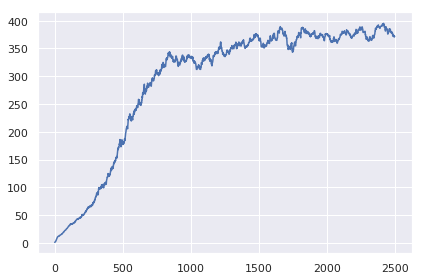

In [10]:
plt.plot(range(len(result)), result)
plt.tight_layout()
plt.show()

In [8]:
from matplotlib import animation

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save('./c51_breakout_result.gif', writer='imagemagick', fps=30)

/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Total Reward : 309.00


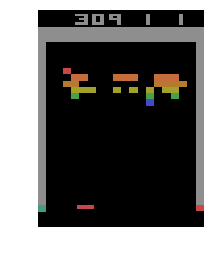

In [9]:
env = wrap(gym.make('BreakoutNoFrameskip-v4'))
s = np.array(env.reset())
total_reward = 0
done_counter = 0
frames = []

for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    a= dqn.choose_action(np.expand_dims(s,axis=0), EPSILON)
    # take action and get next state
    s_, r, done, info = env.step(a)
    s_ = np.array(s_)
    total_reward += r
    if done:
        done_counter += 1
        if done_counter == 5:
            break
    s = s_
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

![alt text](./c51_breakout_result.gif "segment")